In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 256
hidden_1 = 256
hidden_2 = 256
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.input = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=4, min_val=-8.0, max_val=7.0, return_quant_tensor=True)
        
        self.fc0   = qnn.QuantLinear(input_length, hidden_0, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.act0  = nn.SiLU()
        self.quan0 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=4, min_val=-8.0, max_val=7.0, return_quant_tensor=True)
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = qnn.QuantLinear(hidden_0, hidden_1, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.act1  = nn.SiLU()
        self.quan1 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=4, min_val=-8.0, max_val=7.0, return_quant_tensor=True)
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = qnn.QuantLinear(hidden_1, hidden_2, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.act2  = nn.SiLU()
        self.quan2 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=4, min_val=-8.0, max_val=7.0, return_quant_tensor=True)
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(hidden_2, output_length, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.input(out)
        out = self.drop0(self.quan0(self.act0(self.bn0(self.fc0(out)))))
        out = self.drop1(self.quan1(self.act1(self.bn1(self.fc1(out)))))
        out = self.drop2(self.quan2(self.act2(self.bn2(self.fc2(out)))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2779, Acc: 0.9166 | Val Loss: 0.1510, Acc: 0.9569


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1539, Acc: 0.9535 | Val Loss: 0.1325, Acc: 0.9602


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1183, Acc: 0.9654 | Val Loss: 0.1396, Acc: 0.9609


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9692 | Val Loss: 0.1089, Acc: 0.9659


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9751 | Val Loss: 0.1256, Acc: 0.9667


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9779 | Val Loss: 0.1186, Acc: 0.9688


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9819 | Val Loss: 0.1127, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9829 | Val Loss: 0.1254, Acc: 0.9669


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9848 | Val Loss: 0.1200, Acc: 0.9713


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9857 | Val Loss: 0.1250, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 0.1192, Acc: 0.9728


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9888 | Val Loss: 0.1147, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9897 | Val Loss: 0.1317, Acc: 0.9727


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9890 | Val Loss: 0.1172, Acc: 0.9737


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9910 | Val Loss: 0.1298, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9907 | Val Loss: 0.1450, Acc: 0.9704


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9909 | Val Loss: 0.1167, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9930 | Val Loss: 0.1357, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9924 | Val Loss: 0.1519, Acc: 0.9719


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.1642, Acc: 0.9699


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.1405, Acc: 0.9733


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9930 | Val Loss: 0.1345, Acc: 0.9757


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9939 | Val Loss: 0.1422, Acc: 0.9740


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9934 | Val Loss: 0.1521, Acc: 0.9728


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9941 | Val Loss: 0.1386, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9938 | Val Loss: 0.1313, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9937 | Val Loss: 0.1361, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.1452, Acc: 0.9761


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9940 | Val Loss: 0.1637, Acc: 0.9747


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9945 | Val Loss: 0.1339, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9952 | Val Loss: 0.1449, Acc: 0.9747


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9954 | Val Loss: 0.1594, Acc: 0.9748


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9946 | Val Loss: 0.1488, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9961 | Val Loss: 0.1720, Acc: 0.9732


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9949 | Val Loss: 0.1550, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.1711, Acc: 0.9734


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9953 | Val Loss: 0.1555, Acc: 0.9777


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9951 | Val Loss: 0.1509, Acc: 0.9775


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9957 | Val Loss: 0.1634, Acc: 0.9759


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9954 | Val Loss: 0.1562, Acc: 0.9739


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9966 | Val Loss: 0.1740, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9960 | Val Loss: 0.1622, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9963 | Val Loss: 0.1823, Acc: 0.9745


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9961 | Val Loss: 0.1640, Acc: 0.9754


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9961 | Val Loss: 0.1738, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9960 | Val Loss: 0.1815, Acc: 0.9738


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.1886, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9963 | Val Loss: 0.1827, Acc: 0.9751


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9964 | Val Loss: 0.1889, Acc: 0.9727


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9966 | Val Loss: 0.1894, Acc: 0.9740


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9960 | Val Loss: 0.1855, Acc: 0.9772


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9968 | Val Loss: 0.1749, Acc: 0.9780


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9966 | Val Loss: 0.1591, Acc: 0.9786


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9964 | Val Loss: 0.1840, Acc: 0.9759


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9974 | Val Loss: 0.1746, Acc: 0.9776


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9963 | Val Loss: 0.1970, Acc: 0.9744


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.1940, Acc: 0.9771


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9969 | Val Loss: 0.1833, Acc: 0.9768


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9970 | Val Loss: 0.1963, Acc: 0.9747


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9976 | Val Loss: 0.1955, Acc: 0.9768


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9967 | Val Loss: 0.2060, Acc: 0.9732


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9975 | Val Loss: 0.1989, Acc: 0.9761


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9969 | Val Loss: 0.1892, Acc: 0.9791


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9968 | Val Loss: 0.2282, Acc: 0.9754


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9971 | Val Loss: 0.1917, Acc: 0.9764


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9971 | Val Loss: 0.1857, Acc: 0.9754


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9972 | Val Loss: 0.1972, Acc: 0.9749


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9974 | Val Loss: 0.1976, Acc: 0.9762


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.2336, Acc: 0.9740


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9968 | Val Loss: 0.1976, Acc: 0.9751


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.1854, Acc: 0.9755


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9974 | Val Loss: 0.1937, Acc: 0.9760


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9978 | Val Loss: 0.2000, Acc: 0.9775


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9973 | Val Loss: 0.2173, Acc: 0.9753


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9979 | Val Loss: 0.1999, Acc: 0.9780


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9977 | Val Loss: 0.2001, Acc: 0.9762


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9971 | Val Loss: 0.2088, Acc: 0.9759


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9976 | Val Loss: 0.1966, Acc: 0.9762


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9977 | Val Loss: 0.2280, Acc: 0.9746


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9978 | Val Loss: 0.1951, Acc: 0.9775


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9975 | Val Loss: 0.2174, Acc: 0.9751


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9973 | Val Loss: 0.1878, Acc: 0.9781


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.2307, Acc: 0.9767


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9976 | Val Loss: 0.2030, Acc: 0.9785


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9975 | Val Loss: 0.2215, Acc: 0.9768


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9981 | Val Loss: 0.2049, Acc: 0.9763


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9980 | Val Loss: 0.1846, Acc: 0.9786


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9978 | Val Loss: 0.2465, Acc: 0.9738


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9980 | Val Loss: 0.1905, Acc: 0.9775


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9983 | Val Loss: 0.2138, Acc: 0.9761


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9980 | Val Loss: 0.2039, Acc: 0.9760


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9974 | Val Loss: 0.2296, Acc: 0.9768


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9977 | Val Loss: 0.2241, Acc: 0.9768


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9980 | Val Loss: 0.1967, Acc: 0.9790


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9983 | Val Loss: 0.2058, Acc: 0.9798


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.2213, Acc: 0.9788


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9979 | Val Loss: 0.2390, Acc: 0.9762


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9979 | Val Loss: 0.2194, Acc: 0.9743


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9979 | Val Loss: 0.2023, Acc: 0.9770


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9981 | Val Loss: 0.2337, Acc: 0.9766


Final Test Loss: 0.2222 Accuracy: 0.9765


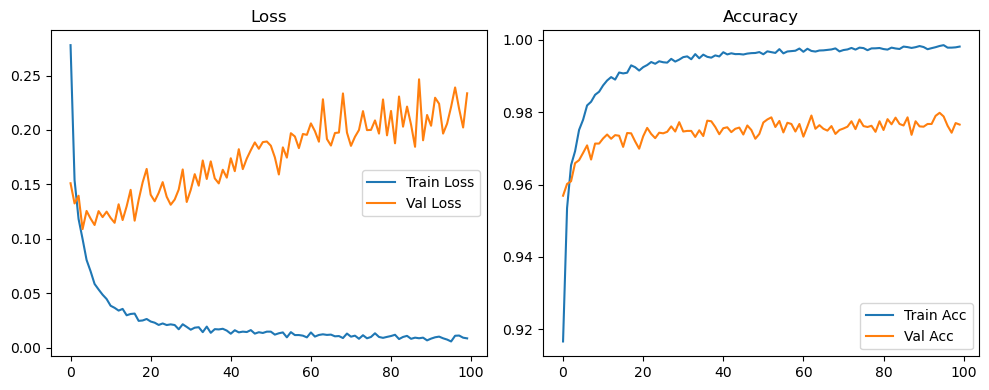

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3333, Acc: 0.9018 | Val Loss: 0.1658, Acc: 0.9471


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2063, Acc: 0.9395 | Val Loss: 0.1373, Acc: 0.9597


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1699, Acc: 0.9500 | Val Loss: 0.1368, Acc: 0.9602


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9555 | Val Loss: 0.1250, Acc: 0.9622


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9617 | Val Loss: 0.1193, Acc: 0.9654


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1180, Acc: 0.9650 | Val Loss: 0.1345, Acc: 0.9629


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1074, Acc: 0.9680 | Val Loss: 0.1108, Acc: 0.9684


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0997, Acc: 0.9695 | Val Loss: 0.1094, Acc: 0.9692


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0908, Acc: 0.9726 | Val Loss: 0.1206, Acc: 0.9708


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9721 | Val Loss: 0.1264, Acc: 0.9691


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9770 | Val Loss: 0.1188, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9760 | Val Loss: 0.1175, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0745, Acc: 0.9779 | Val Loss: 0.1129, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9785 | Val Loss: 0.1330, Acc: 0.9707


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9806 | Val Loss: 0.1251, Acc: 0.9699


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0673, Acc: 0.9810 | Val Loss: 0.1269, Acc: 0.9732


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9813 | Val Loss: 0.1306, Acc: 0.9729


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9827 | Val Loss: 0.1215, Acc: 0.9740


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9822 | Val Loss: 0.1289, Acc: 0.9715


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9840 | Val Loss: 0.1257, Acc: 0.9717


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9829 | Val Loss: 0.1233, Acc: 0.9735


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9845 | Val Loss: 0.1377, Acc: 0.9724


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9847 | Val Loss: 0.1263, Acc: 0.9741


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9860 | Val Loss: 0.1392, Acc: 0.9712


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9857 | Val Loss: 0.1279, Acc: 0.9742


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9861 | Val Loss: 0.1287, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9864 | Val Loss: 0.1430, Acc: 0.9739


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9857 | Val Loss: 0.1334, Acc: 0.9751


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9859 | Val Loss: 0.1474, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9867 | Val Loss: 0.1443, Acc: 0.9765


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9877 | Val Loss: 0.1359, Acc: 0.9759


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9879 | Val Loss: 0.1483, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9878 | Val Loss: 0.1433, Acc: 0.9741


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9884 | Val Loss: 0.1393, Acc: 0.9729


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9878 | Val Loss: 0.1448, Acc: 0.9744


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9883 | Val Loss: 0.1376, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9892 | Val Loss: 0.1539, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9888 | Val Loss: 0.1762, Acc: 0.9745


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9884 | Val Loss: 0.1539, Acc: 0.9744


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9891 | Val Loss: 0.1543, Acc: 0.9747


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9886 | Val Loss: 0.1532, Acc: 0.9745


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9890 | Val Loss: 0.1542, Acc: 0.9773


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9896 | Val Loss: 0.1708, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9896 | Val Loss: 0.1685, Acc: 0.9756


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9904 | Val Loss: 0.1878, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9891 | Val Loss: 0.1548, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9900 | Val Loss: 0.1399, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9908 | Val Loss: 0.1804, Acc: 0.9750


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9905 | Val Loss: 0.1873, Acc: 0.9747


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9894 | Val Loss: 0.1518, Acc: 0.9768


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9898 | Val Loss: 0.1770, Acc: 0.9761


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9905 | Val Loss: 0.1723, Acc: 0.9741


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9918 | Val Loss: 0.1925, Acc: 0.9759


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9901 | Val Loss: 0.1692, Acc: 0.9749


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9905 | Val Loss: 0.1614, Acc: 0.9769


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9905 | Val Loss: 0.1656, Acc: 0.9742


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9911 | Val Loss: 0.1552, Acc: 0.9772


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9911 | Val Loss: 0.1560, Acc: 0.9749


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9910 | Val Loss: 0.1885, Acc: 0.9758


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9909 | Val Loss: 0.1767, Acc: 0.9773


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9907 | Val Loss: 0.1782, Acc: 0.9757


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9920 | Val Loss: 0.1886, Acc: 0.9762


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9915 | Val Loss: 0.1917, Acc: 0.9752


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9921 | Val Loss: 0.1789, Acc: 0.9769


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9915 | Val Loss: 0.1897, Acc: 0.9766


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9917 | Val Loss: 0.1880, Acc: 0.9768


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9921 | Val Loss: 0.1875, Acc: 0.9744


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9920 | Val Loss: 0.1998, Acc: 0.9735


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9925 | Val Loss: 0.2124, Acc: 0.9737


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9919 | Val Loss: 0.2101, Acc: 0.9738


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9926 | Val Loss: 0.2012, Acc: 0.9740


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9922 | Val Loss: 0.1879, Acc: 0.9776


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9929 | Val Loss: 0.2016, Acc: 0.9765


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9916 | Val Loss: 0.1915, Acc: 0.9771


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9929 | Val Loss: 0.1936, Acc: 0.9775


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9918 | Val Loss: 0.1782, Acc: 0.9781


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9933 | Val Loss: 0.1998, Acc: 0.9758


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9931 | Val Loss: 0.2128, Acc: 0.9768


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9921 | Val Loss: 0.2018, Acc: 0.9762


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9925 | Val Loss: 0.1770, Acc: 0.9778


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9931 | Val Loss: 0.2126, Acc: 0.9734


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9926 | Val Loss: 0.2035, Acc: 0.9749


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9919 | Val Loss: 0.2141, Acc: 0.9766


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9931 | Val Loss: 0.2277, Acc: 0.9742


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9931 | Val Loss: 0.2305, Acc: 0.9728


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9937 | Val Loss: 0.1956, Acc: 0.9771


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9930 | Val Loss: 0.2271, Acc: 0.9735


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9931 | Val Loss: 0.2188, Acc: 0.9763


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9930 | Val Loss: 0.2206, Acc: 0.9754


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9927 | Val Loss: 0.2142, Acc: 0.9783


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9928 | Val Loss: 0.2123, Acc: 0.9755


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9932 | Val Loss: 0.2117, Acc: 0.9754


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9934 | Val Loss: 0.2179, Acc: 0.9767


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9934 | Val Loss: 0.2030, Acc: 0.9773


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9938 | Val Loss: 0.2326, Acc: 0.9765


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9926 | Val Loss: 0.2278, Acc: 0.9789


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9942 | Val Loss: 0.2002, Acc: 0.9764


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9941 | Val Loss: 0.2322, Acc: 0.9764


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9937 | Val Loss: 0.2267, Acc: 0.9751


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9933 | Val Loss: 0.2314, Acc: 0.9752


Final Test Loss: 0.2149 Accuracy: 0.9795


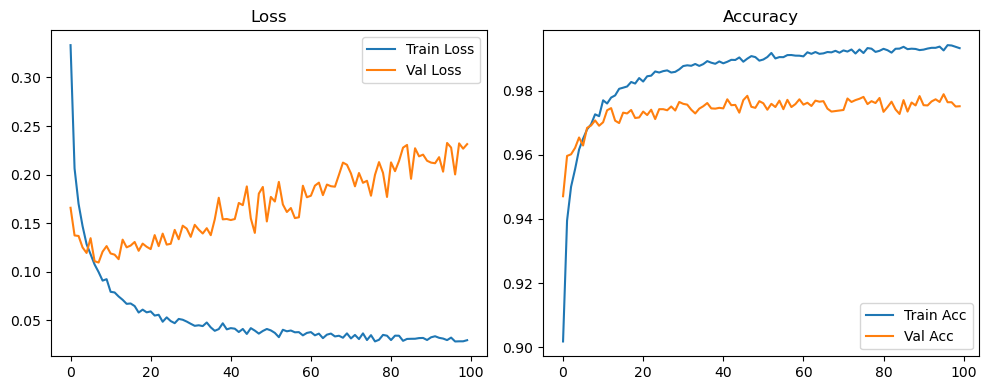

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5067, Acc: 0.8510 | Val Loss: 0.2048, Acc: 0.9384


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3471, Acc: 0.9006 | Val Loss: 0.1699, Acc: 0.9499


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3062, Acc: 0.9114 | Val Loss: 0.1492, Acc: 0.9558


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2771, Acc: 0.9206 | Val Loss: 0.1380, Acc: 0.9594


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2566, Acc: 0.9267 | Val Loss: 0.1361, Acc: 0.9630


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2475, Acc: 0.9288 | Val Loss: 0.1250, Acc: 0.9634


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2253, Acc: 0.9354 | Val Loss: 0.1208, Acc: 0.9643


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.2159, Acc: 0.9387 | Val Loss: 0.1215, Acc: 0.9635


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.2098, Acc: 0.9397 | Val Loss: 0.1275, Acc: 0.9633


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.2049, Acc: 0.9419 | Val Loss: 0.1125, Acc: 0.9678


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1997, Acc: 0.9423 | Val Loss: 0.1189, Acc: 0.9665


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1946, Acc: 0.9451 | Val Loss: 0.1070, Acc: 0.9706


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1856, Acc: 0.9465 | Val Loss: 0.1251, Acc: 0.9664


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1888, Acc: 0.9459 | Val Loss: 0.1136, Acc: 0.9674


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1748, Acc: 0.9505 | Val Loss: 0.1180, Acc: 0.9677


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1658, Acc: 0.9523 | Val Loss: 0.1152, Acc: 0.9702


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1712, Acc: 0.9525 | Val Loss: 0.1087, Acc: 0.9702


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1701, Acc: 0.9515 | Val Loss: 0.1115, Acc: 0.9680


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1659, Acc: 0.9534 | Val Loss: 0.1022, Acc: 0.9708


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1603, Acc: 0.9539 | Val Loss: 0.1056, Acc: 0.9718


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1622, Acc: 0.9539 | Val Loss: 0.1093, Acc: 0.9722


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9568 | Val Loss: 0.1088, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1520, Acc: 0.9567 | Val Loss: 0.1042, Acc: 0.9724


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1504, Acc: 0.9572 | Val Loss: 0.1100, Acc: 0.9722


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1461, Acc: 0.9583 | Val Loss: 0.1098, Acc: 0.9739


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1509, Acc: 0.9584 | Val Loss: 0.1058, Acc: 0.9734


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1441, Acc: 0.9592 | Val Loss: 0.1154, Acc: 0.9706


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1469, Acc: 0.9587 | Val Loss: 0.1157, Acc: 0.9712


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1427, Acc: 0.9601 | Val Loss: 0.1109, Acc: 0.9736


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1419, Acc: 0.9607 | Val Loss: 0.1076, Acc: 0.9728


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1396, Acc: 0.9604 | Val Loss: 0.1130, Acc: 0.9728


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1363, Acc: 0.9615 | Val Loss: 0.1101, Acc: 0.9736


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1402, Acc: 0.9615 | Val Loss: 0.1026, Acc: 0.9733


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1345, Acc: 0.9618 | Val Loss: 0.1080, Acc: 0.9725


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9634 | Val Loss: 0.1095, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1385, Acc: 0.9612 | Val Loss: 0.1142, Acc: 0.9720


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1267, Acc: 0.9635 | Val Loss: 0.1086, Acc: 0.9743


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1372, Acc: 0.9626 | Val Loss: 0.1130, Acc: 0.9720


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1275, Acc: 0.9636 | Val Loss: 0.1231, Acc: 0.9732


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1245, Acc: 0.9650 | Val Loss: 0.1206, Acc: 0.9718


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1339, Acc: 0.9642 | Val Loss: 0.1130, Acc: 0.9735


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1201, Acc: 0.9655 | Val Loss: 0.1149, Acc: 0.9718


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9653 | Val Loss: 0.1213, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1323, Acc: 0.9634 | Val Loss: 0.1087, Acc: 0.9748


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9651 | Val Loss: 0.1154, Acc: 0.9751


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1267, Acc: 0.9658 | Val Loss: 0.1141, Acc: 0.9738


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9645 | Val Loss: 0.1223, Acc: 0.9732


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1170, Acc: 0.9674 | Val Loss: 0.1183, Acc: 0.9733


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9666 | Val Loss: 0.1185, Acc: 0.9730


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1171, Acc: 0.9671 | Val Loss: 0.1194, Acc: 0.9743


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.1170, Acc: 0.9683 | Val Loss: 0.1191, Acc: 0.9765


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.1169, Acc: 0.9676 | Val Loss: 0.1180, Acc: 0.9752


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.1209, Acc: 0.9660 | Val Loss: 0.1244, Acc: 0.9744


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.1232, Acc: 0.9665 | Val Loss: 0.1251, Acc: 0.9704


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.1125, Acc: 0.9682 | Val Loss: 0.1218, Acc: 0.9731


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.1170, Acc: 0.9674 | Val Loss: 0.1137, Acc: 0.9748


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9689 | Val Loss: 0.1091, Acc: 0.9754


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.1125, Acc: 0.9690 | Val Loss: 0.1235, Acc: 0.9734


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.1155, Acc: 0.9696 | Val Loss: 0.1100, Acc: 0.9753


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.1130, Acc: 0.9696 | Val Loss: 0.1060, Acc: 0.9757


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.1106, Acc: 0.9693 | Val Loss: 0.1177, Acc: 0.9733


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.1098, Acc: 0.9706 | Val Loss: 0.1302, Acc: 0.9728


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.1116, Acc: 0.9690 | Val Loss: 0.1127, Acc: 0.9758


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.1137, Acc: 0.9688 | Val Loss: 0.1195, Acc: 0.9744


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9716 | Val Loss: 0.1185, Acc: 0.9759


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.1185, Acc: 0.9686 | Val Loss: 0.1181, Acc: 0.9738


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9693 | Val Loss: 0.1264, Acc: 0.9738


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.1044, Acc: 0.9712 | Val Loss: 0.1187, Acc: 0.9738


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.1148, Acc: 0.9692 | Val Loss: 0.1179, Acc: 0.9751


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.1078, Acc: 0.9707 | Val Loss: 0.1266, Acc: 0.9711


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9706 | Val Loss: 0.1351, Acc: 0.9736


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.1093, Acc: 0.9705 | Val Loss: 0.1144, Acc: 0.9742


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.1006, Acc: 0.9727 | Val Loss: 0.1192, Acc: 0.9739


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9695 | Val Loss: 0.1146, Acc: 0.9746


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.1035, Acc: 0.9717 | Val Loss: 0.1295, Acc: 0.9752


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.1064, Acc: 0.9712 | Val Loss: 0.1197, Acc: 0.9737


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9726 | Val Loss: 0.1244, Acc: 0.9742


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.1061, Acc: 0.9712 | Val Loss: 0.1192, Acc: 0.9743


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.1052, Acc: 0.9718 | Val Loss: 0.1199, Acc: 0.9738


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.1071, Acc: 0.9709 | Val Loss: 0.1260, Acc: 0.9736


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.1035, Acc: 0.9716 | Val Loss: 0.1261, Acc: 0.9756


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.1099, Acc: 0.9714 | Val Loss: 0.1247, Acc: 0.9743


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.1078, Acc: 0.9712 | Val Loss: 0.1228, Acc: 0.9735


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0988, Acc: 0.9729 | Val Loss: 0.1188, Acc: 0.9743


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.1027, Acc: 0.9724 | Val Loss: 0.1258, Acc: 0.9750


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0990, Acc: 0.9735 | Val Loss: 0.1306, Acc: 0.9750


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.1033, Acc: 0.9728 | Val Loss: 0.1347, Acc: 0.9740


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.1017, Acc: 0.9727 | Val Loss: 0.1291, Acc: 0.9736


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.1033, Acc: 0.9719 | Val Loss: 0.1315, Acc: 0.9742


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.1003, Acc: 0.9732 | Val Loss: 0.1229, Acc: 0.9747


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.1012, Acc: 0.9722 | Val Loss: 0.1221, Acc: 0.9750


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.1038, Acc: 0.9726 | Val Loss: 0.1212, Acc: 0.9743


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0963, Acc: 0.9732 | Val Loss: 0.1284, Acc: 0.9742


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.1030, Acc: 0.9720 | Val Loss: 0.1163, Acc: 0.9752


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9733 | Val Loss: 0.1350, Acc: 0.9738


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9712 | Val Loss: 0.1331, Acc: 0.9754


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.1002, Acc: 0.9738 | Val Loss: 0.1293, Acc: 0.9731


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0939, Acc: 0.9752 | Val Loss: 0.1321, Acc: 0.9745


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.1020, Acc: 0.9724 | Val Loss: 0.1334, Acc: 0.9745


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.1055, Acc: 0.9717 | Val Loss: 0.1497, Acc: 0.9733


Final Test Loss: 0.1196 Accuracy: 0.9772


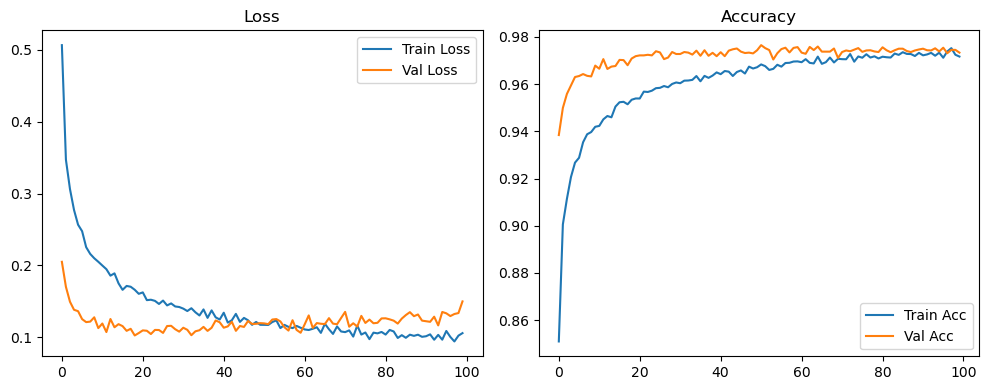

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2779, Acc: 0.9166 | Val Loss: 0.1510, Acc: 0.9569


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1539, Acc: 0.9535 | Val Loss: 0.1325, Acc: 0.9602


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1183, Acc: 0.9654 | Val Loss: 0.1396, Acc: 0.9609


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9692 | Val Loss: 0.1089, Acc: 0.9659


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9751 | Val Loss: 0.1256, Acc: 0.9667


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9779 | Val Loss: 0.1186, Acc: 0.9688


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9819 | Val Loss: 0.1127, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9829 | Val Loss: 0.1254, Acc: 0.9669


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9848 | Val Loss: 0.1200, Acc: 0.9713


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9857 | Val Loss: 0.1250, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 0.1192, Acc: 0.9728


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9888 | Val Loss: 0.1147, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9897 | Val Loss: 0.1317, Acc: 0.9727


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9890 | Val Loss: 0.1172, Acc: 0.9737


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9910 | Val Loss: 0.1298, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9907 | Val Loss: 0.1450, Acc: 0.9704


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9909 | Val Loss: 0.1167, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9930 | Val Loss: 0.1357, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9924 | Val Loss: 0.1519, Acc: 0.9719


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.1642, Acc: 0.9699


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.1405, Acc: 0.9733


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9930 | Val Loss: 0.1345, Acc: 0.9757


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9939 | Val Loss: 0.1422, Acc: 0.9740


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9934 | Val Loss: 0.1521, Acc: 0.9728


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9941 | Val Loss: 0.1386, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9938 | Val Loss: 0.1313, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9937 | Val Loss: 0.1361, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.1452, Acc: 0.9761


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9940 | Val Loss: 0.1637, Acc: 0.9747


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9945 | Val Loss: 0.1339, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9952 | Val Loss: 0.1449, Acc: 0.9747


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9954 | Val Loss: 0.1594, Acc: 0.9748


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9946 | Val Loss: 0.1488, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9961 | Val Loss: 0.1720, Acc: 0.9732


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9949 | Val Loss: 0.1550, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.1711, Acc: 0.9734


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9953 | Val Loss: 0.1555, Acc: 0.9777


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9951 | Val Loss: 0.1509, Acc: 0.9775


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9957 | Val Loss: 0.1634, Acc: 0.9759


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9954 | Val Loss: 0.1562, Acc: 0.9739


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9966 | Val Loss: 0.1740, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9960 | Val Loss: 0.1622, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9963 | Val Loss: 0.1823, Acc: 0.9745


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9961 | Val Loss: 0.1640, Acc: 0.9754


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9961 | Val Loss: 0.1738, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9960 | Val Loss: 0.1815, Acc: 0.9738


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.1886, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9963 | Val Loss: 0.1827, Acc: 0.9751


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9964 | Val Loss: 0.1889, Acc: 0.9727


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9966 | Val Loss: 0.1894, Acc: 0.9740


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1584, Acc: 0.9788


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1563, Acc: 0.9789


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1604, Acc: 0.9795


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1775, Acc: 0.9765


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1746, Acc: 0.9763


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1842, Acc: 0.9792


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1891, Acc: 0.9772


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1889, Acc: 0.9779


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1980, Acc: 0.9787


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9987 | Val Loss: 0.1932, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9985 | Val Loss: 0.1824, Acc: 0.9802


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.2010, Acc: 0.9790


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1997, Acc: 0.9800


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.2065, Acc: 0.9795


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.2237, Acc: 0.9785


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.2008, Acc: 0.9790


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.2369, Acc: 0.9783


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.2174, Acc: 0.9792


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.2212, Acc: 0.9793


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.2312, Acc: 0.9777


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.2378, Acc: 0.9784


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.2314, Acc: 0.9783


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.2144, Acc: 0.9795


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.2188, Acc: 0.9789


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.2385, Acc: 0.9798


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.2253, Acc: 0.9792


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9992 | Val Loss: 0.2088, Acc: 0.9799


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.2434, Acc: 0.9783


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.2262, Acc: 0.9791


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.2265, Acc: 0.9792


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.2378, Acc: 0.9795


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.2240, Acc: 0.9799


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2290, Acc: 0.9802


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.2291, Acc: 0.9804


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2315, Acc: 0.9799


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2252, Acc: 0.9799


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2401, Acc: 0.9797


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2269, Acc: 0.9806


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.2282, Acc: 0.9802


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2270, Acc: 0.9802


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2392, Acc: 0.9792


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2298, Acc: 0.9808


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2451, Acc: 0.9800


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2364, Acc: 0.9813


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2511, Acc: 0.9798


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2318, Acc: 0.9807


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2189, Acc: 0.9819


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2444, Acc: 0.9799


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2276, Acc: 0.9815


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2289, Acc: 0.9808


Final Test Loss: 0.2399 Accuracy: 0.9791


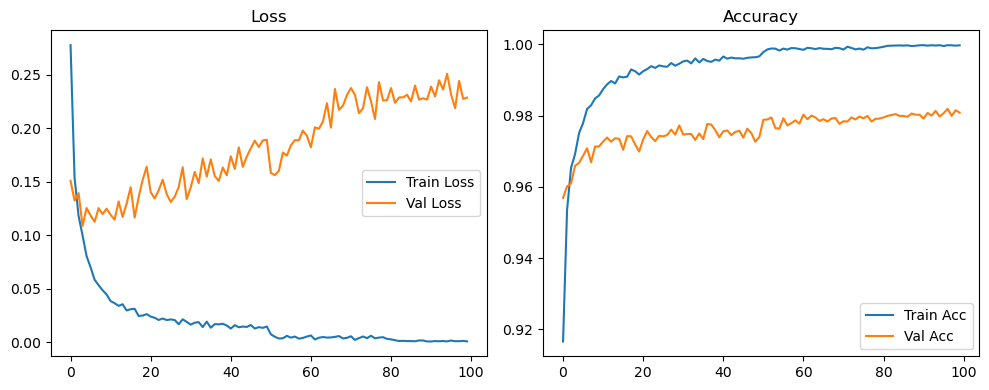

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3333, Acc: 0.9018 | Val Loss: 0.1658, Acc: 0.9471


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2063, Acc: 0.9395 | Val Loss: 0.1373, Acc: 0.9597


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1699, Acc: 0.9500 | Val Loss: 0.1368, Acc: 0.9602


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9555 | Val Loss: 0.1250, Acc: 0.9622


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9617 | Val Loss: 0.1193, Acc: 0.9654


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1180, Acc: 0.9650 | Val Loss: 0.1345, Acc: 0.9629


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1074, Acc: 0.9680 | Val Loss: 0.1108, Acc: 0.9684


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0997, Acc: 0.9695 | Val Loss: 0.1094, Acc: 0.9692


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0908, Acc: 0.9726 | Val Loss: 0.1206, Acc: 0.9708


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9721 | Val Loss: 0.1264, Acc: 0.9691


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9770 | Val Loss: 0.1188, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9760 | Val Loss: 0.1175, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0745, Acc: 0.9779 | Val Loss: 0.1129, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9785 | Val Loss: 0.1330, Acc: 0.9707


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9806 | Val Loss: 0.1251, Acc: 0.9699


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0673, Acc: 0.9810 | Val Loss: 0.1269, Acc: 0.9732


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9813 | Val Loss: 0.1306, Acc: 0.9729


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9827 | Val Loss: 0.1215, Acc: 0.9740


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9822 | Val Loss: 0.1289, Acc: 0.9715


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9840 | Val Loss: 0.1257, Acc: 0.9717


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9829 | Val Loss: 0.1233, Acc: 0.9735


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9845 | Val Loss: 0.1377, Acc: 0.9724


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9847 | Val Loss: 0.1263, Acc: 0.9741


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9860 | Val Loss: 0.1392, Acc: 0.9712


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9857 | Val Loss: 0.1279, Acc: 0.9742


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9861 | Val Loss: 0.1287, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9864 | Val Loss: 0.1430, Acc: 0.9739


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9857 | Val Loss: 0.1334, Acc: 0.9751


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9859 | Val Loss: 0.1474, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9867 | Val Loss: 0.1443, Acc: 0.9765


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9877 | Val Loss: 0.1359, Acc: 0.9759


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9879 | Val Loss: 0.1483, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9878 | Val Loss: 0.1433, Acc: 0.9741


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9884 | Val Loss: 0.1393, Acc: 0.9729


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9878 | Val Loss: 0.1448, Acc: 0.9744


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9883 | Val Loss: 0.1376, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9892 | Val Loss: 0.1539, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9888 | Val Loss: 0.1762, Acc: 0.9745


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9884 | Val Loss: 0.1539, Acc: 0.9744


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9891 | Val Loss: 0.1543, Acc: 0.9747


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9886 | Val Loss: 0.1532, Acc: 0.9745


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9890 | Val Loss: 0.1542, Acc: 0.9773


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9896 | Val Loss: 0.1708, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9896 | Val Loss: 0.1685, Acc: 0.9756


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9904 | Val Loss: 0.1878, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9891 | Val Loss: 0.1548, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9900 | Val Loss: 0.1399, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9908 | Val Loss: 0.1804, Acc: 0.9750


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9905 | Val Loss: 0.1873, Acc: 0.9747


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9894 | Val Loss: 0.1518, Acc: 0.9768


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9928 | Val Loss: 0.1496, Acc: 0.9784


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9943 | Val Loss: 0.1733, Acc: 0.9767


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9949 | Val Loss: 0.1682, Acc: 0.9775


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9944 | Val Loss: 0.1674, Acc: 0.9772


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9946 | Val Loss: 0.1679, Acc: 0.9783


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9950 | Val Loss: 0.1545, Acc: 0.9785


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9955 | Val Loss: 0.1499, Acc: 0.9798


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9954 | Val Loss: 0.1610, Acc: 0.9786


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9945 | Val Loss: 0.1621, Acc: 0.9787


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9949 | Val Loss: 0.1672, Acc: 0.9757


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9957 | Val Loss: 0.1695, Acc: 0.9774


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9954 | Val Loss: 0.1657, Acc: 0.9782


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9964 | Val Loss: 0.1706, Acc: 0.9783


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9955 | Val Loss: 0.1762, Acc: 0.9771


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9949 | Val Loss: 0.1777, Acc: 0.9769


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9957 | Val Loss: 0.1793, Acc: 0.9798


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9958 | Val Loss: 0.1719, Acc: 0.9771


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9954 | Val Loss: 0.1722, Acc: 0.9778


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9956 | Val Loss: 0.1854, Acc: 0.9773


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9958 | Val Loss: 0.1967, Acc: 0.9766


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9958 | Val Loss: 0.1922, Acc: 0.9782


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9952 | Val Loss: 0.1788, Acc: 0.9787


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9955 | Val Loss: 0.1725, Acc: 0.9778


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9965 | Val Loss: 0.1790, Acc: 0.9765


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9959 | Val Loss: 0.2053, Acc: 0.9769


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9951 | Val Loss: 0.1743, Acc: 0.9785


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9967 | Val Loss: 0.1791, Acc: 0.9778


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9960 | Val Loss: 0.1863, Acc: 0.9778


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9955 | Val Loss: 0.1955, Acc: 0.9770


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9957 | Val Loss: 0.1838, Acc: 0.9787


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9965 | Val Loss: 0.1712, Acc: 0.9783


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.1702, Acc: 0.9794


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1745, Acc: 0.9792


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.1752, Acc: 0.9792


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1822, Acc: 0.9779


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1922, Acc: 0.9785


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9976 | Val Loss: 0.1824, Acc: 0.9769


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9975 | Val Loss: 0.1777, Acc: 0.9791


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9976 | Val Loss: 0.1816, Acc: 0.9780


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1734, Acc: 0.9785


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9981 | Val Loss: 0.1840, Acc: 0.9779


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1771, Acc: 0.9799


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9976 | Val Loss: 0.1777, Acc: 0.9798


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1803, Acc: 0.9798


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1689, Acc: 0.9803


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1746, Acc: 0.9803


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9977 | Val Loss: 0.1799, Acc: 0.9793


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.1753, Acc: 0.9792


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1797, Acc: 0.9792


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1794, Acc: 0.9803


Final Test Loss: 0.1661 Accuracy: 0.9825


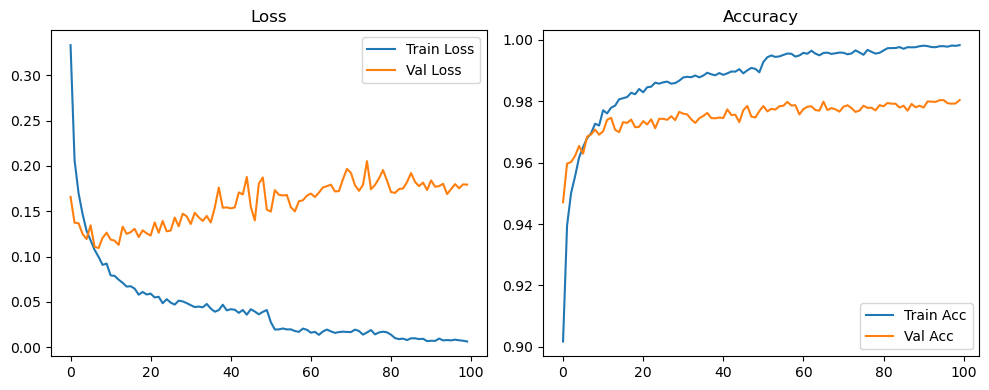

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5067, Acc: 0.8510 | Val Loss: 0.2048, Acc: 0.9384


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3471, Acc: 0.9006 | Val Loss: 0.1699, Acc: 0.9499


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3062, Acc: 0.9114 | Val Loss: 0.1492, Acc: 0.9558


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2771, Acc: 0.9206 | Val Loss: 0.1380, Acc: 0.9594


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2566, Acc: 0.9267 | Val Loss: 0.1361, Acc: 0.9630


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2475, Acc: 0.9288 | Val Loss: 0.1250, Acc: 0.9634


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2253, Acc: 0.9354 | Val Loss: 0.1208, Acc: 0.9643


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.2159, Acc: 0.9387 | Val Loss: 0.1215, Acc: 0.9635


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.2098, Acc: 0.9397 | Val Loss: 0.1275, Acc: 0.9633


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.2049, Acc: 0.9419 | Val Loss: 0.1125, Acc: 0.9678


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1997, Acc: 0.9423 | Val Loss: 0.1189, Acc: 0.9665


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1946, Acc: 0.9451 | Val Loss: 0.1070, Acc: 0.9706


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1856, Acc: 0.9465 | Val Loss: 0.1251, Acc: 0.9664


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1888, Acc: 0.9459 | Val Loss: 0.1136, Acc: 0.9674


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1748, Acc: 0.9505 | Val Loss: 0.1180, Acc: 0.9677


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1658, Acc: 0.9523 | Val Loss: 0.1152, Acc: 0.9702


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1712, Acc: 0.9525 | Val Loss: 0.1087, Acc: 0.9702


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1701, Acc: 0.9515 | Val Loss: 0.1115, Acc: 0.9680


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1659, Acc: 0.9534 | Val Loss: 0.1022, Acc: 0.9708


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1603, Acc: 0.9539 | Val Loss: 0.1056, Acc: 0.9718


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1622, Acc: 0.9539 | Val Loss: 0.1093, Acc: 0.9722


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9568 | Val Loss: 0.1088, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1520, Acc: 0.9567 | Val Loss: 0.1042, Acc: 0.9724


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1504, Acc: 0.9572 | Val Loss: 0.1100, Acc: 0.9722


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1461, Acc: 0.9583 | Val Loss: 0.1098, Acc: 0.9739


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1509, Acc: 0.9584 | Val Loss: 0.1058, Acc: 0.9734


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1441, Acc: 0.9592 | Val Loss: 0.1154, Acc: 0.9706


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1469, Acc: 0.9587 | Val Loss: 0.1157, Acc: 0.9712


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1427, Acc: 0.9601 | Val Loss: 0.1109, Acc: 0.9736


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1419, Acc: 0.9607 | Val Loss: 0.1076, Acc: 0.9728


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1396, Acc: 0.9604 | Val Loss: 0.1130, Acc: 0.9728


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1363, Acc: 0.9615 | Val Loss: 0.1101, Acc: 0.9736


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1402, Acc: 0.9615 | Val Loss: 0.1026, Acc: 0.9733


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1345, Acc: 0.9618 | Val Loss: 0.1080, Acc: 0.9725


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9634 | Val Loss: 0.1095, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1385, Acc: 0.9612 | Val Loss: 0.1142, Acc: 0.9720


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1267, Acc: 0.9635 | Val Loss: 0.1086, Acc: 0.9743


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1372, Acc: 0.9626 | Val Loss: 0.1130, Acc: 0.9720


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1275, Acc: 0.9636 | Val Loss: 0.1231, Acc: 0.9732


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1245, Acc: 0.9650 | Val Loss: 0.1206, Acc: 0.9718


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1339, Acc: 0.9642 | Val Loss: 0.1130, Acc: 0.9735


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1201, Acc: 0.9655 | Val Loss: 0.1149, Acc: 0.9718


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9653 | Val Loss: 0.1213, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1323, Acc: 0.9634 | Val Loss: 0.1087, Acc: 0.9748


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9651 | Val Loss: 0.1154, Acc: 0.9751


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1267, Acc: 0.9658 | Val Loss: 0.1141, Acc: 0.9738


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9645 | Val Loss: 0.1223, Acc: 0.9732


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1170, Acc: 0.9674 | Val Loss: 0.1183, Acc: 0.9733


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9666 | Val Loss: 0.1185, Acc: 0.9730


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1171, Acc: 0.9671 | Val Loss: 0.1194, Acc: 0.9743


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0959, Acc: 0.9734 | Val Loss: 0.1081, Acc: 0.9762


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0863, Acc: 0.9746 | Val Loss: 0.1092, Acc: 0.9774


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0816, Acc: 0.9760 | Val Loss: 0.1067, Acc: 0.9777


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0896, Acc: 0.9746 | Val Loss: 0.1032, Acc: 0.9752


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0821, Acc: 0.9755 | Val Loss: 0.1046, Acc: 0.9760


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0795, Acc: 0.9773 | Val Loss: 0.1033, Acc: 0.9756


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0817, Acc: 0.9760 | Val Loss: 0.1035, Acc: 0.9766


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0725, Acc: 0.9779 | Val Loss: 0.1147, Acc: 0.9753


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9778 | Val Loss: 0.1023, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0775, Acc: 0.9766 | Val Loss: 0.1027, Acc: 0.9771


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0734, Acc: 0.9778 | Val Loss: 0.1125, Acc: 0.9738


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9775 | Val Loss: 0.1036, Acc: 0.9766


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0754, Acc: 0.9778 | Val Loss: 0.1030, Acc: 0.9770


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0732, Acc: 0.9773 | Val Loss: 0.1003, Acc: 0.9770


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0686, Acc: 0.9790 | Val Loss: 0.1082, Acc: 0.9765


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0805, Acc: 0.9775 | Val Loss: 0.0981, Acc: 0.9782


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0728, Acc: 0.9773 | Val Loss: 0.1053, Acc: 0.9767


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9788 | Val Loss: 0.1035, Acc: 0.9768


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0745, Acc: 0.9783 | Val Loss: 0.1068, Acc: 0.9754


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0729, Acc: 0.9790 | Val Loss: 0.1127, Acc: 0.9736


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0714, Acc: 0.9791 | Val Loss: 0.1083, Acc: 0.9765


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9786 | Val Loss: 0.1083, Acc: 0.9768


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9780 | Val Loss: 0.1098, Acc: 0.9759


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0751, Acc: 0.9784 | Val Loss: 0.1036, Acc: 0.9767


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9794 | Val Loss: 0.1110, Acc: 0.9768


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0728, Acc: 0.9792 | Val Loss: 0.1115, Acc: 0.9759


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9798 | Val Loss: 0.1095, Acc: 0.9770


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9783 | Val Loss: 0.1020, Acc: 0.9777


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0711, Acc: 0.9800 | Val Loss: 0.1101, Acc: 0.9759


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9788 | Val Loss: 0.1041, Acc: 0.9772


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0634, Acc: 0.9809 | Val Loss: 0.1045, Acc: 0.9766


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0571, Acc: 0.9823 | Val Loss: 0.1075, Acc: 0.9778


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0575, Acc: 0.9829 | Val Loss: 0.1028, Acc: 0.9774


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0510, Acc: 0.9846 | Val Loss: 0.0999, Acc: 0.9788


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9844 | Val Loss: 0.1101, Acc: 0.9774


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0488, Acc: 0.9850 | Val Loss: 0.1091, Acc: 0.9768


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0506, Acc: 0.9849 | Val Loss: 0.1063, Acc: 0.9769


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0478, Acc: 0.9845 | Val Loss: 0.1043, Acc: 0.9784


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0487, Acc: 0.9845 | Val Loss: 0.1064, Acc: 0.9768


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0504, Acc: 0.9851 | Val Loss: 0.0982, Acc: 0.9789


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0501, Acc: 0.9844 | Val Loss: 0.0987, Acc: 0.9792


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0522, Acc: 0.9847 | Val Loss: 0.0969, Acc: 0.9789


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9855 | Val Loss: 0.1007, Acc: 0.9792


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9847 | Val Loss: 0.0993, Acc: 0.9792


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9854 | Val Loss: 0.0994, Acc: 0.9784


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9840 | Val Loss: 0.1016, Acc: 0.9785


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0467, Acc: 0.9856 | Val Loss: 0.1020, Acc: 0.9761


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0448, Acc: 0.9869 | Val Loss: 0.0988, Acc: 0.9774


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0462, Acc: 0.9851 | Val Loss: 0.1037, Acc: 0.9772


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0508, Acc: 0.9846 | Val Loss: 0.1042, Acc: 0.9780


Final Test Loss: 0.0917 Accuracy: 0.9805


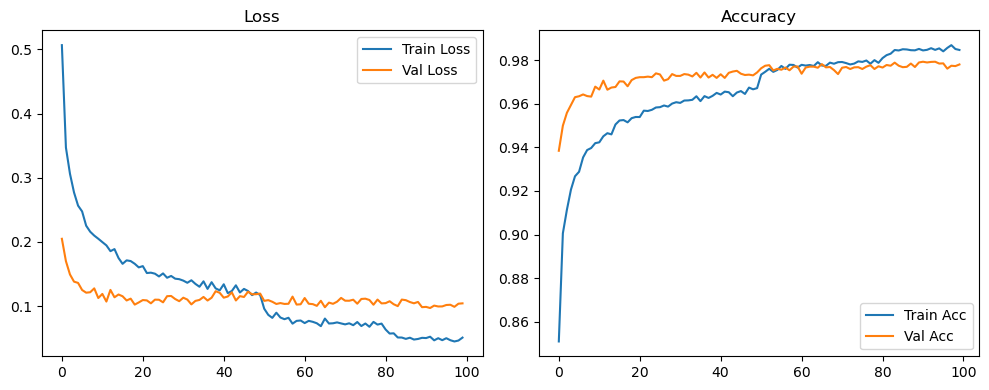

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2779, Acc: 0.9166 | Val Loss: 0.1510, Acc: 0.9569


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1539, Acc: 0.9535 | Val Loss: 0.1325, Acc: 0.9602


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1183, Acc: 0.9654 | Val Loss: 0.1396, Acc: 0.9609


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9692 | Val Loss: 0.1089, Acc: 0.9659


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9751 | Val Loss: 0.1256, Acc: 0.9667


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9779 | Val Loss: 0.1186, Acc: 0.9688


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9819 | Val Loss: 0.1127, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9829 | Val Loss: 0.1254, Acc: 0.9669


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9848 | Val Loss: 0.1200, Acc: 0.9713


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9857 | Val Loss: 0.1250, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 0.1192, Acc: 0.9728


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9888 | Val Loss: 0.1147, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9897 | Val Loss: 0.1317, Acc: 0.9727


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9890 | Val Loss: 0.1172, Acc: 0.9737


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9910 | Val Loss: 0.1298, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9907 | Val Loss: 0.1450, Acc: 0.9704


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9909 | Val Loss: 0.1167, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9930 | Val Loss: 0.1357, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9924 | Val Loss: 0.1519, Acc: 0.9719


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.1642, Acc: 0.9699


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.1405, Acc: 0.9733


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9930 | Val Loss: 0.1345, Acc: 0.9757


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9939 | Val Loss: 0.1422, Acc: 0.9740


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9934 | Val Loss: 0.1521, Acc: 0.9728


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9941 | Val Loss: 0.1386, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9938 | Val Loss: 0.1313, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9937 | Val Loss: 0.1361, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.1452, Acc: 0.9761


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9940 | Val Loss: 0.1637, Acc: 0.9747


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9945 | Val Loss: 0.1339, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9952 | Val Loss: 0.1449, Acc: 0.9747


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9954 | Val Loss: 0.1594, Acc: 0.9748


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9946 | Val Loss: 0.1488, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9961 | Val Loss: 0.1720, Acc: 0.9732


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9949 | Val Loss: 0.1550, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.1711, Acc: 0.9734


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9953 | Val Loss: 0.1555, Acc: 0.9777


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9951 | Val Loss: 0.1509, Acc: 0.9775


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9957 | Val Loss: 0.1634, Acc: 0.9759


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9954 | Val Loss: 0.1562, Acc: 0.9739


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9966 | Val Loss: 0.1740, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9960 | Val Loss: 0.1622, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9963 | Val Loss: 0.1823, Acc: 0.9745


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9961 | Val Loss: 0.1640, Acc: 0.9754


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9961 | Val Loss: 0.1738, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9960 | Val Loss: 0.1815, Acc: 0.9738


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.1886, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9963 | Val Loss: 0.1827, Acc: 0.9751


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9964 | Val Loss: 0.1889, Acc: 0.9727


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9966 | Val Loss: 0.1894, Acc: 0.9740


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1584, Acc: 0.9788


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1563, Acc: 0.9789


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1604, Acc: 0.9795


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1775, Acc: 0.9765


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1746, Acc: 0.9763


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1842, Acc: 0.9792


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1891, Acc: 0.9772


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1889, Acc: 0.9779


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1980, Acc: 0.9787


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9987 | Val Loss: 0.1932, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9985 | Val Loss: 0.1824, Acc: 0.9802


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.2010, Acc: 0.9790


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1997, Acc: 0.9800


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.2065, Acc: 0.9795


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.2237, Acc: 0.9785


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.2008, Acc: 0.9790


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.2369, Acc: 0.9783


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.2174, Acc: 0.9792


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.2212, Acc: 0.9793


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.2312, Acc: 0.9777


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.2378, Acc: 0.9784


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.2314, Acc: 0.9783


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.2144, Acc: 0.9795


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.2188, Acc: 0.9789


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.2385, Acc: 0.9798


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.2253, Acc: 0.9792


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9992 | Val Loss: 0.2088, Acc: 0.9799


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.2434, Acc: 0.9783


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.2262, Acc: 0.9791


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.2265, Acc: 0.9792


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2246, Acc: 0.9795


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.2172, Acc: 0.9796


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.2225, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2240, Acc: 0.9797


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2158, Acc: 0.9805


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2193, Acc: 0.9805


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2167, Acc: 0.9810


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.2251, Acc: 0.9808


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.2313, Acc: 0.9795


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2098, Acc: 0.9815


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2202, Acc: 0.9811


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2203, Acc: 0.9801


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2253, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2394, Acc: 0.9805


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2316, Acc: 0.9811


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.2428, Acc: 0.9803


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2343, Acc: 0.9803


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2352, Acc: 0.9800


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2243, Acc: 0.9816


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2393, Acc: 0.9808


Final Test Loss: 0.2176 Accuracy: 0.9818


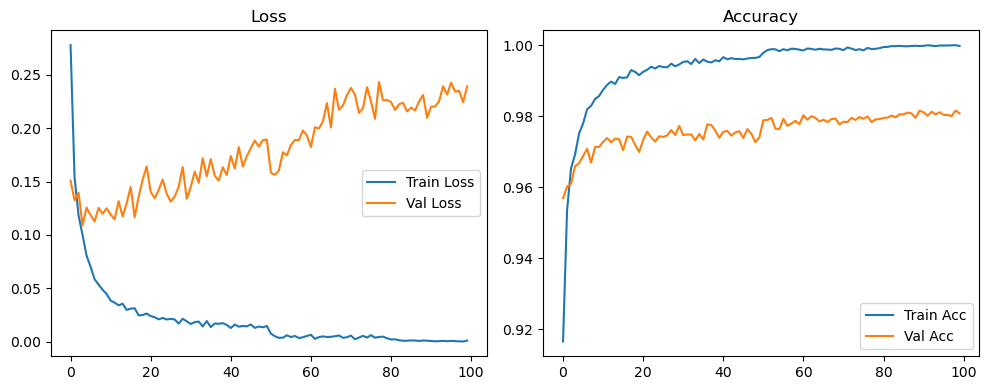

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3333, Acc: 0.9018 | Val Loss: 0.1658, Acc: 0.9471


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2063, Acc: 0.9395 | Val Loss: 0.1373, Acc: 0.9597


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1699, Acc: 0.9500 | Val Loss: 0.1368, Acc: 0.9602


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9555 | Val Loss: 0.1250, Acc: 0.9622


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9617 | Val Loss: 0.1193, Acc: 0.9654


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1180, Acc: 0.9650 | Val Loss: 0.1345, Acc: 0.9629


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1074, Acc: 0.9680 | Val Loss: 0.1108, Acc: 0.9684


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0997, Acc: 0.9695 | Val Loss: 0.1094, Acc: 0.9692


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0908, Acc: 0.9726 | Val Loss: 0.1206, Acc: 0.9708


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9721 | Val Loss: 0.1264, Acc: 0.9691


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9770 | Val Loss: 0.1188, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9760 | Val Loss: 0.1175, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0745, Acc: 0.9779 | Val Loss: 0.1129, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9785 | Val Loss: 0.1330, Acc: 0.9707


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9806 | Val Loss: 0.1251, Acc: 0.9699


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0673, Acc: 0.9810 | Val Loss: 0.1269, Acc: 0.9732


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9813 | Val Loss: 0.1306, Acc: 0.9729


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9827 | Val Loss: 0.1215, Acc: 0.9740


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9822 | Val Loss: 0.1289, Acc: 0.9715


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9840 | Val Loss: 0.1257, Acc: 0.9717


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9829 | Val Loss: 0.1233, Acc: 0.9735


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9845 | Val Loss: 0.1377, Acc: 0.9724


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9847 | Val Loss: 0.1263, Acc: 0.9741


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9860 | Val Loss: 0.1392, Acc: 0.9712


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9857 | Val Loss: 0.1279, Acc: 0.9742


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9861 | Val Loss: 0.1287, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9864 | Val Loss: 0.1430, Acc: 0.9739


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9857 | Val Loss: 0.1334, Acc: 0.9751


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9859 | Val Loss: 0.1474, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9867 | Val Loss: 0.1443, Acc: 0.9765


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9877 | Val Loss: 0.1359, Acc: 0.9759


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9879 | Val Loss: 0.1483, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9878 | Val Loss: 0.1433, Acc: 0.9741


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9884 | Val Loss: 0.1393, Acc: 0.9729


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9878 | Val Loss: 0.1448, Acc: 0.9744


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9883 | Val Loss: 0.1376, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9892 | Val Loss: 0.1539, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9888 | Val Loss: 0.1762, Acc: 0.9745


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9884 | Val Loss: 0.1539, Acc: 0.9744


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9891 | Val Loss: 0.1543, Acc: 0.9747


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9886 | Val Loss: 0.1532, Acc: 0.9745


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9890 | Val Loss: 0.1542, Acc: 0.9773


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9896 | Val Loss: 0.1708, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9896 | Val Loss: 0.1685, Acc: 0.9756


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9904 | Val Loss: 0.1878, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9891 | Val Loss: 0.1548, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9900 | Val Loss: 0.1399, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9908 | Val Loss: 0.1804, Acc: 0.9750


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9905 | Val Loss: 0.1873, Acc: 0.9747


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9894 | Val Loss: 0.1518, Acc: 0.9768


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9928 | Val Loss: 0.1496, Acc: 0.9784


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9943 | Val Loss: 0.1733, Acc: 0.9767


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9949 | Val Loss: 0.1682, Acc: 0.9775


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9944 | Val Loss: 0.1674, Acc: 0.9772


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9946 | Val Loss: 0.1679, Acc: 0.9783


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9950 | Val Loss: 0.1545, Acc: 0.9785


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9955 | Val Loss: 0.1499, Acc: 0.9798


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9954 | Val Loss: 0.1610, Acc: 0.9786


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9945 | Val Loss: 0.1621, Acc: 0.9787


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9949 | Val Loss: 0.1672, Acc: 0.9757


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9957 | Val Loss: 0.1695, Acc: 0.9774


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9954 | Val Loss: 0.1657, Acc: 0.9782


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9964 | Val Loss: 0.1706, Acc: 0.9783


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9955 | Val Loss: 0.1762, Acc: 0.9771


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9949 | Val Loss: 0.1777, Acc: 0.9769


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9957 | Val Loss: 0.1793, Acc: 0.9798


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9958 | Val Loss: 0.1719, Acc: 0.9771


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9954 | Val Loss: 0.1722, Acc: 0.9778


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9956 | Val Loss: 0.1854, Acc: 0.9773


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9958 | Val Loss: 0.1967, Acc: 0.9766


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9958 | Val Loss: 0.1922, Acc: 0.9782


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9952 | Val Loss: 0.1788, Acc: 0.9787


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9955 | Val Loss: 0.1725, Acc: 0.9778


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9965 | Val Loss: 0.1790, Acc: 0.9765


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9959 | Val Loss: 0.2053, Acc: 0.9769


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9951 | Val Loss: 0.1743, Acc: 0.9785


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9967 | Val Loss: 0.1791, Acc: 0.9778


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9960 | Val Loss: 0.1863, Acc: 0.9778


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9955 | Val Loss: 0.1955, Acc: 0.9770


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9957 | Val Loss: 0.1838, Acc: 0.9787


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9965 | Val Loss: 0.1706, Acc: 0.9788


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.1667, Acc: 0.9789


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9973 | Val Loss: 0.1716, Acc: 0.9784


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1697, Acc: 0.9798


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1690, Acc: 0.9786


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9975 | Val Loss: 0.1769, Acc: 0.9796


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9977 | Val Loss: 0.1779, Acc: 0.9791


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9977 | Val Loss: 0.1617, Acc: 0.9798


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1727, Acc: 0.9789


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1707, Acc: 0.9800


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1668, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1708, Acc: 0.9792


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9978 | Val Loss: 0.1717, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.1659, Acc: 0.9797


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1671, Acc: 0.9793


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1714, Acc: 0.9795


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1752, Acc: 0.9786


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1713, Acc: 0.9805


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1718, Acc: 0.9792


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1701, Acc: 0.9807


Final Test Loss: 0.1496 Accuracy: 0.9836


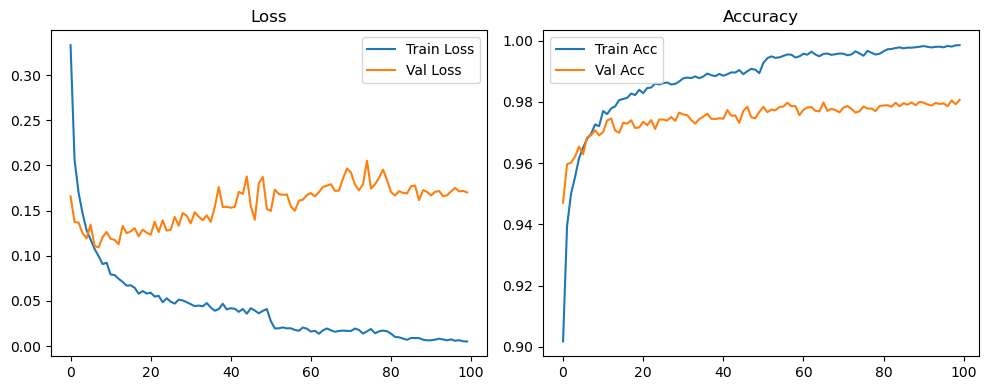

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5067, Acc: 0.8510 | Val Loss: 0.2048, Acc: 0.9384


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3471, Acc: 0.9006 | Val Loss: 0.1699, Acc: 0.9499


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3062, Acc: 0.9114 | Val Loss: 0.1492, Acc: 0.9558


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2771, Acc: 0.9206 | Val Loss: 0.1380, Acc: 0.9594


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2566, Acc: 0.9267 | Val Loss: 0.1361, Acc: 0.9630


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2475, Acc: 0.9288 | Val Loss: 0.1250, Acc: 0.9634


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2253, Acc: 0.9354 | Val Loss: 0.1208, Acc: 0.9643


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.2159, Acc: 0.9387 | Val Loss: 0.1215, Acc: 0.9635


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.2098, Acc: 0.9397 | Val Loss: 0.1275, Acc: 0.9633


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.2049, Acc: 0.9419 | Val Loss: 0.1125, Acc: 0.9678


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1997, Acc: 0.9423 | Val Loss: 0.1189, Acc: 0.9665


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1946, Acc: 0.9451 | Val Loss: 0.1070, Acc: 0.9706


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1856, Acc: 0.9465 | Val Loss: 0.1251, Acc: 0.9664


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1888, Acc: 0.9459 | Val Loss: 0.1136, Acc: 0.9674


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1748, Acc: 0.9505 | Val Loss: 0.1180, Acc: 0.9677


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1658, Acc: 0.9523 | Val Loss: 0.1152, Acc: 0.9702


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1712, Acc: 0.9525 | Val Loss: 0.1087, Acc: 0.9702


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1701, Acc: 0.9515 | Val Loss: 0.1115, Acc: 0.9680


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1659, Acc: 0.9534 | Val Loss: 0.1022, Acc: 0.9708


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1603, Acc: 0.9539 | Val Loss: 0.1056, Acc: 0.9718


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1622, Acc: 0.9539 | Val Loss: 0.1093, Acc: 0.9722


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9568 | Val Loss: 0.1088, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1520, Acc: 0.9567 | Val Loss: 0.1042, Acc: 0.9724


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1504, Acc: 0.9572 | Val Loss: 0.1100, Acc: 0.9722


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1461, Acc: 0.9583 | Val Loss: 0.1098, Acc: 0.9739


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1509, Acc: 0.9584 | Val Loss: 0.1058, Acc: 0.9734


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1441, Acc: 0.9592 | Val Loss: 0.1154, Acc: 0.9706


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1469, Acc: 0.9587 | Val Loss: 0.1157, Acc: 0.9712


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1427, Acc: 0.9601 | Val Loss: 0.1109, Acc: 0.9736


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1419, Acc: 0.9607 | Val Loss: 0.1076, Acc: 0.9728


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1396, Acc: 0.9604 | Val Loss: 0.1130, Acc: 0.9728


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1363, Acc: 0.9615 | Val Loss: 0.1101, Acc: 0.9736


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1402, Acc: 0.9615 | Val Loss: 0.1026, Acc: 0.9733


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1345, Acc: 0.9618 | Val Loss: 0.1080, Acc: 0.9725


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9634 | Val Loss: 0.1095, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1385, Acc: 0.9612 | Val Loss: 0.1142, Acc: 0.9720


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1267, Acc: 0.9635 | Val Loss: 0.1086, Acc: 0.9743


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1372, Acc: 0.9626 | Val Loss: 0.1130, Acc: 0.9720


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1275, Acc: 0.9636 | Val Loss: 0.1231, Acc: 0.9732


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1245, Acc: 0.9650 | Val Loss: 0.1206, Acc: 0.9718


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1339, Acc: 0.9642 | Val Loss: 0.1130, Acc: 0.9735


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1201, Acc: 0.9655 | Val Loss: 0.1149, Acc: 0.9718


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9653 | Val Loss: 0.1213, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1323, Acc: 0.9634 | Val Loss: 0.1087, Acc: 0.9748


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9651 | Val Loss: 0.1154, Acc: 0.9751


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1267, Acc: 0.9658 | Val Loss: 0.1141, Acc: 0.9738


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9645 | Val Loss: 0.1223, Acc: 0.9732


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1170, Acc: 0.9674 | Val Loss: 0.1183, Acc: 0.9733


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9666 | Val Loss: 0.1185, Acc: 0.9730


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1171, Acc: 0.9671 | Val Loss: 0.1194, Acc: 0.9743


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0959, Acc: 0.9734 | Val Loss: 0.1081, Acc: 0.9762


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0863, Acc: 0.9746 | Val Loss: 0.1092, Acc: 0.9774


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0816, Acc: 0.9760 | Val Loss: 0.1067, Acc: 0.9777


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0896, Acc: 0.9746 | Val Loss: 0.1032, Acc: 0.9752


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0821, Acc: 0.9755 | Val Loss: 0.1046, Acc: 0.9760


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0795, Acc: 0.9773 | Val Loss: 0.1033, Acc: 0.9756


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0817, Acc: 0.9760 | Val Loss: 0.1035, Acc: 0.9766


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0725, Acc: 0.9779 | Val Loss: 0.1147, Acc: 0.9753


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9778 | Val Loss: 0.1023, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0775, Acc: 0.9766 | Val Loss: 0.1027, Acc: 0.9771


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0734, Acc: 0.9778 | Val Loss: 0.1125, Acc: 0.9738


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9775 | Val Loss: 0.1036, Acc: 0.9766


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0754, Acc: 0.9778 | Val Loss: 0.1030, Acc: 0.9770


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0732, Acc: 0.9773 | Val Loss: 0.1003, Acc: 0.9770


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0686, Acc: 0.9790 | Val Loss: 0.1082, Acc: 0.9765


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0805, Acc: 0.9775 | Val Loss: 0.0981, Acc: 0.9782


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0728, Acc: 0.9773 | Val Loss: 0.1053, Acc: 0.9767


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9788 | Val Loss: 0.1035, Acc: 0.9768


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0745, Acc: 0.9783 | Val Loss: 0.1068, Acc: 0.9754


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0729, Acc: 0.9790 | Val Loss: 0.1127, Acc: 0.9736


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0714, Acc: 0.9791 | Val Loss: 0.1083, Acc: 0.9765


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9786 | Val Loss: 0.1083, Acc: 0.9768


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9780 | Val Loss: 0.1098, Acc: 0.9759


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0751, Acc: 0.9784 | Val Loss: 0.1036, Acc: 0.9767


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9794 | Val Loss: 0.1110, Acc: 0.9768


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0728, Acc: 0.9792 | Val Loss: 0.1115, Acc: 0.9759


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9798 | Val Loss: 0.1095, Acc: 0.9770


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9783 | Val Loss: 0.1020, Acc: 0.9777


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0711, Acc: 0.9800 | Val Loss: 0.1101, Acc: 0.9759


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9788 | Val Loss: 0.1041, Acc: 0.9772


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0633, Acc: 0.9813 | Val Loss: 0.1026, Acc: 0.9768


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0563, Acc: 0.9827 | Val Loss: 0.1091, Acc: 0.9772


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0579, Acc: 0.9825 | Val Loss: 0.1045, Acc: 0.9781


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0511, Acc: 0.9848 | Val Loss: 0.1021, Acc: 0.9780


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9848 | Val Loss: 0.1050, Acc: 0.9776


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0477, Acc: 0.9860 | Val Loss: 0.1069, Acc: 0.9778


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0500, Acc: 0.9847 | Val Loss: 0.1034, Acc: 0.9770


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9863 | Val Loss: 0.1038, Acc: 0.9784


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0475, Acc: 0.9855 | Val Loss: 0.1077, Acc: 0.9778


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9857 | Val Loss: 0.0960, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0486, Acc: 0.9849 | Val Loss: 0.0972, Acc: 0.9785


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0479, Acc: 0.9854 | Val Loss: 0.0938, Acc: 0.9792


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9854 | Val Loss: 0.0945, Acc: 0.9793


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0465, Acc: 0.9850 | Val Loss: 0.0949, Acc: 0.9797


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9864 | Val Loss: 0.0991, Acc: 0.9782


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0455, Acc: 0.9858 | Val Loss: 0.0975, Acc: 0.9792


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9869 | Val Loss: 0.0996, Acc: 0.9786


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9879 | Val Loss: 0.0990, Acc: 0.9786


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0430, Acc: 0.9867 | Val Loss: 0.1013, Acc: 0.9788


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9859 | Val Loss: 0.0976, Acc: 0.9785


Final Test Loss: 0.0878 Accuracy: 0.9810


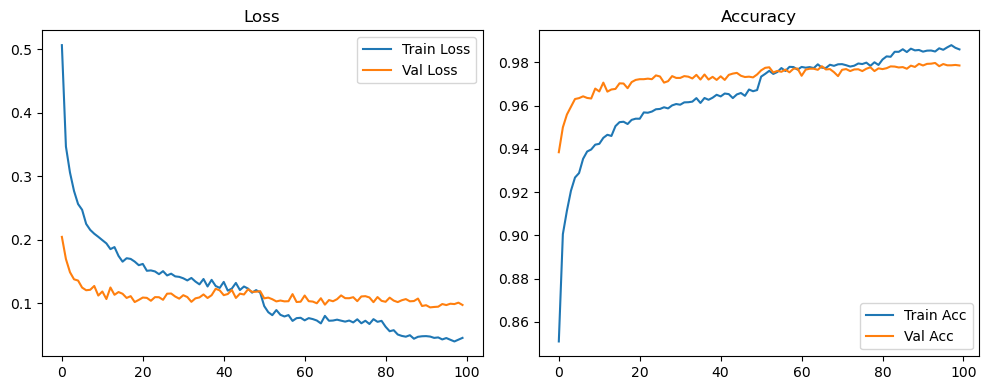

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2779, Acc: 0.9166 | Val Loss: 0.1510, Acc: 0.9569


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1539, Acc: 0.9535 | Val Loss: 0.1325, Acc: 0.9602


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1183, Acc: 0.9654 | Val Loss: 0.1396, Acc: 0.9609


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9692 | Val Loss: 0.1089, Acc: 0.9659


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9751 | Val Loss: 0.1256, Acc: 0.9667


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9779 | Val Loss: 0.1186, Acc: 0.9688


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9819 | Val Loss: 0.1127, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9829 | Val Loss: 0.1254, Acc: 0.9669


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9848 | Val Loss: 0.1200, Acc: 0.9713


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9857 | Val Loss: 0.1250, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 0.1192, Acc: 0.9728


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9888 | Val Loss: 0.1147, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9897 | Val Loss: 0.1317, Acc: 0.9727


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9890 | Val Loss: 0.1172, Acc: 0.9737


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9910 | Val Loss: 0.1298, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9907 | Val Loss: 0.1450, Acc: 0.9704


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9909 | Val Loss: 0.1167, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9930 | Val Loss: 0.1357, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9924 | Val Loss: 0.1519, Acc: 0.9719


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.1642, Acc: 0.9699


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.1405, Acc: 0.9733


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9930 | Val Loss: 0.1345, Acc: 0.9757


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9939 | Val Loss: 0.1422, Acc: 0.9740


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9934 | Val Loss: 0.1521, Acc: 0.9728


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9941 | Val Loss: 0.1386, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9938 | Val Loss: 0.1313, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9937 | Val Loss: 0.1361, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.1452, Acc: 0.9761


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9940 | Val Loss: 0.1637, Acc: 0.9747


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9945 | Val Loss: 0.1339, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9952 | Val Loss: 0.1449, Acc: 0.9747


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9954 | Val Loss: 0.1594, Acc: 0.9748


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9946 | Val Loss: 0.1488, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9961 | Val Loss: 0.1720, Acc: 0.9732


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9949 | Val Loss: 0.1550, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.1711, Acc: 0.9734


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9953 | Val Loss: 0.1555, Acc: 0.9777


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9951 | Val Loss: 0.1509, Acc: 0.9775


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9957 | Val Loss: 0.1634, Acc: 0.9759


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9954 | Val Loss: 0.1562, Acc: 0.9739


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9966 | Val Loss: 0.1740, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9960 | Val Loss: 0.1622, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9963 | Val Loss: 0.1823, Acc: 0.9745


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9961 | Val Loss: 0.1640, Acc: 0.9754


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9961 | Val Loss: 0.1738, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9960 | Val Loss: 0.1815, Acc: 0.9738


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.1886, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9963 | Val Loss: 0.1827, Acc: 0.9751


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9964 | Val Loss: 0.1889, Acc: 0.9727


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9966 | Val Loss: 0.1894, Acc: 0.9740


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9981 | Val Loss: 0.1476, Acc: 0.9796


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1473, Acc: 0.9801


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1495, Acc: 0.9804


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1472, Acc: 0.9816


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1512, Acc: 0.9803


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1566, Acc: 0.9800


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1626, Acc: 0.9809


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1657, Acc: 0.9794


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1674, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1713, Acc: 0.9809


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1799, Acc: 0.9795


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1758, Acc: 0.9808


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1721, Acc: 0.9808


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1749, Acc: 0.9806


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1836, Acc: 0.9811


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1772, Acc: 0.9805


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1877, Acc: 0.9799


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1854, Acc: 0.9818


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1803, Acc: 0.9810


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1892, Acc: 0.9820


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1912, Acc: 0.9807


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2025, Acc: 0.9809


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1915, Acc: 0.9813


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1989, Acc: 0.9824


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2067, Acc: 0.9804


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.2062, Acc: 0.9808


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2036, Acc: 0.9807


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2095, Acc: 0.9808


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2097, Acc: 0.9809


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.2130, Acc: 0.9806


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.2109, Acc: 0.9813


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2038, Acc: 0.9813


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2096, Acc: 0.9813


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2115, Acc: 0.9811


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2156, Acc: 0.9808


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2147, Acc: 0.9798


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2129, Acc: 0.9799


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2065, Acc: 0.9812


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2081, Acc: 0.9811


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2093, Acc: 0.9814


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2052, Acc: 0.9815


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2114, Acc: 0.9806


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2157, Acc: 0.9809


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2122, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2071, Acc: 0.9820


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2070, Acc: 0.9813


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2129, Acc: 0.9808


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2113, Acc: 0.9812


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2267, Acc: 0.9799


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2217, Acc: 0.9812


Final Test Loss: 0.2118 Accuracy: 0.9814


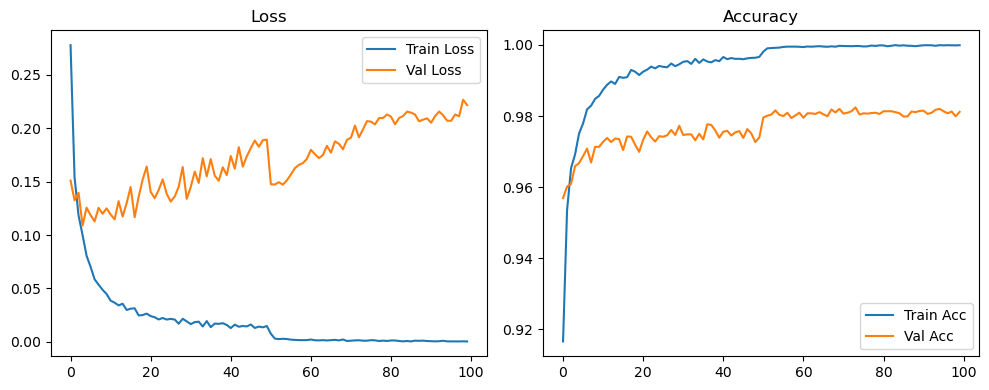

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3333, Acc: 0.9018 | Val Loss: 0.1658, Acc: 0.9471


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2063, Acc: 0.9395 | Val Loss: 0.1373, Acc: 0.9597


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1699, Acc: 0.9500 | Val Loss: 0.1368, Acc: 0.9602


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9555 | Val Loss: 0.1250, Acc: 0.9622


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9617 | Val Loss: 0.1193, Acc: 0.9654


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1180, Acc: 0.9650 | Val Loss: 0.1345, Acc: 0.9629


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1074, Acc: 0.9680 | Val Loss: 0.1108, Acc: 0.9684


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0997, Acc: 0.9695 | Val Loss: 0.1094, Acc: 0.9692


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0908, Acc: 0.9726 | Val Loss: 0.1206, Acc: 0.9708


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9721 | Val Loss: 0.1264, Acc: 0.9691


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9770 | Val Loss: 0.1188, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9760 | Val Loss: 0.1175, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0745, Acc: 0.9779 | Val Loss: 0.1129, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9785 | Val Loss: 0.1330, Acc: 0.9707


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9806 | Val Loss: 0.1251, Acc: 0.9699


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0673, Acc: 0.9810 | Val Loss: 0.1269, Acc: 0.9732


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9813 | Val Loss: 0.1306, Acc: 0.9729


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9827 | Val Loss: 0.1215, Acc: 0.9740


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9822 | Val Loss: 0.1289, Acc: 0.9715


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9840 | Val Loss: 0.1257, Acc: 0.9717


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9829 | Val Loss: 0.1233, Acc: 0.9735


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9845 | Val Loss: 0.1377, Acc: 0.9724


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9847 | Val Loss: 0.1263, Acc: 0.9741


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9860 | Val Loss: 0.1392, Acc: 0.9712


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9857 | Val Loss: 0.1279, Acc: 0.9742


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9861 | Val Loss: 0.1287, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9864 | Val Loss: 0.1430, Acc: 0.9739


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9857 | Val Loss: 0.1334, Acc: 0.9751


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9859 | Val Loss: 0.1474, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9867 | Val Loss: 0.1443, Acc: 0.9765


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9877 | Val Loss: 0.1359, Acc: 0.9759


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9879 | Val Loss: 0.1483, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9878 | Val Loss: 0.1433, Acc: 0.9741


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9884 | Val Loss: 0.1393, Acc: 0.9729


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9878 | Val Loss: 0.1448, Acc: 0.9744


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9883 | Val Loss: 0.1376, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9892 | Val Loss: 0.1539, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9888 | Val Loss: 0.1762, Acc: 0.9745


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9884 | Val Loss: 0.1539, Acc: 0.9744


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9891 | Val Loss: 0.1543, Acc: 0.9747


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9886 | Val Loss: 0.1532, Acc: 0.9745


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9890 | Val Loss: 0.1542, Acc: 0.9773


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9896 | Val Loss: 0.1708, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9896 | Val Loss: 0.1685, Acc: 0.9756


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9904 | Val Loss: 0.1878, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9891 | Val Loss: 0.1548, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9900 | Val Loss: 0.1399, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9908 | Val Loss: 0.1804, Acc: 0.9750


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9905 | Val Loss: 0.1873, Acc: 0.9747


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9894 | Val Loss: 0.1518, Acc: 0.9768


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9932 | Val Loss: 0.1426, Acc: 0.9776


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9948 | Val Loss: 0.1485, Acc: 0.9773


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.1520, Acc: 0.9788


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9955 | Val Loss: 0.1519, Acc: 0.9786


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.1498, Acc: 0.9800


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9958 | Val Loss: 0.1407, Acc: 0.9792


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9969 | Val Loss: 0.1445, Acc: 0.9802


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9965 | Val Loss: 0.1545, Acc: 0.9796


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9964 | Val Loss: 0.1609, Acc: 0.9778


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1550, Acc: 0.9797


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1598, Acc: 0.9789


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1605, Acc: 0.9798


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1652, Acc: 0.9792


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9966 | Val Loss: 0.1596, Acc: 0.9788


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9972 | Val Loss: 0.1650, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9969 | Val Loss: 0.1651, Acc: 0.9788


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.1570, Acc: 0.9784


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.1527, Acc: 0.9794


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1623, Acc: 0.9791


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1697, Acc: 0.9792


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9977 | Val Loss: 0.1765, Acc: 0.9782


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9972 | Val Loss: 0.1677, Acc: 0.9797


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.1592, Acc: 0.9789


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9975 | Val Loss: 0.1614, Acc: 0.9798


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1629, Acc: 0.9800


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9976 | Val Loss: 0.1555, Acc: 0.9798


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1582, Acc: 0.9792


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9976 | Val Loss: 0.1575, Acc: 0.9798


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.1571, Acc: 0.9808


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1632, Acc: 0.9792


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9978 | Val Loss: 0.1633, Acc: 0.9803


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1640, Acc: 0.9798


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9976 | Val Loss: 0.1682, Acc: 0.9798


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1577, Acc: 0.9798


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1595, Acc: 0.9804


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1685, Acc: 0.9798


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1636, Acc: 0.9792


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.1605, Acc: 0.9808


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.1696, Acc: 0.9794


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1600, Acc: 0.9800


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1640, Acc: 0.9791


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.1611, Acc: 0.9792


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1676, Acc: 0.9790


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1642, Acc: 0.9799


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1601, Acc: 0.9804


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1591, Acc: 0.9788


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1644, Acc: 0.9792


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1682, Acc: 0.9792


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1634, Acc: 0.9789


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1693, Acc: 0.9799


Final Test Loss: 0.1479 Accuracy: 0.9831


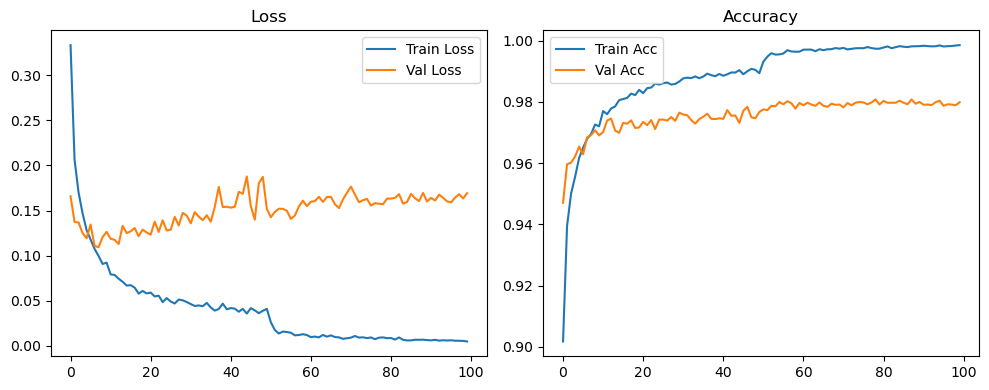

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5067, Acc: 0.8510 | Val Loss: 0.2048, Acc: 0.9384


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3471, Acc: 0.9006 | Val Loss: 0.1699, Acc: 0.9499


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3062, Acc: 0.9114 | Val Loss: 0.1492, Acc: 0.9558


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2771, Acc: 0.9206 | Val Loss: 0.1380, Acc: 0.9594


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2566, Acc: 0.9267 | Val Loss: 0.1361, Acc: 0.9630


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2475, Acc: 0.9288 | Val Loss: 0.1250, Acc: 0.9634


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2253, Acc: 0.9354 | Val Loss: 0.1208, Acc: 0.9643


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.2159, Acc: 0.9387 | Val Loss: 0.1215, Acc: 0.9635


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.2098, Acc: 0.9397 | Val Loss: 0.1275, Acc: 0.9633


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.2049, Acc: 0.9419 | Val Loss: 0.1125, Acc: 0.9678


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1997, Acc: 0.9423 | Val Loss: 0.1189, Acc: 0.9665


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1946, Acc: 0.9451 | Val Loss: 0.1070, Acc: 0.9706


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1856, Acc: 0.9465 | Val Loss: 0.1251, Acc: 0.9664


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1888, Acc: 0.9459 | Val Loss: 0.1136, Acc: 0.9674


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1748, Acc: 0.9505 | Val Loss: 0.1180, Acc: 0.9677


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1658, Acc: 0.9523 | Val Loss: 0.1152, Acc: 0.9702


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1712, Acc: 0.9525 | Val Loss: 0.1087, Acc: 0.9702


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1701, Acc: 0.9515 | Val Loss: 0.1115, Acc: 0.9680


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1659, Acc: 0.9534 | Val Loss: 0.1022, Acc: 0.9708


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1603, Acc: 0.9539 | Val Loss: 0.1056, Acc: 0.9718


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1622, Acc: 0.9539 | Val Loss: 0.1093, Acc: 0.9722


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9568 | Val Loss: 0.1088, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1520, Acc: 0.9567 | Val Loss: 0.1042, Acc: 0.9724


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1504, Acc: 0.9572 | Val Loss: 0.1100, Acc: 0.9722


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1461, Acc: 0.9583 | Val Loss: 0.1098, Acc: 0.9739


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1509, Acc: 0.9584 | Val Loss: 0.1058, Acc: 0.9734


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1441, Acc: 0.9592 | Val Loss: 0.1154, Acc: 0.9706


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1469, Acc: 0.9587 | Val Loss: 0.1157, Acc: 0.9712


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1427, Acc: 0.9601 | Val Loss: 0.1109, Acc: 0.9736


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1419, Acc: 0.9607 | Val Loss: 0.1076, Acc: 0.9728


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1396, Acc: 0.9604 | Val Loss: 0.1130, Acc: 0.9728


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1363, Acc: 0.9615 | Val Loss: 0.1101, Acc: 0.9736


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1402, Acc: 0.9615 | Val Loss: 0.1026, Acc: 0.9733


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1345, Acc: 0.9618 | Val Loss: 0.1080, Acc: 0.9725


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9634 | Val Loss: 0.1095, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1385, Acc: 0.9612 | Val Loss: 0.1142, Acc: 0.9720


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1267, Acc: 0.9635 | Val Loss: 0.1086, Acc: 0.9743


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1372, Acc: 0.9626 | Val Loss: 0.1130, Acc: 0.9720


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1275, Acc: 0.9636 | Val Loss: 0.1231, Acc: 0.9732


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1245, Acc: 0.9650 | Val Loss: 0.1206, Acc: 0.9718


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1339, Acc: 0.9642 | Val Loss: 0.1130, Acc: 0.9735


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1201, Acc: 0.9655 | Val Loss: 0.1149, Acc: 0.9718


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9653 | Val Loss: 0.1213, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1323, Acc: 0.9634 | Val Loss: 0.1087, Acc: 0.9748


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9651 | Val Loss: 0.1154, Acc: 0.9751


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1267, Acc: 0.9658 | Val Loss: 0.1141, Acc: 0.9738


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9645 | Val Loss: 0.1223, Acc: 0.9732


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1170, Acc: 0.9674 | Val Loss: 0.1183, Acc: 0.9733


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9666 | Val Loss: 0.1185, Acc: 0.9730


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1171, Acc: 0.9671 | Val Loss: 0.1194, Acc: 0.9743


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0932, Acc: 0.9731 | Val Loss: 0.1103, Acc: 0.9768


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0824, Acc: 0.9753 | Val Loss: 0.1124, Acc: 0.9771


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0763, Acc: 0.9773 | Val Loss: 0.1088, Acc: 0.9766


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0810, Acc: 0.9777 | Val Loss: 0.1041, Acc: 0.9765


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0708, Acc: 0.9785 | Val Loss: 0.1048, Acc: 0.9761


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0699, Acc: 0.9780 | Val Loss: 0.1007, Acc: 0.9764


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0678, Acc: 0.9799 | Val Loss: 0.1005, Acc: 0.9779


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0613, Acc: 0.9811 | Val Loss: 0.1010, Acc: 0.9772


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0625, Acc: 0.9816 | Val Loss: 0.0965, Acc: 0.9773


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0614, Acc: 0.9806 | Val Loss: 0.0967, Acc: 0.9782


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0590, Acc: 0.9815 | Val Loss: 0.1034, Acc: 0.9747


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0601, Acc: 0.9818 | Val Loss: 0.0995, Acc: 0.9771


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0589, Acc: 0.9813 | Val Loss: 0.0990, Acc: 0.9792


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0590, Acc: 0.9819 | Val Loss: 0.0965, Acc: 0.9791


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0534, Acc: 0.9833 | Val Loss: 0.0948, Acc: 0.9776


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0608, Acc: 0.9819 | Val Loss: 0.0959, Acc: 0.9767


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0560, Acc: 0.9826 | Val Loss: 0.0982, Acc: 0.9773


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9825 | Val Loss: 0.0984, Acc: 0.9766


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0570, Acc: 0.9822 | Val Loss: 0.0962, Acc: 0.9768


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9839 | Val Loss: 0.1052, Acc: 0.9762


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0555, Acc: 0.9830 | Val Loss: 0.0997, Acc: 0.9772


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9824 | Val Loss: 0.0982, Acc: 0.9774


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9841 | Val Loss: 0.0973, Acc: 0.9776


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0555, Acc: 0.9830 | Val Loss: 0.1015, Acc: 0.9771


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0515, Acc: 0.9839 | Val Loss: 0.1018, Acc: 0.9772


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9840 | Val Loss: 0.1003, Acc: 0.9785


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0476, Acc: 0.9849 | Val Loss: 0.1032, Acc: 0.9768


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0561, Acc: 0.9831 | Val Loss: 0.1001, Acc: 0.9777


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0542, Acc: 0.9840 | Val Loss: 0.0940, Acc: 0.9792


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0537, Acc: 0.9832 | Val Loss: 0.0978, Acc: 0.9782


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0523, Acc: 0.9838 | Val Loss: 0.0970, Acc: 0.9782


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0493, Acc: 0.9847 | Val Loss: 0.0993, Acc: 0.9775


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0506, Acc: 0.9837 | Val Loss: 0.0939, Acc: 0.9785


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9862 | Val Loss: 0.0973, Acc: 0.9789


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0448, Acc: 0.9856 | Val Loss: 0.1011, Acc: 0.9780


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0447, Acc: 0.9861 | Val Loss: 0.0979, Acc: 0.9780


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.1020, Acc: 0.9776


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9857 | Val Loss: 0.0954, Acc: 0.9791


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9852 | Val Loss: 0.1002, Acc: 0.9775


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9860 | Val Loss: 0.0908, Acc: 0.9786


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0470, Acc: 0.9849 | Val Loss: 0.0891, Acc: 0.9797


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0468, Acc: 0.9856 | Val Loss: 0.0928, Acc: 0.9788


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9863 | Val Loss: 0.0951, Acc: 0.9790


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0469, Acc: 0.9852 | Val Loss: 0.0954, Acc: 0.9790


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0449, Acc: 0.9858 | Val Loss: 0.0963, Acc: 0.9789


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0470, Acc: 0.9854 | Val Loss: 0.0967, Acc: 0.9788


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9867 | Val Loss: 0.0964, Acc: 0.9784


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0406, Acc: 0.9875 | Val Loss: 0.0960, Acc: 0.9784


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0442, Acc: 0.9862 | Val Loss: 0.0998, Acc: 0.9779


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 0.0974, Acc: 0.9788


Final Test Loss: 0.0859 Accuracy: 0.9805


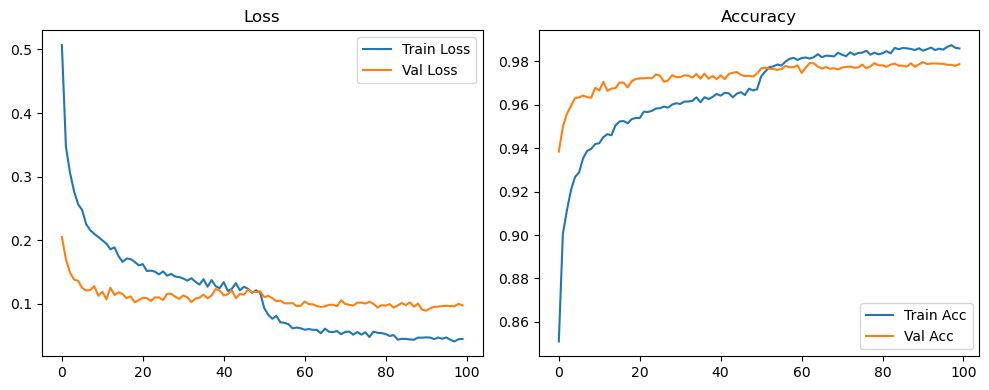

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2631, Acc: 0.9218 | Val Loss: 0.1451, Acc: 0.9571


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1442, Acc: 0.9565 | Val Loss: 0.1227, Acc: 0.9623


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1130, Acc: 0.9657 | Val Loss: 0.1378, Acc: 0.9597


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0936, Acc: 0.9711 | Val Loss: 0.1207, Acc: 0.9652


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9755 | Val Loss: 0.1170, Acc: 0.9682


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0687, Acc: 0.9774 | Val Loss: 0.1188, Acc: 0.9688


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9820 | Val Loss: 0.1127, Acc: 0.9684


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9844 | Val Loss: 0.1271, Acc: 0.9663


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9843 | Val Loss: 0.1342, Acc: 0.9667


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9857 | Val Loss: 0.1211, Acc: 0.9708


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9879 | Val Loss: 0.1038, Acc: 0.9747


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9898 | Val Loss: 0.1238, Acc: 0.9718


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9896 | Val Loss: 0.1140, Acc: 0.9735


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.1253, Acc: 0.9726


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9914 | Val Loss: 0.1442, Acc: 0.9688


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.1260, Acc: 0.9732


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.1252, Acc: 0.9722


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.1217, Acc: 0.9738


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.1210, Acc: 0.9719


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.1191, Acc: 0.9753


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9939 | Val Loss: 0.1330, Acc: 0.9739


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.1424, Acc: 0.9723


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.1389, Acc: 0.9737


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9943 | Val Loss: 0.1455, Acc: 0.9743


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9947 | Val Loss: 0.1336, Acc: 0.9758


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1328, Acc: 0.9748


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1666, Acc: 0.9719


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.1441, Acc: 0.9739


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.1617, Acc: 0.9732


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.1432, Acc: 0.9740


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9953 | Val Loss: 0.1458, Acc: 0.9742


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.1422, Acc: 0.9738


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.1402, Acc: 0.9750


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.1587, Acc: 0.9732


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1632, Acc: 0.9754


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9957 | Val Loss: 0.1665, Acc: 0.9738


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9967 | Val Loss: 0.1661, Acc: 0.9730


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.1534, Acc: 0.9766


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9964 | Val Loss: 0.1687, Acc: 0.9754


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9959 | Val Loss: 0.1522, Acc: 0.9747


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9967 | Val Loss: 0.1650, Acc: 0.9750


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9962 | Val Loss: 0.1647, Acc: 0.9738


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.1586, Acc: 0.9769


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.1548, Acc: 0.9762


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9966 | Val Loss: 0.1720, Acc: 0.9742


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9969 | Val Loss: 0.1548, Acc: 0.9756


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9967 | Val Loss: 0.1601, Acc: 0.9754


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9963 | Val Loss: 0.1657, Acc: 0.9749


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.1700, Acc: 0.9758


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1842, Acc: 0.9734


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1730, Acc: 0.9756


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1775, Acc: 0.9752


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9970 | Val Loss: 0.1871, Acc: 0.9742


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1835, Acc: 0.9755


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 0.1823, Acc: 0.9760


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9968 | Val Loss: 0.1556, Acc: 0.9763


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1810, Acc: 0.9759


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.2008, Acc: 0.9752


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9969 | Val Loss: 0.1736, Acc: 0.9759


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9973 | Val Loss: 0.1780, Acc: 0.9748


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1948, Acc: 0.9720


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.2001, Acc: 0.9747


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.2005, Acc: 0.9743


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9976 | Val Loss: 0.1888, Acc: 0.9754


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9974 | Val Loss: 0.1853, Acc: 0.9764


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9972 | Val Loss: 0.1843, Acc: 0.9767


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9978 | Val Loss: 0.1940, Acc: 0.9743


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9975 | Val Loss: 0.1929, Acc: 0.9755


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.1845, Acc: 0.9755


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.1914, Acc: 0.9759


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9975 | Val Loss: 0.1948, Acc: 0.9759


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9977 | Val Loss: 0.1852, Acc: 0.9758


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9981 | Val Loss: 0.1736, Acc: 0.9766


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1687, Acc: 0.9776


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.1719, Acc: 0.9767


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1842, Acc: 0.9767


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9977 | Val Loss: 0.1794, Acc: 0.9763


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1947, Acc: 0.9756


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.2047, Acc: 0.9757


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.2125, Acc: 0.9765


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9974 | Val Loss: 0.2040, Acc: 0.9752


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.2060, Acc: 0.9761


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.2197, Acc: 0.9758


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.2341, Acc: 0.9716


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9978 | Val Loss: 0.2071, Acc: 0.9748


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9981 | Val Loss: 0.2235, Acc: 0.9756


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.2254, Acc: 0.9749


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.2330, Acc: 0.9752


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.2085, Acc: 0.9776


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9977 | Val Loss: 0.2084, Acc: 0.9766


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9979 | Val Loss: 0.2178, Acc: 0.9750


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.2172, Acc: 0.9759


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9984 | Val Loss: 0.1957, Acc: 0.9768


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9987 | Val Loss: 0.2075, Acc: 0.9762


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.2185, Acc: 0.9771


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9981 | Val Loss: 0.2087, Acc: 0.9767


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9983 | Val Loss: 0.2163, Acc: 0.9748


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9979 | Val Loss: 0.2219, Acc: 0.9760


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.2208, Acc: 0.9767


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9983 | Val Loss: 0.2043, Acc: 0.9781


Final Test Loss: 0.1806 Accuracy: 0.9787


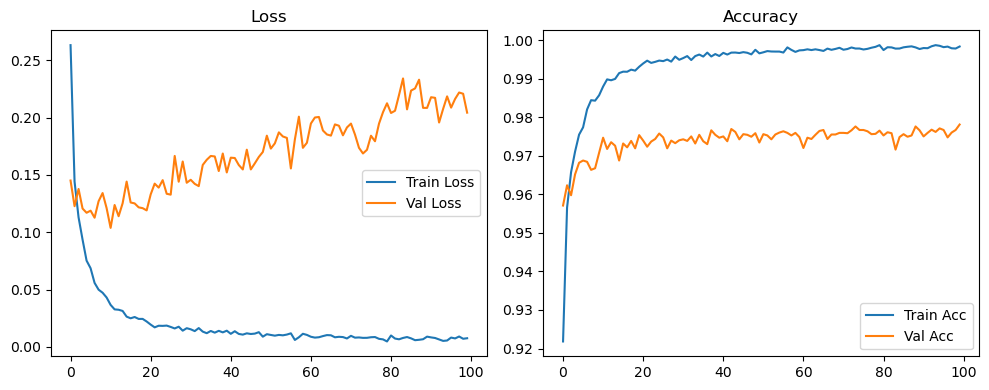

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3123, Acc: 0.9058 | Val Loss: 0.1663, Acc: 0.9498


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1870, Acc: 0.9446 | Val Loss: 0.1324, Acc: 0.9587


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1561, Acc: 0.9526 | Val Loss: 0.1328, Acc: 0.9583


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1360, Acc: 0.9582 | Val Loss: 0.1134, Acc: 0.9653


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1142, Acc: 0.9638 | Val Loss: 0.1044, Acc: 0.9685


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1055, Acc: 0.9667 | Val Loss: 0.1200, Acc: 0.9648


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0958, Acc: 0.9701 | Val Loss: 0.1039, Acc: 0.9699


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0882, Acc: 0.9733 | Val Loss: 0.1079, Acc: 0.9683


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0835, Acc: 0.9735 | Val Loss: 0.1077, Acc: 0.9715


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0778, Acc: 0.9752 | Val Loss: 0.1047, Acc: 0.9731


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9786 | Val Loss: 0.1076, Acc: 0.9704


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0701, Acc: 0.9781 | Val Loss: 0.1152, Acc: 0.9718


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9803 | Val Loss: 0.1142, Acc: 0.9732


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9801 | Val Loss: 0.1047, Acc: 0.9742


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0586, Acc: 0.9812 | Val Loss: 0.1220, Acc: 0.9721


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9834 | Val Loss: 0.1049, Acc: 0.9749


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9828 | Val Loss: 0.1078, Acc: 0.9747


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9841 | Val Loss: 0.1123, Acc: 0.9758


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9849 | Val Loss: 0.1064, Acc: 0.9747


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9850 | Val Loss: 0.1130, Acc: 0.9738


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9863 | Val Loss: 0.1195, Acc: 0.9737


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9862 | Val Loss: 0.1158, Acc: 0.9744


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9870 | Val Loss: 0.1172, Acc: 0.9738


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9872 | Val Loss: 0.1249, Acc: 0.9741


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9869 | Val Loss: 0.1177, Acc: 0.9730


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9886 | Val Loss: 0.1115, Acc: 0.9759


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9877 | Val Loss: 0.1281, Acc: 0.9751


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9879 | Val Loss: 0.1207, Acc: 0.9756


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9880 | Val Loss: 0.1192, Acc: 0.9739


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9893 | Val Loss: 0.1217, Acc: 0.9767


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9884 | Val Loss: 0.1235, Acc: 0.9745


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9899 | Val Loss: 0.1269, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9890 | Val Loss: 0.1192, Acc: 0.9763


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.1266, Acc: 0.9760


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9896 | Val Loss: 0.1239, Acc: 0.9743


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9903 | Val Loss: 0.1296, Acc: 0.9769


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9894 | Val Loss: 0.1464, Acc: 0.9732


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9910 | Val Loss: 0.1293, Acc: 0.9756


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9901 | Val Loss: 0.1312, Acc: 0.9758


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9904 | Val Loss: 0.1240, Acc: 0.9762


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9907 | Val Loss: 0.1165, Acc: 0.9774


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9912 | Val Loss: 0.1476, Acc: 0.9779


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9907 | Val Loss: 0.1404, Acc: 0.9766


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9909 | Val Loss: 0.1496, Acc: 0.9755


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9910 | Val Loss: 0.1632, Acc: 0.9734


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9918 | Val Loss: 0.1564, Acc: 0.9742


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9919 | Val Loss: 0.1363, Acc: 0.9772


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9928 | Val Loss: 0.1480, Acc: 0.9767


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9919 | Val Loss: 0.1497, Acc: 0.9772


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9921 | Val Loss: 0.1346, Acc: 0.9777


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9919 | Val Loss: 0.1438, Acc: 0.9751


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9919 | Val Loss: 0.1439, Acc: 0.9767


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9926 | Val Loss: 0.1365, Acc: 0.9752


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9925 | Val Loss: 0.1523, Acc: 0.9752


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9922 | Val Loss: 0.1500, Acc: 0.9758


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9911 | Val Loss: 0.1544, Acc: 0.9755


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9922 | Val Loss: 0.1484, Acc: 0.9758


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9931 | Val Loss: 0.1521, Acc: 0.9749


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9920 | Val Loss: 0.1406, Acc: 0.9761


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9923 | Val Loss: 0.1419, Acc: 0.9764


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9934 | Val Loss: 0.1449, Acc: 0.9769


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9938 | Val Loss: 0.1409, Acc: 0.9780


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9934 | Val Loss: 0.1584, Acc: 0.9752


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9927 | Val Loss: 0.1383, Acc: 0.9770


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9933 | Val Loss: 0.1667, Acc: 0.9754


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9928 | Val Loss: 0.1506, Acc: 0.9777


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9930 | Val Loss: 0.1611, Acc: 0.9749


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9938 | Val Loss: 0.1654, Acc: 0.9757


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9939 | Val Loss: 0.1810, Acc: 0.9745


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9940 | Val Loss: 0.2122, Acc: 0.9722


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9936 | Val Loss: 0.1732, Acc: 0.9749


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9932 | Val Loss: 0.1587, Acc: 0.9769


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9936 | Val Loss: 0.1556, Acc: 0.9760


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9933 | Val Loss: 0.1432, Acc: 0.9774


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9941 | Val Loss: 0.1541, Acc: 0.9793


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9938 | Val Loss: 0.1496, Acc: 0.9773


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9938 | Val Loss: 0.1602, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.1586, Acc: 0.9771


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9939 | Val Loss: 0.1473, Acc: 0.9782


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9937 | Val Loss: 0.1565, Acc: 0.9772


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9940 | Val Loss: 0.1635, Acc: 0.9771


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9937 | Val Loss: 0.1478, Acc: 0.9768


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9937 | Val Loss: 0.1522, Acc: 0.9781


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9944 | Val Loss: 0.1539, Acc: 0.9768


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9941 | Val Loss: 0.1700, Acc: 0.9768


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9945 | Val Loss: 0.1649, Acc: 0.9782


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9935 | Val Loss: 0.1607, Acc: 0.9776


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9942 | Val Loss: 0.1638, Acc: 0.9764


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9945 | Val Loss: 0.1749, Acc: 0.9734


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9937 | Val Loss: 0.1488, Acc: 0.9769


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9949 | Val Loss: 0.1535, Acc: 0.9773


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9950 | Val Loss: 0.1850, Acc: 0.9768


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9940 | Val Loss: 0.1751, Acc: 0.9752


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9941 | Val Loss: 0.1498, Acc: 0.9787


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9941 | Val Loss: 0.1725, Acc: 0.9752


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9948 | Val Loss: 0.1600, Acc: 0.9772


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9951 | Val Loss: 0.1587, Acc: 0.9762


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9939 | Val Loss: 0.1703, Acc: 0.9752


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9946 | Val Loss: 0.1777, Acc: 0.9765


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9957 | Val Loss: 0.1746, Acc: 0.9778


Final Test Loss: 0.1637 Accuracy: 0.9791


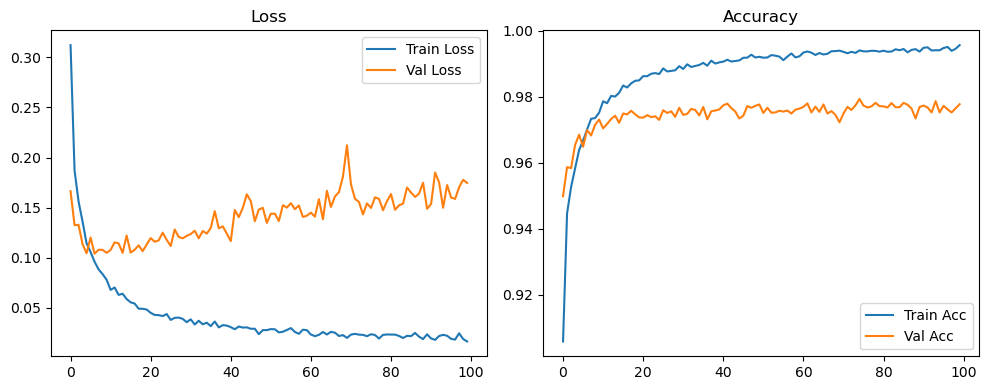

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4658, Acc: 0.8635 | Val Loss: 0.1994, Acc: 0.9410


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3169, Acc: 0.9082 | Val Loss: 0.1588, Acc: 0.9514


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2770, Acc: 0.9195 | Val Loss: 0.1398, Acc: 0.9574


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2493, Acc: 0.9268 | Val Loss: 0.1316, Acc: 0.9613


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2332, Acc: 0.9328 | Val Loss: 0.1235, Acc: 0.9653


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2167, Acc: 0.9366 | Val Loss: 0.1224, Acc: 0.9644


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2046, Acc: 0.9403 | Val Loss: 0.1187, Acc: 0.9653


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1901, Acc: 0.9434 | Val Loss: 0.1114, Acc: 0.9661


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1839, Acc: 0.9445 | Val Loss: 0.1171, Acc: 0.9666


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1826, Acc: 0.9463 | Val Loss: 0.1094, Acc: 0.9686


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1732, Acc: 0.9489 | Val Loss: 0.1076, Acc: 0.9694


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1714, Acc: 0.9489 | Val Loss: 0.1055, Acc: 0.9699


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1580, Acc: 0.9521 | Val Loss: 0.1014, Acc: 0.9718


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1617, Acc: 0.9528 | Val Loss: 0.1025, Acc: 0.9711


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1510, Acc: 0.9549 | Val Loss: 0.1050, Acc: 0.9701


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1475, Acc: 0.9565 | Val Loss: 0.1050, Acc: 0.9705


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1419, Acc: 0.9581 | Val Loss: 0.0974, Acc: 0.9721


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1418, Acc: 0.9580 | Val Loss: 0.1039, Acc: 0.9712


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1425, Acc: 0.9586 | Val Loss: 0.0996, Acc: 0.9709


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1339, Acc: 0.9599 | Val Loss: 0.0997, Acc: 0.9713


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1354, Acc: 0.9594 | Val Loss: 0.0975, Acc: 0.9713


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1269, Acc: 0.9606 | Val Loss: 0.1024, Acc: 0.9718


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1319, Acc: 0.9608 | Val Loss: 0.1002, Acc: 0.9721


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1294, Acc: 0.9603 | Val Loss: 0.1102, Acc: 0.9695


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1258, Acc: 0.9623 | Val Loss: 0.1033, Acc: 0.9715


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1240, Acc: 0.9633 | Val Loss: 0.0919, Acc: 0.9732


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1226, Acc: 0.9631 | Val Loss: 0.1011, Acc: 0.9742


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.1216, Acc: 0.9641 | Val Loss: 0.0980, Acc: 0.9735


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.1216, Acc: 0.9634 | Val Loss: 0.1032, Acc: 0.9740


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.1116, Acc: 0.9663 | Val Loss: 0.1015, Acc: 0.9752


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.1168, Acc: 0.9650 | Val Loss: 0.0968, Acc: 0.9729


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.1104, Acc: 0.9663 | Val Loss: 0.0999, Acc: 0.9723


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.1105, Acc: 0.9665 | Val Loss: 0.0956, Acc: 0.9742


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.1086, Acc: 0.9677 | Val Loss: 0.1026, Acc: 0.9731


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.1111, Acc: 0.9677 | Val Loss: 0.1040, Acc: 0.9730


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.1076, Acc: 0.9675 | Val Loss: 0.0955, Acc: 0.9743


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.1052, Acc: 0.9688 | Val Loss: 0.1053, Acc: 0.9730


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.1097, Acc: 0.9669 | Val Loss: 0.1008, Acc: 0.9746


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.1056, Acc: 0.9687 | Val Loss: 0.0997, Acc: 0.9738


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.1065, Acc: 0.9675 | Val Loss: 0.0999, Acc: 0.9748


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.1067, Acc: 0.9689 | Val Loss: 0.0945, Acc: 0.9755


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0982, Acc: 0.9712 | Val Loss: 0.1018, Acc: 0.9746


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0991, Acc: 0.9697 | Val Loss: 0.1061, Acc: 0.9746


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.1003, Acc: 0.9708 | Val Loss: 0.1102, Acc: 0.9731


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0982, Acc: 0.9710 | Val Loss: 0.1024, Acc: 0.9759


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.1007, Acc: 0.9700 | Val Loss: 0.1007, Acc: 0.9742


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0975, Acc: 0.9702 | Val Loss: 0.1055, Acc: 0.9755


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0937, Acc: 0.9723 | Val Loss: 0.1036, Acc: 0.9726


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0954, Acc: 0.9717 | Val Loss: 0.1065, Acc: 0.9730


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0942, Acc: 0.9709 | Val Loss: 0.1035, Acc: 0.9750


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0975, Acc: 0.9715 | Val Loss: 0.0992, Acc: 0.9751


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0954, Acc: 0.9714 | Val Loss: 0.1049, Acc: 0.9732


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0942, Acc: 0.9720 | Val Loss: 0.0949, Acc: 0.9759


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0956, Acc: 0.9712 | Val Loss: 0.1035, Acc: 0.9746


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0943, Acc: 0.9717 | Val Loss: 0.0977, Acc: 0.9748


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0895, Acc: 0.9731 | Val Loss: 0.0983, Acc: 0.9755


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0925, Acc: 0.9725 | Val Loss: 0.1046, Acc: 0.9749


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0921, Acc: 0.9736 | Val Loss: 0.1023, Acc: 0.9752


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0899, Acc: 0.9729 | Val Loss: 0.1033, Acc: 0.9752


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0867, Acc: 0.9738 | Val Loss: 0.1007, Acc: 0.9758


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0885, Acc: 0.9738 | Val Loss: 0.1073, Acc: 0.9745


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0866, Acc: 0.9739 | Val Loss: 0.1132, Acc: 0.9732


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0884, Acc: 0.9734 | Val Loss: 0.1066, Acc: 0.9750


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0849, Acc: 0.9742 | Val Loss: 0.1161, Acc: 0.9752


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0863, Acc: 0.9741 | Val Loss: 0.1085, Acc: 0.9743


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0931, Acc: 0.9725 | Val Loss: 0.1074, Acc: 0.9756


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0841, Acc: 0.9751 | Val Loss: 0.1092, Acc: 0.9752


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0871, Acc: 0.9745 | Val Loss: 0.0987, Acc: 0.9741


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0839, Acc: 0.9749 | Val Loss: 0.1124, Acc: 0.9737


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0891, Acc: 0.9741 | Val Loss: 0.1111, Acc: 0.9716


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0828, Acc: 0.9756 | Val Loss: 0.1114, Acc: 0.9746


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0863, Acc: 0.9750 | Val Loss: 0.1038, Acc: 0.9751


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0834, Acc: 0.9749 | Val Loss: 0.1105, Acc: 0.9721


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0836, Acc: 0.9757 | Val Loss: 0.1080, Acc: 0.9747


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0808, Acc: 0.9772 | Val Loss: 0.1044, Acc: 0.9761


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0844, Acc: 0.9753 | Val Loss: 0.1077, Acc: 0.9752


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0815, Acc: 0.9757 | Val Loss: 0.1104, Acc: 0.9738


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0832, Acc: 0.9753 | Val Loss: 0.1105, Acc: 0.9766


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0801, Acc: 0.9770 | Val Loss: 0.1107, Acc: 0.9757


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0820, Acc: 0.9756 | Val Loss: 0.1083, Acc: 0.9744


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0739, Acc: 0.9773 | Val Loss: 0.1160, Acc: 0.9735


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0808, Acc: 0.9762 | Val Loss: 0.1110, Acc: 0.9758


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0839, Acc: 0.9758 | Val Loss: 0.1062, Acc: 0.9752


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0748, Acc: 0.9774 | Val Loss: 0.1198, Acc: 0.9746


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0844, Acc: 0.9763 | Val Loss: 0.1077, Acc: 0.9752


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9762 | Val Loss: 0.1126, Acc: 0.9758


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0820, Acc: 0.9762 | Val Loss: 0.1119, Acc: 0.9744


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0793, Acc: 0.9765 | Val Loss: 0.1047, Acc: 0.9762


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0787, Acc: 0.9765 | Val Loss: 0.1125, Acc: 0.9740


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9769 | Val Loss: 0.0997, Acc: 0.9758


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0751, Acc: 0.9780 | Val Loss: 0.1070, Acc: 0.9752


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0765, Acc: 0.9775 | Val Loss: 0.1193, Acc: 0.9725


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0786, Acc: 0.9768 | Val Loss: 0.1133, Acc: 0.9738


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0812, Acc: 0.9759 | Val Loss: 0.1154, Acc: 0.9752


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0720, Acc: 0.9783 | Val Loss: 0.1155, Acc: 0.9755


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9767 | Val Loss: 0.1163, Acc: 0.9747


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0717, Acc: 0.9784 | Val Loss: 0.1136, Acc: 0.9752


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0756, Acc: 0.9780 | Val Loss: 0.1089, Acc: 0.9755


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0761, Acc: 0.9781 | Val Loss: 0.1162, Acc: 0.9718


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0725, Acc: 0.9786 | Val Loss: 0.1187, Acc: 0.9739


Final Test Loss: 0.1025 Accuracy: 0.9783


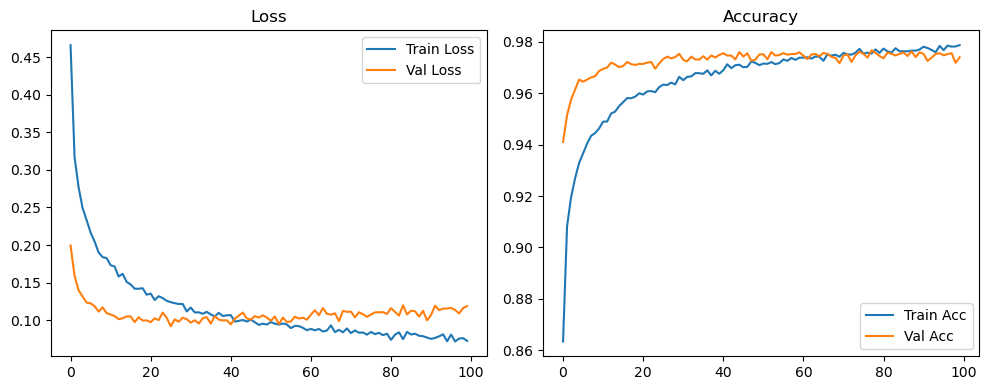

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2631, Acc: 0.9218 | Val Loss: 0.1451, Acc: 0.9571


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1442, Acc: 0.9565 | Val Loss: 0.1227, Acc: 0.9623


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1130, Acc: 0.9657 | Val Loss: 0.1378, Acc: 0.9597


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0936, Acc: 0.9711 | Val Loss: 0.1207, Acc: 0.9652


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9755 | Val Loss: 0.1170, Acc: 0.9682


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0687, Acc: 0.9774 | Val Loss: 0.1188, Acc: 0.9688


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9820 | Val Loss: 0.1127, Acc: 0.9684


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9844 | Val Loss: 0.1271, Acc: 0.9663


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9843 | Val Loss: 0.1342, Acc: 0.9667


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9857 | Val Loss: 0.1211, Acc: 0.9708


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9879 | Val Loss: 0.1038, Acc: 0.9747


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9898 | Val Loss: 0.1238, Acc: 0.9718


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9896 | Val Loss: 0.1140, Acc: 0.9735


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.1253, Acc: 0.9726


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9914 | Val Loss: 0.1442, Acc: 0.9688


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.1260, Acc: 0.9732


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.1252, Acc: 0.9722


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.1217, Acc: 0.9738


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.1210, Acc: 0.9719


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.1191, Acc: 0.9753


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9939 | Val Loss: 0.1330, Acc: 0.9739


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.1424, Acc: 0.9723


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.1389, Acc: 0.9737


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9943 | Val Loss: 0.1455, Acc: 0.9743


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9947 | Val Loss: 0.1336, Acc: 0.9758


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1328, Acc: 0.9748


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1666, Acc: 0.9719


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.1441, Acc: 0.9739


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.1617, Acc: 0.9732


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.1432, Acc: 0.9740


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9953 | Val Loss: 0.1458, Acc: 0.9742


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.1422, Acc: 0.9738


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.1402, Acc: 0.9750


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.1587, Acc: 0.9732


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1632, Acc: 0.9754


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9957 | Val Loss: 0.1665, Acc: 0.9738


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9967 | Val Loss: 0.1661, Acc: 0.9730


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.1534, Acc: 0.9766


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9964 | Val Loss: 0.1687, Acc: 0.9754


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9959 | Val Loss: 0.1522, Acc: 0.9747


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9967 | Val Loss: 0.1650, Acc: 0.9750


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9962 | Val Loss: 0.1647, Acc: 0.9738


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.1586, Acc: 0.9769


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.1548, Acc: 0.9762


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9966 | Val Loss: 0.1720, Acc: 0.9742


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9969 | Val Loss: 0.1548, Acc: 0.9756


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9967 | Val Loss: 0.1601, Acc: 0.9754


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9963 | Val Loss: 0.1657, Acc: 0.9749


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.1700, Acc: 0.9758


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1842, Acc: 0.9734


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1664, Acc: 0.9780


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1768, Acc: 0.9762


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1639, Acc: 0.9788


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1571, Acc: 0.9783


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1587, Acc: 0.9792


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1634, Acc: 0.9781


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1629, Acc: 0.9791


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1712, Acc: 0.9789


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1801, Acc: 0.9782


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1790, Acc: 0.9780


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1892, Acc: 0.9782


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1875, Acc: 0.9792


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1829, Acc: 0.9797


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1898, Acc: 0.9780


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.2068, Acc: 0.9779


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1910, Acc: 0.9784


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1824, Acc: 0.9793


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1914, Acc: 0.9782


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1976, Acc: 0.9777


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.2045, Acc: 0.9768


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.2205, Acc: 0.9769


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.2047, Acc: 0.9781


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1955, Acc: 0.9781


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.2115, Acc: 0.9762


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1993, Acc: 0.9784


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2035, Acc: 0.9799


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1941, Acc: 0.9791


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2080, Acc: 0.9788


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.2202, Acc: 0.9778


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.2007, Acc: 0.9786


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2040, Acc: 0.9791


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2022, Acc: 0.9795


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.2002, Acc: 0.9793


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1920, Acc: 0.9797


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2114, Acc: 0.9785


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2073, Acc: 0.9799


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1975, Acc: 0.9788


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1912, Acc: 0.9790


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2080, Acc: 0.9789


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1932, Acc: 0.9807


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2040, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1996, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2056, Acc: 0.9798


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.2089, Acc: 0.9789


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2085, Acc: 0.9793


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2137, Acc: 0.9810


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2134, Acc: 0.9804


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2154, Acc: 0.9781


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.2137, Acc: 0.9788


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2059, Acc: 0.9811


Final Test Loss: 0.1906 Accuracy: 0.9802


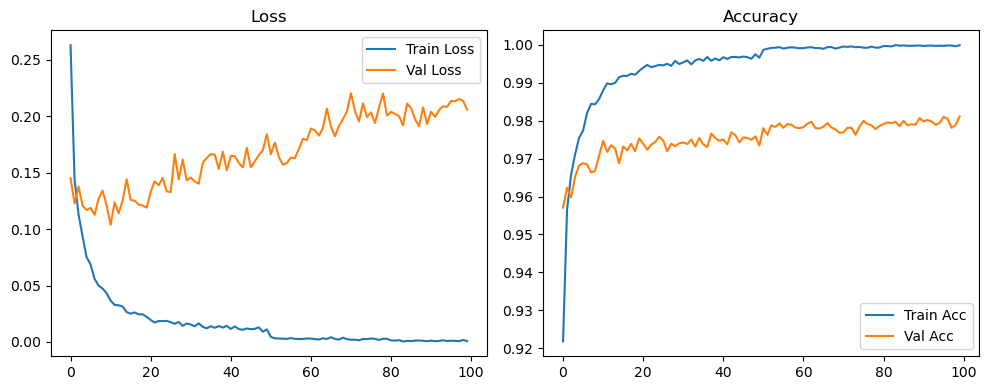

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3123, Acc: 0.9058 | Val Loss: 0.1663, Acc: 0.9498


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1870, Acc: 0.9446 | Val Loss: 0.1324, Acc: 0.9587


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1561, Acc: 0.9526 | Val Loss: 0.1328, Acc: 0.9583


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1360, Acc: 0.9582 | Val Loss: 0.1134, Acc: 0.9653


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1142, Acc: 0.9638 | Val Loss: 0.1044, Acc: 0.9685


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1055, Acc: 0.9667 | Val Loss: 0.1200, Acc: 0.9648


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0958, Acc: 0.9701 | Val Loss: 0.1039, Acc: 0.9699


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0882, Acc: 0.9733 | Val Loss: 0.1079, Acc: 0.9683


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0835, Acc: 0.9735 | Val Loss: 0.1077, Acc: 0.9715


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0778, Acc: 0.9752 | Val Loss: 0.1047, Acc: 0.9731


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9786 | Val Loss: 0.1076, Acc: 0.9704


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0701, Acc: 0.9781 | Val Loss: 0.1152, Acc: 0.9718


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9803 | Val Loss: 0.1142, Acc: 0.9732


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9801 | Val Loss: 0.1047, Acc: 0.9742


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0586, Acc: 0.9812 | Val Loss: 0.1220, Acc: 0.9721


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9834 | Val Loss: 0.1049, Acc: 0.9749


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9828 | Val Loss: 0.1078, Acc: 0.9747


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9841 | Val Loss: 0.1123, Acc: 0.9758


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9849 | Val Loss: 0.1064, Acc: 0.9747


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9850 | Val Loss: 0.1130, Acc: 0.9738


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9863 | Val Loss: 0.1195, Acc: 0.9737


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9862 | Val Loss: 0.1158, Acc: 0.9744


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9870 | Val Loss: 0.1172, Acc: 0.9738


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9872 | Val Loss: 0.1249, Acc: 0.9741


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9869 | Val Loss: 0.1177, Acc: 0.9730


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9886 | Val Loss: 0.1115, Acc: 0.9759


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9877 | Val Loss: 0.1281, Acc: 0.9751


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9879 | Val Loss: 0.1207, Acc: 0.9756


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9880 | Val Loss: 0.1192, Acc: 0.9739


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9893 | Val Loss: 0.1217, Acc: 0.9767


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9884 | Val Loss: 0.1235, Acc: 0.9745


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9899 | Val Loss: 0.1269, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9890 | Val Loss: 0.1192, Acc: 0.9763


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.1266, Acc: 0.9760


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9896 | Val Loss: 0.1239, Acc: 0.9743


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9903 | Val Loss: 0.1296, Acc: 0.9769


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9894 | Val Loss: 0.1464, Acc: 0.9732


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9910 | Val Loss: 0.1293, Acc: 0.9756


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9901 | Val Loss: 0.1312, Acc: 0.9758


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9904 | Val Loss: 0.1240, Acc: 0.9762


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9907 | Val Loss: 0.1165, Acc: 0.9774


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9912 | Val Loss: 0.1476, Acc: 0.9779


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9907 | Val Loss: 0.1404, Acc: 0.9766


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9909 | Val Loss: 0.1496, Acc: 0.9755


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9910 | Val Loss: 0.1632, Acc: 0.9734


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9918 | Val Loss: 0.1564, Acc: 0.9742


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9919 | Val Loss: 0.1363, Acc: 0.9772


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9928 | Val Loss: 0.1480, Acc: 0.9767


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9919 | Val Loss: 0.1497, Acc: 0.9772


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9921 | Val Loss: 0.1346, Acc: 0.9777


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9937 | Val Loss: 0.1362, Acc: 0.9784


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9952 | Val Loss: 0.1312, Acc: 0.9777


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.1341, Acc: 0.9774


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1383, Acc: 0.9793


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1317, Acc: 0.9800


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.1361, Acc: 0.9792


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.1358, Acc: 0.9798


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.1402, Acc: 0.9799


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9963 | Val Loss: 0.1465, Acc: 0.9779


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1411, Acc: 0.9788


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1383, Acc: 0.9791


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1342, Acc: 0.9798


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1417, Acc: 0.9790


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1478, Acc: 0.9792


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1514, Acc: 0.9789


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1458, Acc: 0.9782


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1475, Acc: 0.9783


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9964 | Val Loss: 0.1499, Acc: 0.9788


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1476, Acc: 0.9787


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9966 | Val Loss: 0.1538, Acc: 0.9786


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9965 | Val Loss: 0.1520, Acc: 0.9783


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1487, Acc: 0.9788


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9969 | Val Loss: 0.1426, Acc: 0.9788


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1503, Acc: 0.9790


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1524, Acc: 0.9782


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1500, Acc: 0.9800


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9969 | Val Loss: 0.1449, Acc: 0.9785


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1464, Acc: 0.9784


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1527, Acc: 0.9792


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9971 | Val Loss: 0.1436, Acc: 0.9801


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1434, Acc: 0.9801


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1461, Acc: 0.9803


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1459, Acc: 0.9798


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9980 | Val Loss: 0.1428, Acc: 0.9805


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1512, Acc: 0.9798


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1410, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9981 | Val Loss: 0.1524, Acc: 0.9799


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1506, Acc: 0.9798


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1465, Acc: 0.9797


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1444, Acc: 0.9790


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1406, Acc: 0.9796


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1433, Acc: 0.9792


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1486, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1445, Acc: 0.9798


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.1521, Acc: 0.9798


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1435, Acc: 0.9804


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1472, Acc: 0.9798


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1483, Acc: 0.9800


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.1419, Acc: 0.9811


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1521, Acc: 0.9792


Final Test Loss: 0.1341 Accuracy: 0.9821


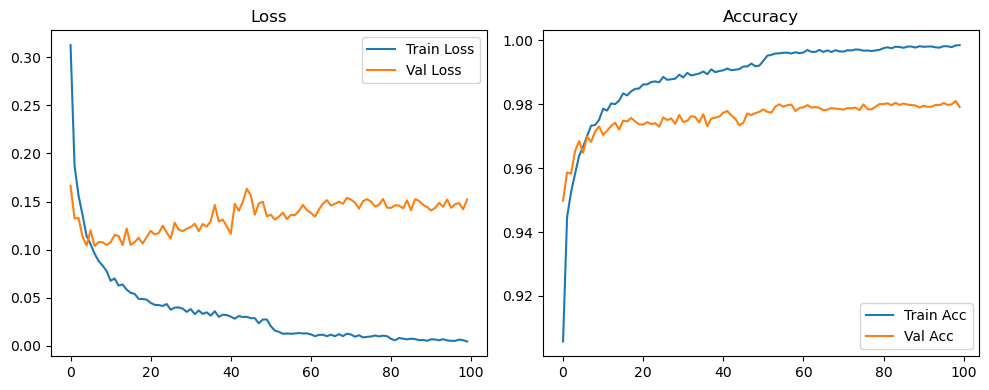

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4658, Acc: 0.8635 | Val Loss: 0.1994, Acc: 0.9410


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3169, Acc: 0.9082 | Val Loss: 0.1588, Acc: 0.9514


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2770, Acc: 0.9195 | Val Loss: 0.1398, Acc: 0.9574


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2493, Acc: 0.9268 | Val Loss: 0.1316, Acc: 0.9613


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2332, Acc: 0.9328 | Val Loss: 0.1235, Acc: 0.9653


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2167, Acc: 0.9366 | Val Loss: 0.1224, Acc: 0.9644


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2046, Acc: 0.9403 | Val Loss: 0.1187, Acc: 0.9653


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1901, Acc: 0.9434 | Val Loss: 0.1114, Acc: 0.9661


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1839, Acc: 0.9445 | Val Loss: 0.1171, Acc: 0.9666


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1826, Acc: 0.9463 | Val Loss: 0.1094, Acc: 0.9686


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1732, Acc: 0.9489 | Val Loss: 0.1076, Acc: 0.9694


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1714, Acc: 0.9489 | Val Loss: 0.1055, Acc: 0.9699


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1580, Acc: 0.9521 | Val Loss: 0.1014, Acc: 0.9718


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1617, Acc: 0.9528 | Val Loss: 0.1025, Acc: 0.9711


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1510, Acc: 0.9549 | Val Loss: 0.1050, Acc: 0.9701


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1475, Acc: 0.9565 | Val Loss: 0.1050, Acc: 0.9705


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1419, Acc: 0.9581 | Val Loss: 0.0974, Acc: 0.9721


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1418, Acc: 0.9580 | Val Loss: 0.1039, Acc: 0.9712


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1425, Acc: 0.9586 | Val Loss: 0.0996, Acc: 0.9709


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1339, Acc: 0.9599 | Val Loss: 0.0997, Acc: 0.9713


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1354, Acc: 0.9594 | Val Loss: 0.0975, Acc: 0.9713


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1269, Acc: 0.9606 | Val Loss: 0.1024, Acc: 0.9718


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1319, Acc: 0.9608 | Val Loss: 0.1002, Acc: 0.9721


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1294, Acc: 0.9603 | Val Loss: 0.1102, Acc: 0.9695


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1258, Acc: 0.9623 | Val Loss: 0.1033, Acc: 0.9715


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1240, Acc: 0.9633 | Val Loss: 0.0919, Acc: 0.9732


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1226, Acc: 0.9631 | Val Loss: 0.1011, Acc: 0.9742


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.1216, Acc: 0.9641 | Val Loss: 0.0980, Acc: 0.9735


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.1216, Acc: 0.9634 | Val Loss: 0.1032, Acc: 0.9740


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.1116, Acc: 0.9663 | Val Loss: 0.1015, Acc: 0.9752


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.1168, Acc: 0.9650 | Val Loss: 0.0968, Acc: 0.9729


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.1104, Acc: 0.9663 | Val Loss: 0.0999, Acc: 0.9723


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.1105, Acc: 0.9665 | Val Loss: 0.0956, Acc: 0.9742


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.1086, Acc: 0.9677 | Val Loss: 0.1026, Acc: 0.9731


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.1111, Acc: 0.9677 | Val Loss: 0.1040, Acc: 0.9730


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.1076, Acc: 0.9675 | Val Loss: 0.0955, Acc: 0.9743


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.1052, Acc: 0.9688 | Val Loss: 0.1053, Acc: 0.9730


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.1097, Acc: 0.9669 | Val Loss: 0.1008, Acc: 0.9746


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.1056, Acc: 0.9687 | Val Loss: 0.0997, Acc: 0.9738


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.1065, Acc: 0.9675 | Val Loss: 0.0999, Acc: 0.9748


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.1067, Acc: 0.9689 | Val Loss: 0.0945, Acc: 0.9755


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0982, Acc: 0.9712 | Val Loss: 0.1018, Acc: 0.9746


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0991, Acc: 0.9697 | Val Loss: 0.1061, Acc: 0.9746


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.1003, Acc: 0.9708 | Val Loss: 0.1102, Acc: 0.9731


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0982, Acc: 0.9710 | Val Loss: 0.1024, Acc: 0.9759


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.1007, Acc: 0.9700 | Val Loss: 0.1007, Acc: 0.9742


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0975, Acc: 0.9702 | Val Loss: 0.1055, Acc: 0.9755


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0937, Acc: 0.9723 | Val Loss: 0.1036, Acc: 0.9726


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0954, Acc: 0.9717 | Val Loss: 0.1065, Acc: 0.9730


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0942, Acc: 0.9709 | Val Loss: 0.1035, Acc: 0.9750


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0817, Acc: 0.9753 | Val Loss: 0.0926, Acc: 0.9767


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0727, Acc: 0.9771 | Val Loss: 0.1000, Acc: 0.9752


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0732, Acc: 0.9780 | Val Loss: 0.0919, Acc: 0.9770


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0701, Acc: 0.9784 | Val Loss: 0.0929, Acc: 0.9768


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0694, Acc: 0.9785 | Val Loss: 0.0953, Acc: 0.9766


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0642, Acc: 0.9792 | Val Loss: 0.0934, Acc: 0.9772


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0668, Acc: 0.9791 | Val Loss: 0.0956, Acc: 0.9772


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0626, Acc: 0.9814 | Val Loss: 0.1000, Acc: 0.9766


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0642, Acc: 0.9804 | Val Loss: 0.0944, Acc: 0.9779


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0637, Acc: 0.9810 | Val Loss: 0.0916, Acc: 0.9776


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0589, Acc: 0.9817 | Val Loss: 0.0961, Acc: 0.9759


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0611, Acc: 0.9816 | Val Loss: 0.0967, Acc: 0.9771


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0626, Acc: 0.9813 | Val Loss: 0.0904, Acc: 0.9774


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0564, Acc: 0.9818 | Val Loss: 0.1041, Acc: 0.9763


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0568, Acc: 0.9826 | Val Loss: 0.0971, Acc: 0.9777


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0661, Acc: 0.9800 | Val Loss: 0.0912, Acc: 0.9778


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9809 | Val Loss: 0.1007, Acc: 0.9755


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0573, Acc: 0.9823 | Val Loss: 0.0908, Acc: 0.9765


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0582, Acc: 0.9822 | Val Loss: 0.0969, Acc: 0.9767


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0604, Acc: 0.9814 | Val Loss: 0.0966, Acc: 0.9764


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9819 | Val Loss: 0.1010, Acc: 0.9761


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0580, Acc: 0.9818 | Val Loss: 0.0960, Acc: 0.9768


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0561, Acc: 0.9832 | Val Loss: 0.1011, Acc: 0.9766


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0551, Acc: 0.9836 | Val Loss: 0.1016, Acc: 0.9762


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0547, Acc: 0.9828 | Val Loss: 0.0954, Acc: 0.9767


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0567, Acc: 0.9822 | Val Loss: 0.0976, Acc: 0.9778


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9821 | Val Loss: 0.1021, Acc: 0.9758


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0567, Acc: 0.9820 | Val Loss: 0.0967, Acc: 0.9768


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0541, Acc: 0.9831 | Val Loss: 0.0981, Acc: 0.9773


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0555, Acc: 0.9828 | Val Loss: 0.0948, Acc: 0.9766


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0482, Acc: 0.9844 | Val Loss: 0.0975, Acc: 0.9767


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0482, Acc: 0.9846 | Val Loss: 0.1044, Acc: 0.9762


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0490, Acc: 0.9850 | Val Loss: 0.0965, Acc: 0.9768


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9854 | Val Loss: 0.0997, Acc: 0.9772


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0479, Acc: 0.9848 | Val Loss: 0.0996, Acc: 0.9765


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0450, Acc: 0.9866 | Val Loss: 0.0989, Acc: 0.9772


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0449, Acc: 0.9855 | Val Loss: 0.1015, Acc: 0.9777


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9852 | Val Loss: 0.0952, Acc: 0.9773


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9866 | Val Loss: 0.0962, Acc: 0.9777


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0432, Acc: 0.9866 | Val Loss: 0.0943, Acc: 0.9768


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9865 | Val Loss: 0.0970, Acc: 0.9768


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0413, Acc: 0.9868 | Val Loss: 0.0990, Acc: 0.9781


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0477, Acc: 0.9853 | Val Loss: 0.1000, Acc: 0.9778


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9858 | Val Loss: 0.0980, Acc: 0.9770


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9870 | Val Loss: 0.1015, Acc: 0.9768


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9851 | Val Loss: 0.1004, Acc: 0.9772


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9870 | Val Loss: 0.0994, Acc: 0.9776


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9864 | Val Loss: 0.0988, Acc: 0.9775


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.1034, Acc: 0.9769


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0413, Acc: 0.9867 | Val Loss: 0.1014, Acc: 0.9764


Final Test Loss: 0.0925 Accuracy: 0.9792


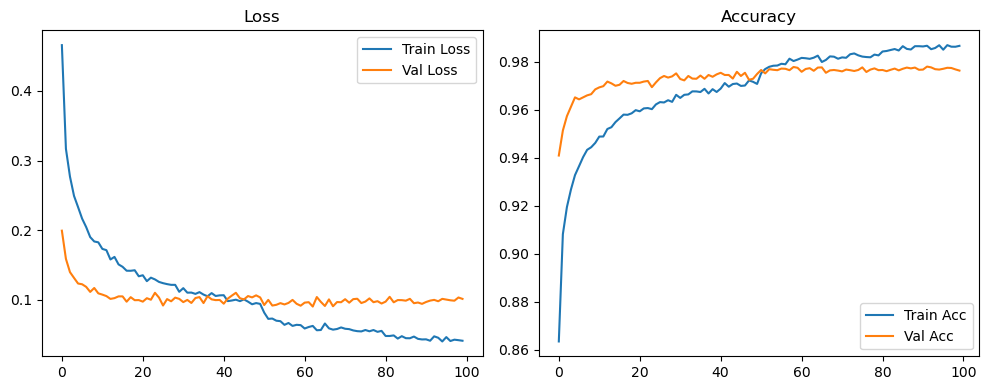

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2529, Acc: 0.9243 | Val Loss: 0.1397, Acc: 0.9568


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1328, Acc: 0.9593 | Val Loss: 0.1256, Acc: 0.9620


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1022, Acc: 0.9680 | Val Loss: 0.1154, Acc: 0.9665


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0826, Acc: 0.9739 | Val Loss: 0.1064, Acc: 0.9684


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0697, Acc: 0.9768 | Val Loss: 0.1055, Acc: 0.9686


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0601, Acc: 0.9803 | Val Loss: 0.1175, Acc: 0.9669


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0541, Acc: 0.9820 | Val Loss: 0.1060, Acc: 0.9700


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9854 | Val Loss: 0.1088, Acc: 0.9702


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9859 | Val Loss: 0.1025, Acc: 0.9733


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9866 | Val Loss: 0.1011, Acc: 0.9738


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9876 | Val Loss: 0.1016, Acc: 0.9728


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.1099, Acc: 0.9728


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.1044, Acc: 0.9748


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9916 | Val Loss: 0.1117, Acc: 0.9737


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9917 | Val Loss: 0.1396, Acc: 0.9687


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.1225, Acc: 0.9704


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9931 | Val Loss: 0.1197, Acc: 0.9732


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.1122, Acc: 0.9737


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.1226, Acc: 0.9736


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.1189, Acc: 0.9721


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.1049, Acc: 0.9738


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9943 | Val Loss: 0.1310, Acc: 0.9706


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.1156, Acc: 0.9748


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.1182, Acc: 0.9737


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.1226, Acc: 0.9731


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1150, Acc: 0.9762


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1283, Acc: 0.9739


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.1206, Acc: 0.9757


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1316, Acc: 0.9732


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1260, Acc: 0.9764


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.1296, Acc: 0.9752


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1334, Acc: 0.9760


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1357, Acc: 0.9744


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.1326, Acc: 0.9745


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1274, Acc: 0.9754


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1351, Acc: 0.9763


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1347, Acc: 0.9753


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.1274, Acc: 0.9767


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1411, Acc: 0.9770


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1312, Acc: 0.9754


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1411, Acc: 0.9757


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.1471, Acc: 0.9760


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1437, Acc: 0.9742


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1469, Acc: 0.9761


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1229, Acc: 0.9772


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1369, Acc: 0.9763


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.1357, Acc: 0.9774


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1401, Acc: 0.9776


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1347, Acc: 0.9774


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1461, Acc: 0.9763


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1362, Acc: 0.9768


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1532, Acc: 0.9753


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1579, Acc: 0.9750


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1479, Acc: 0.9758


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1543, Acc: 0.9755


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1427, Acc: 0.9771


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1394, Acc: 0.9778


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1502, Acc: 0.9762


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1499, Acc: 0.9765


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1527, Acc: 0.9769


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1611, Acc: 0.9754


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1540, Acc: 0.9782


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1610, Acc: 0.9752


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1698, Acc: 0.9750


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1523, Acc: 0.9762


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1687, Acc: 0.9755


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1486, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1618, Acc: 0.9743


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1427, Acc: 0.9781


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1570, Acc: 0.9764


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1652, Acc: 0.9759


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1714, Acc: 0.9745


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1637, Acc: 0.9752


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1697, Acc: 0.9768


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1613, Acc: 0.9772


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1521, Acc: 0.9765


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1752, Acc: 0.9754


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1792, Acc: 0.9758


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1720, Acc: 0.9772


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1659, Acc: 0.9737


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1579, Acc: 0.9762


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1632, Acc: 0.9778


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1678, Acc: 0.9766


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1716, Acc: 0.9779


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1799, Acc: 0.9758


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1738, Acc: 0.9768


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1753, Acc: 0.9745


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1738, Acc: 0.9764


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1844, Acc: 0.9759


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1737, Acc: 0.9753


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1782, Acc: 0.9748


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1878, Acc: 0.9756


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1633, Acc: 0.9775


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1767, Acc: 0.9754


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1663, Acc: 0.9774


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1799, Acc: 0.9758


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1858, Acc: 0.9768


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1880, Acc: 0.9769


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1858, Acc: 0.9769


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9984 | Val Loss: 0.1735, Acc: 0.9758


Final Test Loss: 0.1643 Accuracy: 0.9768


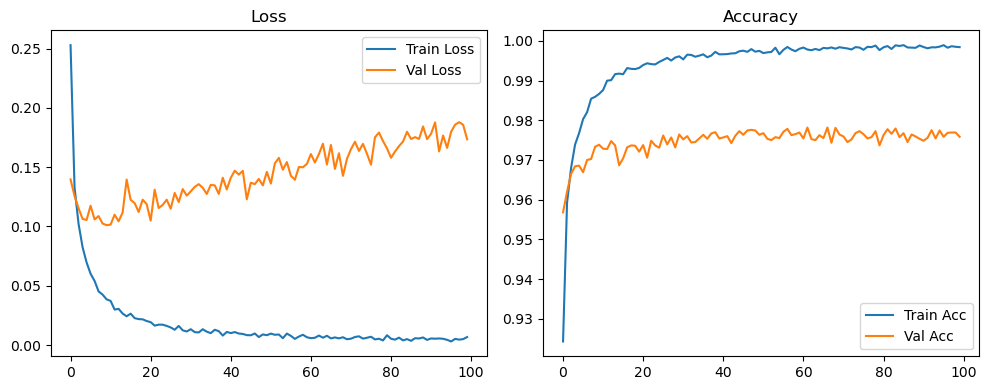

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3101, Acc: 0.9079 | Val Loss: 0.1512, Acc: 0.9533


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1803, Acc: 0.9466 | Val Loss: 0.1294, Acc: 0.9597


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1473, Acc: 0.9549 | Val Loss: 0.1240, Acc: 0.9606


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1292, Acc: 0.9600 | Val Loss: 0.1131, Acc: 0.9661


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1103, Acc: 0.9657 | Val Loss: 0.1069, Acc: 0.9685


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0964, Acc: 0.9695 | Val Loss: 0.1112, Acc: 0.9669


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0916, Acc: 0.9707 | Val Loss: 0.0953, Acc: 0.9702


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0809, Acc: 0.9747 | Val Loss: 0.1054, Acc: 0.9701


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0763, Acc: 0.9750 | Val Loss: 0.1078, Acc: 0.9687


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0738, Acc: 0.9761 | Val Loss: 0.0994, Acc: 0.9728


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0660, Acc: 0.9783 | Val Loss: 0.1036, Acc: 0.9707


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0662, Acc: 0.9783 | Val Loss: 0.0943, Acc: 0.9729


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0581, Acc: 0.9810 | Val Loss: 0.1040, Acc: 0.9725


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0589, Acc: 0.9814 | Val Loss: 0.1115, Acc: 0.9707


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0506, Acc: 0.9830 | Val Loss: 0.1041, Acc: 0.9738


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0500, Acc: 0.9836 | Val Loss: 0.1035, Acc: 0.9746


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9852 | Val Loss: 0.0972, Acc: 0.9746


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9848 | Val Loss: 0.1026, Acc: 0.9746


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9857 | Val Loss: 0.0954, Acc: 0.9755


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9859 | Val Loss: 0.1039, Acc: 0.9738


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9858 | Val Loss: 0.1032, Acc: 0.9748


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9858 | Val Loss: 0.1044, Acc: 0.9743


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9879 | Val Loss: 0.1080, Acc: 0.9753


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.1157, Acc: 0.9732


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9870 | Val Loss: 0.0999, Acc: 0.9756


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9878 | Val Loss: 0.0992, Acc: 0.9745


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.1034, Acc: 0.9767


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9892 | Val Loss: 0.0954, Acc: 0.9773


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9888 | Val Loss: 0.0997, Acc: 0.9762


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9898 | Val Loss: 0.1014, Acc: 0.9788


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9903 | Val Loss: 0.1124, Acc: 0.9756


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.1086, Acc: 0.9771


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9893 | Val Loss: 0.1007, Acc: 0.9757


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9913 | Val Loss: 0.1088, Acc: 0.9764


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.1134, Acc: 0.9744


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1048, Acc: 0.9749


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9909 | Val Loss: 0.1001, Acc: 0.9762


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9920 | Val Loss: 0.1047, Acc: 0.9751


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.1152, Acc: 0.9759


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.1060, Acc: 0.9762


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.1111, Acc: 0.9751


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9927 | Val Loss: 0.1125, Acc: 0.9768


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9922 | Val Loss: 0.1172, Acc: 0.9760


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.1158, Acc: 0.9754


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.1171, Acc: 0.9752


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9920 | Val Loss: 0.1115, Acc: 0.9769


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.1114, Acc: 0.9761


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.1209, Acc: 0.9755


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9929 | Val Loss: 0.1163, Acc: 0.9752


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 0.1172, Acc: 0.9753


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9923 | Val Loss: 0.1192, Acc: 0.9758


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.1269, Acc: 0.9748


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.1210, Acc: 0.9769


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.1191, Acc: 0.9773


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.1186, Acc: 0.9779


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.1241, Acc: 0.9763


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.1229, Acc: 0.9782


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.1136, Acc: 0.9768


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.1265, Acc: 0.9760


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9934 | Val Loss: 0.1265, Acc: 0.9755


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9932 | Val Loss: 0.1191, Acc: 0.9768


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.1241, Acc: 0.9764


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.1176, Acc: 0.9782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.1263, Acc: 0.9777


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.1302, Acc: 0.9762


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9939 | Val Loss: 0.1173, Acc: 0.9774


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9943 | Val Loss: 0.1213, Acc: 0.9766


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.1177, Acc: 0.9778


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9937 | Val Loss: 0.1194, Acc: 0.9782


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.1329, Acc: 0.9772


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.1263, Acc: 0.9778


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1325, Acc: 0.9766


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.1284, Acc: 0.9769


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.1289, Acc: 0.9762


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.1261, Acc: 0.9772


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9938 | Val Loss: 0.1196, Acc: 0.9778


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.1122, Acc: 0.9782


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.1233, Acc: 0.9779


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.1310, Acc: 0.9778


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.1249, Acc: 0.9785


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.1227, Acc: 0.9767


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.1505, Acc: 0.9754


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9956 | Val Loss: 0.1256, Acc: 0.9777


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9953 | Val Loss: 0.1371, Acc: 0.9779


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.1342, Acc: 0.9763


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.1317, Acc: 0.9752


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1280, Acc: 0.9768


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9951 | Val Loss: 0.1297, Acc: 0.9767


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1394, Acc: 0.9761


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.1297, Acc: 0.9771


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1410, Acc: 0.9769


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9953 | Val Loss: 0.1345, Acc: 0.9774


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9957 | Val Loss: 0.1374, Acc: 0.9769


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9954 | Val Loss: 0.1362, Acc: 0.9768


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.1355, Acc: 0.9772


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1366, Acc: 0.9768


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9954 | Val Loss: 0.1363, Acc: 0.9752


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1353, Acc: 0.9777


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.1409, Acc: 0.9767


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.1256, Acc: 0.9783


Final Test Loss: 0.1258 Accuracy: 0.9789


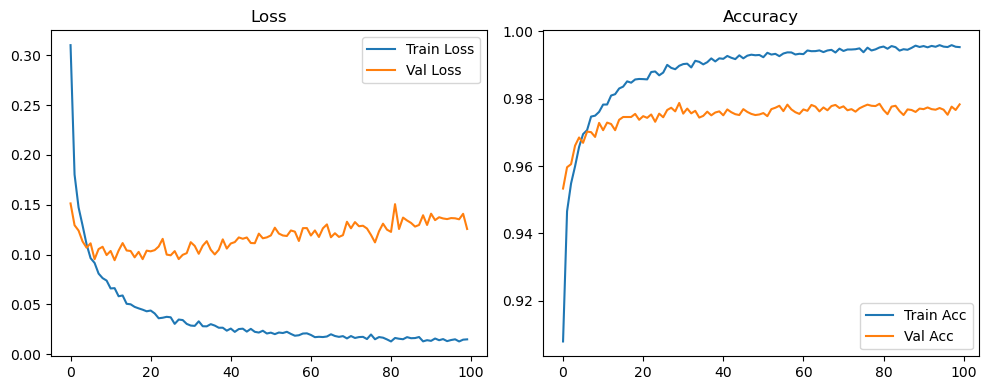

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4815, Acc: 0.8586 | Val Loss: 0.1978, Acc: 0.9400


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3018, Acc: 0.9122 | Val Loss: 0.1636, Acc: 0.9509


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2626, Acc: 0.9230 | Val Loss: 0.1455, Acc: 0.9547


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2466, Acc: 0.9263 | Val Loss: 0.1317, Acc: 0.9605


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.2166, Acc: 0.9343 | Val Loss: 0.1238, Acc: 0.9650


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.2035, Acc: 0.9400 | Val Loss: 0.1222, Acc: 0.9651


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1920, Acc: 0.9438 | Val Loss: 0.1167, Acc: 0.9661


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1833, Acc: 0.9452 | Val Loss: 0.1124, Acc: 0.9669


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1734, Acc: 0.9480 | Val Loss: 0.1128, Acc: 0.9669


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1718, Acc: 0.9484 | Val Loss: 0.1104, Acc: 0.9666


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1605, Acc: 0.9515 | Val Loss: 0.1063, Acc: 0.9684


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1572, Acc: 0.9531 | Val Loss: 0.1021, Acc: 0.9705


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1493, Acc: 0.9544 | Val Loss: 0.1049, Acc: 0.9707


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1474, Acc: 0.9550 | Val Loss: 0.1003, Acc: 0.9699


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1452, Acc: 0.9566 | Val Loss: 0.1044, Acc: 0.9696


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1337, Acc: 0.9600 | Val Loss: 0.0993, Acc: 0.9708


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1318, Acc: 0.9593 | Val Loss: 0.1018, Acc: 0.9711


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1356, Acc: 0.9588 | Val Loss: 0.0982, Acc: 0.9714


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1325, Acc: 0.9604 | Val Loss: 0.0966, Acc: 0.9718


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1259, Acc: 0.9620 | Val Loss: 0.1002, Acc: 0.9719


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1210, Acc: 0.9631 | Val Loss: 0.1012, Acc: 0.9726


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.1220, Acc: 0.9625 | Val Loss: 0.0999, Acc: 0.9710


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.1114, Acc: 0.9657 | Val Loss: 0.1003, Acc: 0.9735


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.1162, Acc: 0.9645 | Val Loss: 0.1055, Acc: 0.9711


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.1158, Acc: 0.9646 | Val Loss: 0.0989, Acc: 0.9724


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.1179, Acc: 0.9633 | Val Loss: 0.0928, Acc: 0.9733


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.1106, Acc: 0.9651 | Val Loss: 0.0971, Acc: 0.9738


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.1104, Acc: 0.9651 | Val Loss: 0.0952, Acc: 0.9726


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.1052, Acc: 0.9670 | Val Loss: 0.0972, Acc: 0.9738


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0987, Acc: 0.9689 | Val Loss: 0.0969, Acc: 0.9741


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.1037, Acc: 0.9679 | Val Loss: 0.1009, Acc: 0.9731


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.1015, Acc: 0.9687 | Val Loss: 0.0999, Acc: 0.9732


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0989, Acc: 0.9699 | Val Loss: 0.1021, Acc: 0.9732


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0984, Acc: 0.9689 | Val Loss: 0.0983, Acc: 0.9718


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.1017, Acc: 0.9682 | Val Loss: 0.0979, Acc: 0.9732


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0986, Acc: 0.9692 | Val Loss: 0.0960, Acc: 0.9728


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0980, Acc: 0.9697 | Val Loss: 0.0985, Acc: 0.9738


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0946, Acc: 0.9696 | Val Loss: 0.0992, Acc: 0.9740


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0920, Acc: 0.9708 | Val Loss: 0.0982, Acc: 0.9750


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0928, Acc: 0.9713 | Val Loss: 0.0989, Acc: 0.9725


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0944, Acc: 0.9708 | Val Loss: 0.0942, Acc: 0.9746


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0868, Acc: 0.9730 | Val Loss: 0.0999, Acc: 0.9741


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0889, Acc: 0.9722 | Val Loss: 0.1018, Acc: 0.9728


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0887, Acc: 0.9726 | Val Loss: 0.0956, Acc: 0.9760


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0874, Acc: 0.9720 | Val Loss: 0.0996, Acc: 0.9747


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0869, Acc: 0.9735 | Val Loss: 0.0972, Acc: 0.9752


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0862, Acc: 0.9727 | Val Loss: 0.0991, Acc: 0.9750


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0822, Acc: 0.9743 | Val Loss: 0.0973, Acc: 0.9739


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0853, Acc: 0.9739 | Val Loss: 0.0933, Acc: 0.9747


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0828, Acc: 0.9734 | Val Loss: 0.0979, Acc: 0.9750


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0860, Acc: 0.9736 | Val Loss: 0.0911, Acc: 0.9758


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0838, Acc: 0.9743 | Val Loss: 0.0967, Acc: 0.9736


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0776, Acc: 0.9750 | Val Loss: 0.0975, Acc: 0.9748


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0794, Acc: 0.9751 | Val Loss: 0.1015, Acc: 0.9760


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0811, Acc: 0.9746 | Val Loss: 0.0956, Acc: 0.9760


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0815, Acc: 0.9743 | Val Loss: 0.0960, Acc: 0.9769


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0771, Acc: 0.9759 | Val Loss: 0.0993, Acc: 0.9742


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0773, Acc: 0.9758 | Val Loss: 0.0975, Acc: 0.9763


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0788, Acc: 0.9753 | Val Loss: 0.0989, Acc: 0.9745


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0756, Acc: 0.9760 | Val Loss: 0.1009, Acc: 0.9748


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0767, Acc: 0.9759 | Val Loss: 0.0999, Acc: 0.9756


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0762, Acc: 0.9759 | Val Loss: 0.1007, Acc: 0.9742


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0740, Acc: 0.9769 | Val Loss: 0.0981, Acc: 0.9762


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0726, Acc: 0.9776 | Val Loss: 0.0993, Acc: 0.9749


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0747, Acc: 0.9765 | Val Loss: 0.0972, Acc: 0.9762


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0779, Acc: 0.9758 | Val Loss: 0.0995, Acc: 0.9743


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0724, Acc: 0.9775 | Val Loss: 0.1000, Acc: 0.9742


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0719, Acc: 0.9781 | Val Loss: 0.0982, Acc: 0.9763


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0726, Acc: 0.9782 | Val Loss: 0.1004, Acc: 0.9761


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0735, Acc: 0.9780 | Val Loss: 0.1035, Acc: 0.9755


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0747, Acc: 0.9762 | Val Loss: 0.1001, Acc: 0.9756


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0729, Acc: 0.9772 | Val Loss: 0.1009, Acc: 0.9746


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0715, Acc: 0.9776 | Val Loss: 0.0977, Acc: 0.9766


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0692, Acc: 0.9781 | Val Loss: 0.0982, Acc: 0.9748


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0691, Acc: 0.9782 | Val Loss: 0.1000, Acc: 0.9762


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0673, Acc: 0.9791 | Val Loss: 0.0977, Acc: 0.9763


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0713, Acc: 0.9778 | Val Loss: 0.1027, Acc: 0.9733


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0706, Acc: 0.9774 | Val Loss: 0.1043, Acc: 0.9749


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0683, Acc: 0.9785 | Val Loss: 0.1002, Acc: 0.9773


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0653, Acc: 0.9799 | Val Loss: 0.1037, Acc: 0.9765


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0665, Acc: 0.9793 | Val Loss: 0.0988, Acc: 0.9748


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0671, Acc: 0.9790 | Val Loss: 0.1070, Acc: 0.9752


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0693, Acc: 0.9789 | Val Loss: 0.0993, Acc: 0.9767


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0654, Acc: 0.9796 | Val Loss: 0.1032, Acc: 0.9757


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0679, Acc: 0.9786 | Val Loss: 0.1040, Acc: 0.9744


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0664, Acc: 0.9796 | Val Loss: 0.0976, Acc: 0.9756


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0645, Acc: 0.9799 | Val Loss: 0.1062, Acc: 0.9758


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0613, Acc: 0.9811 | Val Loss: 0.1038, Acc: 0.9752


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0678, Acc: 0.9791 | Val Loss: 0.1053, Acc: 0.9749


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0659, Acc: 0.9797 | Val Loss: 0.1051, Acc: 0.9742


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0655, Acc: 0.9798 | Val Loss: 0.0972, Acc: 0.9745


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0635, Acc: 0.9797 | Val Loss: 0.1026, Acc: 0.9748


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0652, Acc: 0.9798 | Val Loss: 0.1026, Acc: 0.9757


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0652, Acc: 0.9801 | Val Loss: 0.1066, Acc: 0.9750


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0575, Acc: 0.9811 | Val Loss: 0.1032, Acc: 0.9768


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0678, Acc: 0.9796 | Val Loss: 0.1089, Acc: 0.9748


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0606, Acc: 0.9805 | Val Loss: 0.1134, Acc: 0.9728


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0576, Acc: 0.9817 | Val Loss: 0.1095, Acc: 0.9748


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0620, Acc: 0.9802 | Val Loss: 0.1082, Acc: 0.9758


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0644, Acc: 0.9797 | Val Loss: 0.1001, Acc: 0.9764


Final Test Loss: 0.0922 Accuracy: 0.9782


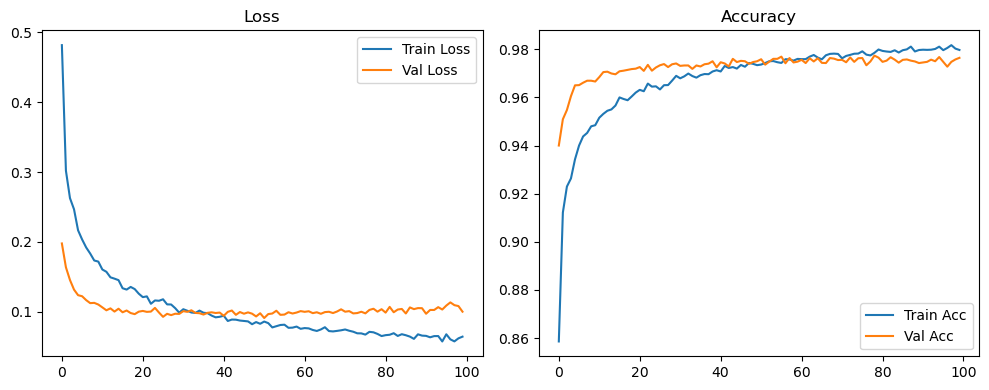

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2592, Acc: 0.9235 | Val Loss: 0.1308, Acc: 0.9597


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1289, Acc: 0.9613 | Val Loss: 0.1189, Acc: 0.9624


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0984, Acc: 0.9696 | Val Loss: 0.1164, Acc: 0.9653


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0804, Acc: 0.9752 | Val Loss: 0.1039, Acc: 0.9676


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0676, Acc: 0.9778 | Val Loss: 0.1034, Acc: 0.9688


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0575, Acc: 0.9813 | Val Loss: 0.1082, Acc: 0.9705


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0500, Acc: 0.9836 | Val Loss: 0.1050, Acc: 0.9703


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0455, Acc: 0.9855 | Val Loss: 0.1165, Acc: 0.9674


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0419, Acc: 0.9858 | Val Loss: 0.1136, Acc: 0.9705


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9869 | Val Loss: 0.1015, Acc: 0.9730


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9887 | Val Loss: 0.1062, Acc: 0.9702


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.1016, Acc: 0.9723


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9889 | Val Loss: 0.1039, Acc: 0.9740


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9911 | Val Loss: 0.1127, Acc: 0.9716


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1159, Acc: 0.9731


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.1112, Acc: 0.9726


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9920 | Val Loss: 0.1193, Acc: 0.9722


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.1169, Acc: 0.9695


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.1187, Acc: 0.9720


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9929 | Val Loss: 0.1045, Acc: 0.9753


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.1204, Acc: 0.9719


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.1085, Acc: 0.9741


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1219, Acc: 0.9731


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.1162, Acc: 0.9728


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1163, Acc: 0.9734


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.1076, Acc: 0.9754


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1194, Acc: 0.9732


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.1220, Acc: 0.9728


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1330, Acc: 0.9716


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.1217, Acc: 0.9749


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1209, Acc: 0.9718


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1217, Acc: 0.9754


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1253, Acc: 0.9728


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1178, Acc: 0.9754


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1262, Acc: 0.9740


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1187, Acc: 0.9749


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1344, Acc: 0.9743


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1183, Acc: 0.9744


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1167, Acc: 0.9761


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1273, Acc: 0.9739


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1215, Acc: 0.9745


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1214, Acc: 0.9761


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1421, Acc: 0.9722


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1219, Acc: 0.9760


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1427, Acc: 0.9726


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1275, Acc: 0.9746


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1411, Acc: 0.9748


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1331, Acc: 0.9738


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1276, Acc: 0.9759


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1338, Acc: 0.9752


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1332, Acc: 0.9752


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1272, Acc: 0.9750


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1281, Acc: 0.9764


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1546, Acc: 0.9742


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1276, Acc: 0.9774


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1443, Acc: 0.9736


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1326, Acc: 0.9758


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1385, Acc: 0.9756


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1317, Acc: 0.9775


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1413, Acc: 0.9772


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1431, Acc: 0.9766


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1346, Acc: 0.9763


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1311, Acc: 0.9777


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1266, Acc: 0.9771


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1335, Acc: 0.9764


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1397, Acc: 0.9739


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1437, Acc: 0.9756


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1376, Acc: 0.9747


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1373, Acc: 0.9769


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1369, Acc: 0.9775


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1464, Acc: 0.9757


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1386, Acc: 0.9771


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1401, Acc: 0.9757


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1509, Acc: 0.9763


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1281, Acc: 0.9764


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.1417, Acc: 0.9749


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1392, Acc: 0.9754


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1599, Acc: 0.9758


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1555, Acc: 0.9751


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1667, Acc: 0.9738


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1508, Acc: 0.9755


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1471, Acc: 0.9766


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1397, Acc: 0.9774


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1627, Acc: 0.9727


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1631, Acc: 0.9752


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1554, Acc: 0.9748


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1510, Acc: 0.9751


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1479, Acc: 0.9757


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1563, Acc: 0.9758


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1522, Acc: 0.9767


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1624, Acc: 0.9746


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1629, Acc: 0.9758


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1581, Acc: 0.9755


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1579, Acc: 0.9772


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1526, Acc: 0.9784


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1538, Acc: 0.9768


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1646, Acc: 0.9756


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1729, Acc: 0.9763


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1837, Acc: 0.9744


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1548, Acc: 0.9769


Final Test Loss: 0.1516 Accuracy: 0.9759


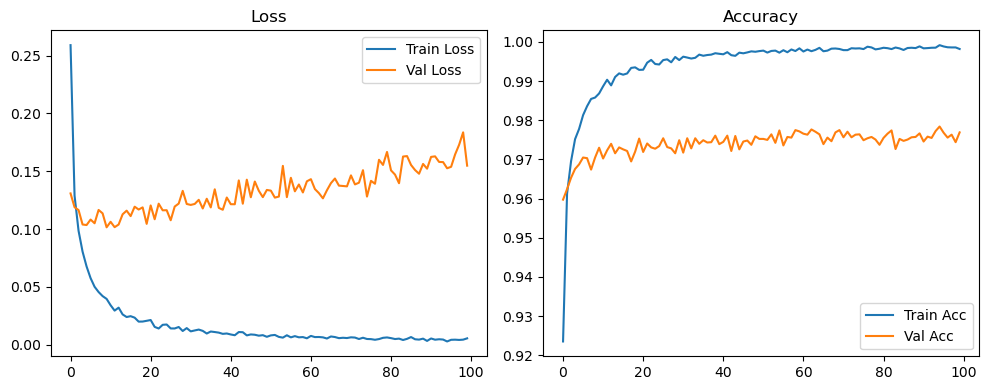

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3287, Acc: 0.9042 | Val Loss: 0.1537, Acc: 0.9539


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1767, Acc: 0.9453 | Val Loss: 0.1251, Acc: 0.9603


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1434, Acc: 0.9556 | Val Loss: 0.1192, Acc: 0.9633


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1272, Acc: 0.9612 | Val Loss: 0.1117, Acc: 0.9666


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1097, Acc: 0.9654 | Val Loss: 0.1040, Acc: 0.9689


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0987, Acc: 0.9683 | Val Loss: 0.1097, Acc: 0.9667


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0880, Acc: 0.9717 | Val Loss: 0.1038, Acc: 0.9689


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0835, Acc: 0.9729 | Val Loss: 0.1078, Acc: 0.9666


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0776, Acc: 0.9744 | Val Loss: 0.1094, Acc: 0.9697


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0741, Acc: 0.9756 | Val Loss: 0.0993, Acc: 0.9706


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0661, Acc: 0.9788 | Val Loss: 0.0997, Acc: 0.9713


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0647, Acc: 0.9792 | Val Loss: 0.1006, Acc: 0.9719


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0587, Acc: 0.9803 | Val Loss: 0.1040, Acc: 0.9706


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0571, Acc: 0.9812 | Val Loss: 0.1057, Acc: 0.9694


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0506, Acc: 0.9836 | Val Loss: 0.0990, Acc: 0.9722


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0523, Acc: 0.9822 | Val Loss: 0.1018, Acc: 0.9732


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0480, Acc: 0.9840 | Val Loss: 0.1045, Acc: 0.9715


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0451, Acc: 0.9850 | Val Loss: 0.1054, Acc: 0.9706


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0453, Acc: 0.9851 | Val Loss: 0.1003, Acc: 0.9732


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9854 | Val Loss: 0.1012, Acc: 0.9735


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9857 | Val Loss: 0.1000, Acc: 0.9733


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9866 | Val Loss: 0.0956, Acc: 0.9757


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.0979, Acc: 0.9760


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9878 | Val Loss: 0.1077, Acc: 0.9742


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9878 | Val Loss: 0.1005, Acc: 0.9737


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9875 | Val Loss: 0.1053, Acc: 0.9728


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.1046, Acc: 0.9733


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9890 | Val Loss: 0.1063, Acc: 0.9723


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9883 | Val Loss: 0.0952, Acc: 0.9746


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0985, Acc: 0.9748


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9903 | Val Loss: 0.1097, Acc: 0.9722


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9902 | Val Loss: 0.1019, Acc: 0.9749


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9901 | Val Loss: 0.1041, Acc: 0.9734


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9904 | Val Loss: 0.1108, Acc: 0.9736


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.1057, Acc: 0.9748


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9902 | Val Loss: 0.1051, Acc: 0.9753


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.1044, Acc: 0.9752


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.1105, Acc: 0.9758


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.1095, Acc: 0.9750


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.1066, Acc: 0.9758


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9919 | Val Loss: 0.1069, Acc: 0.9752


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.1062, Acc: 0.9748


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.1065, Acc: 0.9756


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9911 | Val Loss: 0.1087, Acc: 0.9743


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.1034, Acc: 0.9755


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.1085, Acc: 0.9750


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.1174, Acc: 0.9741


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.1068, Acc: 0.9751


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9921 | Val Loss: 0.1076, Acc: 0.9747


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9931 | Val Loss: 0.1084, Acc: 0.9751


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.1082, Acc: 0.9751


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9933 | Val Loss: 0.1250, Acc: 0.9732


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1137, Acc: 0.9748


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.1169, Acc: 0.9754


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.1076, Acc: 0.9755


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.1106, Acc: 0.9764


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9939 | Val Loss: 0.1151, Acc: 0.9754


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9934 | Val Loss: 0.1163, Acc: 0.9756


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1186, Acc: 0.9745


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 0.1102, Acc: 0.9757


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.1131, Acc: 0.9774


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.1194, Acc: 0.9748


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.1112, Acc: 0.9768


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9942 | Val Loss: 0.1215, Acc: 0.9742


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1149, Acc: 0.9761


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.1081, Acc: 0.9767


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.1111, Acc: 0.9759


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.1127, Acc: 0.9763


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1031, Acc: 0.9772


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9948 | Val Loss: 0.1158, Acc: 0.9744


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.1126, Acc: 0.9759


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1207, Acc: 0.9748


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.1140, Acc: 0.9761


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1157, Acc: 0.9755


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9958 | Val Loss: 0.1135, Acc: 0.9766


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9943 | Val Loss: 0.1229, Acc: 0.9756


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.1148, Acc: 0.9763


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.1208, Acc: 0.9763


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9952 | Val Loss: 0.1201, Acc: 0.9768


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.1172, Acc: 0.9763


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.1221, Acc: 0.9761


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.1141, Acc: 0.9773


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1180, Acc: 0.9765


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.1241, Acc: 0.9756


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.1150, Acc: 0.9779


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1279, Acc: 0.9753


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.1216, Acc: 0.9762


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1175, Acc: 0.9772


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1183, Acc: 0.9752


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1176, Acc: 0.9756


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.1219, Acc: 0.9761


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.1255, Acc: 0.9755


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1298, Acc: 0.9750


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.1244, Acc: 0.9760


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1224, Acc: 0.9772


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1205, Acc: 0.9768


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1225, Acc: 0.9755


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1194, Acc: 0.9762


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1222, Acc: 0.9771


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1226, Acc: 0.9778


Final Test Loss: 0.1134 Accuracy: 0.9786


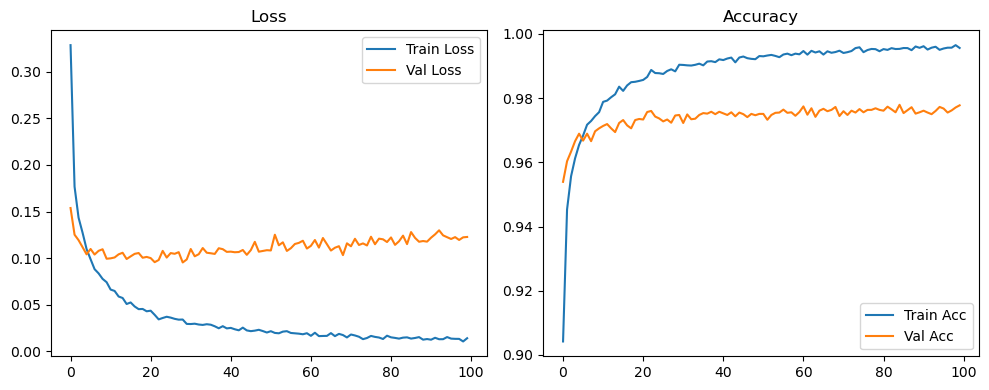

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5316, Acc: 0.8435 | Val Loss: 0.2061, Acc: 0.9370


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3028, Acc: 0.9111 | Val Loss: 0.1677, Acc: 0.9500


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2611, Acc: 0.9233 | Val Loss: 0.1528, Acc: 0.9543


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2400, Acc: 0.9294 | Val Loss: 0.1347, Acc: 0.9581


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2203, Acc: 0.9339 | Val Loss: 0.1282, Acc: 0.9606


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2007, Acc: 0.9397 | Val Loss: 0.1258, Acc: 0.9614


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1915, Acc: 0.9428 | Val Loss: 0.1204, Acc: 0.9643


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1799, Acc: 0.9472 | Val Loss: 0.1172, Acc: 0.9652


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1765, Acc: 0.9467 | Val Loss: 0.1105, Acc: 0.9670


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1719, Acc: 0.9476 | Val Loss: 0.1186, Acc: 0.9648


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1663, Acc: 0.9503 | Val Loss: 0.1146, Acc: 0.9647


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1594, Acc: 0.9520 | Val Loss: 0.1029, Acc: 0.9691


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1534, Acc: 0.9527 | Val Loss: 0.1017, Acc: 0.9705


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1475, Acc: 0.9558 | Val Loss: 0.1049, Acc: 0.9682


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1444, Acc: 0.9559 | Val Loss: 0.1068, Acc: 0.9700


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1383, Acc: 0.9571 | Val Loss: 0.1022, Acc: 0.9705


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1328, Acc: 0.9591 | Val Loss: 0.1019, Acc: 0.9698


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1339, Acc: 0.9580 | Val Loss: 0.1032, Acc: 0.9705


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1301, Acc: 0.9599 | Val Loss: 0.0980, Acc: 0.9726


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1262, Acc: 0.9605 | Val Loss: 0.0993, Acc: 0.9720


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1283, Acc: 0.9605 | Val Loss: 0.0985, Acc: 0.9713


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1195, Acc: 0.9636 | Val Loss: 0.0995, Acc: 0.9721


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1166, Acc: 0.9634 | Val Loss: 0.1020, Acc: 0.9708


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1184, Acc: 0.9629 | Val Loss: 0.1046, Acc: 0.9705


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1130, Acc: 0.9644 | Val Loss: 0.0984, Acc: 0.9722


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.1183, Acc: 0.9631 | Val Loss: 0.0954, Acc: 0.9729


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.1104, Acc: 0.9639 | Val Loss: 0.1017, Acc: 0.9718


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.1086, Acc: 0.9651 | Val Loss: 0.0962, Acc: 0.9732


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.1059, Acc: 0.9668 | Val Loss: 0.0979, Acc: 0.9722


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.1028, Acc: 0.9676 | Val Loss: 0.0975, Acc: 0.9715


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.1048, Acc: 0.9672 | Val Loss: 0.1016, Acc: 0.9720


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0995, Acc: 0.9687 | Val Loss: 0.0983, Acc: 0.9719


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.1011, Acc: 0.9683 | Val Loss: 0.0967, Acc: 0.9734


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0998, Acc: 0.9686 | Val Loss: 0.0984, Acc: 0.9722


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0982, Acc: 0.9691 | Val Loss: 0.1040, Acc: 0.9712


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0999, Acc: 0.9684 | Val Loss: 0.0929, Acc: 0.9738


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0946, Acc: 0.9703 | Val Loss: 0.0941, Acc: 0.9748


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0970, Acc: 0.9698 | Val Loss: 0.0945, Acc: 0.9732


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0897, Acc: 0.9709 | Val Loss: 0.0975, Acc: 0.9726


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0945, Acc: 0.9708 | Val Loss: 0.0970, Acc: 0.9719


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0946, Acc: 0.9714 | Val Loss: 0.0969, Acc: 0.9728


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0850, Acc: 0.9721 | Val Loss: 0.0989, Acc: 0.9737


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0898, Acc: 0.9725 | Val Loss: 0.0990, Acc: 0.9735


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0930, Acc: 0.9716 | Val Loss: 0.0995, Acc: 0.9729


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0870, Acc: 0.9714 | Val Loss: 0.0976, Acc: 0.9736


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0857, Acc: 0.9729 | Val Loss: 0.0992, Acc: 0.9736


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0879, Acc: 0.9728 | Val Loss: 0.0988, Acc: 0.9736


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0811, Acc: 0.9738 | Val Loss: 0.0954, Acc: 0.9753


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0827, Acc: 0.9740 | Val Loss: 0.0996, Acc: 0.9733


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0834, Acc: 0.9733 | Val Loss: 0.0921, Acc: 0.9762


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0815, Acc: 0.9740 | Val Loss: 0.0950, Acc: 0.9744


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0797, Acc: 0.9748 | Val Loss: 0.0962, Acc: 0.9758


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0792, Acc: 0.9751 | Val Loss: 0.0993, Acc: 0.9741


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0818, Acc: 0.9734 | Val Loss: 0.0952, Acc: 0.9748


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0786, Acc: 0.9751 | Val Loss: 0.0969, Acc: 0.9753


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0810, Acc: 0.9755 | Val Loss: 0.0935, Acc: 0.9751


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0763, Acc: 0.9752 | Val Loss: 0.0980, Acc: 0.9755


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0763, Acc: 0.9763 | Val Loss: 0.0973, Acc: 0.9758


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0778, Acc: 0.9752 | Val Loss: 0.0966, Acc: 0.9747


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0767, Acc: 0.9757 | Val Loss: 0.0970, Acc: 0.9749


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0750, Acc: 0.9762 | Val Loss: 0.1017, Acc: 0.9728


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0765, Acc: 0.9764 | Val Loss: 0.1037, Acc: 0.9733


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0737, Acc: 0.9765 | Val Loss: 0.0982, Acc: 0.9759


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0730, Acc: 0.9768 | Val Loss: 0.1041, Acc: 0.9742


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0727, Acc: 0.9752 | Val Loss: 0.0984, Acc: 0.9750


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0761, Acc: 0.9760 | Val Loss: 0.0966, Acc: 0.9740


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0691, Acc: 0.9775 | Val Loss: 0.1044, Acc: 0.9731


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0742, Acc: 0.9769 | Val Loss: 0.0966, Acc: 0.9748


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0721, Acc: 0.9769 | Val Loss: 0.0964, Acc: 0.9754


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0718, Acc: 0.9776 | Val Loss: 0.1030, Acc: 0.9750


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0715, Acc: 0.9765 | Val Loss: 0.1023, Acc: 0.9758


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0710, Acc: 0.9778 | Val Loss: 0.1003, Acc: 0.9742


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0686, Acc: 0.9784 | Val Loss: 0.0966, Acc: 0.9752


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0680, Acc: 0.9785 | Val Loss: 0.0950, Acc: 0.9757


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0656, Acc: 0.9786 | Val Loss: 0.1000, Acc: 0.9736


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0683, Acc: 0.9779 | Val Loss: 0.0987, Acc: 0.9756


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0660, Acc: 0.9794 | Val Loss: 0.1004, Acc: 0.9747


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0671, Acc: 0.9780 | Val Loss: 0.1022, Acc: 0.9741


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0654, Acc: 0.9780 | Val Loss: 0.0981, Acc: 0.9750


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0638, Acc: 0.9798 | Val Loss: 0.0999, Acc: 0.9751


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0663, Acc: 0.9791 | Val Loss: 0.0987, Acc: 0.9755


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0653, Acc: 0.9789 | Val Loss: 0.1030, Acc: 0.9748


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0674, Acc: 0.9788 | Val Loss: 0.0997, Acc: 0.9755


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0639, Acc: 0.9794 | Val Loss: 0.1001, Acc: 0.9766


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0625, Acc: 0.9800 | Val Loss: 0.1028, Acc: 0.9752


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0619, Acc: 0.9797 | Val Loss: 0.1053, Acc: 0.9751


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0643, Acc: 0.9795 | Val Loss: 0.0989, Acc: 0.9753


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0653, Acc: 0.9785 | Val Loss: 0.1029, Acc: 0.9742


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0642, Acc: 0.9797 | Val Loss: 0.1033, Acc: 0.9748


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0645, Acc: 0.9795 | Val Loss: 0.0983, Acc: 0.9755


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0605, Acc: 0.9804 | Val Loss: 0.1004, Acc: 0.9745


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0600, Acc: 0.9808 | Val Loss: 0.1021, Acc: 0.9749


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0649, Acc: 0.9797 | Val Loss: 0.1038, Acc: 0.9741


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0628, Acc: 0.9803 | Val Loss: 0.1007, Acc: 0.9759


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0624, Acc: 0.9799 | Val Loss: 0.1007, Acc: 0.9750


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0636, Acc: 0.9795 | Val Loss: 0.1059, Acc: 0.9744


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0619, Acc: 0.9802 | Val Loss: 0.1014, Acc: 0.9752


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0577, Acc: 0.9809 | Val Loss: 0.1012, Acc: 0.9750


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0597, Acc: 0.9809 | Val Loss: 0.1086, Acc: 0.9723


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0605, Acc: 0.9803 | Val Loss: 0.1040, Acc: 0.9755


Final Test Loss: 0.0907 Accuracy: 0.9768


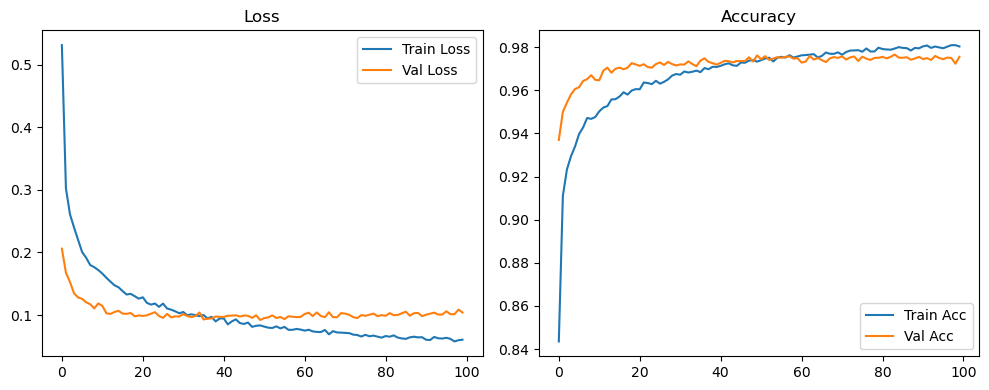

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2571, Acc: 0.9237 | Val Loss: 0.1547, Acc: 0.9537


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1330, Acc: 0.9601 | Val Loss: 0.1395, Acc: 0.9567


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0993, Acc: 0.9698 | Val Loss: 0.1214, Acc: 0.9625


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9753 | Val Loss: 0.1127, Acc: 0.9674


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9796 | Val Loss: 0.1167, Acc: 0.9682


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9815 | Val Loss: 0.1274, Acc: 0.9658


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9839 | Val Loss: 0.1174, Acc: 0.9705


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9861 | Val Loss: 0.1199, Acc: 0.9707


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.1349, Acc: 0.9694


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9901 | Val Loss: 0.1324, Acc: 0.9718


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9897 | Val Loss: 0.1296, Acc: 0.9699


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9909 | Val Loss: 0.1242, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9918 | Val Loss: 0.1308, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9913 | Val Loss: 0.1228, Acc: 0.9722


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9927 | Val Loss: 0.1300, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.1515, Acc: 0.9680


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9931 | Val Loss: 0.1283, Acc: 0.9732


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9936 | Val Loss: 0.1483, Acc: 0.9708


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.1355, Acc: 0.9725


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1431, Acc: 0.9692


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9941 | Val Loss: 0.1390, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.1361, Acc: 0.9734


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1483, Acc: 0.9723


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.1562, Acc: 0.9737


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9948 | Val Loss: 0.1568, Acc: 0.9722


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.1617, Acc: 0.9704


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9956 | Val Loss: 0.1690, Acc: 0.9718


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.1478, Acc: 0.9749


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1791, Acc: 0.9732


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9961 | Val Loss: 0.1515, Acc: 0.9702


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.1573, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1376, Acc: 0.9737


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1639, Acc: 0.9740


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1551, Acc: 0.9755


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9965 | Val Loss: 0.1603, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1790, Acc: 0.9740


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1750, Acc: 0.9753


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9964 | Val Loss: 0.1619, Acc: 0.9741


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9971 | Val Loss: 0.1656, Acc: 0.9742


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9967 | Val Loss: 0.1504, Acc: 0.9745


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.1606, Acc: 0.9754


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1887, Acc: 0.9732


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9971 | Val Loss: 0.1912, Acc: 0.9719


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9964 | Val Loss: 0.1602, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1630, Acc: 0.9755


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1625, Acc: 0.9760


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1922, Acc: 0.9744


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9969 | Val Loss: 0.1771, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1726, Acc: 0.9758


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1584, Acc: 0.9758


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.1731, Acc: 0.9758


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9971 | Val Loss: 0.1734, Acc: 0.9757


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.2098, Acc: 0.9731


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9976 | Val Loss: 0.1961, Acc: 0.9757


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9977 | Val Loss: 0.2001, Acc: 0.9731


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1778, Acc: 0.9753


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1962, Acc: 0.9748


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9979 | Val Loss: 0.1745, Acc: 0.9765


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9983 | Val Loss: 0.1911, Acc: 0.9753


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1791, Acc: 0.9757


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1995, Acc: 0.9745


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.2173, Acc: 0.9732


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9978 | Val Loss: 0.1961, Acc: 0.9738


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.2067, Acc: 0.9730


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.2183, Acc: 0.9742


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.2046, Acc: 0.9742


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9983 | Val Loss: 0.1861, Acc: 0.9752


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1885, Acc: 0.9742


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.2199, Acc: 0.9714


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9982 | Val Loss: 0.1997, Acc: 0.9750


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.2000, Acc: 0.9768


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.2289, Acc: 0.9735


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.2150, Acc: 0.9749


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.2168, Acc: 0.9752


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.2163, Acc: 0.9754


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1942, Acc: 0.9753


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9977 | Val Loss: 0.2039, Acc: 0.9748


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.2223, Acc: 0.9752


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9985 | Val Loss: 0.2121, Acc: 0.9754


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.2056, Acc: 0.9756


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9977 | Val Loss: 0.1977, Acc: 0.9778


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.2243, Acc: 0.9753


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9985 | Val Loss: 0.2238, Acc: 0.9752


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9985 | Val Loss: 0.2184, Acc: 0.9743


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9984 | Val Loss: 0.2142, Acc: 0.9757


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.2067, Acc: 0.9759


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.2024, Acc: 0.9760


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.2178, Acc: 0.9762


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.2247, Acc: 0.9750


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.2251, Acc: 0.9755


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9987 | Val Loss: 0.2259, Acc: 0.9745


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.2211, Acc: 0.9772


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9988 | Val Loss: 0.2090, Acc: 0.9758


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.2164, Acc: 0.9757


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.2111, Acc: 0.9746


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.2258, Acc: 0.9760


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.2164, Acc: 0.9780


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.2164, Acc: 0.9768


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.2360, Acc: 0.9755


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.2266, Acc: 0.9759


Final Test Loss: 0.2199 Accuracy: 0.9770


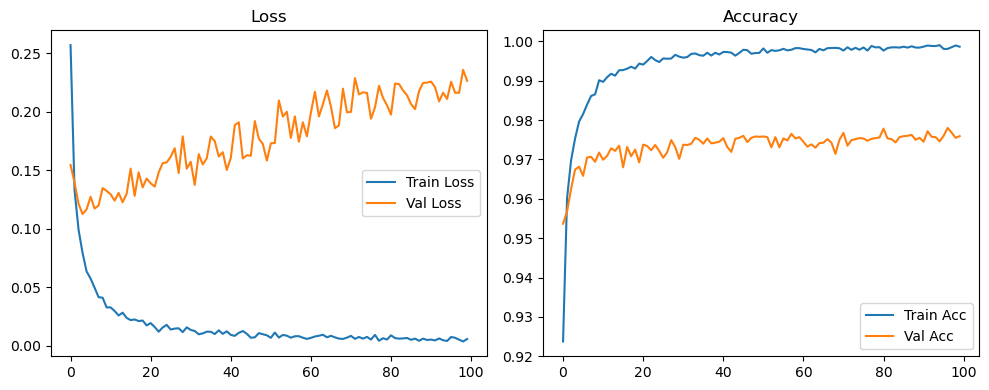

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3037, Acc: 0.9095 | Val Loss: 0.1552, Acc: 0.9535


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1770, Acc: 0.9480 | Val Loss: 0.1350, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9589 | Val Loss: 0.1284, Acc: 0.9629


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1192, Acc: 0.9638 | Val Loss: 0.1250, Acc: 0.9635


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1067, Acc: 0.9671 | Val Loss: 0.1214, Acc: 0.9657


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0928, Acc: 0.9715 | Val Loss: 0.1220, Acc: 0.9681


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9724 | Val Loss: 0.1088, Acc: 0.9718


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9771 | Val Loss: 0.1187, Acc: 0.9682


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9774 | Val Loss: 0.1196, Acc: 0.9718


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9798 | Val Loss: 0.1198, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9799 | Val Loss: 0.1225, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9817 | Val Loss: 0.1072, Acc: 0.9737


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9829 | Val Loss: 0.1240, Acc: 0.9713


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9832 | Val Loss: 0.1163, Acc: 0.9728


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9843 | Val Loss: 0.1276, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9850 | Val Loss: 0.1158, Acc: 0.9724


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9858 | Val Loss: 0.1211, Acc: 0.9714


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9859 | Val Loss: 0.1222, Acc: 0.9732


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9873 | Val Loss: 0.1188, Acc: 0.9758


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9872 | Val Loss: 0.1094, Acc: 0.9763


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9873 | Val Loss: 0.1330, Acc: 0.9713


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9881 | Val Loss: 0.1240, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9871 | Val Loss: 0.1196, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9900 | Val Loss: 0.1479, Acc: 0.9734


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.1337, Acc: 0.9740


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9892 | Val Loss: 0.1355, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9893 | Val Loss: 0.1356, Acc: 0.9753


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9906 | Val Loss: 0.1289, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9900 | Val Loss: 0.1369, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9905 | Val Loss: 0.1413, Acc: 0.9752


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9913 | Val Loss: 0.1511, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9909 | Val Loss: 0.1375, Acc: 0.9755


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9914 | Val Loss: 0.1397, Acc: 0.9736


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9925 | Val Loss: 0.1459, Acc: 0.9750


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9916 | Val Loss: 0.1500, Acc: 0.9735


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9906 | Val Loss: 0.1333, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9921 | Val Loss: 0.1400, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9918 | Val Loss: 0.1334, Acc: 0.9753


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9927 | Val Loss: 0.1458, Acc: 0.9752


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9919 | Val Loss: 0.1392, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9927 | Val Loss: 0.1591, Acc: 0.9748


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9920 | Val Loss: 0.1402, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9928 | Val Loss: 0.1585, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9927 | Val Loss: 0.1561, Acc: 0.9728


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9928 | Val Loss: 0.1515, Acc: 0.9750


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9937 | Val Loss: 0.1647, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9924 | Val Loss: 0.1527, Acc: 0.9759


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.1703, Acc: 0.9764


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9927 | Val Loss: 0.1687, Acc: 0.9740


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9933 | Val Loss: 0.1681, Acc: 0.9768


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9926 | Val Loss: 0.1511, Acc: 0.9762


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9932 | Val Loss: 0.1584, Acc: 0.9755


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9935 | Val Loss: 0.1507, Acc: 0.9768


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9927 | Val Loss: 0.1855, Acc: 0.9734


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9931 | Val Loss: 0.1723, Acc: 0.9747


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9939 | Val Loss: 0.1905, Acc: 0.9753


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9943 | Val Loss: 0.1747, Acc: 0.9766


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9933 | Val Loss: 0.1545, Acc: 0.9767


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9942 | Val Loss: 0.1641, Acc: 0.9758


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9943 | Val Loss: 0.1624, Acc: 0.9755


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9936 | Val Loss: 0.1586, Acc: 0.9745


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9944 | Val Loss: 0.1752, Acc: 0.9769


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9942 | Val Loss: 0.1802, Acc: 0.9757


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9946 | Val Loss: 0.1864, Acc: 0.9752


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9947 | Val Loss: 0.1903, Acc: 0.9751


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9930 | Val Loss: 0.1511, Acc: 0.9772


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9953 | Val Loss: 0.1658, Acc: 0.9764


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9935 | Val Loss: 0.1691, Acc: 0.9752


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9951 | Val Loss: 0.1646, Acc: 0.9768


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9942 | Val Loss: 0.1682, Acc: 0.9762


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9950 | Val Loss: 0.2009, Acc: 0.9743


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9942 | Val Loss: 0.1876, Acc: 0.9764


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9951 | Val Loss: 0.1995, Acc: 0.9759


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9950 | Val Loss: 0.1905, Acc: 0.9752


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9947 | Val Loss: 0.1961, Acc: 0.9768


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9944 | Val Loss: 0.1787, Acc: 0.9768


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9955 | Val Loss: 0.1862, Acc: 0.9771


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9949 | Val Loss: 0.2041, Acc: 0.9772


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9955 | Val Loss: 0.1927, Acc: 0.9754


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9953 | Val Loss: 0.1951, Acc: 0.9746


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9954 | Val Loss: 0.1916, Acc: 0.9765


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9950 | Val Loss: 0.2050, Acc: 0.9755


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9953 | Val Loss: 0.1839, Acc: 0.9761


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9951 | Val Loss: 0.1653, Acc: 0.9782


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9951 | Val Loss: 0.1834, Acc: 0.9773


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9950 | Val Loss: 0.1802, Acc: 0.9769


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9956 | Val Loss: 0.1741, Acc: 0.9768


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9945 | Val Loss: 0.1845, Acc: 0.9768


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9953 | Val Loss: 0.1795, Acc: 0.9771


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9963 | Val Loss: 0.1886, Acc: 0.9762


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9954 | Val Loss: 0.1876, Acc: 0.9768


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9960 | Val Loss: 0.1772, Acc: 0.9771


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9960 | Val Loss: 0.1894, Acc: 0.9787


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9954 | Val Loss: 0.1742, Acc: 0.9786


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9959 | Val Loss: 0.1809, Acc: 0.9772


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9961 | Val Loss: 0.1793, Acc: 0.9770


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9956 | Val Loss: 0.2039, Acc: 0.9762


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9950 | Val Loss: 0.1768, Acc: 0.9753


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9952 | Val Loss: 0.1891, Acc: 0.9774


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9956 | Val Loss: 0.1970, Acc: 0.9769


Final Test Loss: 0.1755 Accuracy: 0.9800


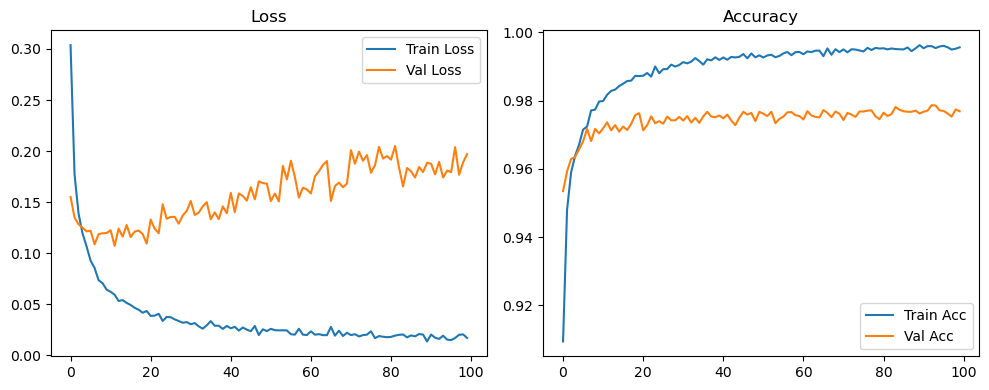

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4601, Acc: 0.8651 | Val Loss: 0.2044, Acc: 0.9386


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3065, Acc: 0.9111 | Val Loss: 0.1592, Acc: 0.9517


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2559, Acc: 0.9272 | Val Loss: 0.1602, Acc: 0.9527


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2314, Acc: 0.9335 | Val Loss: 0.1467, Acc: 0.9587


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2194, Acc: 0.9359 | Val Loss: 0.1291, Acc: 0.9639


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1989, Acc: 0.9437 | Val Loss: 0.1257, Acc: 0.9626


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1888, Acc: 0.9449 | Val Loss: 0.1161, Acc: 0.9669


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1760, Acc: 0.9483 | Val Loss: 0.1241, Acc: 0.9672


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1690, Acc: 0.9503 | Val Loss: 0.1172, Acc: 0.9675


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1673, Acc: 0.9511 | Val Loss: 0.1081, Acc: 0.9688


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1628, Acc: 0.9537 | Val Loss: 0.1169, Acc: 0.9692


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1503, Acc: 0.9567 | Val Loss: 0.1061, Acc: 0.9721


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1480, Acc: 0.9564 | Val Loss: 0.1061, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1435, Acc: 0.9582 | Val Loss: 0.1033, Acc: 0.9710


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1336, Acc: 0.9611 | Val Loss: 0.1148, Acc: 0.9692


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1350, Acc: 0.9618 | Val Loss: 0.1162, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1332, Acc: 0.9604 | Val Loss: 0.1103, Acc: 0.9708


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1298, Acc: 0.9618 | Val Loss: 0.1089, Acc: 0.9715


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1271, Acc: 0.9625 | Val Loss: 0.1089, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1264, Acc: 0.9638 | Val Loss: 0.1194, Acc: 0.9718


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9647 | Val Loss: 0.1061, Acc: 0.9723


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1182, Acc: 0.9661 | Val Loss: 0.1215, Acc: 0.9721


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1180, Acc: 0.9659 | Val Loss: 0.1060, Acc: 0.9729


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1138, Acc: 0.9671 | Val Loss: 0.1158, Acc: 0.9725


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1135, Acc: 0.9663 | Val Loss: 0.1130, Acc: 0.9729


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1156, Acc: 0.9669 | Val Loss: 0.1171, Acc: 0.9702


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1134, Acc: 0.9670 | Val Loss: 0.1168, Acc: 0.9718


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1114, Acc: 0.9670 | Val Loss: 0.1082, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1084, Acc: 0.9683 | Val Loss: 0.1177, Acc: 0.9724


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9689 | Val Loss: 0.1152, Acc: 0.9741


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1087, Acc: 0.9687 | Val Loss: 0.1125, Acc: 0.9712


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9694 | Val Loss: 0.1225, Acc: 0.9727


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1041, Acc: 0.9691 | Val Loss: 0.1214, Acc: 0.9716


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9705 | Val Loss: 0.1117, Acc: 0.9742


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0933, Acc: 0.9723 | Val Loss: 0.1163, Acc: 0.9738


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9711 | Val Loss: 0.1166, Acc: 0.9732


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9723 | Val Loss: 0.1128, Acc: 0.9750


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1003, Acc: 0.9708 | Val Loss: 0.1088, Acc: 0.9764


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0938, Acc: 0.9731 | Val Loss: 0.1146, Acc: 0.9731


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0929, Acc: 0.9729 | Val Loss: 0.1195, Acc: 0.9736


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0960, Acc: 0.9725 | Val Loss: 0.1112, Acc: 0.9720


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0896, Acc: 0.9737 | Val Loss: 0.1102, Acc: 0.9743


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9742 | Val Loss: 0.1174, Acc: 0.9736


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0854, Acc: 0.9759 | Val Loss: 0.1186, Acc: 0.9746


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0888, Acc: 0.9744 | Val Loss: 0.1146, Acc: 0.9750


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0924, Acc: 0.9738 | Val Loss: 0.1196, Acc: 0.9744


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9751 | Val Loss: 0.1094, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9748 | Val Loss: 0.1302, Acc: 0.9738


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9740 | Val Loss: 0.1129, Acc: 0.9753


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9752 | Val Loss: 0.1227, Acc: 0.9760


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0851, Acc: 0.9752 | Val Loss: 0.1189, Acc: 0.9743


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9741 | Val Loss: 0.1214, Acc: 0.9751


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0842, Acc: 0.9752 | Val Loss: 0.1222, Acc: 0.9740


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9763 | Val Loss: 0.1193, Acc: 0.9740


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0849, Acc: 0.9754 | Val Loss: 0.1095, Acc: 0.9749


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0847, Acc: 0.9754 | Val Loss: 0.1214, Acc: 0.9748


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0796, Acc: 0.9772 | Val Loss: 0.1232, Acc: 0.9752


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9781 | Val Loss: 0.1325, Acc: 0.9750


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0807, Acc: 0.9769 | Val Loss: 0.1347, Acc: 0.9745


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9769 | Val Loss: 0.1205, Acc: 0.9748


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0759, Acc: 0.9786 | Val Loss: 0.1264, Acc: 0.9749


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9776 | Val Loss: 0.1367, Acc: 0.9746


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9778 | Val Loss: 0.1248, Acc: 0.9761


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9788 | Val Loss: 0.1259, Acc: 0.9727


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9773 | Val Loss: 0.1295, Acc: 0.9742


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9765 | Val Loss: 0.1266, Acc: 0.9739


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0759, Acc: 0.9786 | Val Loss: 0.1253, Acc: 0.9738


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9784 | Val Loss: 0.1225, Acc: 0.9742


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9800 | Val Loss: 0.1247, Acc: 0.9738


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0788, Acc: 0.9781 | Val Loss: 0.1160, Acc: 0.9745


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9789 | Val Loss: 0.1339, Acc: 0.9746


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0721, Acc: 0.9788 | Val Loss: 0.1328, Acc: 0.9730


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9776 | Val Loss: 0.1271, Acc: 0.9746


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9788 | Val Loss: 0.1202, Acc: 0.9752


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0747, Acc: 0.9783 | Val Loss: 0.1329, Acc: 0.9745


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9789 | Val Loss: 0.1231, Acc: 0.9751


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9790 | Val Loss: 0.1301, Acc: 0.9762


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9803 | Val Loss: 0.1323, Acc: 0.9741


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9796 | Val Loss: 0.1323, Acc: 0.9742


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9786 | Val Loss: 0.1234, Acc: 0.9745


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0667, Acc: 0.9805 | Val Loss: 0.1370, Acc: 0.9742


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0684, Acc: 0.9809 | Val Loss: 0.1265, Acc: 0.9766


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9796 | Val Loss: 0.1383, Acc: 0.9748


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9808 | Val Loss: 0.1274, Acc: 0.9747


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9811 | Val Loss: 0.1320, Acc: 0.9750


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0735, Acc: 0.9790 | Val Loss: 0.1273, Acc: 0.9747


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0745, Acc: 0.9785 | Val Loss: 0.1252, Acc: 0.9746


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0699, Acc: 0.9801 | Val Loss: 0.1254, Acc: 0.9756


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9815 | Val Loss: 0.1404, Acc: 0.9752


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9805 | Val Loss: 0.1218, Acc: 0.9749


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9808 | Val Loss: 0.1306, Acc: 0.9747


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9811 | Val Loss: 0.1286, Acc: 0.9749


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9810 | Val Loss: 0.1222, Acc: 0.9762


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9808 | Val Loss: 0.1300, Acc: 0.9739


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9826 | Val Loss: 0.1216, Acc: 0.9765


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0699, Acc: 0.9811 | Val Loss: 0.1301, Acc: 0.9743


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0708, Acc: 0.9803 | Val Loss: 0.1224, Acc: 0.9764


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9814 | Val Loss: 0.1266, Acc: 0.9769


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9826 | Val Loss: 0.1263, Acc: 0.9744


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9808 | Val Loss: 0.1243, Acc: 0.9738


Final Test Loss: 0.1280 Accuracy: 0.9769


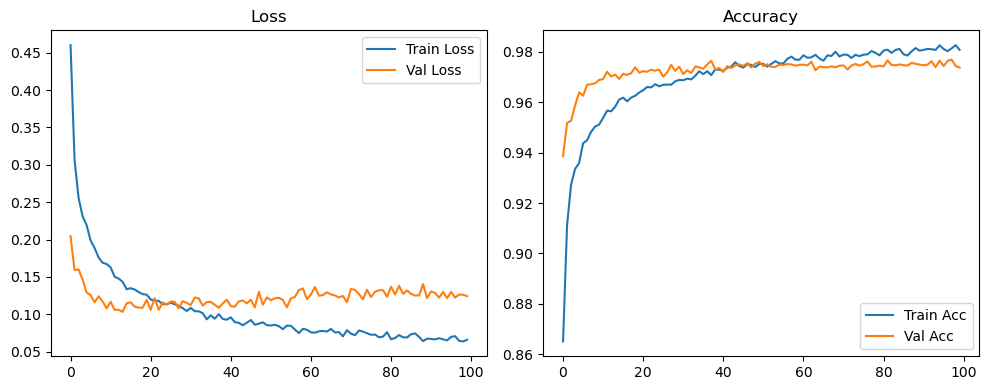

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2571, Acc: 0.9237 | Val Loss: 0.1547, Acc: 0.9537


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1330, Acc: 0.9601 | Val Loss: 0.1395, Acc: 0.9567


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0993, Acc: 0.9698 | Val Loss: 0.1214, Acc: 0.9625


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9753 | Val Loss: 0.1127, Acc: 0.9674


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9796 | Val Loss: 0.1167, Acc: 0.9682


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9815 | Val Loss: 0.1274, Acc: 0.9658


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9839 | Val Loss: 0.1174, Acc: 0.9705


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9861 | Val Loss: 0.1199, Acc: 0.9707


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.1349, Acc: 0.9694


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9901 | Val Loss: 0.1324, Acc: 0.9718


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9897 | Val Loss: 0.1296, Acc: 0.9699


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9909 | Val Loss: 0.1242, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9918 | Val Loss: 0.1308, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9913 | Val Loss: 0.1228, Acc: 0.9722


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9927 | Val Loss: 0.1300, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.1515, Acc: 0.9680


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9931 | Val Loss: 0.1283, Acc: 0.9732


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9936 | Val Loss: 0.1483, Acc: 0.9708


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.1355, Acc: 0.9725


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1431, Acc: 0.9692


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9941 | Val Loss: 0.1390, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.1361, Acc: 0.9734


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1483, Acc: 0.9723


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.1562, Acc: 0.9737


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9948 | Val Loss: 0.1568, Acc: 0.9722


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.1617, Acc: 0.9704


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9956 | Val Loss: 0.1690, Acc: 0.9718


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.1478, Acc: 0.9749


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1791, Acc: 0.9732


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9961 | Val Loss: 0.1515, Acc: 0.9702


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.1573, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1376, Acc: 0.9737


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1639, Acc: 0.9740


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1551, Acc: 0.9755


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9965 | Val Loss: 0.1603, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1790, Acc: 0.9740


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1750, Acc: 0.9753


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9964 | Val Loss: 0.1619, Acc: 0.9741


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9971 | Val Loss: 0.1656, Acc: 0.9742


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9967 | Val Loss: 0.1504, Acc: 0.9745


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.1606, Acc: 0.9754


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1887, Acc: 0.9732


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9971 | Val Loss: 0.1912, Acc: 0.9719


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9964 | Val Loss: 0.1602, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1630, Acc: 0.9755


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1625, Acc: 0.9760


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1922, Acc: 0.9744


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9969 | Val Loss: 0.1771, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1726, Acc: 0.9758


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1584, Acc: 0.9758


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1575, Acc: 0.9774


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1682, Acc: 0.9761


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1744, Acc: 0.9773


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1798, Acc: 0.9784


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1948, Acc: 0.9768


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1824, Acc: 0.9789


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1761, Acc: 0.9772


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.2130, Acc: 0.9772


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2080, Acc: 0.9752


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.2115, Acc: 0.9772


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.2124, Acc: 0.9769


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2019, Acc: 0.9787


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1986, Acc: 0.9768


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.2057, Acc: 0.9764


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.2022, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.2148, Acc: 0.9767


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.2190, Acc: 0.9777


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2109, Acc: 0.9775


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.2225, Acc: 0.9773


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.2203, Acc: 0.9771


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.2166, Acc: 0.9768


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.2202, Acc: 0.9766


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.2138, Acc: 0.9770


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9993 | Val Loss: 0.2120, Acc: 0.9772


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2215, Acc: 0.9747


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.2018, Acc: 0.9776


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1975, Acc: 0.9780


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.2319, Acc: 0.9748


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2153, Acc: 0.9779


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.2297, Acc: 0.9772


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2125, Acc: 0.9774


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2181, Acc: 0.9779


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2174, Acc: 0.9787


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2101, Acc: 0.9780


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2175, Acc: 0.9778


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.2146, Acc: 0.9781


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2198, Acc: 0.9779


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2093, Acc: 0.9792


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2174, Acc: 0.9777


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2142, Acc: 0.9783


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2163, Acc: 0.9778


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2137, Acc: 0.9779


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2138, Acc: 0.9780


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2181, Acc: 0.9784


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2173, Acc: 0.9788


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2295, Acc: 0.9782


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2268, Acc: 0.9792


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.2232, Acc: 0.9776


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2320, Acc: 0.9774


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2241, Acc: 0.9783


Final Test Loss: 0.1849 Accuracy: 0.9824


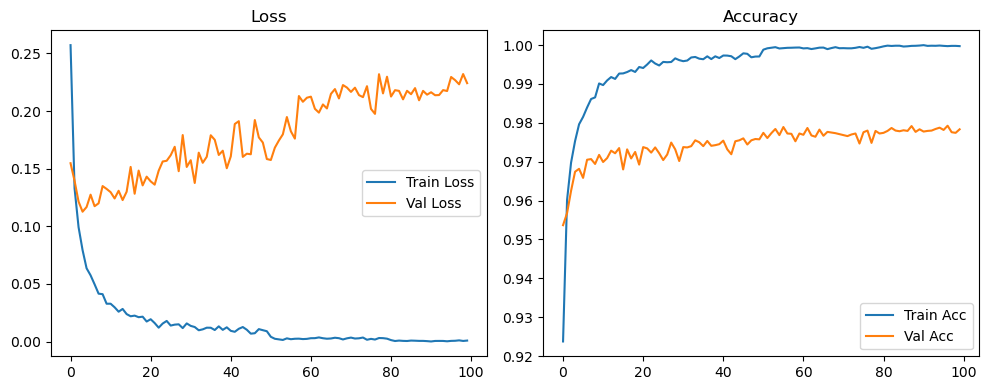

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3037, Acc: 0.9095 | Val Loss: 0.1552, Acc: 0.9535


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1770, Acc: 0.9480 | Val Loss: 0.1350, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9589 | Val Loss: 0.1284, Acc: 0.9629


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1192, Acc: 0.9638 | Val Loss: 0.1250, Acc: 0.9635


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1067, Acc: 0.9671 | Val Loss: 0.1214, Acc: 0.9657


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0928, Acc: 0.9715 | Val Loss: 0.1220, Acc: 0.9681


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9724 | Val Loss: 0.1088, Acc: 0.9718


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9771 | Val Loss: 0.1187, Acc: 0.9682


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9774 | Val Loss: 0.1196, Acc: 0.9718


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9798 | Val Loss: 0.1198, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9799 | Val Loss: 0.1225, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9817 | Val Loss: 0.1072, Acc: 0.9737


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9829 | Val Loss: 0.1240, Acc: 0.9713


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9832 | Val Loss: 0.1163, Acc: 0.9728


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9843 | Val Loss: 0.1276, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9850 | Val Loss: 0.1158, Acc: 0.9724


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9858 | Val Loss: 0.1211, Acc: 0.9714


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9859 | Val Loss: 0.1222, Acc: 0.9732


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9873 | Val Loss: 0.1188, Acc: 0.9758


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9872 | Val Loss: 0.1094, Acc: 0.9763


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9873 | Val Loss: 0.1330, Acc: 0.9713


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9881 | Val Loss: 0.1240, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9871 | Val Loss: 0.1196, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9900 | Val Loss: 0.1479, Acc: 0.9734


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.1337, Acc: 0.9740


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9892 | Val Loss: 0.1355, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9893 | Val Loss: 0.1356, Acc: 0.9753


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9906 | Val Loss: 0.1289, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9900 | Val Loss: 0.1369, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9905 | Val Loss: 0.1413, Acc: 0.9752


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9913 | Val Loss: 0.1511, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9909 | Val Loss: 0.1375, Acc: 0.9755


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9914 | Val Loss: 0.1397, Acc: 0.9736


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9925 | Val Loss: 0.1459, Acc: 0.9750


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9916 | Val Loss: 0.1500, Acc: 0.9735


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9906 | Val Loss: 0.1333, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9921 | Val Loss: 0.1400, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9918 | Val Loss: 0.1334, Acc: 0.9753


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9927 | Val Loss: 0.1458, Acc: 0.9752


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9919 | Val Loss: 0.1392, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9927 | Val Loss: 0.1591, Acc: 0.9748


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9920 | Val Loss: 0.1402, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9928 | Val Loss: 0.1585, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9927 | Val Loss: 0.1561, Acc: 0.9728


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9928 | Val Loss: 0.1515, Acc: 0.9750


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9937 | Val Loss: 0.1647, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9924 | Val Loss: 0.1527, Acc: 0.9759


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.1703, Acc: 0.9764


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9927 | Val Loss: 0.1687, Acc: 0.9740


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9933 | Val Loss: 0.1681, Acc: 0.9768


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9952 | Val Loss: 0.1502, Acc: 0.9778


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9962 | Val Loss: 0.1513, Acc: 0.9778


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.1543, Acc: 0.9775


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9960 | Val Loss: 0.1566, Acc: 0.9769


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1628, Acc: 0.9778


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1616, Acc: 0.9791


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1706, Acc: 0.9772


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1578, Acc: 0.9775


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1571, Acc: 0.9778


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9976 | Val Loss: 0.1582, Acc: 0.9769


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9971 | Val Loss: 0.1563, Acc: 0.9786


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.1471, Acc: 0.9787


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1579, Acc: 0.9782


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9969 | Val Loss: 0.1707, Acc: 0.9771


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.1654, Acc: 0.9781


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9968 | Val Loss: 0.1485, Acc: 0.9772


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9970 | Val Loss: 0.1620, Acc: 0.9766


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.1633, Acc: 0.9778


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1691, Acc: 0.9774


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9966 | Val Loss: 0.1589, Acc: 0.9782


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9970 | Val Loss: 0.1666, Acc: 0.9773


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9974 | Val Loss: 0.1680, Acc: 0.9776


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1749, Acc: 0.9778


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.1816, Acc: 0.9761


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.1606, Acc: 0.9780


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1841, Acc: 0.9769


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9976 | Val Loss: 0.1769, Acc: 0.9772


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1780, Acc: 0.9771


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.1897, Acc: 0.9771


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1890, Acc: 0.9752


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9981 | Val Loss: 0.1789, Acc: 0.9784


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1853, Acc: 0.9782


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1778, Acc: 0.9787


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1783, Acc: 0.9788


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1760, Acc: 0.9774


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1731, Acc: 0.9788


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1819, Acc: 0.9785


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1797, Acc: 0.9791


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1813, Acc: 0.9783


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1790, Acc: 0.9778


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1857, Acc: 0.9773


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1743, Acc: 0.9786


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1783, Acc: 0.9795


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1797, Acc: 0.9792


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1835, Acc: 0.9788


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1797, Acc: 0.9790


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.1750, Acc: 0.9796


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1690, Acc: 0.9792


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9988 | Val Loss: 0.1686, Acc: 0.9786


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1798, Acc: 0.9789


Final Test Loss: 0.1673 Accuracy: 0.9811


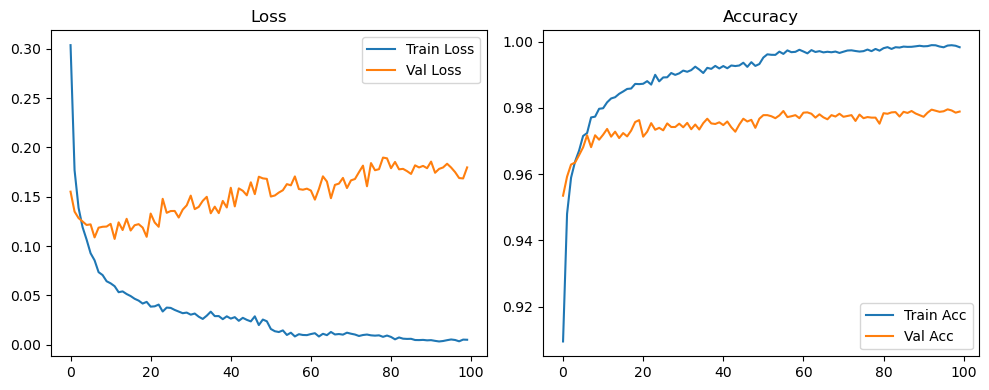

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4601, Acc: 0.8651 | Val Loss: 0.2044, Acc: 0.9386


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3065, Acc: 0.9111 | Val Loss: 0.1592, Acc: 0.9517


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2559, Acc: 0.9272 | Val Loss: 0.1602, Acc: 0.9527


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2314, Acc: 0.9335 | Val Loss: 0.1467, Acc: 0.9587


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2194, Acc: 0.9359 | Val Loss: 0.1291, Acc: 0.9639


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1989, Acc: 0.9437 | Val Loss: 0.1257, Acc: 0.9626


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1888, Acc: 0.9449 | Val Loss: 0.1161, Acc: 0.9669


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1760, Acc: 0.9483 | Val Loss: 0.1241, Acc: 0.9672


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1690, Acc: 0.9503 | Val Loss: 0.1172, Acc: 0.9675


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1673, Acc: 0.9511 | Val Loss: 0.1081, Acc: 0.9688


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1628, Acc: 0.9537 | Val Loss: 0.1169, Acc: 0.9692


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1503, Acc: 0.9567 | Val Loss: 0.1061, Acc: 0.9721


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1480, Acc: 0.9564 | Val Loss: 0.1061, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1435, Acc: 0.9582 | Val Loss: 0.1033, Acc: 0.9710


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1336, Acc: 0.9611 | Val Loss: 0.1148, Acc: 0.9692


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1350, Acc: 0.9618 | Val Loss: 0.1162, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1332, Acc: 0.9604 | Val Loss: 0.1103, Acc: 0.9708


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1298, Acc: 0.9618 | Val Loss: 0.1089, Acc: 0.9715


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1271, Acc: 0.9625 | Val Loss: 0.1089, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1264, Acc: 0.9638 | Val Loss: 0.1194, Acc: 0.9718


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9647 | Val Loss: 0.1061, Acc: 0.9723


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1182, Acc: 0.9661 | Val Loss: 0.1215, Acc: 0.9721


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1180, Acc: 0.9659 | Val Loss: 0.1060, Acc: 0.9729


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1138, Acc: 0.9671 | Val Loss: 0.1158, Acc: 0.9725


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1135, Acc: 0.9663 | Val Loss: 0.1130, Acc: 0.9729


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1156, Acc: 0.9669 | Val Loss: 0.1171, Acc: 0.9702


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1134, Acc: 0.9670 | Val Loss: 0.1168, Acc: 0.9718


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1114, Acc: 0.9670 | Val Loss: 0.1082, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1084, Acc: 0.9683 | Val Loss: 0.1177, Acc: 0.9724


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9689 | Val Loss: 0.1152, Acc: 0.9741


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1087, Acc: 0.9687 | Val Loss: 0.1125, Acc: 0.9712


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9694 | Val Loss: 0.1225, Acc: 0.9727


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1041, Acc: 0.9691 | Val Loss: 0.1214, Acc: 0.9716


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9705 | Val Loss: 0.1117, Acc: 0.9742


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0933, Acc: 0.9723 | Val Loss: 0.1163, Acc: 0.9738


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9711 | Val Loss: 0.1166, Acc: 0.9732


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9723 | Val Loss: 0.1128, Acc: 0.9750


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1003, Acc: 0.9708 | Val Loss: 0.1088, Acc: 0.9764


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0938, Acc: 0.9731 | Val Loss: 0.1146, Acc: 0.9731


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0929, Acc: 0.9729 | Val Loss: 0.1195, Acc: 0.9736


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0960, Acc: 0.9725 | Val Loss: 0.1112, Acc: 0.9720


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0896, Acc: 0.9737 | Val Loss: 0.1102, Acc: 0.9743


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9742 | Val Loss: 0.1174, Acc: 0.9736


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0854, Acc: 0.9759 | Val Loss: 0.1186, Acc: 0.9746


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0888, Acc: 0.9744 | Val Loss: 0.1146, Acc: 0.9750


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0924, Acc: 0.9738 | Val Loss: 0.1196, Acc: 0.9744


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9751 | Val Loss: 0.1094, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9748 | Val Loss: 0.1302, Acc: 0.9738


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9740 | Val Loss: 0.1129, Acc: 0.9753


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9752 | Val Loss: 0.1227, Acc: 0.9760


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9790 | Val Loss: 0.1098, Acc: 0.9768


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9802 | Val Loss: 0.1095, Acc: 0.9760


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9821 | Val Loss: 0.1085, Acc: 0.9765


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9829 | Val Loss: 0.1164, Acc: 0.9762


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9820 | Val Loss: 0.1091, Acc: 0.9768


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9824 | Val Loss: 0.1067, Acc: 0.9763


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9835 | Val Loss: 0.1175, Acc: 0.9760


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9837 | Val Loss: 0.1141, Acc: 0.9768


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9838 | Val Loss: 0.1128, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9835 | Val Loss: 0.1118, Acc: 0.9762


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9851 | Val Loss: 0.1204, Acc: 0.9764


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9844 | Val Loss: 0.1166, Acc: 0.9757


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9853 | Val Loss: 0.1129, Acc: 0.9772


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9834 | Val Loss: 0.1099, Acc: 0.9743


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9841 | Val Loss: 0.1182, Acc: 0.9765


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9832 | Val Loss: 0.1178, Acc: 0.9762


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9845 | Val Loss: 0.1210, Acc: 0.9742


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9850 | Val Loss: 0.1161, Acc: 0.9752


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9855 | Val Loss: 0.1155, Acc: 0.9757


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0497, Acc: 0.9843 | Val Loss: 0.1218, Acc: 0.9749


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9844 | Val Loss: 0.1150, Acc: 0.9766


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9848 | Val Loss: 0.1258, Acc: 0.9751


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9839 | Val Loss: 0.1197, Acc: 0.9771


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9852 | Val Loss: 0.1209, Acc: 0.9764


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9854 | Val Loss: 0.1254, Acc: 0.9762


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9858 | Val Loss: 0.1222, Acc: 0.9768


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9857 | Val Loss: 0.1154, Acc: 0.9784


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9855 | Val Loss: 0.1215, Acc: 0.9758


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9860 | Val Loss: 0.1247, Acc: 0.9771


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9853 | Val Loss: 0.1159, Acc: 0.9758


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9869 | Val Loss: 0.1220, Acc: 0.9758


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9880 | Val Loss: 0.1263, Acc: 0.9758


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9881 | Val Loss: 0.1149, Acc: 0.9766


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9881 | Val Loss: 0.1150, Acc: 0.9779


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9889 | Val Loss: 0.1173, Acc: 0.9773


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9890 | Val Loss: 0.1118, Acc: 0.9774


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9885 | Val Loss: 0.1110, Acc: 0.9768


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9897 | Val Loss: 0.1129, Acc: 0.9772


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9901 | Val Loss: 0.1238, Acc: 0.9775


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9898 | Val Loss: 0.1127, Acc: 0.9785


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9900 | Val Loss: 0.1213, Acc: 0.9760


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9891 | Val Loss: 0.1170, Acc: 0.9783


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9898 | Val Loss: 0.1136, Acc: 0.9769


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9901 | Val Loss: 0.1095, Acc: 0.9784


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.1163, Acc: 0.9778


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9896 | Val Loss: 0.1150, Acc: 0.9771


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9893 | Val Loss: 0.1168, Acc: 0.9769


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9898 | Val Loss: 0.1111, Acc: 0.9778


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9895 | Val Loss: 0.1111, Acc: 0.9782


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9900 | Val Loss: 0.1075, Acc: 0.9786


Final Test Loss: 0.1059 Accuracy: 0.9803


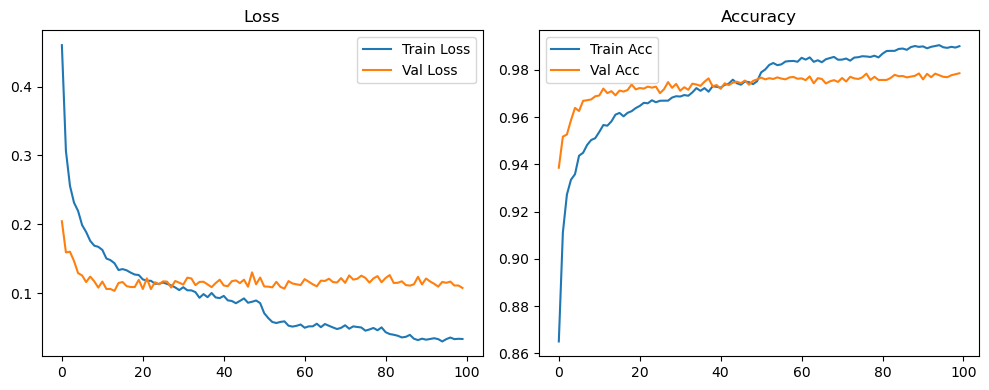

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2571, Acc: 0.9237 | Val Loss: 0.1547, Acc: 0.9537


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1330, Acc: 0.9601 | Val Loss: 0.1395, Acc: 0.9567


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0993, Acc: 0.9698 | Val Loss: 0.1214, Acc: 0.9625


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9753 | Val Loss: 0.1127, Acc: 0.9674


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9796 | Val Loss: 0.1167, Acc: 0.9682


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9815 | Val Loss: 0.1274, Acc: 0.9658


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9839 | Val Loss: 0.1174, Acc: 0.9705


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9861 | Val Loss: 0.1199, Acc: 0.9707


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.1349, Acc: 0.9694


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9901 | Val Loss: 0.1324, Acc: 0.9718


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9897 | Val Loss: 0.1296, Acc: 0.9699


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9909 | Val Loss: 0.1242, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9918 | Val Loss: 0.1308, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9913 | Val Loss: 0.1228, Acc: 0.9722


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9927 | Val Loss: 0.1300, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.1515, Acc: 0.9680


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9931 | Val Loss: 0.1283, Acc: 0.9732


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9936 | Val Loss: 0.1483, Acc: 0.9708


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.1355, Acc: 0.9725


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1431, Acc: 0.9692


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9941 | Val Loss: 0.1390, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.1361, Acc: 0.9734


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1483, Acc: 0.9723


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.1562, Acc: 0.9737


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9948 | Val Loss: 0.1568, Acc: 0.9722


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.1617, Acc: 0.9704


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9956 | Val Loss: 0.1690, Acc: 0.9718


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.1478, Acc: 0.9749


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1791, Acc: 0.9732


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9961 | Val Loss: 0.1515, Acc: 0.9702


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.1573, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1376, Acc: 0.9737


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1639, Acc: 0.9740


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1551, Acc: 0.9755


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9965 | Val Loss: 0.1603, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1790, Acc: 0.9740


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1750, Acc: 0.9753


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9964 | Val Loss: 0.1619, Acc: 0.9741


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9971 | Val Loss: 0.1656, Acc: 0.9742


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9967 | Val Loss: 0.1504, Acc: 0.9745


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.1606, Acc: 0.9754


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1887, Acc: 0.9732


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9971 | Val Loss: 0.1912, Acc: 0.9719


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9964 | Val Loss: 0.1602, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1630, Acc: 0.9755


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1625, Acc: 0.9760


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1922, Acc: 0.9744


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9969 | Val Loss: 0.1771, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1726, Acc: 0.9758


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1584, Acc: 0.9758


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1575, Acc: 0.9774


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1682, Acc: 0.9761


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1744, Acc: 0.9773


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1798, Acc: 0.9784


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1948, Acc: 0.9768


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1824, Acc: 0.9789


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1761, Acc: 0.9772


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.2130, Acc: 0.9772


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2080, Acc: 0.9752


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.2115, Acc: 0.9772


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.2124, Acc: 0.9769


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2019, Acc: 0.9787


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1986, Acc: 0.9768


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.2057, Acc: 0.9764


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.2022, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.2148, Acc: 0.9767


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.2190, Acc: 0.9777


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2109, Acc: 0.9775


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.2225, Acc: 0.9773


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.2203, Acc: 0.9771


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.2166, Acc: 0.9768


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.2202, Acc: 0.9766


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.2138, Acc: 0.9770


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9993 | Val Loss: 0.2120, Acc: 0.9772


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2215, Acc: 0.9747


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.2018, Acc: 0.9776


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1975, Acc: 0.9780


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.2319, Acc: 0.9748


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2153, Acc: 0.9779


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.2297, Acc: 0.9772


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2156, Acc: 0.9776


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2148, Acc: 0.9783


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2147, Acc: 0.9782


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2054, Acc: 0.9786


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2110, Acc: 0.9785


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2011, Acc: 0.9783


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1989, Acc: 0.9790


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2006, Acc: 0.9782


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2042, Acc: 0.9787


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2037, Acc: 0.9782


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2130, Acc: 0.9777


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2018, Acc: 0.9792


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2030, Acc: 0.9787


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2044, Acc: 0.9791


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2076, Acc: 0.9788


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2141, Acc: 0.9783


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2186, Acc: 0.9783


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2160, Acc: 0.9791


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2058, Acc: 0.9795


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2174, Acc: 0.9786


Final Test Loss: 0.1810 Accuracy: 0.9812


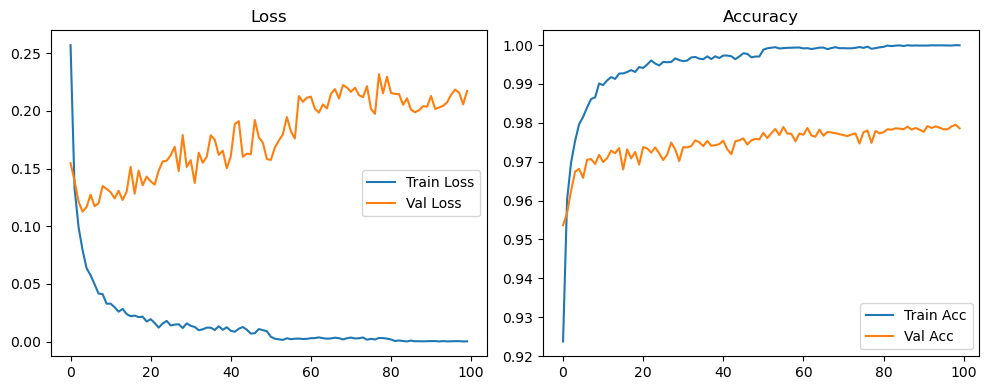

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3037, Acc: 0.9095 | Val Loss: 0.1552, Acc: 0.9535


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1770, Acc: 0.9480 | Val Loss: 0.1350, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9589 | Val Loss: 0.1284, Acc: 0.9629


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1192, Acc: 0.9638 | Val Loss: 0.1250, Acc: 0.9635


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1067, Acc: 0.9671 | Val Loss: 0.1214, Acc: 0.9657


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0928, Acc: 0.9715 | Val Loss: 0.1220, Acc: 0.9681


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9724 | Val Loss: 0.1088, Acc: 0.9718


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9771 | Val Loss: 0.1187, Acc: 0.9682


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9774 | Val Loss: 0.1196, Acc: 0.9718


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9798 | Val Loss: 0.1198, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9799 | Val Loss: 0.1225, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9817 | Val Loss: 0.1072, Acc: 0.9737


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9829 | Val Loss: 0.1240, Acc: 0.9713


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9832 | Val Loss: 0.1163, Acc: 0.9728


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9843 | Val Loss: 0.1276, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9850 | Val Loss: 0.1158, Acc: 0.9724


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9858 | Val Loss: 0.1211, Acc: 0.9714


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9859 | Val Loss: 0.1222, Acc: 0.9732


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9873 | Val Loss: 0.1188, Acc: 0.9758


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9872 | Val Loss: 0.1094, Acc: 0.9763


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9873 | Val Loss: 0.1330, Acc: 0.9713


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9881 | Val Loss: 0.1240, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9871 | Val Loss: 0.1196, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9900 | Val Loss: 0.1479, Acc: 0.9734


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.1337, Acc: 0.9740


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9892 | Val Loss: 0.1355, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9893 | Val Loss: 0.1356, Acc: 0.9753


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9906 | Val Loss: 0.1289, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9900 | Val Loss: 0.1369, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9905 | Val Loss: 0.1413, Acc: 0.9752


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9913 | Val Loss: 0.1511, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9909 | Val Loss: 0.1375, Acc: 0.9755


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9914 | Val Loss: 0.1397, Acc: 0.9736


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9925 | Val Loss: 0.1459, Acc: 0.9750


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9916 | Val Loss: 0.1500, Acc: 0.9735


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9906 | Val Loss: 0.1333, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9921 | Val Loss: 0.1400, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9918 | Val Loss: 0.1334, Acc: 0.9753


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9927 | Val Loss: 0.1458, Acc: 0.9752


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9919 | Val Loss: 0.1392, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9927 | Val Loss: 0.1591, Acc: 0.9748


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9920 | Val Loss: 0.1402, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9928 | Val Loss: 0.1585, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9927 | Val Loss: 0.1561, Acc: 0.9728


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9928 | Val Loss: 0.1515, Acc: 0.9750


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9937 | Val Loss: 0.1647, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9924 | Val Loss: 0.1527, Acc: 0.9759


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.1703, Acc: 0.9764


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9927 | Val Loss: 0.1687, Acc: 0.9740


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9933 | Val Loss: 0.1681, Acc: 0.9768


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9952 | Val Loss: 0.1502, Acc: 0.9778


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9962 | Val Loss: 0.1513, Acc: 0.9778


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.1543, Acc: 0.9775


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9960 | Val Loss: 0.1566, Acc: 0.9769


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1628, Acc: 0.9778


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1616, Acc: 0.9791


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1706, Acc: 0.9772


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1578, Acc: 0.9775


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1571, Acc: 0.9778


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9976 | Val Loss: 0.1582, Acc: 0.9769


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9971 | Val Loss: 0.1563, Acc: 0.9786


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.1471, Acc: 0.9787


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1579, Acc: 0.9782


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9969 | Val Loss: 0.1707, Acc: 0.9771


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.1654, Acc: 0.9781


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9968 | Val Loss: 0.1485, Acc: 0.9772


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9970 | Val Loss: 0.1620, Acc: 0.9766


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.1633, Acc: 0.9778


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1691, Acc: 0.9774


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9966 | Val Loss: 0.1589, Acc: 0.9782


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9970 | Val Loss: 0.1666, Acc: 0.9773


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9974 | Val Loss: 0.1680, Acc: 0.9776


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1749, Acc: 0.9778


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.1816, Acc: 0.9761


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.1606, Acc: 0.9780


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1841, Acc: 0.9769


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9976 | Val Loss: 0.1769, Acc: 0.9772


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1780, Acc: 0.9771


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.1897, Acc: 0.9771


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1890, Acc: 0.9752


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9980 | Val Loss: 0.1802, Acc: 0.9765


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1885, Acc: 0.9776


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9981 | Val Loss: 0.1817, Acc: 0.9788


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1845, Acc: 0.9779


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1826, Acc: 0.9778


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1774, Acc: 0.9784


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1729, Acc: 0.9786


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.1775, Acc: 0.9795


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1767, Acc: 0.9788


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1704, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1771, Acc: 0.9787


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1753, Acc: 0.9793


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1784, Acc: 0.9778


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1771, Acc: 0.9786


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1808, Acc: 0.9790


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1725, Acc: 0.9782


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1714, Acc: 0.9792


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1728, Acc: 0.9790


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1657, Acc: 0.9793


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1693, Acc: 0.9790


Final Test Loss: 0.1567 Accuracy: 0.9814


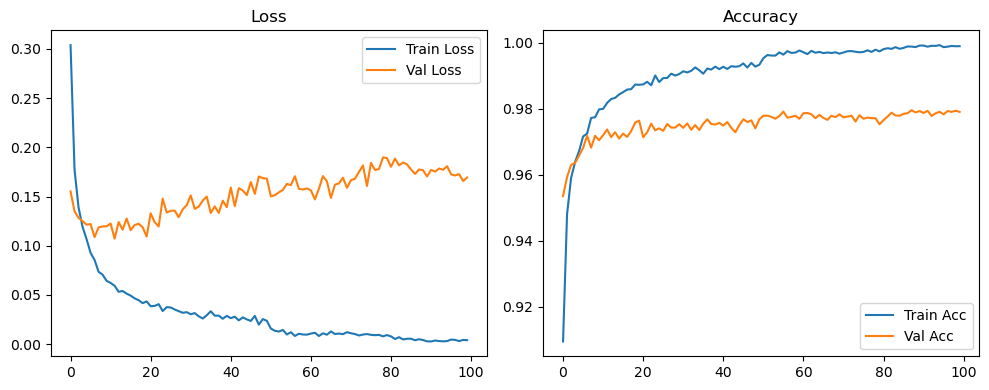

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4601, Acc: 0.8651 | Val Loss: 0.2044, Acc: 0.9386


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3065, Acc: 0.9111 | Val Loss: 0.1592, Acc: 0.9517


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2559, Acc: 0.9272 | Val Loss: 0.1602, Acc: 0.9527


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2314, Acc: 0.9335 | Val Loss: 0.1467, Acc: 0.9587


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2194, Acc: 0.9359 | Val Loss: 0.1291, Acc: 0.9639


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1989, Acc: 0.9437 | Val Loss: 0.1257, Acc: 0.9626


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1888, Acc: 0.9449 | Val Loss: 0.1161, Acc: 0.9669


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1760, Acc: 0.9483 | Val Loss: 0.1241, Acc: 0.9672


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1690, Acc: 0.9503 | Val Loss: 0.1172, Acc: 0.9675


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1673, Acc: 0.9511 | Val Loss: 0.1081, Acc: 0.9688


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1628, Acc: 0.9537 | Val Loss: 0.1169, Acc: 0.9692


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1503, Acc: 0.9567 | Val Loss: 0.1061, Acc: 0.9721


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1480, Acc: 0.9564 | Val Loss: 0.1061, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1435, Acc: 0.9582 | Val Loss: 0.1033, Acc: 0.9710


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1336, Acc: 0.9611 | Val Loss: 0.1148, Acc: 0.9692


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1350, Acc: 0.9618 | Val Loss: 0.1162, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1332, Acc: 0.9604 | Val Loss: 0.1103, Acc: 0.9708


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1298, Acc: 0.9618 | Val Loss: 0.1089, Acc: 0.9715


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1271, Acc: 0.9625 | Val Loss: 0.1089, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1264, Acc: 0.9638 | Val Loss: 0.1194, Acc: 0.9718


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9647 | Val Loss: 0.1061, Acc: 0.9723


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1182, Acc: 0.9661 | Val Loss: 0.1215, Acc: 0.9721


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1180, Acc: 0.9659 | Val Loss: 0.1060, Acc: 0.9729


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1138, Acc: 0.9671 | Val Loss: 0.1158, Acc: 0.9725


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1135, Acc: 0.9663 | Val Loss: 0.1130, Acc: 0.9729


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1156, Acc: 0.9669 | Val Loss: 0.1171, Acc: 0.9702


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1134, Acc: 0.9670 | Val Loss: 0.1168, Acc: 0.9718


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1114, Acc: 0.9670 | Val Loss: 0.1082, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1084, Acc: 0.9683 | Val Loss: 0.1177, Acc: 0.9724


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9689 | Val Loss: 0.1152, Acc: 0.9741


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1087, Acc: 0.9687 | Val Loss: 0.1125, Acc: 0.9712


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9694 | Val Loss: 0.1225, Acc: 0.9727


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1041, Acc: 0.9691 | Val Loss: 0.1214, Acc: 0.9716


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9705 | Val Loss: 0.1117, Acc: 0.9742


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0933, Acc: 0.9723 | Val Loss: 0.1163, Acc: 0.9738


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9711 | Val Loss: 0.1166, Acc: 0.9732


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9723 | Val Loss: 0.1128, Acc: 0.9750


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1003, Acc: 0.9708 | Val Loss: 0.1088, Acc: 0.9764


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0938, Acc: 0.9731 | Val Loss: 0.1146, Acc: 0.9731


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0929, Acc: 0.9729 | Val Loss: 0.1195, Acc: 0.9736


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0960, Acc: 0.9725 | Val Loss: 0.1112, Acc: 0.9720


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0896, Acc: 0.9737 | Val Loss: 0.1102, Acc: 0.9743


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9742 | Val Loss: 0.1174, Acc: 0.9736


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0854, Acc: 0.9759 | Val Loss: 0.1186, Acc: 0.9746


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0888, Acc: 0.9744 | Val Loss: 0.1146, Acc: 0.9750


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0924, Acc: 0.9738 | Val Loss: 0.1196, Acc: 0.9744


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9751 | Val Loss: 0.1094, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9748 | Val Loss: 0.1302, Acc: 0.9738


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9740 | Val Loss: 0.1129, Acc: 0.9753


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9752 | Val Loss: 0.1227, Acc: 0.9760


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9790 | Val Loss: 0.1098, Acc: 0.9768


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9802 | Val Loss: 0.1095, Acc: 0.9760


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9821 | Val Loss: 0.1085, Acc: 0.9765


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9829 | Val Loss: 0.1164, Acc: 0.9762


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9820 | Val Loss: 0.1091, Acc: 0.9768


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9824 | Val Loss: 0.1067, Acc: 0.9763


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9835 | Val Loss: 0.1175, Acc: 0.9760


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9837 | Val Loss: 0.1141, Acc: 0.9768


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9838 | Val Loss: 0.1128, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9835 | Val Loss: 0.1118, Acc: 0.9762


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9851 | Val Loss: 0.1204, Acc: 0.9764


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9844 | Val Loss: 0.1166, Acc: 0.9757


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9853 | Val Loss: 0.1129, Acc: 0.9772


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9834 | Val Loss: 0.1099, Acc: 0.9743


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9841 | Val Loss: 0.1182, Acc: 0.9765


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9832 | Val Loss: 0.1178, Acc: 0.9762


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9845 | Val Loss: 0.1210, Acc: 0.9742


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9850 | Val Loss: 0.1161, Acc: 0.9752


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9855 | Val Loss: 0.1155, Acc: 0.9757


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0497, Acc: 0.9843 | Val Loss: 0.1218, Acc: 0.9749


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9844 | Val Loss: 0.1150, Acc: 0.9766


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9848 | Val Loss: 0.1258, Acc: 0.9751


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9839 | Val Loss: 0.1197, Acc: 0.9771


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9852 | Val Loss: 0.1209, Acc: 0.9764


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9854 | Val Loss: 0.1254, Acc: 0.9762


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9858 | Val Loss: 0.1222, Acc: 0.9768


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9857 | Val Loss: 0.1154, Acc: 0.9784


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9855 | Val Loss: 0.1215, Acc: 0.9758


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9860 | Val Loss: 0.1247, Acc: 0.9771


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9853 | Val Loss: 0.1159, Acc: 0.9758


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9870 | Val Loss: 0.1181, Acc: 0.9758


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9883 | Val Loss: 0.1179, Acc: 0.9763


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9882 | Val Loss: 0.1153, Acc: 0.9770


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9888 | Val Loss: 0.1159, Acc: 0.9767


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9894 | Val Loss: 0.1169, Acc: 0.9773


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9894 | Val Loss: 0.1193, Acc: 0.9763


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9886 | Val Loss: 0.1123, Acc: 0.9778


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9892 | Val Loss: 0.1082, Acc: 0.9781


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9897 | Val Loss: 0.1144, Acc: 0.9774


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9898 | Val Loss: 0.1131, Acc: 0.9768


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9896 | Val Loss: 0.1191, Acc: 0.9775


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9904 | Val Loss: 0.1146, Acc: 0.9777


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9900 | Val Loss: 0.1130, Acc: 0.9777


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9907 | Val Loss: 0.1123, Acc: 0.9782


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9914 | Val Loss: 0.1102, Acc: 0.9783


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9910 | Val Loss: 0.1163, Acc: 0.9778


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9902 | Val Loss: 0.1159, Acc: 0.9787


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9908 | Val Loss: 0.1120, Acc: 0.9777


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.1132, Acc: 0.9789


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9905 | Val Loss: 0.1081, Acc: 0.9783


Final Test Loss: 0.1086 Accuracy: 0.9802


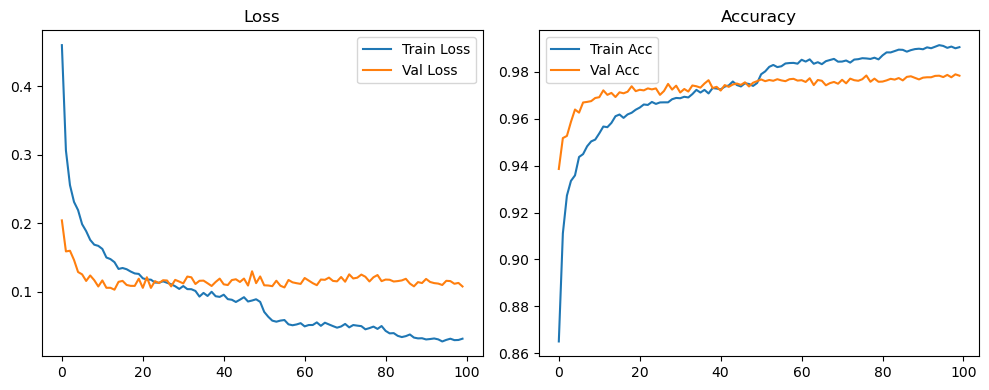

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2571, Acc: 0.9237 | Val Loss: 0.1547, Acc: 0.9537


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1330, Acc: 0.9601 | Val Loss: 0.1395, Acc: 0.9567


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0993, Acc: 0.9698 | Val Loss: 0.1214, Acc: 0.9625


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9753 | Val Loss: 0.1127, Acc: 0.9674


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9796 | Val Loss: 0.1167, Acc: 0.9682


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9815 | Val Loss: 0.1274, Acc: 0.9658


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9839 | Val Loss: 0.1174, Acc: 0.9705


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9861 | Val Loss: 0.1199, Acc: 0.9707


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.1349, Acc: 0.9694


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9901 | Val Loss: 0.1324, Acc: 0.9718


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9897 | Val Loss: 0.1296, Acc: 0.9699


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9909 | Val Loss: 0.1242, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9918 | Val Loss: 0.1308, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9913 | Val Loss: 0.1228, Acc: 0.9722


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9927 | Val Loss: 0.1300, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.1515, Acc: 0.9680


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9931 | Val Loss: 0.1283, Acc: 0.9732


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9936 | Val Loss: 0.1483, Acc: 0.9708


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.1355, Acc: 0.9725


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1431, Acc: 0.9692


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9941 | Val Loss: 0.1390, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.1361, Acc: 0.9734


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1483, Acc: 0.9723


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.1562, Acc: 0.9737


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9948 | Val Loss: 0.1568, Acc: 0.9722


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.1617, Acc: 0.9704


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9956 | Val Loss: 0.1690, Acc: 0.9718


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.1478, Acc: 0.9749


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1791, Acc: 0.9732


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9961 | Val Loss: 0.1515, Acc: 0.9702


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.1573, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1376, Acc: 0.9737


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1639, Acc: 0.9740


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1551, Acc: 0.9755


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9965 | Val Loss: 0.1603, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1790, Acc: 0.9740


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1750, Acc: 0.9753


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9964 | Val Loss: 0.1619, Acc: 0.9741


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9971 | Val Loss: 0.1656, Acc: 0.9742


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9967 | Val Loss: 0.1504, Acc: 0.9745


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.1606, Acc: 0.9754


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1887, Acc: 0.9732


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9971 | Val Loss: 0.1912, Acc: 0.9719


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9964 | Val Loss: 0.1602, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1630, Acc: 0.9755


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1625, Acc: 0.9760


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1922, Acc: 0.9744


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9969 | Val Loss: 0.1771, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1726, Acc: 0.9758


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1584, Acc: 0.9758


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1514, Acc: 0.9772


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1543, Acc: 0.9778


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1611, Acc: 0.9770


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1647, Acc: 0.9779


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1664, Acc: 0.9780


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1669, Acc: 0.9778


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1676, Acc: 0.9787


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1783, Acc: 0.9771


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1746, Acc: 0.9789


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1844, Acc: 0.9782


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1793, Acc: 0.9774


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1780, Acc: 0.9791


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1877, Acc: 0.9776


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1875, Acc: 0.9777


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1961, Acc: 0.9782


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1927, Acc: 0.9776


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1910, Acc: 0.9783


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1864, Acc: 0.9786


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1967, Acc: 0.9789


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2014, Acc: 0.9782


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2195, Acc: 0.9779


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2063, Acc: 0.9778


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2140, Acc: 0.9768


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.2037, Acc: 0.9777


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.2114, Acc: 0.9781


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.2084, Acc: 0.9792


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2106, Acc: 0.9786


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2157, Acc: 0.9772


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2112, Acc: 0.9775


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.2227, Acc: 0.9772


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2108, Acc: 0.9780


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2058, Acc: 0.9785


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2102, Acc: 0.9787


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2105, Acc: 0.9785


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2106, Acc: 0.9775


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2108, Acc: 0.9775


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2060, Acc: 0.9784


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2117, Acc: 0.9778


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2114, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2098, Acc: 0.9782


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2161, Acc: 0.9768


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2199, Acc: 0.9776


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2178, Acc: 0.9772


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2206, Acc: 0.9772


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2220, Acc: 0.9772


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2208, Acc: 0.9777


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2215, Acc: 0.9773


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2222, Acc: 0.9773


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2159, Acc: 0.9781


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2217, Acc: 0.9784


Final Test Loss: 0.1919 Accuracy: 0.9809


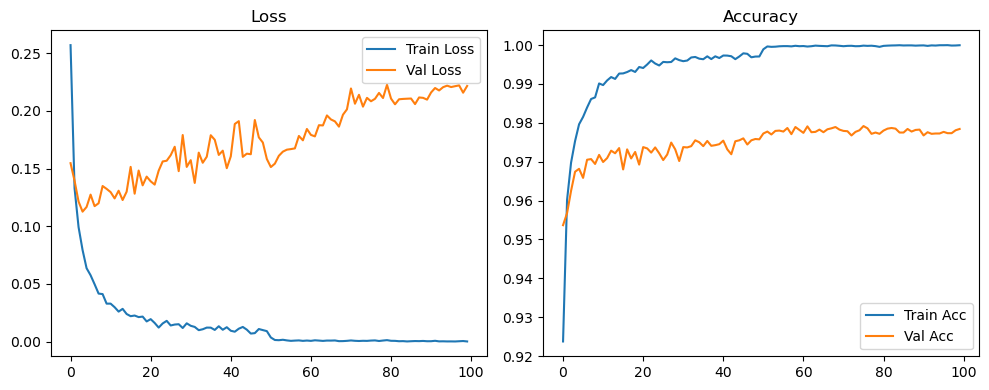

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3037, Acc: 0.9095 | Val Loss: 0.1552, Acc: 0.9535


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1770, Acc: 0.9480 | Val Loss: 0.1350, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9589 | Val Loss: 0.1284, Acc: 0.9629


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1192, Acc: 0.9638 | Val Loss: 0.1250, Acc: 0.9635


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1067, Acc: 0.9671 | Val Loss: 0.1214, Acc: 0.9657


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0928, Acc: 0.9715 | Val Loss: 0.1220, Acc: 0.9681


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9724 | Val Loss: 0.1088, Acc: 0.9718


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9771 | Val Loss: 0.1187, Acc: 0.9682


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9774 | Val Loss: 0.1196, Acc: 0.9718


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9798 | Val Loss: 0.1198, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9799 | Val Loss: 0.1225, Acc: 0.9719


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9817 | Val Loss: 0.1072, Acc: 0.9737


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9829 | Val Loss: 0.1240, Acc: 0.9713


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9832 | Val Loss: 0.1163, Acc: 0.9728


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9843 | Val Loss: 0.1276, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9850 | Val Loss: 0.1158, Acc: 0.9724


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9858 | Val Loss: 0.1211, Acc: 0.9714


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9859 | Val Loss: 0.1222, Acc: 0.9732


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9873 | Val Loss: 0.1188, Acc: 0.9758


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9872 | Val Loss: 0.1094, Acc: 0.9763


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9873 | Val Loss: 0.1330, Acc: 0.9713


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9881 | Val Loss: 0.1240, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9871 | Val Loss: 0.1196, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9900 | Val Loss: 0.1479, Acc: 0.9734


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.1337, Acc: 0.9740


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9892 | Val Loss: 0.1355, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9893 | Val Loss: 0.1356, Acc: 0.9753


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9906 | Val Loss: 0.1289, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9900 | Val Loss: 0.1369, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9905 | Val Loss: 0.1413, Acc: 0.9752


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9913 | Val Loss: 0.1511, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9909 | Val Loss: 0.1375, Acc: 0.9755


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9914 | Val Loss: 0.1397, Acc: 0.9736


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9925 | Val Loss: 0.1459, Acc: 0.9750


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9916 | Val Loss: 0.1500, Acc: 0.9735


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9906 | Val Loss: 0.1333, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9921 | Val Loss: 0.1400, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9918 | Val Loss: 0.1334, Acc: 0.9753


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9927 | Val Loss: 0.1458, Acc: 0.9752


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9919 | Val Loss: 0.1392, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9927 | Val Loss: 0.1591, Acc: 0.9748


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9920 | Val Loss: 0.1402, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9928 | Val Loss: 0.1585, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9927 | Val Loss: 0.1561, Acc: 0.9728


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9928 | Val Loss: 0.1515, Acc: 0.9750


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9937 | Val Loss: 0.1647, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9924 | Val Loss: 0.1527, Acc: 0.9759


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.1703, Acc: 0.9764


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9927 | Val Loss: 0.1687, Acc: 0.9740


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9933 | Val Loss: 0.1681, Acc: 0.9768


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9956 | Val Loss: 0.1404, Acc: 0.9787


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1437, Acc: 0.9782


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1376, Acc: 0.9791


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9971 | Val Loss: 0.1442, Acc: 0.9789


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1452, Acc: 0.9792


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1408, Acc: 0.9785


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1463, Acc: 0.9792


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1479, Acc: 0.9791


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1490, Acc: 0.9792


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1483, Acc: 0.9796


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1503, Acc: 0.9788


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1401, Acc: 0.9797


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1468, Acc: 0.9797


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1485, Acc: 0.9795


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1583, Acc: 0.9792


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1533, Acc: 0.9797


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1514, Acc: 0.9797


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1540, Acc: 0.9788


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1620, Acc: 0.9802


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1588, Acc: 0.9796


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1680, Acc: 0.9793


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1595, Acc: 0.9801


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1620, Acc: 0.9792


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1647, Acc: 0.9790


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1677, Acc: 0.9778


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1670, Acc: 0.9782


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1622, Acc: 0.9783


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1602, Acc: 0.9785


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1670, Acc: 0.9789


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1694, Acc: 0.9787


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1644, Acc: 0.9783


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1737, Acc: 0.9790


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1737, Acc: 0.9789


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1647, Acc: 0.9795


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1673, Acc: 0.9785


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1645, Acc: 0.9789


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1674, Acc: 0.9784


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1584, Acc: 0.9802


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1624, Acc: 0.9799


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1652, Acc: 0.9783


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1650, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1676, Acc: 0.9801


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1654, Acc: 0.9791


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1710, Acc: 0.9794


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1685, Acc: 0.9792


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1634, Acc: 0.9792


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1656, Acc: 0.9791


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1624, Acc: 0.9796


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1661, Acc: 0.9796


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1535, Acc: 0.9797


Final Test Loss: 0.1482 Accuracy: 0.9818


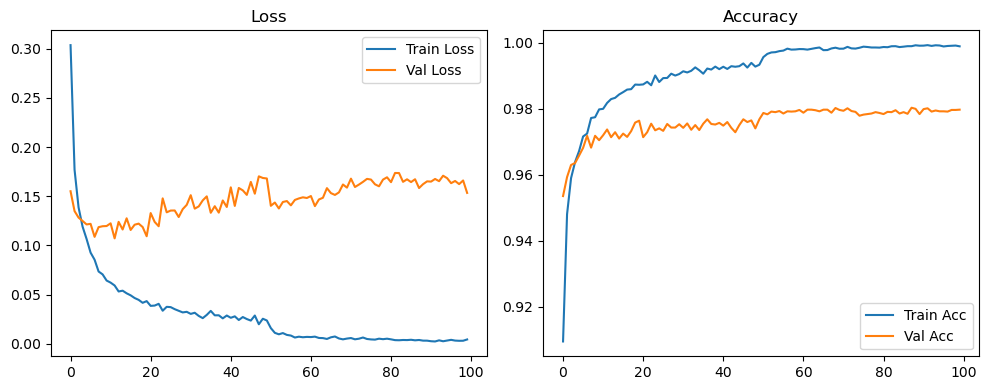

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4601, Acc: 0.8651 | Val Loss: 0.2044, Acc: 0.9386


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3065, Acc: 0.9111 | Val Loss: 0.1592, Acc: 0.9517


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2559, Acc: 0.9272 | Val Loss: 0.1602, Acc: 0.9527


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2314, Acc: 0.9335 | Val Loss: 0.1467, Acc: 0.9587


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2194, Acc: 0.9359 | Val Loss: 0.1291, Acc: 0.9639


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1989, Acc: 0.9437 | Val Loss: 0.1257, Acc: 0.9626


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1888, Acc: 0.9449 | Val Loss: 0.1161, Acc: 0.9669


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1760, Acc: 0.9483 | Val Loss: 0.1241, Acc: 0.9672


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1690, Acc: 0.9503 | Val Loss: 0.1172, Acc: 0.9675


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1673, Acc: 0.9511 | Val Loss: 0.1081, Acc: 0.9688


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1628, Acc: 0.9537 | Val Loss: 0.1169, Acc: 0.9692


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1503, Acc: 0.9567 | Val Loss: 0.1061, Acc: 0.9721


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1480, Acc: 0.9564 | Val Loss: 0.1061, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1435, Acc: 0.9582 | Val Loss: 0.1033, Acc: 0.9710


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1336, Acc: 0.9611 | Val Loss: 0.1148, Acc: 0.9692


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1350, Acc: 0.9618 | Val Loss: 0.1162, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1332, Acc: 0.9604 | Val Loss: 0.1103, Acc: 0.9708


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1298, Acc: 0.9618 | Val Loss: 0.1089, Acc: 0.9715


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1271, Acc: 0.9625 | Val Loss: 0.1089, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1264, Acc: 0.9638 | Val Loss: 0.1194, Acc: 0.9718


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9647 | Val Loss: 0.1061, Acc: 0.9723


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1182, Acc: 0.9661 | Val Loss: 0.1215, Acc: 0.9721


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1180, Acc: 0.9659 | Val Loss: 0.1060, Acc: 0.9729


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1138, Acc: 0.9671 | Val Loss: 0.1158, Acc: 0.9725


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1135, Acc: 0.9663 | Val Loss: 0.1130, Acc: 0.9729


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1156, Acc: 0.9669 | Val Loss: 0.1171, Acc: 0.9702


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1134, Acc: 0.9670 | Val Loss: 0.1168, Acc: 0.9718


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1114, Acc: 0.9670 | Val Loss: 0.1082, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1084, Acc: 0.9683 | Val Loss: 0.1177, Acc: 0.9724


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9689 | Val Loss: 0.1152, Acc: 0.9741


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1087, Acc: 0.9687 | Val Loss: 0.1125, Acc: 0.9712


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9694 | Val Loss: 0.1225, Acc: 0.9727


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1041, Acc: 0.9691 | Val Loss: 0.1214, Acc: 0.9716


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9705 | Val Loss: 0.1117, Acc: 0.9742


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0933, Acc: 0.9723 | Val Loss: 0.1163, Acc: 0.9738


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9711 | Val Loss: 0.1166, Acc: 0.9732


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9723 | Val Loss: 0.1128, Acc: 0.9750


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1003, Acc: 0.9708 | Val Loss: 0.1088, Acc: 0.9764


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0938, Acc: 0.9731 | Val Loss: 0.1146, Acc: 0.9731


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0929, Acc: 0.9729 | Val Loss: 0.1195, Acc: 0.9736


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0960, Acc: 0.9725 | Val Loss: 0.1112, Acc: 0.9720


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0896, Acc: 0.9737 | Val Loss: 0.1102, Acc: 0.9743


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9742 | Val Loss: 0.1174, Acc: 0.9736


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0854, Acc: 0.9759 | Val Loss: 0.1186, Acc: 0.9746


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0888, Acc: 0.9744 | Val Loss: 0.1146, Acc: 0.9750


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0924, Acc: 0.9738 | Val Loss: 0.1196, Acc: 0.9744


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9751 | Val Loss: 0.1094, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9748 | Val Loss: 0.1302, Acc: 0.9738


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9740 | Val Loss: 0.1129, Acc: 0.9753


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9752 | Val Loss: 0.1227, Acc: 0.9760


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0665, Acc: 0.9809 | Val Loss: 0.1129, Acc: 0.9762


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0587, Acc: 0.9820 | Val Loss: 0.1132, Acc: 0.9762


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9830 | Val Loss: 0.1108, Acc: 0.9769


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0506, Acc: 0.9841 | Val Loss: 0.1107, Acc: 0.9775


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9827 | Val Loss: 0.1048, Acc: 0.9775


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0505, Acc: 0.9849 | Val Loss: 0.1032, Acc: 0.9773


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9858 | Val Loss: 0.1085, Acc: 0.9778


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9860 | Val Loss: 0.1057, Acc: 0.9781


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9862 | Val Loss: 0.1058, Acc: 0.9778


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9861 | Val Loss: 0.1050, Acc: 0.9772


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9869 | Val Loss: 0.1113, Acc: 0.9780


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9873 | Val Loss: 0.1105, Acc: 0.9768


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9877 | Val Loss: 0.1095, Acc: 0.9768


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9875 | Val Loss: 0.1102, Acc: 0.9768


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9864 | Val Loss: 0.1109, Acc: 0.9778


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9869 | Val Loss: 0.1073, Acc: 0.9782


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9880 | Val Loss: 0.1115, Acc: 0.9762


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9876 | Val Loss: 0.1047, Acc: 0.9779


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9893 | Val Loss: 0.1122, Acc: 0.9775


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.1167, Acc: 0.9770


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9879 | Val Loss: 0.1158, Acc: 0.9778


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9883 | Val Loss: 0.1158, Acc: 0.9765


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9876 | Val Loss: 0.1091, Acc: 0.9771


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9883 | Val Loss: 0.1091, Acc: 0.9777


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9878 | Val Loss: 0.1153, Acc: 0.9769


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9889 | Val Loss: 0.1104, Acc: 0.9770


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9880 | Val Loss: 0.1102, Acc: 0.9773


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9884 | Val Loss: 0.1127, Acc: 0.9766


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9886 | Val Loss: 0.1114, Acc: 0.9769


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9879 | Val Loss: 0.1090, Acc: 0.9775


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9892 | Val Loss: 0.1089, Acc: 0.9768


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9891 | Val Loss: 0.1118, Acc: 0.9779


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9889 | Val Loss: 0.1083, Acc: 0.9774


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9894 | Val Loss: 0.1062, Acc: 0.9778


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9904 | Val Loss: 0.1112, Acc: 0.9770


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9899 | Val Loss: 0.1115, Acc: 0.9775


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9892 | Val Loss: 0.1066, Acc: 0.9779


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.1053, Acc: 0.9786


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9909 | Val Loss: 0.1082, Acc: 0.9779


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9900 | Val Loss: 0.1026, Acc: 0.9782


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9897 | Val Loss: 0.1085, Acc: 0.9771


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9900 | Val Loss: 0.1074, Acc: 0.9777


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9899 | Val Loss: 0.1114, Acc: 0.9774


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9904 | Val Loss: 0.1052, Acc: 0.9781


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9905 | Val Loss: 0.1079, Acc: 0.9777


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9897 | Val Loss: 0.1120, Acc: 0.9777


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9902 | Val Loss: 0.1105, Acc: 0.9772


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9902 | Val Loss: 0.1063, Acc: 0.9788


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9910 | Val Loss: 0.1057, Acc: 0.9778


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.1064, Acc: 0.9778


Final Test Loss: 0.1034 Accuracy: 0.9791


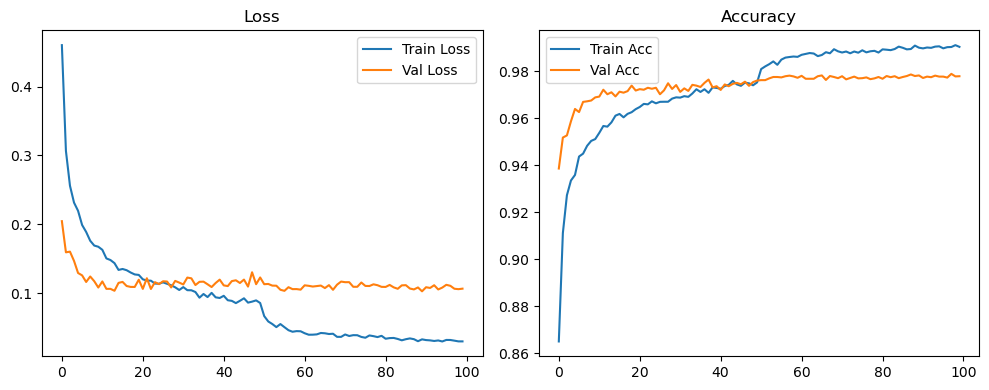

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2451, Acc: 0.9259 | Val Loss: 0.1510, Acc: 0.9548


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1249, Acc: 0.9617 | Val Loss: 0.1277, Acc: 0.9603


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0945, Acc: 0.9709 | Val Loss: 0.1251, Acc: 0.9617


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0743, Acc: 0.9764 | Val Loss: 0.1312, Acc: 0.9627


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9793 | Val Loss: 0.1273, Acc: 0.9647


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9833 | Val Loss: 0.1294, Acc: 0.9647


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9842 | Val Loss: 0.1169, Acc: 0.9700


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9869 | Val Loss: 0.1231, Acc: 0.9666


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9887 | Val Loss: 0.1426, Acc: 0.9669


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9883 | Val Loss: 0.1219, Acc: 0.9708


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.1250, Acc: 0.9688


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.1401, Acc: 0.9685


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.1355, Acc: 0.9707


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.1383, Acc: 0.9708


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.1506, Acc: 0.9687


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.1448, Acc: 0.9713


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9921 | Val Loss: 0.1358, Acc: 0.9710


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.1324, Acc: 0.9731


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.1527, Acc: 0.9702


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1448, Acc: 0.9718


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.1425, Acc: 0.9703


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.1312, Acc: 0.9738


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.1331, Acc: 0.9733


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.1490, Acc: 0.9749


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1600, Acc: 0.9704


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1607, Acc: 0.9692


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.1498, Acc: 0.9722


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.1506, Acc: 0.9728


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1471, Acc: 0.9729


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1447, Acc: 0.9741


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1594, Acc: 0.9732


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1434, Acc: 0.9758


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1558, Acc: 0.9729


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1735, Acc: 0.9734


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1591, Acc: 0.9745


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1591, Acc: 0.9745


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.1514, Acc: 0.9738


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1650, Acc: 0.9730


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1752, Acc: 0.9730


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1369, Acc: 0.9746


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1642, Acc: 0.9738


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.1669, Acc: 0.9751


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1535, Acc: 0.9756


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1542, Acc: 0.9723


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1571, Acc: 0.9752


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1477, Acc: 0.9753


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1630, Acc: 0.9742


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1544, Acc: 0.9751


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1657, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1767, Acc: 0.9728


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1658, Acc: 0.9742


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1690, Acc: 0.9752


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1732, Acc: 0.9752


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1809, Acc: 0.9746


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.1724, Acc: 0.9732


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1714, Acc: 0.9738


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1706, Acc: 0.9748


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1609, Acc: 0.9752


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1876, Acc: 0.9732


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1772, Acc: 0.9761


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1619, Acc: 0.9746


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1873, Acc: 0.9738


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1974, Acc: 0.9734


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1788, Acc: 0.9756


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1838, Acc: 0.9751


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1763, Acc: 0.9743


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.1819, Acc: 0.9743


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1656, Acc: 0.9755


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1650, Acc: 0.9772


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9982 | Val Loss: 0.1677, Acc: 0.9745


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1485, Acc: 0.9765


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1644, Acc: 0.9744


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1645, Acc: 0.9752


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1523, Acc: 0.9772


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1704, Acc: 0.9749


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1956, Acc: 0.9739


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1573, Acc: 0.9770


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1566, Acc: 0.9777


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1787, Acc: 0.9752


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9988 | Val Loss: 0.1842, Acc: 0.9760


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1715, Acc: 0.9758


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.2019, Acc: 0.9752


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1963, Acc: 0.9745


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1792, Acc: 0.9767


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.2053, Acc: 0.9738


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1843, Acc: 0.9764


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1896, Acc: 0.9755


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1908, Acc: 0.9769


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1926, Acc: 0.9754


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9988 | Val Loss: 0.2066, Acc: 0.9742


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.2144, Acc: 0.9738


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.2112, Acc: 0.9746


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.2000, Acc: 0.9772


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.2306, Acc: 0.9748


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9990 | Val Loss: 0.1938, Acc: 0.9768


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1961, Acc: 0.9772


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9986 | Val Loss: 0.1969, Acc: 0.9766


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.2093, Acc: 0.9736


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.2104, Acc: 0.9745


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1847, Acc: 0.9768


Final Test Loss: 0.1659 Accuracy: 0.9776


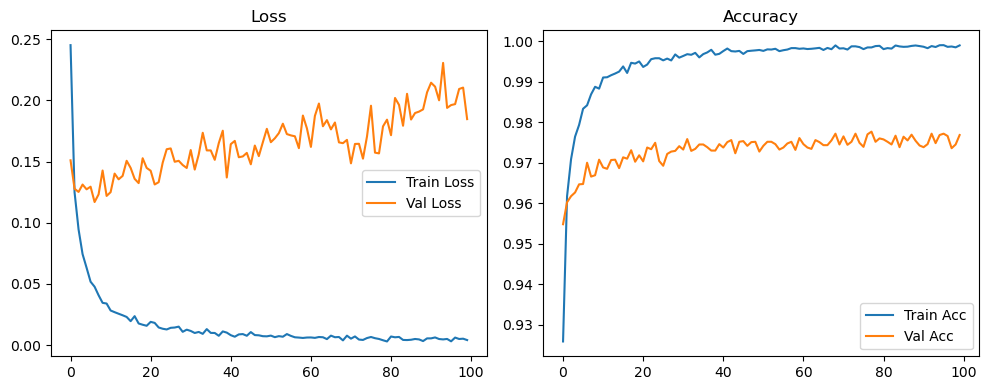

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2935, Acc: 0.9125 | Val Loss: 0.1530, Acc: 0.9525


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1658, Acc: 0.9497 | Val Loss: 0.1356, Acc: 0.9573


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1329, Acc: 0.9599 | Val Loss: 0.1258, Acc: 0.9610


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1115, Acc: 0.9659 | Val Loss: 0.1246, Acc: 0.9630


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0976, Acc: 0.9697 | Val Loss: 0.1055, Acc: 0.9688


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0889, Acc: 0.9714 | Val Loss: 0.1156, Acc: 0.9679


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0816, Acc: 0.9731 | Val Loss: 0.1091, Acc: 0.9692


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0695, Acc: 0.9778 | Val Loss: 0.1132, Acc: 0.9688


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0681, Acc: 0.9778 | Val Loss: 0.1077, Acc: 0.9719


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9799 | Val Loss: 0.1108, Acc: 0.9711


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9823 | Val Loss: 0.1104, Acc: 0.9706


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9838 | Val Loss: 0.1142, Acc: 0.9719


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9836 | Val Loss: 0.1136, Acc: 0.9712


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9843 | Val Loss: 0.1131, Acc: 0.9717


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9848 | Val Loss: 0.1074, Acc: 0.9726


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9870 | Val Loss: 0.1123, Acc: 0.9728


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9863 | Val Loss: 0.1093, Acc: 0.9730


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9858 | Val Loss: 0.1099, Acc: 0.9735


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9885 | Val Loss: 0.1169, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9877 | Val Loss: 0.1063, Acc: 0.9741


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9886 | Val Loss: 0.1158, Acc: 0.9731


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9895 | Val Loss: 0.1107, Acc: 0.9749


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9902 | Val Loss: 0.1190, Acc: 0.9726


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9904 | Val Loss: 0.1152, Acc: 0.9745


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.1127, Acc: 0.9748


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9905 | Val Loss: 0.1250, Acc: 0.9741


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9908 | Val Loss: 0.1274, Acc: 0.9734


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.1207, Acc: 0.9742


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.1257, Acc: 0.9746


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.1182, Acc: 0.9758


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.1225, Acc: 0.9754


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9921 | Val Loss: 0.1213, Acc: 0.9755


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9918 | Val Loss: 0.1133, Acc: 0.9759


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.1226, Acc: 0.9749


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.1266, Acc: 0.9752


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.1253, Acc: 0.9753


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.1315, Acc: 0.9746


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.1256, Acc: 0.9751


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9933 | Val Loss: 0.1332, Acc: 0.9760


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.1350, Acc: 0.9754


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9934 | Val Loss: 0.1451, Acc: 0.9735


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.1330, Acc: 0.9760


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.1381, Acc: 0.9749


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.1447, Acc: 0.9747


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.1439, Acc: 0.9747


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9927 | Val Loss: 0.1309, Acc: 0.9751


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.1300, Acc: 0.9764


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.1476, Acc: 0.9743


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9948 | Val Loss: 0.1299, Acc: 0.9763


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.1344, Acc: 0.9766


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.1435, Acc: 0.9754


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.1365, Acc: 0.9761


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9945 | Val Loss: 0.1435, Acc: 0.9751


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9944 | Val Loss: 0.1392, Acc: 0.9762


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.1340, Acc: 0.9784


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9944 | Val Loss: 0.1316, Acc: 0.9768


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9948 | Val Loss: 0.1329, Acc: 0.9772


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.1273, Acc: 0.9773


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.1416, Acc: 0.9767


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1485, Acc: 0.9757


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.1426, Acc: 0.9764


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9950 | Val Loss: 0.1493, Acc: 0.9761


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.1572, Acc: 0.9760


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9949 | Val Loss: 0.1519, Acc: 0.9755


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9951 | Val Loss: 0.1478, Acc: 0.9756


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9945 | Val Loss: 0.1509, Acc: 0.9756


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9952 | Val Loss: 0.1512, Acc: 0.9764


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9960 | Val Loss: 0.1359, Acc: 0.9770


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1457, Acc: 0.9763


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.1540, Acc: 0.9772


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9957 | Val Loss: 0.1477, Acc: 0.9776


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9955 | Val Loss: 0.1449, Acc: 0.9773


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.1421, Acc: 0.9748


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9956 | Val Loss: 0.1438, Acc: 0.9771


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1549, Acc: 0.9777


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.1579, Acc: 0.9759


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9959 | Val Loss: 0.1481, Acc: 0.9755


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9957 | Val Loss: 0.1563, Acc: 0.9753


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9954 | Val Loss: 0.1522, Acc: 0.9750


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1512, Acc: 0.9760


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9968 | Val Loss: 0.1478, Acc: 0.9764


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9955 | Val Loss: 0.1549, Acc: 0.9766


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.1555, Acc: 0.9773


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9959 | Val Loss: 0.1646, Acc: 0.9762


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1604, Acc: 0.9752


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9963 | Val Loss: 0.1574, Acc: 0.9772


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9954 | Val Loss: 0.1431, Acc: 0.9768


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.1425, Acc: 0.9777


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1535, Acc: 0.9776


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1528, Acc: 0.9758


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9967 | Val Loss: 0.1591, Acc: 0.9768


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9968 | Val Loss: 0.1494, Acc: 0.9774


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9962 | Val Loss: 0.1667, Acc: 0.9773


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1622, Acc: 0.9775


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1546, Acc: 0.9769


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9957 | Val Loss: 0.1453, Acc: 0.9774


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9960 | Val Loss: 0.1551, Acc: 0.9748


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9963 | Val Loss: 0.1463, Acc: 0.9772


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9966 | Val Loss: 0.1579, Acc: 0.9770


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.1576, Acc: 0.9771


Final Test Loss: 0.1606 Accuracy: 0.9782


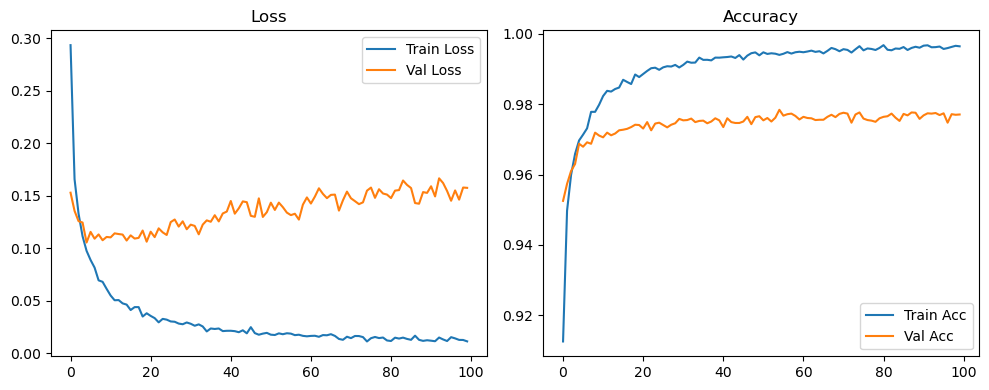

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4446, Acc: 0.8679 | Val Loss: 0.1912, Acc: 0.9445


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2898, Acc: 0.9137 | Val Loss: 0.1641, Acc: 0.9510


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2467, Acc: 0.9295 | Val Loss: 0.1570, Acc: 0.9538


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2173, Acc: 0.9364 | Val Loss: 0.1338, Acc: 0.9608


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2052, Acc: 0.9405 | Val Loss: 0.1328, Acc: 0.9627


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1939, Acc: 0.9442 | Val Loss: 0.1274, Acc: 0.9623


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1725, Acc: 0.9488 | Val Loss: 0.1166, Acc: 0.9663


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1644, Acc: 0.9513 | Val Loss: 0.1154, Acc: 0.9675


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1602, Acc: 0.9527 | Val Loss: 0.1113, Acc: 0.9676


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1513, Acc: 0.9544 | Val Loss: 0.1139, Acc: 0.9667


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1502, Acc: 0.9556 | Val Loss: 0.1035, Acc: 0.9701


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1407, Acc: 0.9572 | Val Loss: 0.1035, Acc: 0.9702


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1345, Acc: 0.9590 | Val Loss: 0.1042, Acc: 0.9724


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1360, Acc: 0.9603 | Val Loss: 0.1029, Acc: 0.9702


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1226, Acc: 0.9628 | Val Loss: 0.1045, Acc: 0.9715


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1228, Acc: 0.9634 | Val Loss: 0.1038, Acc: 0.9705


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1195, Acc: 0.9625 | Val Loss: 0.1100, Acc: 0.9710


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1217, Acc: 0.9632 | Val Loss: 0.1045, Acc: 0.9709


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1157, Acc: 0.9658 | Val Loss: 0.1009, Acc: 0.9738


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1090, Acc: 0.9667 | Val Loss: 0.1018, Acc: 0.9735


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1083, Acc: 0.9660 | Val Loss: 0.1036, Acc: 0.9711


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1077, Acc: 0.9670 | Val Loss: 0.1056, Acc: 0.9732


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1036, Acc: 0.9682 | Val Loss: 0.1017, Acc: 0.9729


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1022, Acc: 0.9688 | Val Loss: 0.1015, Acc: 0.9734


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1021, Acc: 0.9691 | Val Loss: 0.1043, Acc: 0.9712


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1019, Acc: 0.9699 | Val Loss: 0.0990, Acc: 0.9731


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0975, Acc: 0.9697 | Val Loss: 0.1087, Acc: 0.9718


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0969, Acc: 0.9704 | Val Loss: 0.0959, Acc: 0.9745


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0966, Acc: 0.9704 | Val Loss: 0.1049, Acc: 0.9737


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0952, Acc: 0.9710 | Val Loss: 0.1036, Acc: 0.9736


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0885, Acc: 0.9727 | Val Loss: 0.0996, Acc: 0.9754


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9719 | Val Loss: 0.1082, Acc: 0.9747


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0848, Acc: 0.9736 | Val Loss: 0.1015, Acc: 0.9740


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0890, Acc: 0.9721 | Val Loss: 0.1078, Acc: 0.9738


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0845, Acc: 0.9739 | Val Loss: 0.1059, Acc: 0.9749


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0847, Acc: 0.9736 | Val Loss: 0.1030, Acc: 0.9741


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0808, Acc: 0.9752 | Val Loss: 0.1105, Acc: 0.9743


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0829, Acc: 0.9744 | Val Loss: 0.1093, Acc: 0.9748


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0794, Acc: 0.9758 | Val Loss: 0.1047, Acc: 0.9732


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0788, Acc: 0.9755 | Val Loss: 0.1103, Acc: 0.9748


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0788, Acc: 0.9755 | Val Loss: 0.1115, Acc: 0.9738


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0761, Acc: 0.9774 | Val Loss: 0.1065, Acc: 0.9757


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0756, Acc: 0.9766 | Val Loss: 0.1124, Acc: 0.9750


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0776, Acc: 0.9759 | Val Loss: 0.1122, Acc: 0.9751


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0770, Acc: 0.9765 | Val Loss: 0.1068, Acc: 0.9732


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0748, Acc: 0.9768 | Val Loss: 0.1046, Acc: 0.9748


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0747, Acc: 0.9768 | Val Loss: 0.1106, Acc: 0.9748


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9775 | Val Loss: 0.1082, Acc: 0.9738


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9773 | Val Loss: 0.1143, Acc: 0.9743


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9749 | Val Loss: 0.1077, Acc: 0.9753


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0699, Acc: 0.9783 | Val Loss: 0.1051, Acc: 0.9748


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9786 | Val Loss: 0.1072, Acc: 0.9752


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0676, Acc: 0.9790 | Val Loss: 0.1043, Acc: 0.9752


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9783 | Val Loss: 0.1127, Acc: 0.9722


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9793 | Val Loss: 0.1134, Acc: 0.9735


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0643, Acc: 0.9801 | Val Loss: 0.1111, Acc: 0.9751


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9790 | Val Loss: 0.1194, Acc: 0.9739


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9782 | Val Loss: 0.1140, Acc: 0.9746


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0703, Acc: 0.9779 | Val Loss: 0.1064, Acc: 0.9758


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0669, Acc: 0.9798 | Val Loss: 0.1057, Acc: 0.9750


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9803 | Val Loss: 0.1041, Acc: 0.9767


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0648, Acc: 0.9800 | Val Loss: 0.1112, Acc: 0.9748


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0625, Acc: 0.9808 | Val Loss: 0.1066, Acc: 0.9750


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9804 | Val Loss: 0.1197, Acc: 0.9743


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9804 | Val Loss: 0.1116, Acc: 0.9758


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0658, Acc: 0.9796 | Val Loss: 0.1119, Acc: 0.9749


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0619, Acc: 0.9815 | Val Loss: 0.1104, Acc: 0.9742


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0624, Acc: 0.9807 | Val Loss: 0.1069, Acc: 0.9758


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0595, Acc: 0.9811 | Val Loss: 0.1136, Acc: 0.9742


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0628, Acc: 0.9816 | Val Loss: 0.1055, Acc: 0.9758


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0619, Acc: 0.9806 | Val Loss: 0.1161, Acc: 0.9745


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0636, Acc: 0.9801 | Val Loss: 0.1163, Acc: 0.9753


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9807 | Val Loss: 0.1175, Acc: 0.9744


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0640, Acc: 0.9812 | Val Loss: 0.1073, Acc: 0.9760


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0603, Acc: 0.9810 | Val Loss: 0.1089, Acc: 0.9753


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0597, Acc: 0.9826 | Val Loss: 0.1186, Acc: 0.9733


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0612, Acc: 0.9813 | Val Loss: 0.1086, Acc: 0.9757


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0603, Acc: 0.9822 | Val Loss: 0.1171, Acc: 0.9763


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0617, Acc: 0.9813 | Val Loss: 0.1127, Acc: 0.9743


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0560, Acc: 0.9828 | Val Loss: 0.1097, Acc: 0.9761


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9823 | Val Loss: 0.1134, Acc: 0.9750


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9835 | Val Loss: 0.1143, Acc: 0.9738


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0601, Acc: 0.9812 | Val Loss: 0.1114, Acc: 0.9748


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9831 | Val Loss: 0.1076, Acc: 0.9760


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9825 | Val Loss: 0.1106, Acc: 0.9750


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9819 | Val Loss: 0.1108, Acc: 0.9758


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9822 | Val Loss: 0.1157, Acc: 0.9761


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9826 | Val Loss: 0.1109, Acc: 0.9768


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9825 | Val Loss: 0.1262, Acc: 0.9742


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9840 | Val Loss: 0.1215, Acc: 0.9758


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9832 | Val Loss: 0.1161, Acc: 0.9752


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9829 | Val Loss: 0.1237, Acc: 0.9748


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9846 | Val Loss: 0.1193, Acc: 0.9751


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9846 | Val Loss: 0.1126, Acc: 0.9757


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9842 | Val Loss: 0.1153, Acc: 0.9764


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9835 | Val Loss: 0.1190, Acc: 0.9752


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9840 | Val Loss: 0.1178, Acc: 0.9756


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0543, Acc: 0.9832 | Val Loss: 0.1211, Acc: 0.9755


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9844 | Val Loss: 0.1233, Acc: 0.9747


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9834 | Val Loss: 0.1170, Acc: 0.9757


Final Test Loss: 0.1051 Accuracy: 0.9774


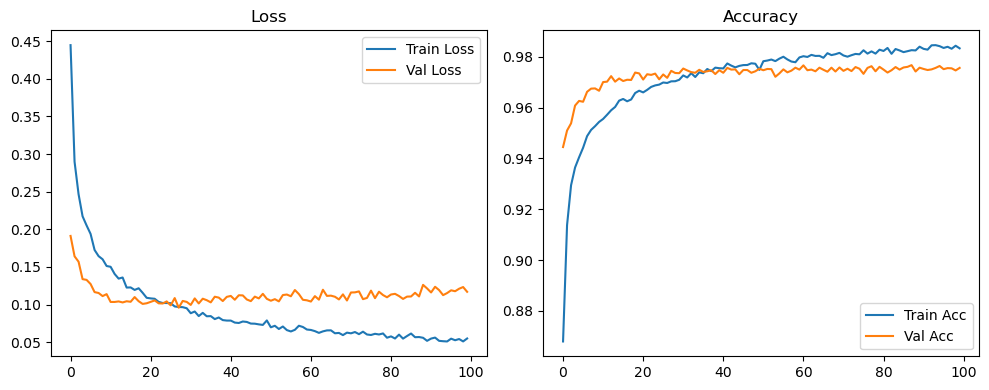

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2451, Acc: 0.9259 | Val Loss: 0.1510, Acc: 0.9548


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1249, Acc: 0.9617 | Val Loss: 0.1277, Acc: 0.9603


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0945, Acc: 0.9709 | Val Loss: 0.1251, Acc: 0.9617


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0743, Acc: 0.9764 | Val Loss: 0.1312, Acc: 0.9627


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9793 | Val Loss: 0.1273, Acc: 0.9647


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9833 | Val Loss: 0.1294, Acc: 0.9647


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9842 | Val Loss: 0.1169, Acc: 0.9700


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9869 | Val Loss: 0.1231, Acc: 0.9666


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9887 | Val Loss: 0.1426, Acc: 0.9669


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9883 | Val Loss: 0.1219, Acc: 0.9708


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.1250, Acc: 0.9688


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.1401, Acc: 0.9685


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.1355, Acc: 0.9707


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.1383, Acc: 0.9708


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.1506, Acc: 0.9687


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.1448, Acc: 0.9713


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9921 | Val Loss: 0.1358, Acc: 0.9710


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.1324, Acc: 0.9731


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.1527, Acc: 0.9702


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1448, Acc: 0.9718


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.1425, Acc: 0.9703


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.1312, Acc: 0.9738


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.1331, Acc: 0.9733


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.1490, Acc: 0.9749


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1600, Acc: 0.9704


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1607, Acc: 0.9692


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.1498, Acc: 0.9722


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.1506, Acc: 0.9728


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1471, Acc: 0.9729


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1447, Acc: 0.9741


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1594, Acc: 0.9732


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1434, Acc: 0.9758


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1558, Acc: 0.9729


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1735, Acc: 0.9734


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1591, Acc: 0.9745


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1591, Acc: 0.9745


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.1514, Acc: 0.9738


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1650, Acc: 0.9730


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1752, Acc: 0.9730


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1369, Acc: 0.9746


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1642, Acc: 0.9738


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.1669, Acc: 0.9751


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1535, Acc: 0.9756


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1542, Acc: 0.9723


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1571, Acc: 0.9752


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1477, Acc: 0.9753


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1630, Acc: 0.9742


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1544, Acc: 0.9751


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1657, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1767, Acc: 0.9728


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1430, Acc: 0.9778


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1435, Acc: 0.9778


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1470, Acc: 0.9786


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1421, Acc: 0.9787


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1386, Acc: 0.9795


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1554, Acc: 0.9778


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1509, Acc: 0.9784


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1593, Acc: 0.9779


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1732, Acc: 0.9778


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1828, Acc: 0.9774


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1845, Acc: 0.9768


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1765, Acc: 0.9781


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1856, Acc: 0.9788


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1775, Acc: 0.9795


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.2046, Acc: 0.9761


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1858, Acc: 0.9772


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1895, Acc: 0.9762


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1776, Acc: 0.9763


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1773, Acc: 0.9778


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1778, Acc: 0.9775


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1958, Acc: 0.9780


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1935, Acc: 0.9768


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1806, Acc: 0.9773


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1748, Acc: 0.9780


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1825, Acc: 0.9781


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1759, Acc: 0.9793


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1932, Acc: 0.9777


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1941, Acc: 0.9765


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1902, Acc: 0.9784


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1946, Acc: 0.9768


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1878, Acc: 0.9785


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1813, Acc: 0.9792


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1953, Acc: 0.9789


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1870, Acc: 0.9779


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1870, Acc: 0.9790


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1934, Acc: 0.9780


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1842, Acc: 0.9795


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1827, Acc: 0.9787


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1892, Acc: 0.9784


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1933, Acc: 0.9773


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1973, Acc: 0.9783


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1952, Acc: 0.9784


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1990, Acc: 0.9778


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2003, Acc: 0.9778


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2009, Acc: 0.9778


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1976, Acc: 0.9784


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2040, Acc: 0.9774


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2066, Acc: 0.9779


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1949, Acc: 0.9784


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1974, Acc: 0.9778


Final Test Loss: 0.1880 Accuracy: 0.9798


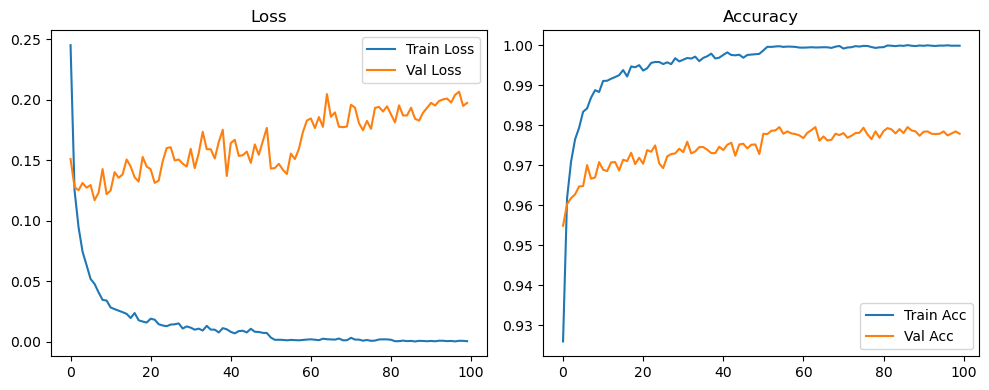

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2935, Acc: 0.9125 | Val Loss: 0.1530, Acc: 0.9525


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1658, Acc: 0.9497 | Val Loss: 0.1356, Acc: 0.9573


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1329, Acc: 0.9599 | Val Loss: 0.1258, Acc: 0.9610


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1115, Acc: 0.9659 | Val Loss: 0.1246, Acc: 0.9630


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0976, Acc: 0.9697 | Val Loss: 0.1055, Acc: 0.9688


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0889, Acc: 0.9714 | Val Loss: 0.1156, Acc: 0.9679


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0816, Acc: 0.9731 | Val Loss: 0.1091, Acc: 0.9692


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0695, Acc: 0.9778 | Val Loss: 0.1132, Acc: 0.9688


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0681, Acc: 0.9778 | Val Loss: 0.1077, Acc: 0.9719


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9799 | Val Loss: 0.1108, Acc: 0.9711


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9823 | Val Loss: 0.1104, Acc: 0.9706


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9838 | Val Loss: 0.1142, Acc: 0.9719


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9836 | Val Loss: 0.1136, Acc: 0.9712


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9843 | Val Loss: 0.1131, Acc: 0.9717


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9848 | Val Loss: 0.1074, Acc: 0.9726


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9870 | Val Loss: 0.1123, Acc: 0.9728


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9863 | Val Loss: 0.1093, Acc: 0.9730


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9858 | Val Loss: 0.1099, Acc: 0.9735


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9885 | Val Loss: 0.1169, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9877 | Val Loss: 0.1063, Acc: 0.9741


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9886 | Val Loss: 0.1158, Acc: 0.9731


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9895 | Val Loss: 0.1107, Acc: 0.9749


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9902 | Val Loss: 0.1190, Acc: 0.9726


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9904 | Val Loss: 0.1152, Acc: 0.9745


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.1127, Acc: 0.9748


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9905 | Val Loss: 0.1250, Acc: 0.9741


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9908 | Val Loss: 0.1274, Acc: 0.9734


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.1207, Acc: 0.9742


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.1257, Acc: 0.9746


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.1182, Acc: 0.9758


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.1225, Acc: 0.9754


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9921 | Val Loss: 0.1213, Acc: 0.9755


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9918 | Val Loss: 0.1133, Acc: 0.9759


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.1226, Acc: 0.9749


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.1266, Acc: 0.9752


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.1253, Acc: 0.9753


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.1315, Acc: 0.9746


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.1256, Acc: 0.9751


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9933 | Val Loss: 0.1332, Acc: 0.9760


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.1350, Acc: 0.9754


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9934 | Val Loss: 0.1451, Acc: 0.9735


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.1330, Acc: 0.9760


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.1381, Acc: 0.9749


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.1447, Acc: 0.9747


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.1439, Acc: 0.9747


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9927 | Val Loss: 0.1309, Acc: 0.9751


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.1300, Acc: 0.9764


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.1476, Acc: 0.9743


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9948 | Val Loss: 0.1299, Acc: 0.9763


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.1344, Acc: 0.9766


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1281, Acc: 0.9768


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1215, Acc: 0.9782


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1261, Acc: 0.9782


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1349, Acc: 0.9770


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1249, Acc: 0.9778


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1283, Acc: 0.9777


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1336, Acc: 0.9792


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1308, Acc: 0.9774


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1300, Acc: 0.9781


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1297, Acc: 0.9790


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1294, Acc: 0.9778


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1394, Acc: 0.9779


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1421, Acc: 0.9788


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1395, Acc: 0.9785


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1336, Acc: 0.9784


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1388, Acc: 0.9782


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1412, Acc: 0.9778


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1422, Acc: 0.9784


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1482, Acc: 0.9786


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1466, Acc: 0.9777


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1491, Acc: 0.9773


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1523, Acc: 0.9770


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1422, Acc: 0.9771


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1453, Acc: 0.9771


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1412, Acc: 0.9782


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1473, Acc: 0.9772


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1561, Acc: 0.9770


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1510, Acc: 0.9782


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1589, Acc: 0.9782


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1605, Acc: 0.9776


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1583, Acc: 0.9773


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1576, Acc: 0.9781


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1547, Acc: 0.9789


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1532, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1611, Acc: 0.9779


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1530, Acc: 0.9774


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1481, Acc: 0.9795


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.1512, Acc: 0.9780


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1513, Acc: 0.9788


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1569, Acc: 0.9781


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1563, Acc: 0.9780


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1609, Acc: 0.9772


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1600, Acc: 0.9776


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1661, Acc: 0.9791


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1606, Acc: 0.9792


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1620, Acc: 0.9788


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1647, Acc: 0.9780


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1567, Acc: 0.9792


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1529, Acc: 0.9798


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1506, Acc: 0.9792


Final Test Loss: 0.1313 Accuracy: 0.9819


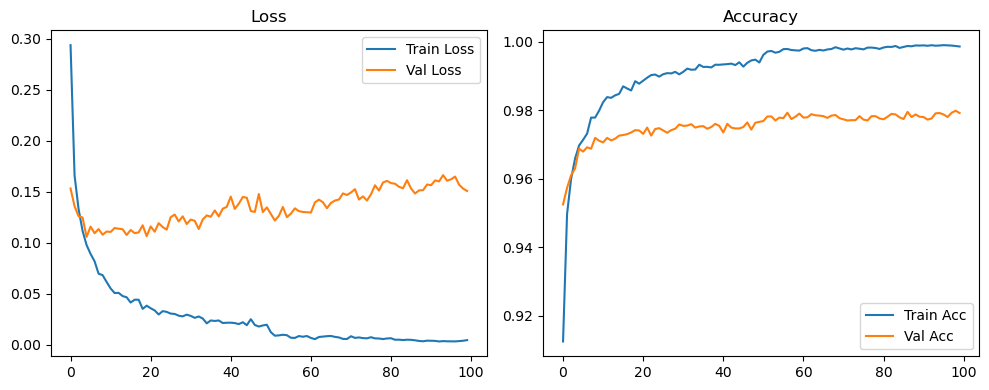

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4446, Acc: 0.8679 | Val Loss: 0.1912, Acc: 0.9445


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2898, Acc: 0.9137 | Val Loss: 0.1641, Acc: 0.9510


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2467, Acc: 0.9295 | Val Loss: 0.1570, Acc: 0.9538


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2173, Acc: 0.9364 | Val Loss: 0.1338, Acc: 0.9608


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2052, Acc: 0.9405 | Val Loss: 0.1328, Acc: 0.9627


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1939, Acc: 0.9442 | Val Loss: 0.1274, Acc: 0.9623


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1725, Acc: 0.9488 | Val Loss: 0.1166, Acc: 0.9663


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1644, Acc: 0.9513 | Val Loss: 0.1154, Acc: 0.9675


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1602, Acc: 0.9527 | Val Loss: 0.1113, Acc: 0.9676


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1513, Acc: 0.9544 | Val Loss: 0.1139, Acc: 0.9667


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1502, Acc: 0.9556 | Val Loss: 0.1035, Acc: 0.9701


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1407, Acc: 0.9572 | Val Loss: 0.1035, Acc: 0.9702


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1345, Acc: 0.9590 | Val Loss: 0.1042, Acc: 0.9724


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1360, Acc: 0.9603 | Val Loss: 0.1029, Acc: 0.9702


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1226, Acc: 0.9628 | Val Loss: 0.1045, Acc: 0.9715


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1228, Acc: 0.9634 | Val Loss: 0.1038, Acc: 0.9705


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1195, Acc: 0.9625 | Val Loss: 0.1100, Acc: 0.9710


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1217, Acc: 0.9632 | Val Loss: 0.1045, Acc: 0.9709


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1157, Acc: 0.9658 | Val Loss: 0.1009, Acc: 0.9738


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1090, Acc: 0.9667 | Val Loss: 0.1018, Acc: 0.9735


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1083, Acc: 0.9660 | Val Loss: 0.1036, Acc: 0.9711


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1077, Acc: 0.9670 | Val Loss: 0.1056, Acc: 0.9732


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1036, Acc: 0.9682 | Val Loss: 0.1017, Acc: 0.9729


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1022, Acc: 0.9688 | Val Loss: 0.1015, Acc: 0.9734


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1021, Acc: 0.9691 | Val Loss: 0.1043, Acc: 0.9712


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1019, Acc: 0.9699 | Val Loss: 0.0990, Acc: 0.9731


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0975, Acc: 0.9697 | Val Loss: 0.1087, Acc: 0.9718


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0969, Acc: 0.9704 | Val Loss: 0.0959, Acc: 0.9745


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0966, Acc: 0.9704 | Val Loss: 0.1049, Acc: 0.9737


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0952, Acc: 0.9710 | Val Loss: 0.1036, Acc: 0.9736


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0885, Acc: 0.9727 | Val Loss: 0.0996, Acc: 0.9754


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9719 | Val Loss: 0.1082, Acc: 0.9747


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0848, Acc: 0.9736 | Val Loss: 0.1015, Acc: 0.9740


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0890, Acc: 0.9721 | Val Loss: 0.1078, Acc: 0.9738


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0845, Acc: 0.9739 | Val Loss: 0.1059, Acc: 0.9749


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0847, Acc: 0.9736 | Val Loss: 0.1030, Acc: 0.9741


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0808, Acc: 0.9752 | Val Loss: 0.1105, Acc: 0.9743


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0829, Acc: 0.9744 | Val Loss: 0.1093, Acc: 0.9748


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0794, Acc: 0.9758 | Val Loss: 0.1047, Acc: 0.9732


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0788, Acc: 0.9755 | Val Loss: 0.1103, Acc: 0.9748


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0788, Acc: 0.9755 | Val Loss: 0.1115, Acc: 0.9738


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0761, Acc: 0.9774 | Val Loss: 0.1065, Acc: 0.9757


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0756, Acc: 0.9766 | Val Loss: 0.1124, Acc: 0.9750


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0776, Acc: 0.9759 | Val Loss: 0.1122, Acc: 0.9751


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0770, Acc: 0.9765 | Val Loss: 0.1068, Acc: 0.9732


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0748, Acc: 0.9768 | Val Loss: 0.1046, Acc: 0.9748


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0747, Acc: 0.9768 | Val Loss: 0.1106, Acc: 0.9748


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9775 | Val Loss: 0.1082, Acc: 0.9738


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9773 | Val Loss: 0.1143, Acc: 0.9743


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9749 | Val Loss: 0.1077, Acc: 0.9753


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0602, Acc: 0.9812 | Val Loss: 0.1016, Acc: 0.9758


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0582, Acc: 0.9824 | Val Loss: 0.1064, Acc: 0.9752


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0520, Acc: 0.9833 | Val Loss: 0.1011, Acc: 0.9765


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0518, Acc: 0.9834 | Val Loss: 0.1058, Acc: 0.9759


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9844 | Val Loss: 0.1054, Acc: 0.9769


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9854 | Val Loss: 0.1089, Acc: 0.9758


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9861 | Val Loss: 0.1146, Acc: 0.9756


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9851 | Val Loss: 0.1098, Acc: 0.9760


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0487, Acc: 0.9842 | Val Loss: 0.1070, Acc: 0.9758


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0439, Acc: 0.9860 | Val Loss: 0.1027, Acc: 0.9762


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9861 | Val Loss: 0.1105, Acc: 0.9758


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9853 | Val Loss: 0.1142, Acc: 0.9753


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9862 | Val Loss: 0.1067, Acc: 0.9767


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9865 | Val Loss: 0.1140, Acc: 0.9762


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9857 | Val Loss: 0.1056, Acc: 0.9756


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9844 | Val Loss: 0.1059, Acc: 0.9758


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9858 | Val Loss: 0.1111, Acc: 0.9755


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9857 | Val Loss: 0.1044, Acc: 0.9764


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9873 | Val Loss: 0.1071, Acc: 0.9768


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9875 | Val Loss: 0.1085, Acc: 0.9768


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9870 | Val Loss: 0.1127, Acc: 0.9741


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9866 | Val Loss: 0.1078, Acc: 0.9754


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9868 | Val Loss: 0.1057, Acc: 0.9765


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9864 | Val Loss: 0.1073, Acc: 0.9753


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9873 | Val Loss: 0.1071, Acc: 0.9759


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9879 | Val Loss: 0.1154, Acc: 0.9761


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.1116, Acc: 0.9768


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0392, Acc: 0.9875 | Val Loss: 0.1142, Acc: 0.9753


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9865 | Val Loss: 0.1104, Acc: 0.9760


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9882 | Val Loss: 0.1157, Acc: 0.9747


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9882 | Val Loss: 0.1069, Acc: 0.9761


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9889 | Val Loss: 0.1110, Acc: 0.9759


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9883 | Val Loss: 0.1084, Acc: 0.9761


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.1077, Acc: 0.9762


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9894 | Val Loss: 0.1096, Acc: 0.9764


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.1068, Acc: 0.9755


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.1117, Acc: 0.9765


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9896 | Val Loss: 0.1097, Acc: 0.9775


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9897 | Val Loss: 0.1096, Acc: 0.9767


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9896 | Val Loss: 0.1086, Acc: 0.9763


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9902 | Val Loss: 0.1160, Acc: 0.9752


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9903 | Val Loss: 0.1124, Acc: 0.9761


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.1155, Acc: 0.9761


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9904 | Val Loss: 0.1108, Acc: 0.9760


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.1129, Acc: 0.9768


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9898 | Val Loss: 0.1126, Acc: 0.9758


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9902 | Val Loss: 0.1107, Acc: 0.9771


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9897 | Val Loss: 0.1095, Acc: 0.9764


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9908 | Val Loss: 0.1102, Acc: 0.9778


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.1119, Acc: 0.9769


Final Test Loss: 0.1071 Accuracy: 0.9800


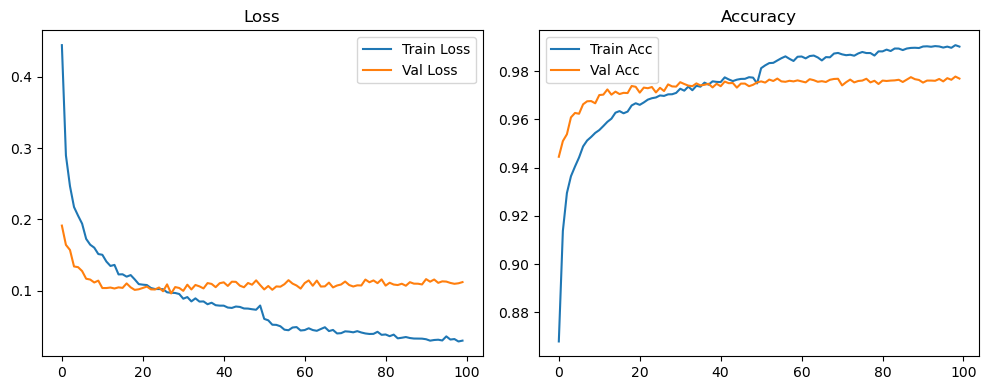

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2461, Acc: 0.9273 | Val Loss: 0.1516, Acc: 0.9530


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1188, Acc: 0.9636 | Val Loss: 0.1227, Acc: 0.9633


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0895, Acc: 0.9723 | Val Loss: 0.1329, Acc: 0.9607


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0693, Acc: 0.9776 | Val Loss: 0.1198, Acc: 0.9647


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0589, Acc: 0.9811 | Val Loss: 0.1174, Acc: 0.9671


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0501, Acc: 0.9835 | Val Loss: 0.1169, Acc: 0.9678


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9857 | Val Loss: 0.1141, Acc: 0.9669


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9891 | Val Loss: 0.1143, Acc: 0.9713


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9885 | Val Loss: 0.1245, Acc: 0.9675


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.1339, Acc: 0.9686


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9900 | Val Loss: 0.1251, Acc: 0.9688


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9914 | Val Loss: 0.1274, Acc: 0.9692


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.1288, Acc: 0.9694


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9923 | Val Loss: 0.1373, Acc: 0.9692


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.1373, Acc: 0.9706


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.1224, Acc: 0.9716


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.1141, Acc: 0.9728


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.1234, Acc: 0.9724


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.1254, Acc: 0.9722


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9943 | Val Loss: 0.1304, Acc: 0.9718


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.1334, Acc: 0.9744


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.1209, Acc: 0.9738


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.1309, Acc: 0.9719


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1348, Acc: 0.9716


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1323, Acc: 0.9751


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1371, Acc: 0.9722


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1345, Acc: 0.9741


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1184, Acc: 0.9748


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1296, Acc: 0.9740


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.1235, Acc: 0.9729


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1326, Acc: 0.9731


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1316, Acc: 0.9738


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1431, Acc: 0.9738


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1302, Acc: 0.9747


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1371, Acc: 0.9744


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1452, Acc: 0.9712


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1406, Acc: 0.9739


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1497, Acc: 0.9717


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1372, Acc: 0.9753


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1259, Acc: 0.9756


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1378, Acc: 0.9747


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1522, Acc: 0.9741


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9971 | Val Loss: 0.1335, Acc: 0.9758


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1243, Acc: 0.9766


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1384, Acc: 0.9749


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1359, Acc: 0.9745


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1411, Acc: 0.9770


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1373, Acc: 0.9765


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1595, Acc: 0.9727


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1345, Acc: 0.9763


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1650, Acc: 0.9723


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1384, Acc: 0.9755


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1295, Acc: 0.9758


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1359, Acc: 0.9772


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1387, Acc: 0.9774


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1360, Acc: 0.9758


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1429, Acc: 0.9758


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1458, Acc: 0.9762


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1509, Acc: 0.9759


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1484, Acc: 0.9737


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1422, Acc: 0.9762


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1467, Acc: 0.9774


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1467, Acc: 0.9763


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1511, Acc: 0.9757


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1571, Acc: 0.9738


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1579, Acc: 0.9732


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.1533, Acc: 0.9767


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.1479, Acc: 0.9745


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1538, Acc: 0.9762


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1395, Acc: 0.9765


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1380, Acc: 0.9758


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1450, Acc: 0.9768


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1424, Acc: 0.9749


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1516, Acc: 0.9764


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1497, Acc: 0.9764


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1527, Acc: 0.9769


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1568, Acc: 0.9751


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1494, Acc: 0.9763


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1702, Acc: 0.9751


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1444, Acc: 0.9782


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1486, Acc: 0.9775


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1362, Acc: 0.9763


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1512, Acc: 0.9768


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1422, Acc: 0.9783


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1620, Acc: 0.9757


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1649, Acc: 0.9758


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1637, Acc: 0.9764


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1594, Acc: 0.9772


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1582, Acc: 0.9768


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1578, Acc: 0.9776


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1572, Acc: 0.9767


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1507, Acc: 0.9785


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1569, Acc: 0.9768


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1680, Acc: 0.9762


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1508, Acc: 0.9769


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1708, Acc: 0.9746


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1522, Acc: 0.9776


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1622, Acc: 0.9768


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1651, Acc: 0.9760


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1625, Acc: 0.9772


Final Test Loss: 0.1423 Accuracy: 0.9777


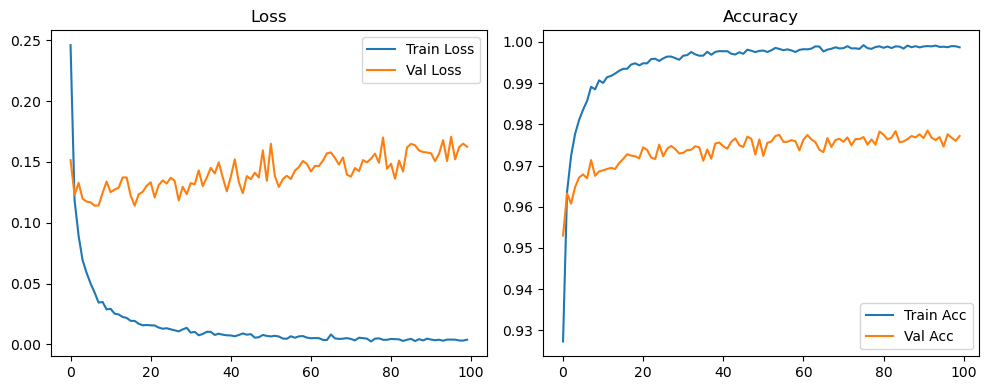

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3062, Acc: 0.9100 | Val Loss: 0.1528, Acc: 0.9533


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1603, Acc: 0.9512 | Val Loss: 0.1356, Acc: 0.9587


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1284, Acc: 0.9604 | Val Loss: 0.1282, Acc: 0.9613


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1105, Acc: 0.9666 | Val Loss: 0.1157, Acc: 0.9655


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0964, Acc: 0.9699 | Val Loss: 0.1058, Acc: 0.9678


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0857, Acc: 0.9725 | Val Loss: 0.1172, Acc: 0.9650


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0745, Acc: 0.9760 | Val Loss: 0.1010, Acc: 0.9702


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0684, Acc: 0.9782 | Val Loss: 0.1002, Acc: 0.9695


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0664, Acc: 0.9782 | Val Loss: 0.1155, Acc: 0.9681


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0621, Acc: 0.9794 | Val Loss: 0.1098, Acc: 0.9690


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9820 | Val Loss: 0.1053, Acc: 0.9707


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9818 | Val Loss: 0.1106, Acc: 0.9694


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9839 | Val Loss: 0.1047, Acc: 0.9732


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9851 | Val Loss: 0.1015, Acc: 0.9721


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0444, Acc: 0.9849 | Val Loss: 0.1076, Acc: 0.9727


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9864 | Val Loss: 0.1069, Acc: 0.9734


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.1088, Acc: 0.9708


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9878 | Val Loss: 0.1069, Acc: 0.9722


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9871 | Val Loss: 0.1031, Acc: 0.9748


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9879 | Val Loss: 0.1053, Acc: 0.9729


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9885 | Val Loss: 0.1047, Acc: 0.9740


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9885 | Val Loss: 0.1135, Acc: 0.9722


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.0996, Acc: 0.9750


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9906 | Val Loss: 0.1111, Acc: 0.9741


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9904 | Val Loss: 0.1135, Acc: 0.9734


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9906 | Val Loss: 0.1091, Acc: 0.9728


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.1162, Acc: 0.9740


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.1151, Acc: 0.9732


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9913 | Val Loss: 0.1123, Acc: 0.9750


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9916 | Val Loss: 0.1134, Acc: 0.9726


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9918 | Val Loss: 0.1196, Acc: 0.9727


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.1080, Acc: 0.9771


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.1062, Acc: 0.9754


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.1155, Acc: 0.9753


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.1177, Acc: 0.9747


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9920 | Val Loss: 0.1156, Acc: 0.9755


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.1164, Acc: 0.9736


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9931 | Val Loss: 0.1219, Acc: 0.9743


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9935 | Val Loss: 0.1145, Acc: 0.9750


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.1196, Acc: 0.9741


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1148, Acc: 0.9751


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9936 | Val Loss: 0.1257, Acc: 0.9743


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.1197, Acc: 0.9748


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.1244, Acc: 0.9738


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.1191, Acc: 0.9761


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.1163, Acc: 0.9740


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9949 | Val Loss: 0.1073, Acc: 0.9752


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1186, Acc: 0.9757


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1187, Acc: 0.9749


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9941 | Val Loss: 0.1210, Acc: 0.9749


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.1213, Acc: 0.9740


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.1227, Acc: 0.9750


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.1162, Acc: 0.9756


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.1203, Acc: 0.9762


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.1151, Acc: 0.9761


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9949 | Val Loss: 0.1105, Acc: 0.9773


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.1223, Acc: 0.9757


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1195, Acc: 0.9755


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1216, Acc: 0.9743


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9950 | Val Loss: 0.1140, Acc: 0.9765


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.1184, Acc: 0.9748


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.1149, Acc: 0.9765


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.1219, Acc: 0.9760


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1148, Acc: 0.9769


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1152, Acc: 0.9756


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1115, Acc: 0.9768


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.1175, Acc: 0.9767


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1161, Acc: 0.9782


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.1166, Acc: 0.9782


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1213, Acc: 0.9771


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.1321, Acc: 0.9772


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.1256, Acc: 0.9754


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1164, Acc: 0.9773


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9963 | Val Loss: 0.1151, Acc: 0.9778


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1297, Acc: 0.9762


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1303, Acc: 0.9761


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1236, Acc: 0.9762


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1318, Acc: 0.9757


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1243, Acc: 0.9771


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1271, Acc: 0.9761


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1256, Acc: 0.9764


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.1278, Acc: 0.9752


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1359, Acc: 0.9757


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9967 | Val Loss: 0.1327, Acc: 0.9772


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1307, Acc: 0.9766


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1275, Acc: 0.9772


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1274, Acc: 0.9763


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1308, Acc: 0.9773


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1304, Acc: 0.9772


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1207, Acc: 0.9769


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1244, Acc: 0.9769


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1226, Acc: 0.9778


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1304, Acc: 0.9756


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9965 | Val Loss: 0.1219, Acc: 0.9760


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1159, Acc: 0.9778


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1211, Acc: 0.9767


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1418, Acc: 0.9756


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1312, Acc: 0.9761


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1344, Acc: 0.9764


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1307, Acc: 0.9763


Final Test Loss: 0.1168 Accuracy: 0.9796


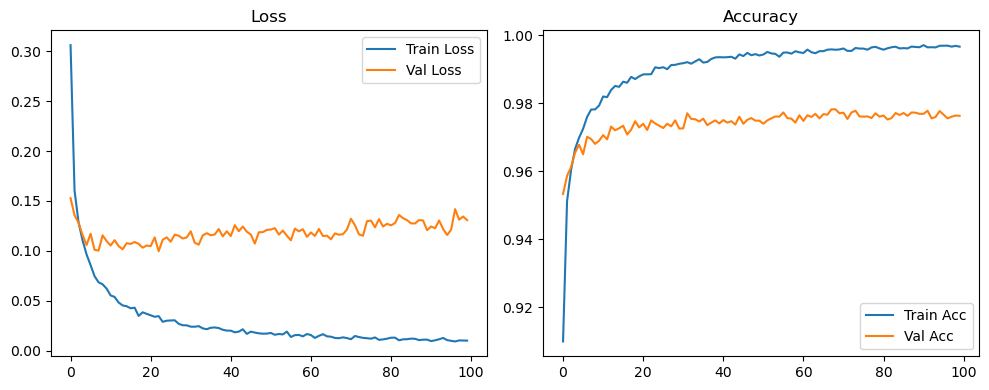

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4790, Acc: 0.8606 | Val Loss: 0.1967, Acc: 0.9409


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2827, Acc: 0.9178 | Val Loss: 0.1660, Acc: 0.9492


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2401, Acc: 0.9291 | Val Loss: 0.1514, Acc: 0.9547


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2150, Acc: 0.9375 | Val Loss: 0.1348, Acc: 0.9583


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.2003, Acc: 0.9416 | Val Loss: 0.1251, Acc: 0.9632


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1838, Acc: 0.9469 | Val Loss: 0.1218, Acc: 0.9647


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1740, Acc: 0.9475 | Val Loss: 0.1167, Acc: 0.9663


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1612, Acc: 0.9513 | Val Loss: 0.1163, Acc: 0.9670


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1558, Acc: 0.9522 | Val Loss: 0.1187, Acc: 0.9649


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1520, Acc: 0.9549 | Val Loss: 0.1144, Acc: 0.9675


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1476, Acc: 0.9554 | Val Loss: 0.1123, Acc: 0.9685


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1378, Acc: 0.9579 | Val Loss: 0.1042, Acc: 0.9690


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1347, Acc: 0.9582 | Val Loss: 0.1088, Acc: 0.9693


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1320, Acc: 0.9590 | Val Loss: 0.1047, Acc: 0.9688


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1229, Acc: 0.9619 | Val Loss: 0.1070, Acc: 0.9688


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1229, Acc: 0.9617 | Val Loss: 0.1020, Acc: 0.9717


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1212, Acc: 0.9630 | Val Loss: 0.1043, Acc: 0.9693


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1164, Acc: 0.9638 | Val Loss: 0.1022, Acc: 0.9706


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1139, Acc: 0.9649 | Val Loss: 0.0930, Acc: 0.9718


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1060, Acc: 0.9666 | Val Loss: 0.1010, Acc: 0.9706


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1101, Acc: 0.9672 | Val Loss: 0.0972, Acc: 0.9716


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.1040, Acc: 0.9674 | Val Loss: 0.0994, Acc: 0.9719


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.1002, Acc: 0.9691 | Val Loss: 0.0996, Acc: 0.9732


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.1033, Acc: 0.9687 | Val Loss: 0.1025, Acc: 0.9704


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0984, Acc: 0.9695 | Val Loss: 0.1030, Acc: 0.9728


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0976, Acc: 0.9702 | Val Loss: 0.0988, Acc: 0.9727


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0983, Acc: 0.9685 | Val Loss: 0.1064, Acc: 0.9733


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0959, Acc: 0.9702 | Val Loss: 0.1026, Acc: 0.9708


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0916, Acc: 0.9718 | Val Loss: 0.1027, Acc: 0.9730


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0888, Acc: 0.9721 | Val Loss: 0.0951, Acc: 0.9748


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0901, Acc: 0.9717 | Val Loss: 0.0954, Acc: 0.9745


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0886, Acc: 0.9726 | Val Loss: 0.1018, Acc: 0.9722


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0855, Acc: 0.9732 | Val Loss: 0.1004, Acc: 0.9737


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0863, Acc: 0.9733 | Val Loss: 0.0992, Acc: 0.9729


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0807, Acc: 0.9749 | Val Loss: 0.1010, Acc: 0.9742


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0854, Acc: 0.9738 | Val Loss: 0.0976, Acc: 0.9752


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0808, Acc: 0.9750 | Val Loss: 0.0987, Acc: 0.9749


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0790, Acc: 0.9748 | Val Loss: 0.1015, Acc: 0.9742


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0785, Acc: 0.9744 | Val Loss: 0.1011, Acc: 0.9732


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0758, Acc: 0.9764 | Val Loss: 0.1029, Acc: 0.9732


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0774, Acc: 0.9753 | Val Loss: 0.1000, Acc: 0.9743


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0759, Acc: 0.9762 | Val Loss: 0.1051, Acc: 0.9737


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0680, Acc: 0.9779 | Val Loss: 0.1086, Acc: 0.9733


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0713, Acc: 0.9774 | Val Loss: 0.1029, Acc: 0.9743


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0744, Acc: 0.9763 | Val Loss: 0.1036, Acc: 0.9737


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0717, Acc: 0.9773 | Val Loss: 0.1030, Acc: 0.9741


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0714, Acc: 0.9773 | Val Loss: 0.0959, Acc: 0.9751


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0688, Acc: 0.9781 | Val Loss: 0.1035, Acc: 0.9732


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0687, Acc: 0.9780 | Val Loss: 0.0980, Acc: 0.9758


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0670, Acc: 0.9789 | Val Loss: 0.1009, Acc: 0.9755


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0704, Acc: 0.9776 | Val Loss: 0.0981, Acc: 0.9747


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0630, Acc: 0.9802 | Val Loss: 0.1044, Acc: 0.9739


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0691, Acc: 0.9784 | Val Loss: 0.1000, Acc: 0.9748


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0674, Acc: 0.9784 | Val Loss: 0.1014, Acc: 0.9754


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0680, Acc: 0.9780 | Val Loss: 0.1025, Acc: 0.9755


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0627, Acc: 0.9799 | Val Loss: 0.1010, Acc: 0.9750


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0609, Acc: 0.9806 | Val Loss: 0.1118, Acc: 0.9746


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0640, Acc: 0.9796 | Val Loss: 0.1066, Acc: 0.9745


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0629, Acc: 0.9799 | Val Loss: 0.1040, Acc: 0.9733


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0617, Acc: 0.9802 | Val Loss: 0.1057, Acc: 0.9744


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0632, Acc: 0.9797 | Val Loss: 0.1064, Acc: 0.9741


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0600, Acc: 0.9809 | Val Loss: 0.1085, Acc: 0.9732


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0571, Acc: 0.9819 | Val Loss: 0.1098, Acc: 0.9728


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0625, Acc: 0.9806 | Val Loss: 0.1049, Acc: 0.9748


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0642, Acc: 0.9792 | Val Loss: 0.1007, Acc: 0.9762


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0634, Acc: 0.9810 | Val Loss: 0.1040, Acc: 0.9738


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0584, Acc: 0.9812 | Val Loss: 0.1036, Acc: 0.9749


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9819 | Val Loss: 0.1042, Acc: 0.9747


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0588, Acc: 0.9816 | Val Loss: 0.1080, Acc: 0.9738


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0574, Acc: 0.9819 | Val Loss: 0.1150, Acc: 0.9737


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9814 | Val Loss: 0.1123, Acc: 0.9742


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0518, Acc: 0.9830 | Val Loss: 0.1181, Acc: 0.9741


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9822 | Val Loss: 0.1159, Acc: 0.9742


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0572, Acc: 0.9819 | Val Loss: 0.1108, Acc: 0.9739


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9822 | Val Loss: 0.1068, Acc: 0.9732


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0567, Acc: 0.9815 | Val Loss: 0.1052, Acc: 0.9753


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0535, Acc: 0.9831 | Val Loss: 0.1118, Acc: 0.9738


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0539, Acc: 0.9834 | Val Loss: 0.1123, Acc: 0.9745


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9833 | Val Loss: 0.1079, Acc: 0.9746


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9829 | Val Loss: 0.1066, Acc: 0.9746


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9831 | Val Loss: 0.1070, Acc: 0.9753


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0516, Acc: 0.9835 | Val Loss: 0.1030, Acc: 0.9758


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0537, Acc: 0.9827 | Val Loss: 0.1040, Acc: 0.9764


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0495, Acc: 0.9844 | Val Loss: 0.1082, Acc: 0.9758


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0551, Acc: 0.9826 | Val Loss: 0.1080, Acc: 0.9743


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0495, Acc: 0.9844 | Val Loss: 0.1090, Acc: 0.9749


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0514, Acc: 0.9839 | Val Loss: 0.1077, Acc: 0.9752


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9828 | Val Loss: 0.1096, Acc: 0.9750


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0514, Acc: 0.9833 | Val Loss: 0.1084, Acc: 0.9751


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9844 | Val Loss: 0.1067, Acc: 0.9751


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0535, Acc: 0.9833 | Val Loss: 0.1085, Acc: 0.9752


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0496, Acc: 0.9840 | Val Loss: 0.1111, Acc: 0.9751


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0496, Acc: 0.9842 | Val Loss: 0.1067, Acc: 0.9754


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0467, Acc: 0.9851 | Val Loss: 0.1081, Acc: 0.9750


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0516, Acc: 0.9828 | Val Loss: 0.1093, Acc: 0.9757


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0517, Acc: 0.9835 | Val Loss: 0.1061, Acc: 0.9749


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9852 | Val Loss: 0.1072, Acc: 0.9749


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0478, Acc: 0.9850 | Val Loss: 0.1069, Acc: 0.9742


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9851 | Val Loss: 0.1123, Acc: 0.9747


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9855 | Val Loss: 0.1091, Acc: 0.9742


Final Test Loss: 0.1016 Accuracy: 0.9780


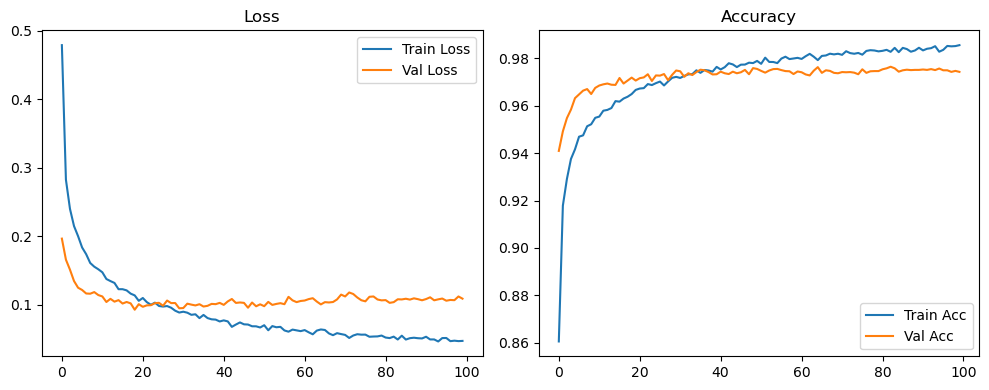

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2717, Acc: 0.9226 | Val Loss: 0.1423, Acc: 0.9568


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1133, Acc: 0.9643 | Val Loss: 0.1254, Acc: 0.9595


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0826, Acc: 0.9746 | Val Loss: 0.1201, Acc: 0.9638


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0649, Acc: 0.9793 | Val Loss: 0.1214, Acc: 0.9638


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0565, Acc: 0.9813 | Val Loss: 0.1068, Acc: 0.9690


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9853 | Val Loss: 0.1208, Acc: 0.9642


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9866 | Val Loss: 0.1126, Acc: 0.9674


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9879 | Val Loss: 0.1042, Acc: 0.9686


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9884 | Val Loss: 0.1221, Acc: 0.9675


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9905 | Val Loss: 0.1208, Acc: 0.9684


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9903 | Val Loss: 0.1173, Acc: 0.9696


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9912 | Val Loss: 0.1115, Acc: 0.9718


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.1148, Acc: 0.9705


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9919 | Val Loss: 0.1072, Acc: 0.9722


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.1307, Acc: 0.9684


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1232, Acc: 0.9706


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9938 | Val Loss: 0.1097, Acc: 0.9730


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9956 | Val Loss: 0.1179, Acc: 0.9709


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9944 | Val Loss: 0.1189, Acc: 0.9720


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9947 | Val Loss: 0.1250, Acc: 0.9692


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.1204, Acc: 0.9711


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1142, Acc: 0.9734


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1188, Acc: 0.9730


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1363, Acc: 0.9710


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1286, Acc: 0.9720


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1271, Acc: 0.9716


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1230, Acc: 0.9722


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1204, Acc: 0.9731


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1209, Acc: 0.9737


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1284, Acc: 0.9717


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.1256, Acc: 0.9728


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1181, Acc: 0.9744


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1273, Acc: 0.9726


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1229, Acc: 0.9752


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1228, Acc: 0.9746


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1349, Acc: 0.9736


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1303, Acc: 0.9730


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1304, Acc: 0.9752


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1221, Acc: 0.9747


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1175, Acc: 0.9737


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1312, Acc: 0.9732


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1308, Acc: 0.9738


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1215, Acc: 0.9745


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1318, Acc: 0.9743


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1243, Acc: 0.9762


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1249, Acc: 0.9760


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1326, Acc: 0.9756


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1232, Acc: 0.9733


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1167, Acc: 0.9752


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1187, Acc: 0.9758


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1424, Acc: 0.9722


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1265, Acc: 0.9755


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1181, Acc: 0.9769


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1258, Acc: 0.9766


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1302, Acc: 0.9745


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1400, Acc: 0.9735


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1364, Acc: 0.9750


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1349, Acc: 0.9752


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1303, Acc: 0.9739


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1402, Acc: 0.9732


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.1292, Acc: 0.9740


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1279, Acc: 0.9753


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1302, Acc: 0.9752


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1311, Acc: 0.9751


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1407, Acc: 0.9733


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1391, Acc: 0.9732


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1394, Acc: 0.9735


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1405, Acc: 0.9754


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1377, Acc: 0.9745


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1453, Acc: 0.9745


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1420, Acc: 0.9758


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1364, Acc: 0.9752


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1353, Acc: 0.9762


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1352, Acc: 0.9764


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1367, Acc: 0.9756


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1414, Acc: 0.9738


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1319, Acc: 0.9768


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1425, Acc: 0.9750


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1612, Acc: 0.9760


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1540, Acc: 0.9742


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1540, Acc: 0.9734


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1554, Acc: 0.9746


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.1365, Acc: 0.9762


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1501, Acc: 0.9752


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1465, Acc: 0.9742


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1365, Acc: 0.9760


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1521, Acc: 0.9750


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1387, Acc: 0.9760


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1418, Acc: 0.9760


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1386, Acc: 0.9769


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1288, Acc: 0.9776


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1310, Acc: 0.9768


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1395, Acc: 0.9755


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1334, Acc: 0.9767


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1439, Acc: 0.9755


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1396, Acc: 0.9768


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1485, Acc: 0.9742


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1346, Acc: 0.9778


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1566, Acc: 0.9752


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1488, Acc: 0.9763


Final Test Loss: 0.1453 Accuracy: 0.9774


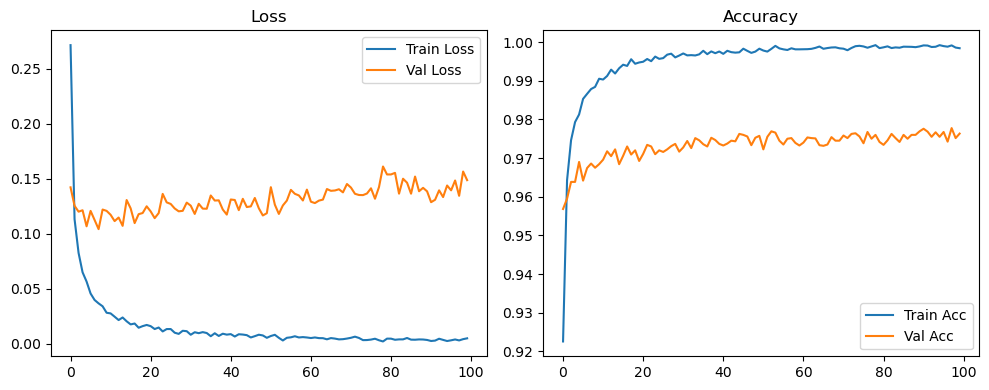

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3434, Acc: 0.9033 | Val Loss: 0.1606, Acc: 0.9497


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1613, Acc: 0.9500 | Val Loss: 0.1342, Acc: 0.9579


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1304, Acc: 0.9592 | Val Loss: 0.1273, Acc: 0.9587


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1079, Acc: 0.9665 | Val Loss: 0.1153, Acc: 0.9646


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0952, Acc: 0.9705 | Val Loss: 0.1110, Acc: 0.9681


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0866, Acc: 0.9725 | Val Loss: 0.1160, Acc: 0.9663


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0781, Acc: 0.9748 | Val Loss: 0.1072, Acc: 0.9679


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0702, Acc: 0.9772 | Val Loss: 0.1021, Acc: 0.9698


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0641, Acc: 0.9790 | Val Loss: 0.1092, Acc: 0.9692


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0663, Acc: 0.9785 | Val Loss: 0.1130, Acc: 0.9676


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0556, Acc: 0.9818 | Val Loss: 0.1080, Acc: 0.9683


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0546, Acc: 0.9815 | Val Loss: 0.1025, Acc: 0.9712


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0503, Acc: 0.9833 | Val Loss: 0.1080, Acc: 0.9703


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9839 | Val Loss: 0.1041, Acc: 0.9718


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9853 | Val Loss: 0.1149, Acc: 0.9688


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9854 | Val Loss: 0.1035, Acc: 0.9722


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9861 | Val Loss: 0.1049, Acc: 0.9722


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9867 | Val Loss: 0.1025, Acc: 0.9723


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9869 | Val Loss: 0.1111, Acc: 0.9712


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9876 | Val Loss: 0.1058, Acc: 0.9729


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9872 | Val Loss: 0.1087, Acc: 0.9732


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9882 | Val Loss: 0.1085, Acc: 0.9713


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9884 | Val Loss: 0.1082, Acc: 0.9718


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9899 | Val Loss: 0.1110, Acc: 0.9712


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9898 | Val Loss: 0.1116, Acc: 0.9708


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.1051, Acc: 0.9725


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9901 | Val Loss: 0.1171, Acc: 0.9709


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9904 | Val Loss: 0.1050, Acc: 0.9724


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9909 | Val Loss: 0.1239, Acc: 0.9708


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9911 | Val Loss: 0.1169, Acc: 0.9737


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.1205, Acc: 0.9716


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9911 | Val Loss: 0.1095, Acc: 0.9738


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9919 | Val Loss: 0.1173, Acc: 0.9713


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.1135, Acc: 0.9732


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.1155, Acc: 0.9722


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9919 | Val Loss: 0.1158, Acc: 0.9734


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.1078, Acc: 0.9758


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9922 | Val Loss: 0.1132, Acc: 0.9735


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.1182, Acc: 0.9728


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9920 | Val Loss: 0.1154, Acc: 0.9739


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9931 | Val Loss: 0.1143, Acc: 0.9732


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.1118, Acc: 0.9744


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9935 | Val Loss: 0.1239, Acc: 0.9720


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.1174, Acc: 0.9727


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.1168, Acc: 0.9735


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9935 | Val Loss: 0.1179, Acc: 0.9726


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1158, Acc: 0.9733


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.1275, Acc: 0.9714


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1146, Acc: 0.9746


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.1207, Acc: 0.9729


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.1101, Acc: 0.9758


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1111, Acc: 0.9754


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.1099, Acc: 0.9761


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.1180, Acc: 0.9749


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.1090, Acc: 0.9761


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9947 | Val Loss: 0.1146, Acc: 0.9750


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.1174, Acc: 0.9748


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9948 | Val Loss: 0.1198, Acc: 0.9767


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.1231, Acc: 0.9754


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1251, Acc: 0.9743


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9956 | Val Loss: 0.1151, Acc: 0.9749


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.1145, Acc: 0.9748


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1175, Acc: 0.9750


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.1140, Acc: 0.9755


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.1189, Acc: 0.9748


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.1203, Acc: 0.9748


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9958 | Val Loss: 0.1254, Acc: 0.9744


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1167, Acc: 0.9755


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9950 | Val Loss: 0.1148, Acc: 0.9751


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.1072, Acc: 0.9769


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1200, Acc: 0.9760


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1108, Acc: 0.9757


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1251, Acc: 0.9742


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1236, Acc: 0.9755


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1280, Acc: 0.9738


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1201, Acc: 0.9742


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.1237, Acc: 0.9741


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.1311, Acc: 0.9739


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1240, Acc: 0.9752


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1189, Acc: 0.9766


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1148, Acc: 0.9756


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.1293, Acc: 0.9741


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1284, Acc: 0.9738


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1252, Acc: 0.9758


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1280, Acc: 0.9754


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1263, Acc: 0.9743


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1321, Acc: 0.9734


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9959 | Val Loss: 0.1199, Acc: 0.9758


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1159, Acc: 0.9752


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1088, Acc: 0.9774


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1271, Acc: 0.9754


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1189, Acc: 0.9753


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1244, Acc: 0.9758


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1275, Acc: 0.9762


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1243, Acc: 0.9747


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1179, Acc: 0.9761


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.1209, Acc: 0.9759


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1214, Acc: 0.9767


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1241, Acc: 0.9750


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1209, Acc: 0.9758


Final Test Loss: 0.1187 Accuracy: 0.9765


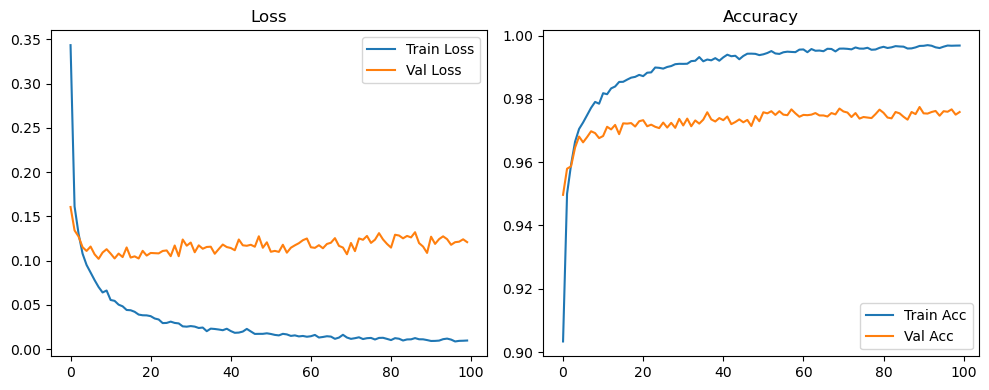

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5651, Acc: 0.8359 | Val Loss: 0.2144, Acc: 0.9350


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2943, Acc: 0.9142 | Val Loss: 0.1719, Acc: 0.9491


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2471, Acc: 0.9276 | Val Loss: 0.1550, Acc: 0.9560


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2191, Acc: 0.9354 | Val Loss: 0.1406, Acc: 0.9593


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2060, Acc: 0.9383 | Val Loss: 0.1300, Acc: 0.9607


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1913, Acc: 0.9427 | Val Loss: 0.1275, Acc: 0.9624


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1793, Acc: 0.9472 | Val Loss: 0.1204, Acc: 0.9646


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1658, Acc: 0.9506 | Val Loss: 0.1200, Acc: 0.9644


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1610, Acc: 0.9519 | Val Loss: 0.1159, Acc: 0.9657


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1574, Acc: 0.9524 | Val Loss: 0.1153, Acc: 0.9654


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1524, Acc: 0.9544 | Val Loss: 0.1128, Acc: 0.9671


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1460, Acc: 0.9563 | Val Loss: 0.1091, Acc: 0.9673


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1393, Acc: 0.9567 | Val Loss: 0.1063, Acc: 0.9694


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1330, Acc: 0.9593 | Val Loss: 0.1134, Acc: 0.9676


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1298, Acc: 0.9603 | Val Loss: 0.1109, Acc: 0.9691


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1261, Acc: 0.9607 | Val Loss: 0.1069, Acc: 0.9689


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1223, Acc: 0.9620 | Val Loss: 0.1064, Acc: 0.9702


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1197, Acc: 0.9636 | Val Loss: 0.1031, Acc: 0.9698


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1163, Acc: 0.9637 | Val Loss: 0.1047, Acc: 0.9692


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1165, Acc: 0.9644 | Val Loss: 0.1046, Acc: 0.9689


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1154, Acc: 0.9645 | Val Loss: 0.1015, Acc: 0.9714


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1077, Acc: 0.9663 | Val Loss: 0.1039, Acc: 0.9711


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1091, Acc: 0.9661 | Val Loss: 0.1026, Acc: 0.9721


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1071, Acc: 0.9673 | Val Loss: 0.1070, Acc: 0.9704


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1007, Acc: 0.9686 | Val Loss: 0.1065, Acc: 0.9718


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.1019, Acc: 0.9683 | Val Loss: 0.1027, Acc: 0.9720


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.1018, Acc: 0.9687 | Val Loss: 0.1009, Acc: 0.9723


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0961, Acc: 0.9685 | Val Loss: 0.1006, Acc: 0.9725


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0995, Acc: 0.9689 | Val Loss: 0.1018, Acc: 0.9719


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0914, Acc: 0.9716 | Val Loss: 0.1008, Acc: 0.9732


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0953, Acc: 0.9706 | Val Loss: 0.1060, Acc: 0.9723


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0934, Acc: 0.9712 | Val Loss: 0.1050, Acc: 0.9721


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0853, Acc: 0.9723 | Val Loss: 0.0996, Acc: 0.9729


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0871, Acc: 0.9718 | Val Loss: 0.1013, Acc: 0.9725


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0840, Acc: 0.9733 | Val Loss: 0.1082, Acc: 0.9713


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0876, Acc: 0.9724 | Val Loss: 0.1027, Acc: 0.9729


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0862, Acc: 0.9734 | Val Loss: 0.1026, Acc: 0.9732


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0834, Acc: 0.9734 | Val Loss: 0.1028, Acc: 0.9712


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0803, Acc: 0.9740 | Val Loss: 0.1013, Acc: 0.9729


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0827, Acc: 0.9744 | Val Loss: 0.1031, Acc: 0.9722


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0798, Acc: 0.9744 | Val Loss: 0.1008, Acc: 0.9736


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0804, Acc: 0.9744 | Val Loss: 0.1049, Acc: 0.9735


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0768, Acc: 0.9761 | Val Loss: 0.1080, Acc: 0.9724


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0760, Acc: 0.9754 | Val Loss: 0.1059, Acc: 0.9725


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0752, Acc: 0.9763 | Val Loss: 0.1046, Acc: 0.9722


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0759, Acc: 0.9757 | Val Loss: 0.1020, Acc: 0.9741


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0784, Acc: 0.9753 | Val Loss: 0.0998, Acc: 0.9744


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0694, Acc: 0.9774 | Val Loss: 0.1079, Acc: 0.9722


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0739, Acc: 0.9764 | Val Loss: 0.1025, Acc: 0.9733


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0723, Acc: 0.9764 | Val Loss: 0.1043, Acc: 0.9742


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0710, Acc: 0.9772 | Val Loss: 0.1068, Acc: 0.9725


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0726, Acc: 0.9772 | Val Loss: 0.1033, Acc: 0.9738


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0716, Acc: 0.9764 | Val Loss: 0.1033, Acc: 0.9746


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0731, Acc: 0.9764 | Val Loss: 0.1047, Acc: 0.9722


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0708, Acc: 0.9777 | Val Loss: 0.0996, Acc: 0.9738


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0691, Acc: 0.9779 | Val Loss: 0.1007, Acc: 0.9738


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0666, Acc: 0.9789 | Val Loss: 0.1019, Acc: 0.9738


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0627, Acc: 0.9796 | Val Loss: 0.1016, Acc: 0.9748


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0645, Acc: 0.9792 | Val Loss: 0.1010, Acc: 0.9742


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0640, Acc: 0.9799 | Val Loss: 0.1039, Acc: 0.9744


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0638, Acc: 0.9801 | Val Loss: 0.1047, Acc: 0.9742


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0631, Acc: 0.9801 | Val Loss: 0.1135, Acc: 0.9718


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0627, Acc: 0.9795 | Val Loss: 0.1011, Acc: 0.9744


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0630, Acc: 0.9790 | Val Loss: 0.1041, Acc: 0.9745


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0667, Acc: 0.9785 | Val Loss: 0.1062, Acc: 0.9737


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0644, Acc: 0.9794 | Val Loss: 0.1019, Acc: 0.9758


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0617, Acc: 0.9808 | Val Loss: 0.1063, Acc: 0.9734


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0612, Acc: 0.9808 | Val Loss: 0.1038, Acc: 0.9748


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0591, Acc: 0.9809 | Val Loss: 0.1040, Acc: 0.9734


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0576, Acc: 0.9814 | Val Loss: 0.1063, Acc: 0.9744


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0589, Acc: 0.9812 | Val Loss: 0.1035, Acc: 0.9743


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0598, Acc: 0.9806 | Val Loss: 0.1051, Acc: 0.9729


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0572, Acc: 0.9816 | Val Loss: 0.1021, Acc: 0.9739


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0583, Acc: 0.9811 | Val Loss: 0.1056, Acc: 0.9734


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0576, Acc: 0.9814 | Val Loss: 0.1008, Acc: 0.9737


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0598, Acc: 0.9809 | Val Loss: 0.1063, Acc: 0.9750


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0546, Acc: 0.9826 | Val Loss: 0.1063, Acc: 0.9732


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0558, Acc: 0.9816 | Val Loss: 0.1086, Acc: 0.9739


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0567, Acc: 0.9818 | Val Loss: 0.1085, Acc: 0.9746


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0535, Acc: 0.9826 | Val Loss: 0.1078, Acc: 0.9739


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0547, Acc: 0.9825 | Val Loss: 0.1075, Acc: 0.9747


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0579, Acc: 0.9816 | Val Loss: 0.1098, Acc: 0.9739


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0528, Acc: 0.9828 | Val Loss: 0.1072, Acc: 0.9744


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0533, Acc: 0.9824 | Val Loss: 0.0998, Acc: 0.9740


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0556, Acc: 0.9823 | Val Loss: 0.1008, Acc: 0.9752


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0533, Acc: 0.9829 | Val Loss: 0.1071, Acc: 0.9747


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0554, Acc: 0.9830 | Val Loss: 0.1091, Acc: 0.9757


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0533, Acc: 0.9828 | Val Loss: 0.1146, Acc: 0.9747


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0527, Acc: 0.9830 | Val Loss: 0.1077, Acc: 0.9751


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0522, Acc: 0.9837 | Val Loss: 0.1086, Acc: 0.9742


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0504, Acc: 0.9838 | Val Loss: 0.1153, Acc: 0.9733


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0535, Acc: 0.9829 | Val Loss: 0.1089, Acc: 0.9727


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0517, Acc: 0.9835 | Val Loss: 0.1080, Acc: 0.9744


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9842 | Val Loss: 0.1093, Acc: 0.9738


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0517, Acc: 0.9830 | Val Loss: 0.1079, Acc: 0.9739


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0487, Acc: 0.9838 | Val Loss: 0.1091, Acc: 0.9739


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9839 | Val Loss: 0.1123, Acc: 0.9737


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0514, Acc: 0.9836 | Val Loss: 0.1048, Acc: 0.9744


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9848 | Val Loss: 0.1138, Acc: 0.9742


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9842 | Val Loss: 0.1095, Acc: 0.9742


Final Test Loss: 0.0968 Accuracy: 0.9769


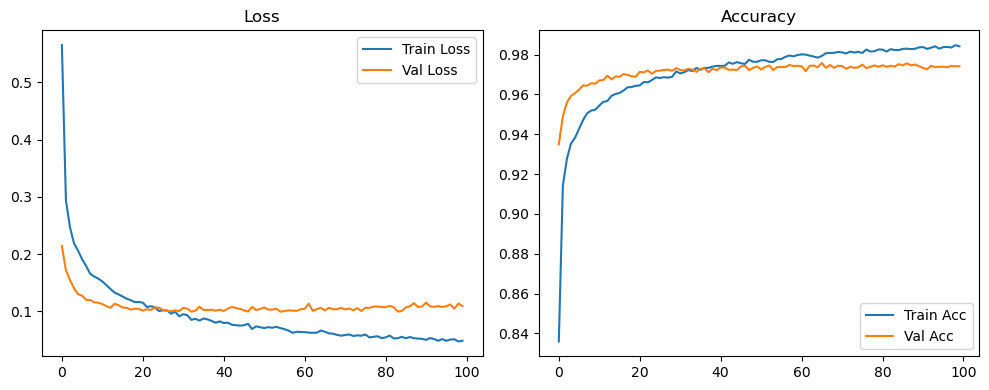

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2506, Acc: 0.9230 | Val Loss: 0.1634, Acc: 0.9489


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9623 | Val Loss: 0.1322, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0893, Acc: 0.9725 | Val Loss: 0.1257, Acc: 0.9638


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9785 | Val Loss: 0.1360, Acc: 0.9637


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9823 | Val Loss: 0.1346, Acc: 0.9623


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9841 | Val Loss: 0.1255, Acc: 0.9670


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9869 | Val Loss: 0.1232, Acc: 0.9703


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9875 | Val Loss: 0.1292, Acc: 0.9673


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.1384, Acc: 0.9678


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9918 | Val Loss: 0.1380, Acc: 0.9689


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.1334, Acc: 0.9689


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.1246, Acc: 0.9704


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.1348, Acc: 0.9687


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.1366, Acc: 0.9695


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1666, Acc: 0.9655


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1465, Acc: 0.9701


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.1450, Acc: 0.9712


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.1455, Acc: 0.9714


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1502, Acc: 0.9720


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1455, Acc: 0.9729


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1333, Acc: 0.9727


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1607, Acc: 0.9707


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1517, Acc: 0.9718


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.1609, Acc: 0.9713


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.1448, Acc: 0.9708


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.1443, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1650, Acc: 0.9716


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1384, Acc: 0.9743


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1612, Acc: 0.9727


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9960 | Val Loss: 0.1404, Acc: 0.9722


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1424, Acc: 0.9744


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1413, Acc: 0.9747


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1355, Acc: 0.9758


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1494, Acc: 0.9737


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1608, Acc: 0.9710


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1751, Acc: 0.9702


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1664, Acc: 0.9734


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1488, Acc: 0.9747


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.1501, Acc: 0.9753


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.1727, Acc: 0.9719


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9965 | Val Loss: 0.1778, Acc: 0.9696


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9983 | Val Loss: 0.1456, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.1571, Acc: 0.9746


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1756, Acc: 0.9733


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1721, Acc: 0.9740


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1545, Acc: 0.9760


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.1622, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1588, Acc: 0.9757


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1761, Acc: 0.9732


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1751, Acc: 0.9738


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9977 | Val Loss: 0.1675, Acc: 0.9749


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9975 | Val Loss: 0.1575, Acc: 0.9749


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1635, Acc: 0.9760


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1665, Acc: 0.9761


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1670, Acc: 0.9748


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1638, Acc: 0.9763


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1927, Acc: 0.9748


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1615, Acc: 0.9754


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1670, Acc: 0.9751


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1747, Acc: 0.9725


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1770, Acc: 0.9748


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1650, Acc: 0.9763


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1615, Acc: 0.9742


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1586, Acc: 0.9758


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1779, Acc: 0.9746


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1644, Acc: 0.9745


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1525, Acc: 0.9758


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1710, Acc: 0.9765


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1935, Acc: 0.9751


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9982 | Val Loss: 0.1641, Acc: 0.9750


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1528, Acc: 0.9766


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1795, Acc: 0.9744


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1827, Acc: 0.9764


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1902, Acc: 0.9738


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1676, Acc: 0.9764


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1745, Acc: 0.9768


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1935, Acc: 0.9742


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1789, Acc: 0.9759


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1881, Acc: 0.9742


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1647, Acc: 0.9769


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1941, Acc: 0.9750


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1859, Acc: 0.9749


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1952, Acc: 0.9742


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1828, Acc: 0.9752


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1908, Acc: 0.9747


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.2057, Acc: 0.9736


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1663, Acc: 0.9760


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.1737, Acc: 0.9758


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1715, Acc: 0.9764


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1984, Acc: 0.9751


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.2157, Acc: 0.9748


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9988 | Val Loss: 0.1967, Acc: 0.9747


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9983 | Val Loss: 0.1740, Acc: 0.9748


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1760, Acc: 0.9766


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1732, Acc: 0.9772


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1809, Acc: 0.9746


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1731, Acc: 0.9756


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1736, Acc: 0.9775


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1782, Acc: 0.9763


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.1792, Acc: 0.9748


Final Test Loss: 0.1592 Accuracy: 0.9775


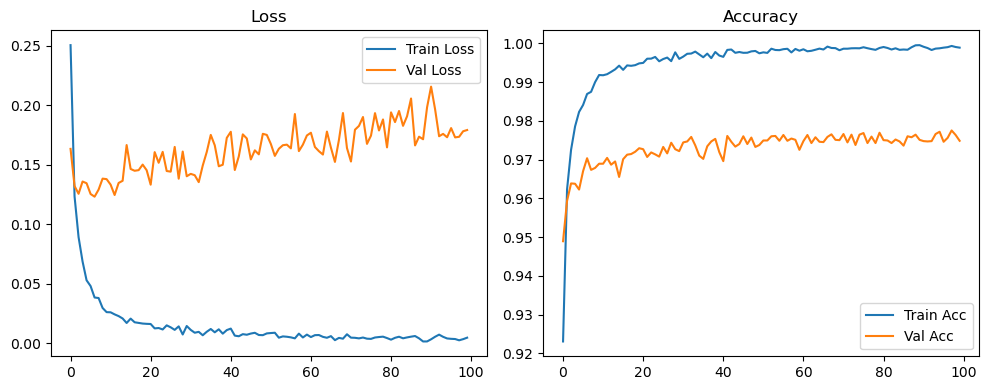

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2959, Acc: 0.9106 | Val Loss: 0.1681, Acc: 0.9497


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1651, Acc: 0.9487 | Val Loss: 0.1379, Acc: 0.9567


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9606 | Val Loss: 0.1381, Acc: 0.9587


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1055, Acc: 0.9666 | Val Loss: 0.1213, Acc: 0.9643


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9713 | Val Loss: 0.1121, Acc: 0.9683


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9749 | Val Loss: 0.1146, Acc: 0.9688


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9773 | Val Loss: 0.1160, Acc: 0.9681


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9784 | Val Loss: 0.1079, Acc: 0.9687


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9808 | Val Loss: 0.1208, Acc: 0.9693


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9820 | Val Loss: 0.1132, Acc: 0.9698


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9838 | Val Loss: 0.1047, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9850 | Val Loss: 0.1168, Acc: 0.9701


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.1206, Acc: 0.9714


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9878 | Val Loss: 0.1292, Acc: 0.9702


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9879 | Val Loss: 0.1283, Acc: 0.9707


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9878 | Val Loss: 0.1238, Acc: 0.9703


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9882 | Val Loss: 0.1217, Acc: 0.9724


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.1253, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.1156, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9901 | Val Loss: 0.1278, Acc: 0.9711


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9894 | Val Loss: 0.1238, Acc: 0.9739


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.1214, Acc: 0.9730


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.1221, Acc: 0.9759


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9907 | Val Loss: 0.1245, Acc: 0.9736


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9908 | Val Loss: 0.1334, Acc: 0.9730


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.1275, Acc: 0.9733


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.1290, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.1319, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.1380, Acc: 0.9745


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.1233, Acc: 0.9753


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.1299, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.1329, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9925 | Val Loss: 0.1323, Acc: 0.9752


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9940 | Val Loss: 0.1537, Acc: 0.9736


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.1473, Acc: 0.9722


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.1493, Acc: 0.9730


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9929 | Val Loss: 0.1437, Acc: 0.9736


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.1597, Acc: 0.9723


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9925 | Val Loss: 0.1341, Acc: 0.9766


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9934 | Val Loss: 0.1408, Acc: 0.9747


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.1452, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9945 | Val Loss: 0.1449, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9936 | Val Loss: 0.1531, Acc: 0.9747


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.1627, Acc: 0.9738


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9939 | Val Loss: 0.1578, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9928 | Val Loss: 0.1386, Acc: 0.9755


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9956 | Val Loss: 0.1518, Acc: 0.9765


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1819, Acc: 0.9753


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9948 | Val Loss: 0.1680, Acc: 0.9740


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.1573, Acc: 0.9737


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9944 | Val Loss: 0.1527, Acc: 0.9754


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9951 | Val Loss: 0.1490, Acc: 0.9755


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.1526, Acc: 0.9758


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9958 | Val Loss: 0.1491, Acc: 0.9766


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9954 | Val Loss: 0.1468, Acc: 0.9759


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9959 | Val Loss: 0.1539, Acc: 0.9763


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9955 | Val Loss: 0.1579, Acc: 0.9776


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9950 | Val Loss: 0.1785, Acc: 0.9754


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9947 | Val Loss: 0.1750, Acc: 0.9740


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.1704, Acc: 0.9756


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9957 | Val Loss: 0.1843, Acc: 0.9738


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9945 | Val Loss: 0.1624, Acc: 0.9738


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9960 | Val Loss: 0.1687, Acc: 0.9757


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9956 | Val Loss: 0.1501, Acc: 0.9748


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.1671, Acc: 0.9758


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9952 | Val Loss: 0.1662, Acc: 0.9748


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9956 | Val Loss: 0.1588, Acc: 0.9745


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9955 | Val Loss: 0.1610, Acc: 0.9748


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9953 | Val Loss: 0.1624, Acc: 0.9749


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9960 | Val Loss: 0.1629, Acc: 0.9750


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9952 | Val Loss: 0.1705, Acc: 0.9742


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9955 | Val Loss: 0.1810, Acc: 0.9757


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9963 | Val Loss: 0.1529, Acc: 0.9762


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.1650, Acc: 0.9760


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9969 | Val Loss: 0.1754, Acc: 0.9756


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1678, Acc: 0.9772


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9956 | Val Loss: 0.1779, Acc: 0.9727


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9960 | Val Loss: 0.1711, Acc: 0.9760


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9960 | Val Loss: 0.1822, Acc: 0.9767


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9966 | Val Loss: 0.1850, Acc: 0.9761


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9959 | Val Loss: 0.1750, Acc: 0.9755


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1732, Acc: 0.9771


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9962 | Val Loss: 0.1721, Acc: 0.9762


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9966 | Val Loss: 0.1805, Acc: 0.9769


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9963 | Val Loss: 0.1673, Acc: 0.9758


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9965 | Val Loss: 0.1801, Acc: 0.9744


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9962 | Val Loss: 0.1746, Acc: 0.9752


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9968 | Val Loss: 0.1886, Acc: 0.9767


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9967 | Val Loss: 0.1873, Acc: 0.9764


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1800, Acc: 0.9778


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9966 | Val Loss: 0.2198, Acc: 0.9747


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9959 | Val Loss: 0.1789, Acc: 0.9756


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1849, Acc: 0.9772


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9966 | Val Loss: 0.1837, Acc: 0.9772


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9970 | Val Loss: 0.1682, Acc: 0.9763


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9968 | Val Loss: 0.2004, Acc: 0.9728


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9968 | Val Loss: 0.2020, Acc: 0.9754


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9972 | Val Loss: 0.1814, Acc: 0.9771


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.2033, Acc: 0.9769


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9971 | Val Loss: 0.1787, Acc: 0.9764


Final Test Loss: 0.1584 Accuracy: 0.9788


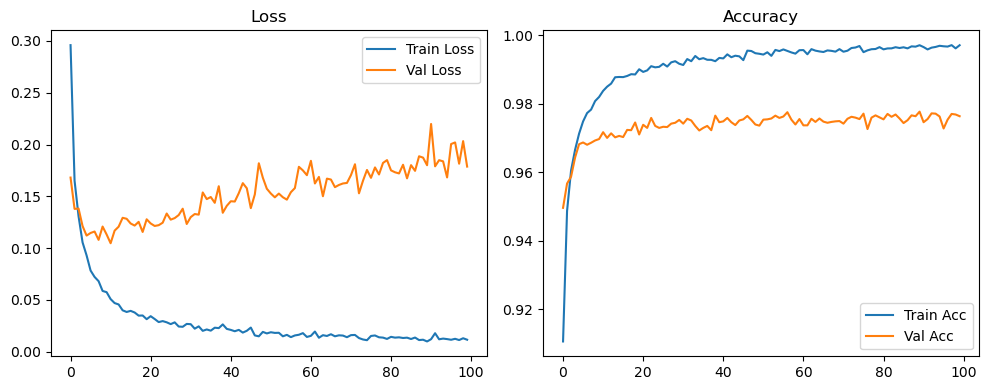

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4547, Acc: 0.8661 | Val Loss: 0.2049, Acc: 0.9367


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2787, Acc: 0.9199 | Val Loss: 0.1657, Acc: 0.9487


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2382, Acc: 0.9320 | Val Loss: 0.1452, Acc: 0.9567


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2108, Acc: 0.9395 | Val Loss: 0.1385, Acc: 0.9599


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1868, Acc: 0.9442 | Val Loss: 0.1289, Acc: 0.9635


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1766, Acc: 0.9483 | Val Loss: 0.1329, Acc: 0.9616


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1646, Acc: 0.9501 | Val Loss: 0.1369, Acc: 0.9641


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1559, Acc: 0.9545 | Val Loss: 0.1146, Acc: 0.9668


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9543 | Val Loss: 0.1190, Acc: 0.9677


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9579 | Val Loss: 0.1178, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1376, Acc: 0.9591 | Val Loss: 0.1161, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1327, Acc: 0.9602 | Val Loss: 0.1094, Acc: 0.9695


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1279, Acc: 0.9622 | Val Loss: 0.1089, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1262, Acc: 0.9625 | Val Loss: 0.1061, Acc: 0.9698


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9654 | Val Loss: 0.1064, Acc: 0.9708


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1174, Acc: 0.9660 | Val Loss: 0.1087, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1124, Acc: 0.9667 | Val Loss: 0.1098, Acc: 0.9706


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1100, Acc: 0.9664 | Val Loss: 0.1029, Acc: 0.9719


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1038, Acc: 0.9692 | Val Loss: 0.1071, Acc: 0.9730


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1096, Acc: 0.9671 | Val Loss: 0.1128, Acc: 0.9716


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1021, Acc: 0.9697 | Val Loss: 0.1101, Acc: 0.9718


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1010, Acc: 0.9700 | Val Loss: 0.1072, Acc: 0.9723


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0997, Acc: 0.9698 | Val Loss: 0.1110, Acc: 0.9726


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9711 | Val Loss: 0.1132, Acc: 0.9712


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0946, Acc: 0.9711 | Val Loss: 0.1152, Acc: 0.9728


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0951, Acc: 0.9711 | Val Loss: 0.1126, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0922, Acc: 0.9724 | Val Loss: 0.1179, Acc: 0.9724


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9731 | Val Loss: 0.1229, Acc: 0.9709


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9734 | Val Loss: 0.1125, Acc: 0.9728


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9741 | Val Loss: 0.1103, Acc: 0.9720


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9740 | Val Loss: 0.1102, Acc: 0.9735


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9750 | Val Loss: 0.1258, Acc: 0.9718


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9745 | Val Loss: 0.1154, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9755 | Val Loss: 0.1261, Acc: 0.9726


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9745 | Val Loss: 0.1245, Acc: 0.9732


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9747 | Val Loss: 0.1177, Acc: 0.9758


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9762 | Val Loss: 0.1173, Acc: 0.9745


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0800, Acc: 0.9753 | Val Loss: 0.1134, Acc: 0.9740


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9771 | Val Loss: 0.1100, Acc: 0.9736


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9787 | Val Loss: 0.1173, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9774 | Val Loss: 0.1226, Acc: 0.9732


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9765 | Val Loss: 0.1248, Acc: 0.9742


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9782 | Val Loss: 0.1195, Acc: 0.9735


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9763 | Val Loss: 0.1161, Acc: 0.9742


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9778 | Val Loss: 0.1192, Acc: 0.9743


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0705, Acc: 0.9786 | Val Loss: 0.1325, Acc: 0.9724


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9788 | Val Loss: 0.1190, Acc: 0.9738


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9796 | Val Loss: 0.1298, Acc: 0.9747


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9791 | Val Loss: 0.1245, Acc: 0.9728


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9809 | Val Loss: 0.1194, Acc: 0.9753


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9799 | Val Loss: 0.1224, Acc: 0.9742


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0680, Acc: 0.9799 | Val Loss: 0.1154, Acc: 0.9740


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9802 | Val Loss: 0.1233, Acc: 0.9738


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9809 | Val Loss: 0.1207, Acc: 0.9734


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9802 | Val Loss: 0.1245, Acc: 0.9752


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9819 | Val Loss: 0.1261, Acc: 0.9734


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9793 | Val Loss: 0.1230, Acc: 0.9733


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9813 | Val Loss: 0.1175, Acc: 0.9753


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9820 | Val Loss: 0.1242, Acc: 0.9746


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9815 | Val Loss: 0.1272, Acc: 0.9749


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9819 | Val Loss: 0.1301, Acc: 0.9735


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9807 | Val Loss: 0.1291, Acc: 0.9726


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9831 | Val Loss: 0.1276, Acc: 0.9732


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9832 | Val Loss: 0.1472, Acc: 0.9727


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9822 | Val Loss: 0.1401, Acc: 0.9738


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9817 | Val Loss: 0.1234, Acc: 0.9756


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9814 | Val Loss: 0.1361, Acc: 0.9730


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9816 | Val Loss: 0.1340, Acc: 0.9749


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9829 | Val Loss: 0.1297, Acc: 0.9737


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9826 | Val Loss: 0.1374, Acc: 0.9752


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9824 | Val Loss: 0.1282, Acc: 0.9728


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9837 | Val Loss: 0.1314, Acc: 0.9748


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9834 | Val Loss: 0.1331, Acc: 0.9748


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9830 | Val Loss: 0.1326, Acc: 0.9740


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9836 | Val Loss: 0.1238, Acc: 0.9751


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9826 | Val Loss: 0.1283, Acc: 0.9758


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9850 | Val Loss: 0.1332, Acc: 0.9746


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9851 | Val Loss: 0.1413, Acc: 0.9735


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9846 | Val Loss: 0.1330, Acc: 0.9752


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9833 | Val Loss: 0.1257, Acc: 0.9747


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9844 | Val Loss: 0.1348, Acc: 0.9750


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9839 | Val Loss: 0.1353, Acc: 0.9744


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9835 | Val Loss: 0.1482, Acc: 0.9752


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9846 | Val Loss: 0.1314, Acc: 0.9741


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9841 | Val Loss: 0.1404, Acc: 0.9728


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9852 | Val Loss: 0.1336, Acc: 0.9748


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9841 | Val Loss: 0.1335, Acc: 0.9745


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9843 | Val Loss: 0.1396, Acc: 0.9750


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9851 | Val Loss: 0.1405, Acc: 0.9746


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9850 | Val Loss: 0.1306, Acc: 0.9750


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9867 | Val Loss: 0.1384, Acc: 0.9730


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9849 | Val Loss: 0.1324, Acc: 0.9750


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9857 | Val Loss: 0.1355, Acc: 0.9737


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9840 | Val Loss: 0.1228, Acc: 0.9735


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9846 | Val Loss: 0.1340, Acc: 0.9744


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9840 | Val Loss: 0.1357, Acc: 0.9738


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9868 | Val Loss: 0.1362, Acc: 0.9765


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9861 | Val Loss: 0.1337, Acc: 0.9749


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9851 | Val Loss: 0.1361, Acc: 0.9735


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9844 | Val Loss: 0.1441, Acc: 0.9758


Final Test Loss: 0.1306 Accuracy: 0.9775


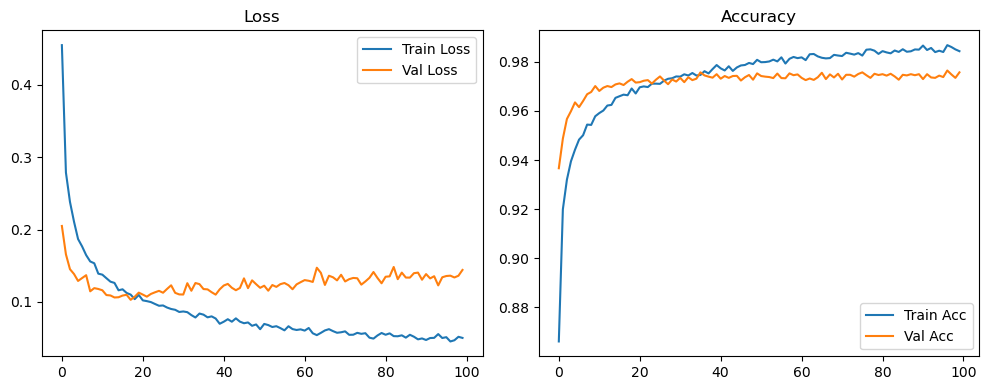

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2506, Acc: 0.9230 | Val Loss: 0.1634, Acc: 0.9489


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9623 | Val Loss: 0.1322, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0893, Acc: 0.9725 | Val Loss: 0.1257, Acc: 0.9638


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9785 | Val Loss: 0.1360, Acc: 0.9637


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9823 | Val Loss: 0.1346, Acc: 0.9623


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9841 | Val Loss: 0.1255, Acc: 0.9670


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9869 | Val Loss: 0.1232, Acc: 0.9703


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9875 | Val Loss: 0.1292, Acc: 0.9673


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.1384, Acc: 0.9678


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9918 | Val Loss: 0.1380, Acc: 0.9689


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.1334, Acc: 0.9689


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.1246, Acc: 0.9704


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.1348, Acc: 0.9687


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.1366, Acc: 0.9695


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1666, Acc: 0.9655


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1465, Acc: 0.9701


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.1450, Acc: 0.9712


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.1455, Acc: 0.9714


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1502, Acc: 0.9720


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1455, Acc: 0.9729


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1333, Acc: 0.9727


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1607, Acc: 0.9707


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1517, Acc: 0.9718


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.1609, Acc: 0.9713


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.1448, Acc: 0.9708


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.1443, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1650, Acc: 0.9716


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1384, Acc: 0.9743


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1612, Acc: 0.9727


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9960 | Val Loss: 0.1404, Acc: 0.9722


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1424, Acc: 0.9744


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1413, Acc: 0.9747


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1355, Acc: 0.9758


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1494, Acc: 0.9737


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1608, Acc: 0.9710


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1751, Acc: 0.9702


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1664, Acc: 0.9734


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1488, Acc: 0.9747


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.1501, Acc: 0.9753


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.1727, Acc: 0.9719


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9965 | Val Loss: 0.1778, Acc: 0.9696


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9983 | Val Loss: 0.1456, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.1571, Acc: 0.9746


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1756, Acc: 0.9733


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1721, Acc: 0.9740


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1545, Acc: 0.9760


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.1622, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1588, Acc: 0.9757


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1761, Acc: 0.9732


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1751, Acc: 0.9738


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1385, Acc: 0.9778


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1466, Acc: 0.9772


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1519, Acc: 0.9768


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1515, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1558, Acc: 0.9782


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1483, Acc: 0.9780


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1513, Acc: 0.9784


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1631, Acc: 0.9785


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1602, Acc: 0.9768


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1597, Acc: 0.9772


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1669, Acc: 0.9772


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1848, Acc: 0.9757


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1761, Acc: 0.9781


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1780, Acc: 0.9772


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1775, Acc: 0.9763


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1810, Acc: 0.9762


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1843, Acc: 0.9763


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1834, Acc: 0.9774


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1905, Acc: 0.9754


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1881, Acc: 0.9764


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.1905, Acc: 0.9772


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1875, Acc: 0.9780


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1819, Acc: 0.9763


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1913, Acc: 0.9766


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1784, Acc: 0.9774


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1818, Acc: 0.9771


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1908, Acc: 0.9770


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1997, Acc: 0.9755


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1948, Acc: 0.9768


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1704, Acc: 0.9778


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1652, Acc: 0.9782


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1773, Acc: 0.9772


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1757, Acc: 0.9770


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1759, Acc: 0.9773


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1763, Acc: 0.9777


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1700, Acc: 0.9782


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1681, Acc: 0.9784


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1720, Acc: 0.9798


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1741, Acc: 0.9791


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1742, Acc: 0.9778


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1778, Acc: 0.9786


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1793, Acc: 0.9784


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1882, Acc: 0.9783


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1939, Acc: 0.9783


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1883, Acc: 0.9775


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1894, Acc: 0.9783


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1902, Acc: 0.9780


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1911, Acc: 0.9782


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1859, Acc: 0.9787


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1926, Acc: 0.9783


Final Test Loss: 0.1879 Accuracy: 0.9798


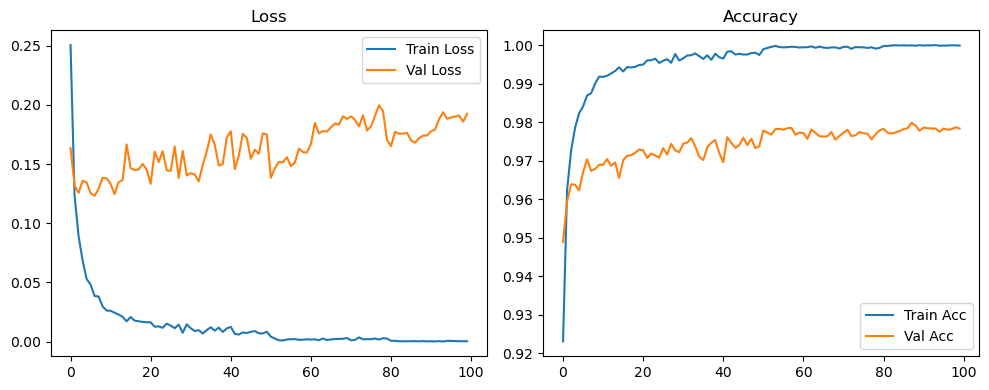

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2959, Acc: 0.9106 | Val Loss: 0.1681, Acc: 0.9497


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1651, Acc: 0.9487 | Val Loss: 0.1379, Acc: 0.9567


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9606 | Val Loss: 0.1381, Acc: 0.9587


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1055, Acc: 0.9666 | Val Loss: 0.1213, Acc: 0.9643


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9713 | Val Loss: 0.1121, Acc: 0.9683


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9749 | Val Loss: 0.1146, Acc: 0.9688


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9773 | Val Loss: 0.1160, Acc: 0.9681


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9784 | Val Loss: 0.1079, Acc: 0.9687


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9808 | Val Loss: 0.1208, Acc: 0.9693


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9820 | Val Loss: 0.1132, Acc: 0.9698


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9838 | Val Loss: 0.1047, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9850 | Val Loss: 0.1168, Acc: 0.9701


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.1206, Acc: 0.9714


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9878 | Val Loss: 0.1292, Acc: 0.9702


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9879 | Val Loss: 0.1283, Acc: 0.9707


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9878 | Val Loss: 0.1238, Acc: 0.9703


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9882 | Val Loss: 0.1217, Acc: 0.9724


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.1253, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.1156, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9901 | Val Loss: 0.1278, Acc: 0.9711


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9894 | Val Loss: 0.1238, Acc: 0.9739


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.1214, Acc: 0.9730


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.1221, Acc: 0.9759


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9907 | Val Loss: 0.1245, Acc: 0.9736


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9908 | Val Loss: 0.1334, Acc: 0.9730


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.1275, Acc: 0.9733


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.1290, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.1319, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.1380, Acc: 0.9745


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.1233, Acc: 0.9753


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.1299, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.1329, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9925 | Val Loss: 0.1323, Acc: 0.9752


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9940 | Val Loss: 0.1537, Acc: 0.9736


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.1473, Acc: 0.9722


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.1493, Acc: 0.9730


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9929 | Val Loss: 0.1437, Acc: 0.9736


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.1597, Acc: 0.9723


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9925 | Val Loss: 0.1341, Acc: 0.9766


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9934 | Val Loss: 0.1408, Acc: 0.9747


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.1452, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9945 | Val Loss: 0.1449, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9936 | Val Loss: 0.1531, Acc: 0.9747


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.1627, Acc: 0.9738


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9939 | Val Loss: 0.1578, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9928 | Val Loss: 0.1386, Acc: 0.9755


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9956 | Val Loss: 0.1518, Acc: 0.9765


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1819, Acc: 0.9753


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9948 | Val Loss: 0.1680, Acc: 0.9740


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.1573, Acc: 0.9737


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1414, Acc: 0.9764


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1511, Acc: 0.9775


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1416, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1422, Acc: 0.9784


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1424, Acc: 0.9770


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1443, Acc: 0.9784


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1536, Acc: 0.9789


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1467, Acc: 0.9779


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1473, Acc: 0.9794


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1613, Acc: 0.9790


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1692, Acc: 0.9764


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1670, Acc: 0.9766


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1674, Acc: 0.9766


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1567, Acc: 0.9766


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1554, Acc: 0.9774


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1636, Acc: 0.9759


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1649, Acc: 0.9768


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.1654, Acc: 0.9768


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.1631, Acc: 0.9765


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1745, Acc: 0.9771


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1683, Acc: 0.9768


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1665, Acc: 0.9771


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1478, Acc: 0.9776


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1628, Acc: 0.9784


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1617, Acc: 0.9790


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1607, Acc: 0.9777


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1626, Acc: 0.9785


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1825, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1612, Acc: 0.9766


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1650, Acc: 0.9778


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1619, Acc: 0.9779


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1582, Acc: 0.9796


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1594, Acc: 0.9790


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1691, Acc: 0.9787


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1659, Acc: 0.9777


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1690, Acc: 0.9787


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1652, Acc: 0.9786


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1629, Acc: 0.9796


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1650, Acc: 0.9789


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1720, Acc: 0.9784


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1698, Acc: 0.9791


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1618, Acc: 0.9796


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1695, Acc: 0.9789


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1674, Acc: 0.9800


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1833, Acc: 0.9776


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1872, Acc: 0.9778


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1709, Acc: 0.9792


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1715, Acc: 0.9782


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1796, Acc: 0.9782


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1819, Acc: 0.9786


Final Test Loss: 0.1419 Accuracy: 0.9819


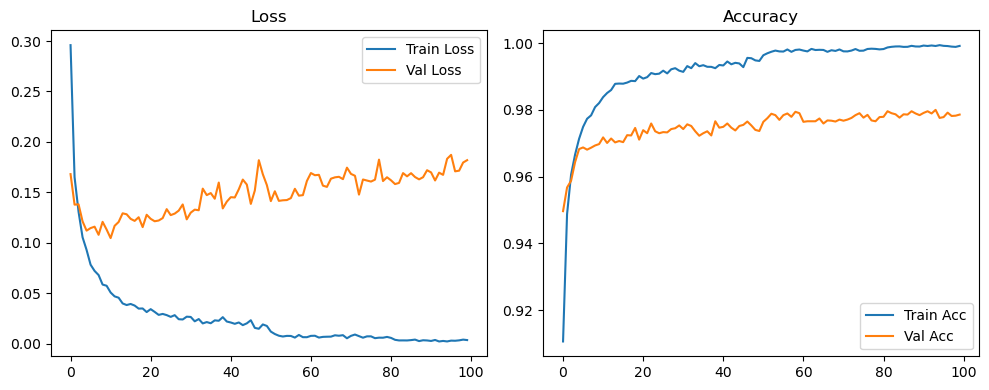

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4547, Acc: 0.8661 | Val Loss: 0.2049, Acc: 0.9367


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2787, Acc: 0.9199 | Val Loss: 0.1657, Acc: 0.9487


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2382, Acc: 0.9320 | Val Loss: 0.1452, Acc: 0.9567


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2108, Acc: 0.9395 | Val Loss: 0.1385, Acc: 0.9599


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1868, Acc: 0.9442 | Val Loss: 0.1289, Acc: 0.9635


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1766, Acc: 0.9483 | Val Loss: 0.1329, Acc: 0.9616


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1646, Acc: 0.9501 | Val Loss: 0.1369, Acc: 0.9641


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1559, Acc: 0.9545 | Val Loss: 0.1146, Acc: 0.9668


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9543 | Val Loss: 0.1190, Acc: 0.9677


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9579 | Val Loss: 0.1178, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1376, Acc: 0.9591 | Val Loss: 0.1161, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1327, Acc: 0.9602 | Val Loss: 0.1094, Acc: 0.9695


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1279, Acc: 0.9622 | Val Loss: 0.1089, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1262, Acc: 0.9625 | Val Loss: 0.1061, Acc: 0.9698


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9654 | Val Loss: 0.1064, Acc: 0.9708


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1174, Acc: 0.9660 | Val Loss: 0.1087, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1124, Acc: 0.9667 | Val Loss: 0.1098, Acc: 0.9706


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1100, Acc: 0.9664 | Val Loss: 0.1029, Acc: 0.9719


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1038, Acc: 0.9692 | Val Loss: 0.1071, Acc: 0.9730


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1096, Acc: 0.9671 | Val Loss: 0.1128, Acc: 0.9716


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1021, Acc: 0.9697 | Val Loss: 0.1101, Acc: 0.9718


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1010, Acc: 0.9700 | Val Loss: 0.1072, Acc: 0.9723


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0997, Acc: 0.9698 | Val Loss: 0.1110, Acc: 0.9726


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9711 | Val Loss: 0.1132, Acc: 0.9712


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0946, Acc: 0.9711 | Val Loss: 0.1152, Acc: 0.9728


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0951, Acc: 0.9711 | Val Loss: 0.1126, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0922, Acc: 0.9724 | Val Loss: 0.1179, Acc: 0.9724


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9731 | Val Loss: 0.1229, Acc: 0.9709


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9734 | Val Loss: 0.1125, Acc: 0.9728


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9741 | Val Loss: 0.1103, Acc: 0.9720


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9740 | Val Loss: 0.1102, Acc: 0.9735


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9750 | Val Loss: 0.1258, Acc: 0.9718


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9745 | Val Loss: 0.1154, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9755 | Val Loss: 0.1261, Acc: 0.9726


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9745 | Val Loss: 0.1245, Acc: 0.9732


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9747 | Val Loss: 0.1177, Acc: 0.9758


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9762 | Val Loss: 0.1173, Acc: 0.9745


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0800, Acc: 0.9753 | Val Loss: 0.1134, Acc: 0.9740


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9771 | Val Loss: 0.1100, Acc: 0.9736


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9787 | Val Loss: 0.1173, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9774 | Val Loss: 0.1226, Acc: 0.9732


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9765 | Val Loss: 0.1248, Acc: 0.9742


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9782 | Val Loss: 0.1195, Acc: 0.9735


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9763 | Val Loss: 0.1161, Acc: 0.9742


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9778 | Val Loss: 0.1192, Acc: 0.9743


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0705, Acc: 0.9786 | Val Loss: 0.1325, Acc: 0.9724


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9788 | Val Loss: 0.1190, Acc: 0.9738


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9796 | Val Loss: 0.1298, Acc: 0.9747


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9791 | Val Loss: 0.1245, Acc: 0.9728


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9809 | Val Loss: 0.1194, Acc: 0.9753


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0575, Acc: 0.9832 | Val Loss: 0.1150, Acc: 0.9759


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9840 | Val Loss: 0.1120, Acc: 0.9752


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9850 | Val Loss: 0.1124, Acc: 0.9758


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9862 | Val Loss: 0.1222, Acc: 0.9760


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9854 | Val Loss: 0.1142, Acc: 0.9768


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9861 | Val Loss: 0.1161, Acc: 0.9756


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9854 | Val Loss: 0.1191, Acc: 0.9747


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9866 | Val Loss: 0.1204, Acc: 0.9762


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9871 | Val Loss: 0.1235, Acc: 0.9754


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9871 | Val Loss: 0.1205, Acc: 0.9762


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.1222, Acc: 0.9762


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9866 | Val Loss: 0.1174, Acc: 0.9755


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9882 | Val Loss: 0.1162, Acc: 0.9755


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 0.1213, Acc: 0.9759


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9883 | Val Loss: 0.1234, Acc: 0.9766


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0430, Acc: 0.9862 | Val Loss: 0.1178, Acc: 0.9766


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9876 | Val Loss: 0.1211, Acc: 0.9775


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9872 | Val Loss: 0.1248, Acc: 0.9754


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9874 | Val Loss: 0.1189, Acc: 0.9762


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9879 | Val Loss: 0.1289, Acc: 0.9768


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9875 | Val Loss: 0.1238, Acc: 0.9764


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9886 | Val Loss: 0.1234, Acc: 0.9770


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9885 | Val Loss: 0.1265, Acc: 0.9753


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9880 | Val Loss: 0.1211, Acc: 0.9757


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9875 | Val Loss: 0.1150, Acc: 0.9760


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9873 | Val Loss: 0.1171, Acc: 0.9776


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9891 | Val Loss: 0.1234, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9892 | Val Loss: 0.1288, Acc: 0.9767


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9885 | Val Loss: 0.1232, Acc: 0.9748


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9873 | Val Loss: 0.1219, Acc: 0.9756


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9894 | Val Loss: 0.1231, Acc: 0.9767


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9902 | Val Loss: 0.1255, Acc: 0.9767


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9904 | Val Loss: 0.1258, Acc: 0.9767


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.1268, Acc: 0.9768


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9906 | Val Loss: 0.1261, Acc: 0.9779


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.1294, Acc: 0.9767


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9920 | Val Loss: 0.1263, Acc: 0.9764


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9915 | Val Loss: 0.1210, Acc: 0.9787


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9922 | Val Loss: 0.1279, Acc: 0.9772


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.1205, Acc: 0.9769


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.1304, Acc: 0.9766


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9914 | Val Loss: 0.1249, Acc: 0.9774


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.1256, Acc: 0.9763


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9915 | Val Loss: 0.1212, Acc: 0.9776


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.1243, Acc: 0.9762


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9917 | Val Loss: 0.1268, Acc: 0.9771


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9919 | Val Loss: 0.1267, Acc: 0.9768


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.1266, Acc: 0.9768


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9921 | Val Loss: 0.1247, Acc: 0.9768


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9921 | Val Loss: 0.1272, Acc: 0.9766


Final Test Loss: 0.1196 Accuracy: 0.9787


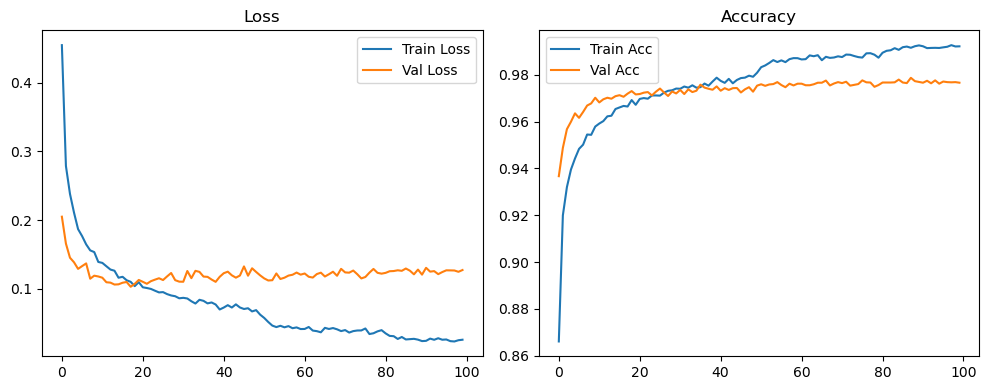

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2506, Acc: 0.9230 | Val Loss: 0.1634, Acc: 0.9489


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9623 | Val Loss: 0.1322, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0893, Acc: 0.9725 | Val Loss: 0.1257, Acc: 0.9638


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9785 | Val Loss: 0.1360, Acc: 0.9637


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9823 | Val Loss: 0.1346, Acc: 0.9623


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9841 | Val Loss: 0.1255, Acc: 0.9670


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9869 | Val Loss: 0.1232, Acc: 0.9703


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9875 | Val Loss: 0.1292, Acc: 0.9673


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.1384, Acc: 0.9678


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9918 | Val Loss: 0.1380, Acc: 0.9689


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.1334, Acc: 0.9689


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.1246, Acc: 0.9704


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.1348, Acc: 0.9687


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.1366, Acc: 0.9695


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1666, Acc: 0.9655


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1465, Acc: 0.9701


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.1450, Acc: 0.9712


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.1455, Acc: 0.9714


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1502, Acc: 0.9720


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1455, Acc: 0.9729


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1333, Acc: 0.9727


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1607, Acc: 0.9707


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1517, Acc: 0.9718


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.1609, Acc: 0.9713


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.1448, Acc: 0.9708


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.1443, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1650, Acc: 0.9716


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1384, Acc: 0.9743


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1612, Acc: 0.9727


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9960 | Val Loss: 0.1404, Acc: 0.9722


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1424, Acc: 0.9744


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1413, Acc: 0.9747


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1355, Acc: 0.9758


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1494, Acc: 0.9737


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1608, Acc: 0.9710


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1751, Acc: 0.9702


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1664, Acc: 0.9734


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1488, Acc: 0.9747


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.1501, Acc: 0.9753


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.1727, Acc: 0.9719


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9965 | Val Loss: 0.1778, Acc: 0.9696


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9983 | Val Loss: 0.1456, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.1571, Acc: 0.9746


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1756, Acc: 0.9733


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1721, Acc: 0.9740


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1545, Acc: 0.9760


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.1622, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1588, Acc: 0.9757


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1761, Acc: 0.9732


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1751, Acc: 0.9738


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1385, Acc: 0.9778


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1466, Acc: 0.9772


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1519, Acc: 0.9768


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1515, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1558, Acc: 0.9782


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1483, Acc: 0.9780


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1513, Acc: 0.9784


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1631, Acc: 0.9785


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1602, Acc: 0.9768


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1597, Acc: 0.9772


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1669, Acc: 0.9772


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1848, Acc: 0.9757


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1761, Acc: 0.9781


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1780, Acc: 0.9772


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1775, Acc: 0.9763


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1810, Acc: 0.9762


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1843, Acc: 0.9763


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1834, Acc: 0.9774


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1905, Acc: 0.9754


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1881, Acc: 0.9764


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.1905, Acc: 0.9772


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1875, Acc: 0.9780


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1819, Acc: 0.9763


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1913, Acc: 0.9766


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1784, Acc: 0.9774


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1818, Acc: 0.9771


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1908, Acc: 0.9770


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1997, Acc: 0.9755


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1948, Acc: 0.9768


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1704, Acc: 0.9778


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1617, Acc: 0.9781


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1669, Acc: 0.9782


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1662, Acc: 0.9784


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1622, Acc: 0.9783


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1659, Acc: 0.9782


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1675, Acc: 0.9783


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1642, Acc: 0.9782


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1618, Acc: 0.9782


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1673, Acc: 0.9785


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1696, Acc: 0.9783


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1741, Acc: 0.9774


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1757, Acc: 0.9774


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1705, Acc: 0.9782


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1757, Acc: 0.9778


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1764, Acc: 0.9784


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1694, Acc: 0.9782


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1737, Acc: 0.9788


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1780, Acc: 0.9786


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1722, Acc: 0.9790


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1761, Acc: 0.9790


Final Test Loss: 0.1659 Accuracy: 0.9816


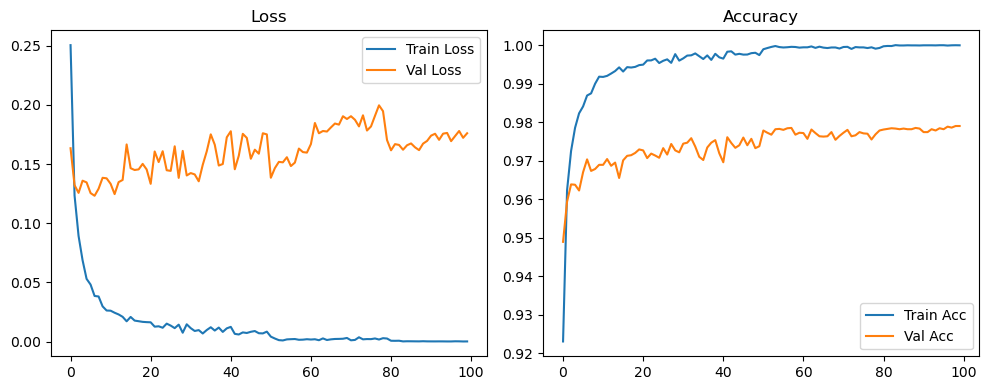

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2959, Acc: 0.9106 | Val Loss: 0.1681, Acc: 0.9497


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1651, Acc: 0.9487 | Val Loss: 0.1379, Acc: 0.9567


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9606 | Val Loss: 0.1381, Acc: 0.9587


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1055, Acc: 0.9666 | Val Loss: 0.1213, Acc: 0.9643


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9713 | Val Loss: 0.1121, Acc: 0.9683


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9749 | Val Loss: 0.1146, Acc: 0.9688


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9773 | Val Loss: 0.1160, Acc: 0.9681


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9784 | Val Loss: 0.1079, Acc: 0.9687


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9808 | Val Loss: 0.1208, Acc: 0.9693


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9820 | Val Loss: 0.1132, Acc: 0.9698


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9838 | Val Loss: 0.1047, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9850 | Val Loss: 0.1168, Acc: 0.9701


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.1206, Acc: 0.9714


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9878 | Val Loss: 0.1292, Acc: 0.9702


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9879 | Val Loss: 0.1283, Acc: 0.9707


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9878 | Val Loss: 0.1238, Acc: 0.9703


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9882 | Val Loss: 0.1217, Acc: 0.9724


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.1253, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.1156, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9901 | Val Loss: 0.1278, Acc: 0.9711


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9894 | Val Loss: 0.1238, Acc: 0.9739


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.1214, Acc: 0.9730


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.1221, Acc: 0.9759


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9907 | Val Loss: 0.1245, Acc: 0.9736


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9908 | Val Loss: 0.1334, Acc: 0.9730


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.1275, Acc: 0.9733


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.1290, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.1319, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.1380, Acc: 0.9745


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.1233, Acc: 0.9753


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.1299, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.1329, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9925 | Val Loss: 0.1323, Acc: 0.9752


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9940 | Val Loss: 0.1537, Acc: 0.9736


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.1473, Acc: 0.9722


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.1493, Acc: 0.9730


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9929 | Val Loss: 0.1437, Acc: 0.9736


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.1597, Acc: 0.9723


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9925 | Val Loss: 0.1341, Acc: 0.9766


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9934 | Val Loss: 0.1408, Acc: 0.9747


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.1452, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9945 | Val Loss: 0.1449, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9936 | Val Loss: 0.1531, Acc: 0.9747


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.1627, Acc: 0.9738


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9939 | Val Loss: 0.1578, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9928 | Val Loss: 0.1386, Acc: 0.9755


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9956 | Val Loss: 0.1518, Acc: 0.9765


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1819, Acc: 0.9753


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9948 | Val Loss: 0.1680, Acc: 0.9740


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.1573, Acc: 0.9737


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1414, Acc: 0.9764


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1511, Acc: 0.9775


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1416, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1422, Acc: 0.9784


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1424, Acc: 0.9770


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1443, Acc: 0.9784


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1536, Acc: 0.9789


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1467, Acc: 0.9779


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1473, Acc: 0.9794


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1613, Acc: 0.9790


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1692, Acc: 0.9764


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1670, Acc: 0.9766


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1674, Acc: 0.9766


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1567, Acc: 0.9766


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1554, Acc: 0.9774


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1636, Acc: 0.9759


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1649, Acc: 0.9768


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.1654, Acc: 0.9768


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.1631, Acc: 0.9765


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1745, Acc: 0.9771


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1683, Acc: 0.9768


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1665, Acc: 0.9771


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1478, Acc: 0.9776


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1628, Acc: 0.9784


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1617, Acc: 0.9790


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1607, Acc: 0.9777


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1626, Acc: 0.9785


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1825, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1612, Acc: 0.9766


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1650, Acc: 0.9778


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1567, Acc: 0.9778


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1612, Acc: 0.9791


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1597, Acc: 0.9793


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1627, Acc: 0.9792


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1630, Acc: 0.9781


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1628, Acc: 0.9787


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1675, Acc: 0.9789


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1602, Acc: 0.9795


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1690, Acc: 0.9783


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1617, Acc: 0.9791


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1692, Acc: 0.9794


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1606, Acc: 0.9797


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1638, Acc: 0.9804


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1601, Acc: 0.9805


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1682, Acc: 0.9791


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1651, Acc: 0.9792


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1635, Acc: 0.9805


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1577, Acc: 0.9799


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1720, Acc: 0.9785


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1713, Acc: 0.9802


Final Test Loss: 0.1397 Accuracy: 0.9826


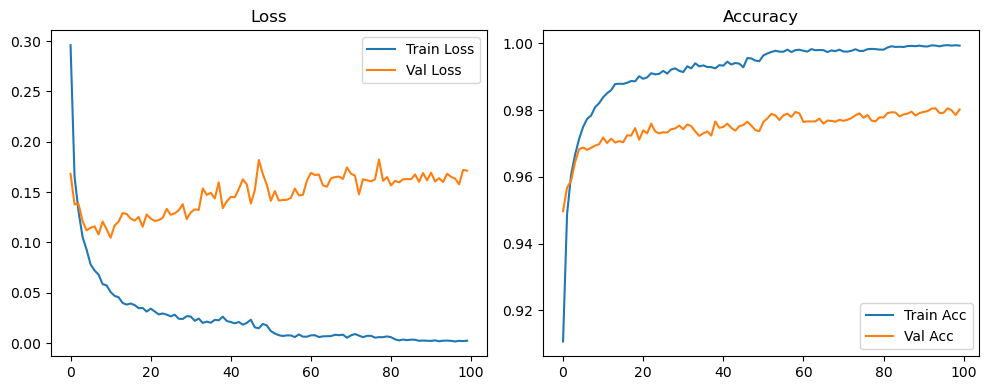

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4547, Acc: 0.8661 | Val Loss: 0.2049, Acc: 0.9367


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2787, Acc: 0.9199 | Val Loss: 0.1657, Acc: 0.9487


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2382, Acc: 0.9320 | Val Loss: 0.1452, Acc: 0.9567


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2108, Acc: 0.9395 | Val Loss: 0.1385, Acc: 0.9599


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1868, Acc: 0.9442 | Val Loss: 0.1289, Acc: 0.9635


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1766, Acc: 0.9483 | Val Loss: 0.1329, Acc: 0.9616


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1646, Acc: 0.9501 | Val Loss: 0.1369, Acc: 0.9641


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1559, Acc: 0.9545 | Val Loss: 0.1146, Acc: 0.9668


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9543 | Val Loss: 0.1190, Acc: 0.9677


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9579 | Val Loss: 0.1178, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1376, Acc: 0.9591 | Val Loss: 0.1161, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1327, Acc: 0.9602 | Val Loss: 0.1094, Acc: 0.9695


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1279, Acc: 0.9622 | Val Loss: 0.1089, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1262, Acc: 0.9625 | Val Loss: 0.1061, Acc: 0.9698


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9654 | Val Loss: 0.1064, Acc: 0.9708


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1174, Acc: 0.9660 | Val Loss: 0.1087, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1124, Acc: 0.9667 | Val Loss: 0.1098, Acc: 0.9706


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1100, Acc: 0.9664 | Val Loss: 0.1029, Acc: 0.9719


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1038, Acc: 0.9692 | Val Loss: 0.1071, Acc: 0.9730


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1096, Acc: 0.9671 | Val Loss: 0.1128, Acc: 0.9716


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1021, Acc: 0.9697 | Val Loss: 0.1101, Acc: 0.9718


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1010, Acc: 0.9700 | Val Loss: 0.1072, Acc: 0.9723


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0997, Acc: 0.9698 | Val Loss: 0.1110, Acc: 0.9726


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9711 | Val Loss: 0.1132, Acc: 0.9712


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0946, Acc: 0.9711 | Val Loss: 0.1152, Acc: 0.9728


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0951, Acc: 0.9711 | Val Loss: 0.1126, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0922, Acc: 0.9724 | Val Loss: 0.1179, Acc: 0.9724


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9731 | Val Loss: 0.1229, Acc: 0.9709


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9734 | Val Loss: 0.1125, Acc: 0.9728


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9741 | Val Loss: 0.1103, Acc: 0.9720


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9740 | Val Loss: 0.1102, Acc: 0.9735


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9750 | Val Loss: 0.1258, Acc: 0.9718


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9745 | Val Loss: 0.1154, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9755 | Val Loss: 0.1261, Acc: 0.9726


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9745 | Val Loss: 0.1245, Acc: 0.9732


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9747 | Val Loss: 0.1177, Acc: 0.9758


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9762 | Val Loss: 0.1173, Acc: 0.9745


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0800, Acc: 0.9753 | Val Loss: 0.1134, Acc: 0.9740


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9771 | Val Loss: 0.1100, Acc: 0.9736


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9787 | Val Loss: 0.1173, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9774 | Val Loss: 0.1226, Acc: 0.9732


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9765 | Val Loss: 0.1248, Acc: 0.9742


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9782 | Val Loss: 0.1195, Acc: 0.9735


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9763 | Val Loss: 0.1161, Acc: 0.9742


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9778 | Val Loss: 0.1192, Acc: 0.9743


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0705, Acc: 0.9786 | Val Loss: 0.1325, Acc: 0.9724


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9788 | Val Loss: 0.1190, Acc: 0.9738


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9796 | Val Loss: 0.1298, Acc: 0.9747


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9791 | Val Loss: 0.1245, Acc: 0.9728


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9809 | Val Loss: 0.1194, Acc: 0.9753


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0575, Acc: 0.9832 | Val Loss: 0.1150, Acc: 0.9759


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9840 | Val Loss: 0.1120, Acc: 0.9752


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9850 | Val Loss: 0.1124, Acc: 0.9758


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9862 | Val Loss: 0.1222, Acc: 0.9760


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9854 | Val Loss: 0.1142, Acc: 0.9768


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9861 | Val Loss: 0.1161, Acc: 0.9756


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9854 | Val Loss: 0.1191, Acc: 0.9747


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9866 | Val Loss: 0.1204, Acc: 0.9762


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9871 | Val Loss: 0.1235, Acc: 0.9754


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9871 | Val Loss: 0.1205, Acc: 0.9762


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.1222, Acc: 0.9762


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9866 | Val Loss: 0.1174, Acc: 0.9755


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9882 | Val Loss: 0.1162, Acc: 0.9755


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 0.1213, Acc: 0.9759


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9883 | Val Loss: 0.1234, Acc: 0.9766


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0430, Acc: 0.9862 | Val Loss: 0.1178, Acc: 0.9766


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9876 | Val Loss: 0.1211, Acc: 0.9775


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9872 | Val Loss: 0.1248, Acc: 0.9754


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9874 | Val Loss: 0.1189, Acc: 0.9762


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9879 | Val Loss: 0.1289, Acc: 0.9768


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9875 | Val Loss: 0.1238, Acc: 0.9764


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9886 | Val Loss: 0.1234, Acc: 0.9770


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9885 | Val Loss: 0.1265, Acc: 0.9753


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9880 | Val Loss: 0.1211, Acc: 0.9757


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9875 | Val Loss: 0.1150, Acc: 0.9760


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9873 | Val Loss: 0.1171, Acc: 0.9776


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9891 | Val Loss: 0.1234, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9892 | Val Loss: 0.1288, Acc: 0.9767


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9885 | Val Loss: 0.1232, Acc: 0.9748


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9873 | Val Loss: 0.1219, Acc: 0.9756


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9896 | Val Loss: 0.1248, Acc: 0.9766


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.1247, Acc: 0.9779


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9902 | Val Loss: 0.1278, Acc: 0.9774


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9912 | Val Loss: 0.1224, Acc: 0.9771


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9905 | Val Loss: 0.1250, Acc: 0.9777


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9919 | Val Loss: 0.1210, Acc: 0.9773


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9922 | Val Loss: 0.1245, Acc: 0.9771


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9924 | Val Loss: 0.1220, Acc: 0.9788


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9926 | Val Loss: 0.1294, Acc: 0.9763


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.1204, Acc: 0.9776


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.1316, Acc: 0.9765


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9922 | Val Loss: 0.1257, Acc: 0.9777


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.1232, Acc: 0.9762


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9917 | Val Loss: 0.1196, Acc: 0.9770


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.1242, Acc: 0.9769


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.1257, Acc: 0.9779


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9920 | Val Loss: 0.1255, Acc: 0.9770


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.1250, Acc: 0.9774


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9928 | Val Loss: 0.1253, Acc: 0.9770


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9920 | Val Loss: 0.1283, Acc: 0.9773


Final Test Loss: 0.1159 Accuracy: 0.9787


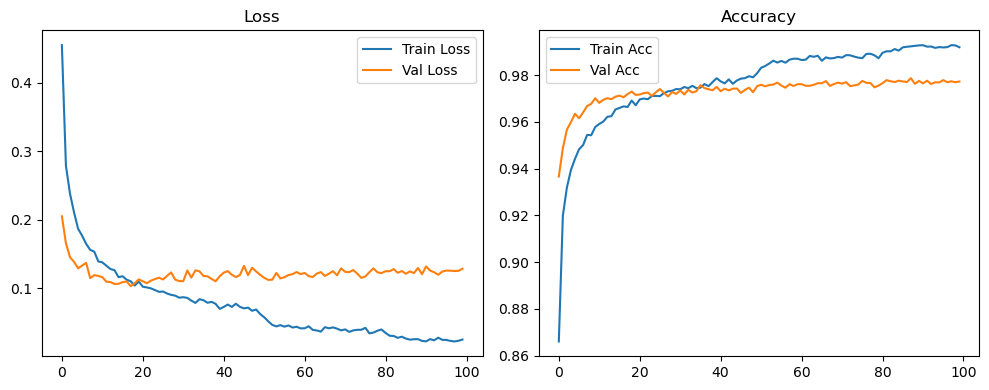

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2506, Acc: 0.9230 | Val Loss: 0.1634, Acc: 0.9489


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9623 | Val Loss: 0.1322, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0893, Acc: 0.9725 | Val Loss: 0.1257, Acc: 0.9638


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9785 | Val Loss: 0.1360, Acc: 0.9637


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9823 | Val Loss: 0.1346, Acc: 0.9623


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9841 | Val Loss: 0.1255, Acc: 0.9670


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9869 | Val Loss: 0.1232, Acc: 0.9703


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9875 | Val Loss: 0.1292, Acc: 0.9673


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.1384, Acc: 0.9678


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9918 | Val Loss: 0.1380, Acc: 0.9689


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.1334, Acc: 0.9689


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.1246, Acc: 0.9704


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.1348, Acc: 0.9687


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.1366, Acc: 0.9695


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1666, Acc: 0.9655


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1465, Acc: 0.9701


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.1450, Acc: 0.9712


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.1455, Acc: 0.9714


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1502, Acc: 0.9720


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1455, Acc: 0.9729


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1333, Acc: 0.9727


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1607, Acc: 0.9707


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1517, Acc: 0.9718


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.1609, Acc: 0.9713


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.1448, Acc: 0.9708


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.1443, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1650, Acc: 0.9716


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1384, Acc: 0.9743


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1612, Acc: 0.9727


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9960 | Val Loss: 0.1404, Acc: 0.9722


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1424, Acc: 0.9744


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1413, Acc: 0.9747


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1355, Acc: 0.9758


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1494, Acc: 0.9737


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1608, Acc: 0.9710


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1751, Acc: 0.9702


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1664, Acc: 0.9734


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1488, Acc: 0.9747


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.1501, Acc: 0.9753


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.1727, Acc: 0.9719


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9965 | Val Loss: 0.1778, Acc: 0.9696


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9983 | Val Loss: 0.1456, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.1571, Acc: 0.9746


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1756, Acc: 0.9733


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1721, Acc: 0.9740


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1545, Acc: 0.9760


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.1622, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1588, Acc: 0.9757


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1761, Acc: 0.9732


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1751, Acc: 0.9738


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1425, Acc: 0.9783


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1454, Acc: 0.9788


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1495, Acc: 0.9786


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1446, Acc: 0.9778


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1460, Acc: 0.9792


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1497, Acc: 0.9792


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1407, Acc: 0.9792


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1464, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1440, Acc: 0.9798


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1485, Acc: 0.9795


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1520, Acc: 0.9787


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1520, Acc: 0.9797


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1505, Acc: 0.9795


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1493, Acc: 0.9806


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1527, Acc: 0.9797


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1554, Acc: 0.9790


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1623, Acc: 0.9783


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1618, Acc: 0.9781


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1627, Acc: 0.9792


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1806, Acc: 0.9779


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1747, Acc: 0.9791


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1770, Acc: 0.9781


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1658, Acc: 0.9796


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1749, Acc: 0.9803


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1713, Acc: 0.9795


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1834, Acc: 0.9782


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1881, Acc: 0.9790


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1953, Acc: 0.9788


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1885, Acc: 0.9792


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1916, Acc: 0.9784


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1791, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1813, Acc: 0.9793


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1925, Acc: 0.9786


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1865, Acc: 0.9792


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1871, Acc: 0.9798


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1878, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1893, Acc: 0.9794


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1902, Acc: 0.9797


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1894, Acc: 0.9789


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1844, Acc: 0.9795


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1878, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1828, Acc: 0.9799


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1939, Acc: 0.9795


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1942, Acc: 0.9801


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1978, Acc: 0.9792


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1912, Acc: 0.9797


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1895, Acc: 0.9805


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1908, Acc: 0.9800


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1889, Acc: 0.9801


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2006, Acc: 0.9787


Final Test Loss: 0.1870 Accuracy: 0.9796


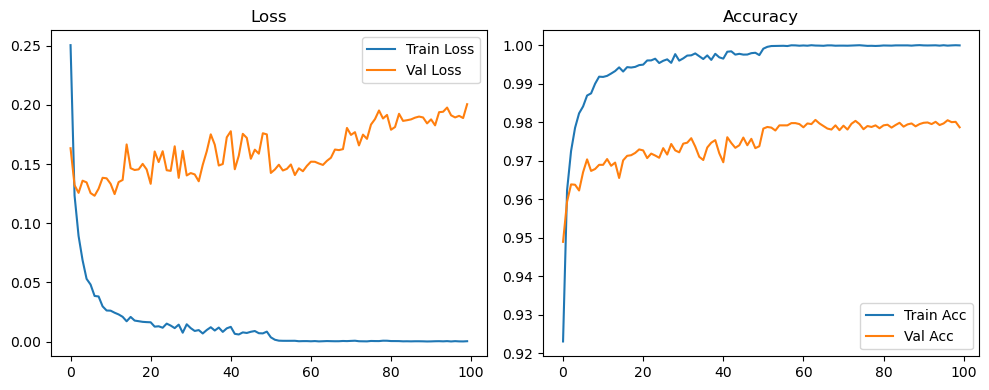

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2959, Acc: 0.9106 | Val Loss: 0.1681, Acc: 0.9497


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1651, Acc: 0.9487 | Val Loss: 0.1379, Acc: 0.9567


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9606 | Val Loss: 0.1381, Acc: 0.9587


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1055, Acc: 0.9666 | Val Loss: 0.1213, Acc: 0.9643


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9713 | Val Loss: 0.1121, Acc: 0.9683


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9749 | Val Loss: 0.1146, Acc: 0.9688


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9773 | Val Loss: 0.1160, Acc: 0.9681


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9784 | Val Loss: 0.1079, Acc: 0.9687


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9808 | Val Loss: 0.1208, Acc: 0.9693


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9820 | Val Loss: 0.1132, Acc: 0.9698


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9838 | Val Loss: 0.1047, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9850 | Val Loss: 0.1168, Acc: 0.9701


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.1206, Acc: 0.9714


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9878 | Val Loss: 0.1292, Acc: 0.9702


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9879 | Val Loss: 0.1283, Acc: 0.9707


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9878 | Val Loss: 0.1238, Acc: 0.9703


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9882 | Val Loss: 0.1217, Acc: 0.9724


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.1253, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.1156, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9901 | Val Loss: 0.1278, Acc: 0.9711


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9894 | Val Loss: 0.1238, Acc: 0.9739


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.1214, Acc: 0.9730


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.1221, Acc: 0.9759


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9907 | Val Loss: 0.1245, Acc: 0.9736


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9908 | Val Loss: 0.1334, Acc: 0.9730


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.1275, Acc: 0.9733


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.1290, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.1319, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.1380, Acc: 0.9745


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.1233, Acc: 0.9753


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.1299, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.1329, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9925 | Val Loss: 0.1323, Acc: 0.9752


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9940 | Val Loss: 0.1537, Acc: 0.9736


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.1473, Acc: 0.9722


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.1493, Acc: 0.9730


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9929 | Val Loss: 0.1437, Acc: 0.9736


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.1597, Acc: 0.9723


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9925 | Val Loss: 0.1341, Acc: 0.9766


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9934 | Val Loss: 0.1408, Acc: 0.9747


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.1452, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9945 | Val Loss: 0.1449, Acc: 0.9759


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9936 | Val Loss: 0.1531, Acc: 0.9747


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.1627, Acc: 0.9738


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9939 | Val Loss: 0.1578, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9928 | Val Loss: 0.1386, Acc: 0.9755


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9956 | Val Loss: 0.1518, Acc: 0.9765


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1819, Acc: 0.9753


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9948 | Val Loss: 0.1680, Acc: 0.9740


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.1573, Acc: 0.9737


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1403, Acc: 0.9780


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1414, Acc: 0.9773


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1357, Acc: 0.9781


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1409, Acc: 0.9784


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1405, Acc: 0.9785


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1419, Acc: 0.9779


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1475, Acc: 0.9780


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1433, Acc: 0.9781


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1436, Acc: 0.9779


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1501, Acc: 0.9788


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1474, Acc: 0.9793


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1545, Acc: 0.9776


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1554, Acc: 0.9790


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1566, Acc: 0.9775


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1557, Acc: 0.9775


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1547, Acc: 0.9789


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1553, Acc: 0.9784


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1549, Acc: 0.9782


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1551, Acc: 0.9791


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1617, Acc: 0.9788


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1596, Acc: 0.9790


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1596, Acc: 0.9782


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1587, Acc: 0.9788


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1627, Acc: 0.9783


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1570, Acc: 0.9782


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1664, Acc: 0.9780


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1612, Acc: 0.9787


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1669, Acc: 0.9787


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1654, Acc: 0.9789


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1589, Acc: 0.9798


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1658, Acc: 0.9791


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1713, Acc: 0.9792


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1619, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1670, Acc: 0.9800


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1661, Acc: 0.9794


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1700, Acc: 0.9794


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1720, Acc: 0.9792


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1650, Acc: 0.9799


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1640, Acc: 0.9796


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1607, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1652, Acc: 0.9799


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1601, Acc: 0.9791


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1595, Acc: 0.9794


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1594, Acc: 0.9796


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1665, Acc: 0.9800


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1634, Acc: 0.9798


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1655, Acc: 0.9798


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1635, Acc: 0.9793


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1669, Acc: 0.9800


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1706, Acc: 0.9790


Final Test Loss: 0.1396 Accuracy: 0.9812


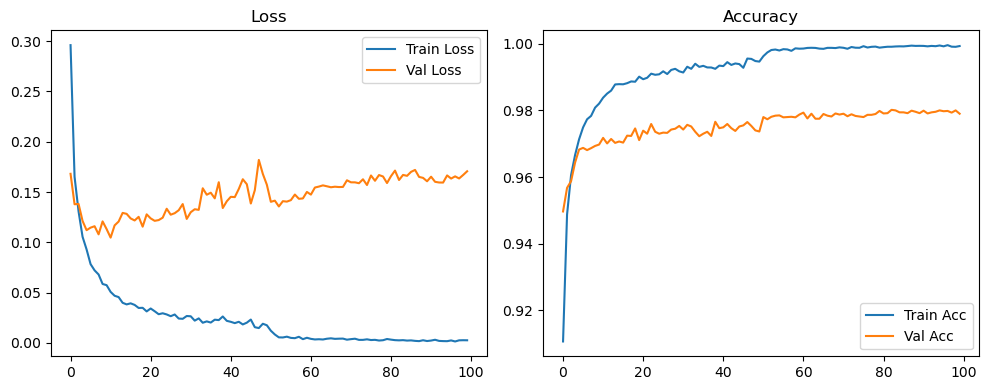

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4547, Acc: 0.8661 | Val Loss: 0.2049, Acc: 0.9367


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2787, Acc: 0.9199 | Val Loss: 0.1657, Acc: 0.9487


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2382, Acc: 0.9320 | Val Loss: 0.1452, Acc: 0.9567


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2108, Acc: 0.9395 | Val Loss: 0.1385, Acc: 0.9599


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1868, Acc: 0.9442 | Val Loss: 0.1289, Acc: 0.9635


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1766, Acc: 0.9483 | Val Loss: 0.1329, Acc: 0.9616


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1646, Acc: 0.9501 | Val Loss: 0.1369, Acc: 0.9641


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1559, Acc: 0.9545 | Val Loss: 0.1146, Acc: 0.9668


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9543 | Val Loss: 0.1190, Acc: 0.9677


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9579 | Val Loss: 0.1178, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1376, Acc: 0.9591 | Val Loss: 0.1161, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1327, Acc: 0.9602 | Val Loss: 0.1094, Acc: 0.9695


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1279, Acc: 0.9622 | Val Loss: 0.1089, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1262, Acc: 0.9625 | Val Loss: 0.1061, Acc: 0.9698


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9654 | Val Loss: 0.1064, Acc: 0.9708


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1174, Acc: 0.9660 | Val Loss: 0.1087, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1124, Acc: 0.9667 | Val Loss: 0.1098, Acc: 0.9706


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1100, Acc: 0.9664 | Val Loss: 0.1029, Acc: 0.9719


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1038, Acc: 0.9692 | Val Loss: 0.1071, Acc: 0.9730


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1096, Acc: 0.9671 | Val Loss: 0.1128, Acc: 0.9716


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1021, Acc: 0.9697 | Val Loss: 0.1101, Acc: 0.9718


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1010, Acc: 0.9700 | Val Loss: 0.1072, Acc: 0.9723


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0997, Acc: 0.9698 | Val Loss: 0.1110, Acc: 0.9726


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9711 | Val Loss: 0.1132, Acc: 0.9712


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0946, Acc: 0.9711 | Val Loss: 0.1152, Acc: 0.9728


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0951, Acc: 0.9711 | Val Loss: 0.1126, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0922, Acc: 0.9724 | Val Loss: 0.1179, Acc: 0.9724


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9731 | Val Loss: 0.1229, Acc: 0.9709


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9734 | Val Loss: 0.1125, Acc: 0.9728


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9741 | Val Loss: 0.1103, Acc: 0.9720


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9740 | Val Loss: 0.1102, Acc: 0.9735


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9750 | Val Loss: 0.1258, Acc: 0.9718


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9745 | Val Loss: 0.1154, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9755 | Val Loss: 0.1261, Acc: 0.9726


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9745 | Val Loss: 0.1245, Acc: 0.9732


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9747 | Val Loss: 0.1177, Acc: 0.9758


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9762 | Val Loss: 0.1173, Acc: 0.9745


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0800, Acc: 0.9753 | Val Loss: 0.1134, Acc: 0.9740


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9771 | Val Loss: 0.1100, Acc: 0.9736


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9787 | Val Loss: 0.1173, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9774 | Val Loss: 0.1226, Acc: 0.9732


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9765 | Val Loss: 0.1248, Acc: 0.9742


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9782 | Val Loss: 0.1195, Acc: 0.9735


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9763 | Val Loss: 0.1161, Acc: 0.9742


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9778 | Val Loss: 0.1192, Acc: 0.9743


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0705, Acc: 0.9786 | Val Loss: 0.1325, Acc: 0.9724


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9788 | Val Loss: 0.1190, Acc: 0.9738


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9796 | Val Loss: 0.1298, Acc: 0.9747


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9791 | Val Loss: 0.1245, Acc: 0.9728


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9809 | Val Loss: 0.1194, Acc: 0.9753


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0557, Acc: 0.9832 | Val Loss: 0.1134, Acc: 0.9771


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9848 | Val Loss: 0.1134, Acc: 0.9761


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0455, Acc: 0.9855 | Val Loss: 0.1128, Acc: 0.9758


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9875 | Val Loss: 0.1163, Acc: 0.9756


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9874 | Val Loss: 0.1124, Acc: 0.9767


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9883 | Val Loss: 0.1112, Acc: 0.9776


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9869 | Val Loss: 0.1135, Acc: 0.9759


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9885 | Val Loss: 0.1121, Acc: 0.9762


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9880 | Val Loss: 0.1136, Acc: 0.9772


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9885 | Val Loss: 0.1124, Acc: 0.9772


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9888 | Val Loss: 0.1158, Acc: 0.9780


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9886 | Val Loss: 0.1149, Acc: 0.9767


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9890 | Val Loss: 0.1110, Acc: 0.9773


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.1144, Acc: 0.9777


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9906 | Val Loss: 0.1205, Acc: 0.9772


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9898 | Val Loss: 0.1192, Acc: 0.9775


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9899 | Val Loss: 0.1173, Acc: 0.9775


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9896 | Val Loss: 0.1196, Acc: 0.9760


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.1201, Acc: 0.9766


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9908 | Val Loss: 0.1208, Acc: 0.9786


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9905 | Val Loss: 0.1237, Acc: 0.9764


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9905 | Val Loss: 0.1216, Acc: 0.9772


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9906 | Val Loss: 0.1231, Acc: 0.9771


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9903 | Val Loss: 0.1175, Acc: 0.9772


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9901 | Val Loss: 0.1138, Acc: 0.9769


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9900 | Val Loss: 0.1236, Acc: 0.9755


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9917 | Val Loss: 0.1141, Acc: 0.9775


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.1234, Acc: 0.9772


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9910 | Val Loss: 0.1211, Acc: 0.9773


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9900 | Val Loss: 0.1158, Acc: 0.9768


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9910 | Val Loss: 0.1167, Acc: 0.9768


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9914 | Val Loss: 0.1155, Acc: 0.9778


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9909 | Val Loss: 0.1189, Acc: 0.9777


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9920 | Val Loss: 0.1174, Acc: 0.9782


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.1201, Acc: 0.9768


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.1185, Acc: 0.9772


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9922 | Val Loss: 0.1219, Acc: 0.9772


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9924 | Val Loss: 0.1208, Acc: 0.9781


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9922 | Val Loss: 0.1192, Acc: 0.9763


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9924 | Val Loss: 0.1153, Acc: 0.9773


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.1194, Acc: 0.9768


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9926 | Val Loss: 0.1198, Acc: 0.9767


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9916 | Val Loss: 0.1216, Acc: 0.9768


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.1172, Acc: 0.9774


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.1183, Acc: 0.9771


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9923 | Val Loss: 0.1225, Acc: 0.9778


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.1192, Acc: 0.9778


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.1162, Acc: 0.9783


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.1218, Acc: 0.9774


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.1216, Acc: 0.9774


Final Test Loss: 0.1160 Accuracy: 0.9781


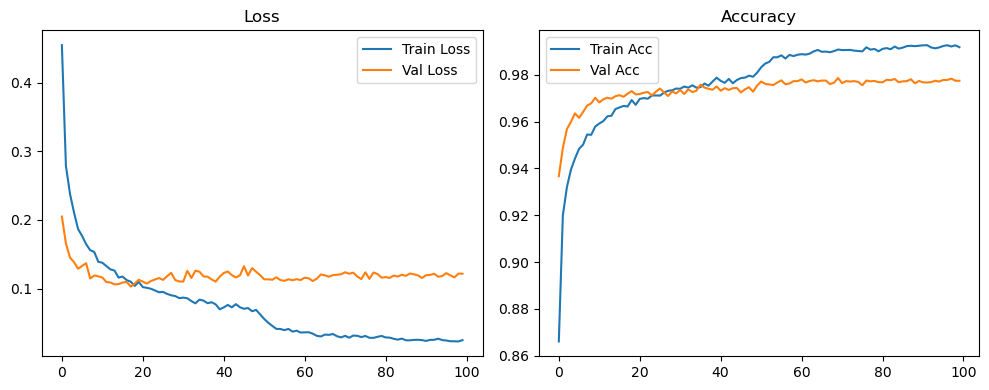

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2455, Acc: 0.9255 | Val Loss: 0.1628, Acc: 0.9510


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1169, Acc: 0.9636 | Val Loss: 0.1288, Acc: 0.9605


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0800, Acc: 0.9749 | Val Loss: 0.1390, Acc: 0.9601


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9786 | Val Loss: 0.1267, Acc: 0.9637


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9831 | Val Loss: 0.1192, Acc: 0.9663


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9855 | Val Loss: 0.1247, Acc: 0.9683


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9878 | Val Loss: 0.1173, Acc: 0.9684


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9882 | Val Loss: 0.1224, Acc: 0.9679


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9892 | Val Loss: 0.1203, Acc: 0.9683


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.1350, Acc: 0.9673


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.1353, Acc: 0.9704


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.1398, Acc: 0.9673


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9925 | Val Loss: 0.1369, Acc: 0.9695


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.1297, Acc: 0.9692


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1244, Acc: 0.9715


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.1294, Acc: 0.9711


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.1370, Acc: 0.9694


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.1465, Acc: 0.9698


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1268, Acc: 0.9732


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.1282, Acc: 0.9740


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1323, Acc: 0.9723


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1407, Acc: 0.9742


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1269, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1463, Acc: 0.9703


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1293, Acc: 0.9732


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1335, Acc: 0.9742


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1414, Acc: 0.9728


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1412, Acc: 0.9737


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1354, Acc: 0.9737


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1497, Acc: 0.9705


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.1353, Acc: 0.9742


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1368, Acc: 0.9740


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1483, Acc: 0.9734


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1425, Acc: 0.9738


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1402, Acc: 0.9749


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1563, Acc: 0.9718


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1427, Acc: 0.9722


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1328, Acc: 0.9749


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1478, Acc: 0.9741


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1363, Acc: 0.9738


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1370, Acc: 0.9735


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1505, Acc: 0.9746


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1515, Acc: 0.9746


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1478, Acc: 0.9747


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1507, Acc: 0.9742


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1419, Acc: 0.9743


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1427, Acc: 0.9754


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1387, Acc: 0.9771


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1518, Acc: 0.9746


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1825, Acc: 0.9708


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1604, Acc: 0.9734


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1607, Acc: 0.9728


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1613, Acc: 0.9733


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1518, Acc: 0.9743


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1622, Acc: 0.9739


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1740, Acc: 0.9728


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1414, Acc: 0.9744


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1548, Acc: 0.9740


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1514, Acc: 0.9745


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1545, Acc: 0.9758


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9990 | Val Loss: 0.1512, Acc: 0.9765


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1600, Acc: 0.9758


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1563, Acc: 0.9745


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1646, Acc: 0.9748


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1641, Acc: 0.9752


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1640, Acc: 0.9735


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1547, Acc: 0.9756


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1602, Acc: 0.9752


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1677, Acc: 0.9753


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1774, Acc: 0.9725


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1725, Acc: 0.9758


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1787, Acc: 0.9747


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1668, Acc: 0.9747


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1796, Acc: 0.9763


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1793, Acc: 0.9754


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1781, Acc: 0.9758


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1552, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1695, Acc: 0.9748


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1589, Acc: 0.9760


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1570, Acc: 0.9755


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1510, Acc: 0.9764


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1520, Acc: 0.9785


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1638, Acc: 0.9760


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1649, Acc: 0.9766


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1606, Acc: 0.9784


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1692, Acc: 0.9767


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.1725, Acc: 0.9770


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1684, Acc: 0.9771


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1807, Acc: 0.9744


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1710, Acc: 0.9757


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1905, Acc: 0.9767


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1806, Acc: 0.9756


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9987 | Val Loss: 0.1705, Acc: 0.9759


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1807, Acc: 0.9752


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1669, Acc: 0.9774


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1801, Acc: 0.9768


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1768, Acc: 0.9766


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.2071, Acc: 0.9730


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1936, Acc: 0.9743


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1609, Acc: 0.9768


Final Test Loss: 0.1569 Accuracy: 0.9767


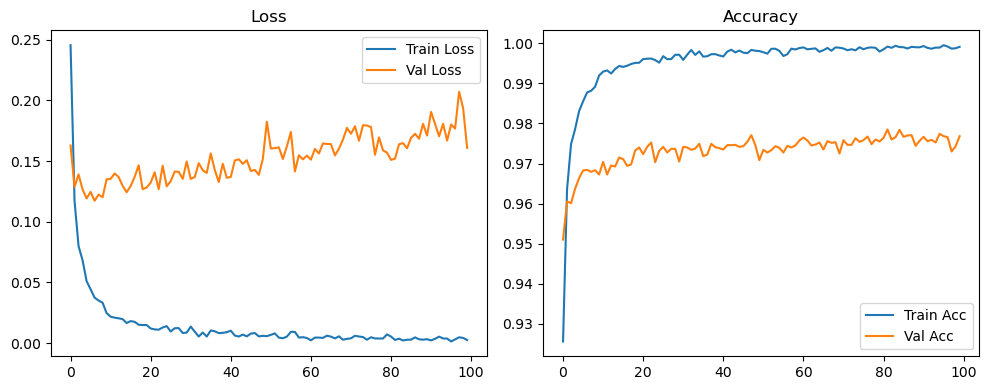

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2970, Acc: 0.9115 | Val Loss: 0.1681, Acc: 0.9486


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1554, Acc: 0.9525 | Val Loss: 0.1304, Acc: 0.9606


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1269, Acc: 0.9611 | Val Loss: 0.1328, Acc: 0.9602


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1029, Acc: 0.9686 | Val Loss: 0.1049, Acc: 0.9689


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0888, Acc: 0.9718 | Val Loss: 0.1103, Acc: 0.9675


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9755 | Val Loss: 0.1116, Acc: 0.9677


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9772 | Val Loss: 0.1171, Acc: 0.9667


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0679, Acc: 0.9777 | Val Loss: 0.1042, Acc: 0.9683


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9813 | Val Loss: 0.1183, Acc: 0.9680


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9827 | Val Loss: 0.1085, Acc: 0.9722


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9832 | Val Loss: 0.1073, Acc: 0.9713


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9850 | Val Loss: 0.1079, Acc: 0.9717


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9855 | Val Loss: 0.1142, Acc: 0.9697


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9870 | Val Loss: 0.1189, Acc: 0.9710


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9871 | Val Loss: 0.1140, Acc: 0.9733


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9872 | Val Loss: 0.1093, Acc: 0.9725


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9891 | Val Loss: 0.1099, Acc: 0.9735


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9891 | Val Loss: 0.1114, Acc: 0.9732


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9895 | Val Loss: 0.1120, Acc: 0.9724


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9908 | Val Loss: 0.1198, Acc: 0.9725


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9891 | Val Loss: 0.1165, Acc: 0.9718


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9899 | Val Loss: 0.1135, Acc: 0.9718


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9915 | Val Loss: 0.1080, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9906 | Val Loss: 0.1247, Acc: 0.9721


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.1237, Acc: 0.9734


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.1209, Acc: 0.9732


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.1212, Acc: 0.9754


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.1163, Acc: 0.9752


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9925 | Val Loss: 0.1307, Acc: 0.9737


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.1161, Acc: 0.9749


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9928 | Val Loss: 0.1213, Acc: 0.9745


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.1287, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1247, Acc: 0.9731


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.1307, Acc: 0.9736


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.1248, Acc: 0.9753


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.1331, Acc: 0.9743


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1295, Acc: 0.9745


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.1253, Acc: 0.9743


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1324, Acc: 0.9744


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.1276, Acc: 0.9743


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.1364, Acc: 0.9738


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.1236, Acc: 0.9752


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1334, Acc: 0.9744


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9944 | Val Loss: 0.1245, Acc: 0.9762


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.1221, Acc: 0.9762


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.1261, Acc: 0.9761


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1381, Acc: 0.9749


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1433, Acc: 0.9756


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.1390, Acc: 0.9738


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1309, Acc: 0.9763


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1425, Acc: 0.9754


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.1338, Acc: 0.9765


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1352, Acc: 0.9758


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9955 | Val Loss: 0.1389, Acc: 0.9748


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 0.1288, Acc: 0.9757


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1316, Acc: 0.9747


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.1420, Acc: 0.9752


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9948 | Val Loss: 0.1341, Acc: 0.9750


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.1470, Acc: 0.9752


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.1367, Acc: 0.9742


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1361, Acc: 0.9758


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9953 | Val Loss: 0.1401, Acc: 0.9748


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1360, Acc: 0.9752


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1505, Acc: 0.9740


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.1444, Acc: 0.9767


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.1394, Acc: 0.9768


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.1336, Acc: 0.9750


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1300, Acc: 0.9772


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1316, Acc: 0.9775


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1307, Acc: 0.9782


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9961 | Val Loss: 0.1371, Acc: 0.9765


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1431, Acc: 0.9752


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.1287, Acc: 0.9763


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.1340, Acc: 0.9761


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1419, Acc: 0.9763


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1358, Acc: 0.9775


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.1396, Acc: 0.9756


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1456, Acc: 0.9752


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.1458, Acc: 0.9757


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.1371, Acc: 0.9768


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1428, Acc: 0.9770


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1449, Acc: 0.9778


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1552, Acc: 0.9762


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.1468, Acc: 0.9744


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9963 | Val Loss: 0.1556, Acc: 0.9741


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1584, Acc: 0.9762


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1446, Acc: 0.9772


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1488, Acc: 0.9757


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1515, Acc: 0.9767


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1474, Acc: 0.9769


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1580, Acc: 0.9752


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1661, Acc: 0.9767


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1525, Acc: 0.9770


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1491, Acc: 0.9772


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1542, Acc: 0.9771


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9970 | Val Loss: 0.1543, Acc: 0.9758


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.1475, Acc: 0.9754


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1549, Acc: 0.9760


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.1471, Acc: 0.9760


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9970 | Val Loss: 0.1423, Acc: 0.9769


Final Test Loss: 0.1255 Accuracy: 0.9796


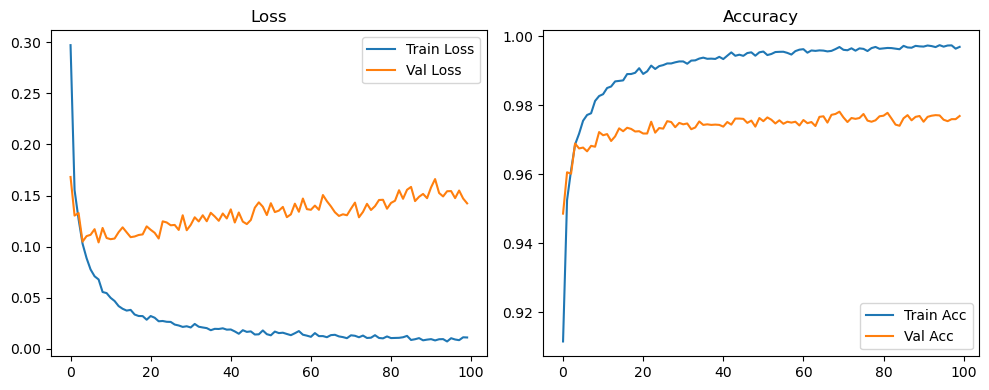

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4603, Acc: 0.8629 | Val Loss: 0.1932, Acc: 0.9431


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2753, Acc: 0.9204 | Val Loss: 0.1721, Acc: 0.9468


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2324, Acc: 0.9321 | Val Loss: 0.1411, Acc: 0.9586


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2029, Acc: 0.9400 | Val Loss: 0.1364, Acc: 0.9594


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1827, Acc: 0.9465 | Val Loss: 0.1297, Acc: 0.9623


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1722, Acc: 0.9495 | Val Loss: 0.1235, Acc: 0.9623


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1571, Acc: 0.9522 | Val Loss: 0.1275, Acc: 0.9643


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1540, Acc: 0.9538 | Val Loss: 0.1142, Acc: 0.9665


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1466, Acc: 0.9553 | Val Loss: 0.1165, Acc: 0.9675


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1392, Acc: 0.9589 | Val Loss: 0.1180, Acc: 0.9663


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1334, Acc: 0.9596 | Val Loss: 0.1149, Acc: 0.9677


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1255, Acc: 0.9619 | Val Loss: 0.1148, Acc: 0.9673


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1254, Acc: 0.9625 | Val Loss: 0.1115, Acc: 0.9678


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1167, Acc: 0.9633 | Val Loss: 0.1155, Acc: 0.9676


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1159, Acc: 0.9644 | Val Loss: 0.1105, Acc: 0.9692


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1114, Acc: 0.9664 | Val Loss: 0.1151, Acc: 0.9692


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1058, Acc: 0.9670 | Val Loss: 0.1055, Acc: 0.9702


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1076, Acc: 0.9659 | Val Loss: 0.1065, Acc: 0.9713


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0988, Acc: 0.9702 | Val Loss: 0.1111, Acc: 0.9713


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0949, Acc: 0.9708 | Val Loss: 0.1061, Acc: 0.9729


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0967, Acc: 0.9700 | Val Loss: 0.1072, Acc: 0.9722


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0972, Acc: 0.9706 | Val Loss: 0.1052, Acc: 0.9720


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0951, Acc: 0.9700 | Val Loss: 0.1092, Acc: 0.9709


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0905, Acc: 0.9715 | Val Loss: 0.1133, Acc: 0.9702


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0910, Acc: 0.9718 | Val Loss: 0.1123, Acc: 0.9710


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0888, Acc: 0.9727 | Val Loss: 0.1096, Acc: 0.9722


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0900, Acc: 0.9721 | Val Loss: 0.1163, Acc: 0.9702


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0853, Acc: 0.9741 | Val Loss: 0.1125, Acc: 0.9725


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0800, Acc: 0.9751 | Val Loss: 0.1100, Acc: 0.9718


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0778, Acc: 0.9759 | Val Loss: 0.1092, Acc: 0.9712


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0806, Acc: 0.9751 | Val Loss: 0.1126, Acc: 0.9698


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0751, Acc: 0.9772 | Val Loss: 0.1092, Acc: 0.9740


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0770, Acc: 0.9764 | Val Loss: 0.1008, Acc: 0.9732


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0750, Acc: 0.9769 | Val Loss: 0.1024, Acc: 0.9732


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9782 | Val Loss: 0.1101, Acc: 0.9742


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9776 | Val Loss: 0.1104, Acc: 0.9739


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0720, Acc: 0.9773 | Val Loss: 0.1110, Acc: 0.9722


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0723, Acc: 0.9775 | Val Loss: 0.1126, Acc: 0.9718


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9774 | Val Loss: 0.1110, Acc: 0.9721


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9781 | Val Loss: 0.1088, Acc: 0.9732


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9790 | Val Loss: 0.1137, Acc: 0.9739


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0701, Acc: 0.9784 | Val Loss: 0.1091, Acc: 0.9731


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9777 | Val Loss: 0.1092, Acc: 0.9721


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9786 | Val Loss: 0.1097, Acc: 0.9735


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0649, Acc: 0.9794 | Val Loss: 0.1123, Acc: 0.9738


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9790 | Val Loss: 0.1178, Acc: 0.9738


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0676, Acc: 0.9788 | Val Loss: 0.1090, Acc: 0.9732


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9801 | Val Loss: 0.1142, Acc: 0.9727


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0637, Acc: 0.9800 | Val Loss: 0.1066, Acc: 0.9733


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0579, Acc: 0.9818 | Val Loss: 0.1078, Acc: 0.9741


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9800 | Val Loss: 0.1086, Acc: 0.9723


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0611, Acc: 0.9808 | Val Loss: 0.1096, Acc: 0.9730


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0599, Acc: 0.9809 | Val Loss: 0.1125, Acc: 0.9730


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9822 | Val Loss: 0.1153, Acc: 0.9738


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9831 | Val Loss: 0.1171, Acc: 0.9738


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0580, Acc: 0.9821 | Val Loss: 0.1117, Acc: 0.9737


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9827 | Val Loss: 0.1166, Acc: 0.9737


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0580, Acc: 0.9817 | Val Loss: 0.1101, Acc: 0.9745


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9824 | Val Loss: 0.1188, Acc: 0.9747


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9827 | Val Loss: 0.1204, Acc: 0.9734


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9825 | Val Loss: 0.1174, Acc: 0.9722


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9829 | Val Loss: 0.1249, Acc: 0.9736


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9826 | Val Loss: 0.1155, Acc: 0.9742


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9833 | Val Loss: 0.1197, Acc: 0.9734


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9825 | Val Loss: 0.1185, Acc: 0.9729


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9814 | Val Loss: 0.1171, Acc: 0.9742


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9831 | Val Loss: 0.1199, Acc: 0.9737


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9840 | Val Loss: 0.1144, Acc: 0.9732


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9838 | Val Loss: 0.1149, Acc: 0.9739


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9844 | Val Loss: 0.1184, Acc: 0.9731


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9835 | Val Loss: 0.1224, Acc: 0.9727


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9852 | Val Loss: 0.1184, Acc: 0.9745


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0508, Acc: 0.9837 | Val Loss: 0.1175, Acc: 0.9738


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9846 | Val Loss: 0.1161, Acc: 0.9739


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9848 | Val Loss: 0.1177, Acc: 0.9742


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9848 | Val Loss: 0.1219, Acc: 0.9737


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9843 | Val Loss: 0.1201, Acc: 0.9728


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9852 | Val Loss: 0.1244, Acc: 0.9751


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9855 | Val Loss: 0.1252, Acc: 0.9742


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9848 | Val Loss: 0.1121, Acc: 0.9748


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9841 | Val Loss: 0.1264, Acc: 0.9744


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9856 | Val Loss: 0.1259, Acc: 0.9738


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9856 | Val Loss: 0.1241, Acc: 0.9740


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9848 | Val Loss: 0.1199, Acc: 0.9745


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9854 | Val Loss: 0.1227, Acc: 0.9736


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9864 | Val Loss: 0.1254, Acc: 0.9738


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9851 | Val Loss: 0.1228, Acc: 0.9735


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9864 | Val Loss: 0.1233, Acc: 0.9741


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9867 | Val Loss: 0.1202, Acc: 0.9738


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9871 | Val Loss: 0.1258, Acc: 0.9755


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9856 | Val Loss: 0.1229, Acc: 0.9734


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9866 | Val Loss: 0.1224, Acc: 0.9733


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9870 | Val Loss: 0.1310, Acc: 0.9732


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9856 | Val Loss: 0.1202, Acc: 0.9731


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9867 | Val Loss: 0.1263, Acc: 0.9736


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9873 | Val Loss: 0.1349, Acc: 0.9733


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9860 | Val Loss: 0.1213, Acc: 0.9744


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9865 | Val Loss: 0.1204, Acc: 0.9744


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9858 | Val Loss: 0.1168, Acc: 0.9753


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9869 | Val Loss: 0.1340, Acc: 0.9734


Final Test Loss: 0.1186 Accuracy: 0.9765


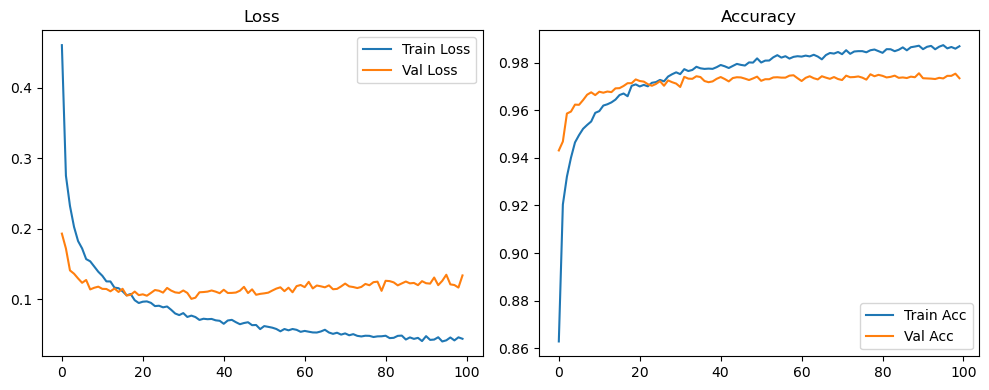

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2455, Acc: 0.9255 | Val Loss: 0.1628, Acc: 0.9510


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1169, Acc: 0.9636 | Val Loss: 0.1288, Acc: 0.9605


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0800, Acc: 0.9749 | Val Loss: 0.1390, Acc: 0.9601


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9786 | Val Loss: 0.1267, Acc: 0.9637


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9831 | Val Loss: 0.1192, Acc: 0.9663


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9855 | Val Loss: 0.1247, Acc: 0.9683


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9878 | Val Loss: 0.1173, Acc: 0.9684


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9882 | Val Loss: 0.1224, Acc: 0.9679


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9892 | Val Loss: 0.1203, Acc: 0.9683


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.1350, Acc: 0.9673


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.1353, Acc: 0.9704


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.1398, Acc: 0.9673


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9925 | Val Loss: 0.1369, Acc: 0.9695


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.1297, Acc: 0.9692


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1244, Acc: 0.9715


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.1294, Acc: 0.9711


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.1370, Acc: 0.9694


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.1465, Acc: 0.9698


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1268, Acc: 0.9732


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.1282, Acc: 0.9740


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1323, Acc: 0.9723


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1407, Acc: 0.9742


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1269, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1463, Acc: 0.9703


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1293, Acc: 0.9732


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1335, Acc: 0.9742


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1414, Acc: 0.9728


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1412, Acc: 0.9737


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1354, Acc: 0.9737


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1497, Acc: 0.9705


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.1353, Acc: 0.9742


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1368, Acc: 0.9740


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1483, Acc: 0.9734


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1425, Acc: 0.9738


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1402, Acc: 0.9749


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1563, Acc: 0.9718


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1427, Acc: 0.9722


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1328, Acc: 0.9749


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1478, Acc: 0.9741


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1363, Acc: 0.9738


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1370, Acc: 0.9735


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1505, Acc: 0.9746


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1515, Acc: 0.9746


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1478, Acc: 0.9747


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1507, Acc: 0.9742


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1419, Acc: 0.9743


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1427, Acc: 0.9754


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1387, Acc: 0.9771


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1518, Acc: 0.9746


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1825, Acc: 0.9708


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1398, Acc: 0.9764


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1383, Acc: 0.9771


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1344, Acc: 0.9773


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1330, Acc: 0.9773


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1332, Acc: 0.9772


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1366, Acc: 0.9772


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1395, Acc: 0.9783


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1464, Acc: 0.9778


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1435, Acc: 0.9782


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1446, Acc: 0.9784


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1495, Acc: 0.9764


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1590, Acc: 0.9763


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1540, Acc: 0.9762


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1672, Acc: 0.9754


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1654, Acc: 0.9773


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1573, Acc: 0.9777


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.1541, Acc: 0.9758


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1629, Acc: 0.9768


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1633, Acc: 0.9753


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1484, Acc: 0.9780


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1632, Acc: 0.9763


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1592, Acc: 0.9764


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1621, Acc: 0.9771


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1580, Acc: 0.9768


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1566, Acc: 0.9774


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1607, Acc: 0.9777


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1732, Acc: 0.9762


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1574, Acc: 0.9779


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1723, Acc: 0.9778


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1722, Acc: 0.9782


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1685, Acc: 0.9768


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1646, Acc: 0.9775


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1682, Acc: 0.9782


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1663, Acc: 0.9783


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1642, Acc: 0.9787


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1642, Acc: 0.9782


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1652, Acc: 0.9785


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1725, Acc: 0.9775


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1687, Acc: 0.9781


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1722, Acc: 0.9772


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1752, Acc: 0.9779


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1714, Acc: 0.9790


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1732, Acc: 0.9784


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1810, Acc: 0.9776


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1785, Acc: 0.9776


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1838, Acc: 0.9760


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1877, Acc: 0.9766


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1861, Acc: 0.9771


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1754, Acc: 0.9777


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1830, Acc: 0.9768


Final Test Loss: 0.1658 Accuracy: 0.9785


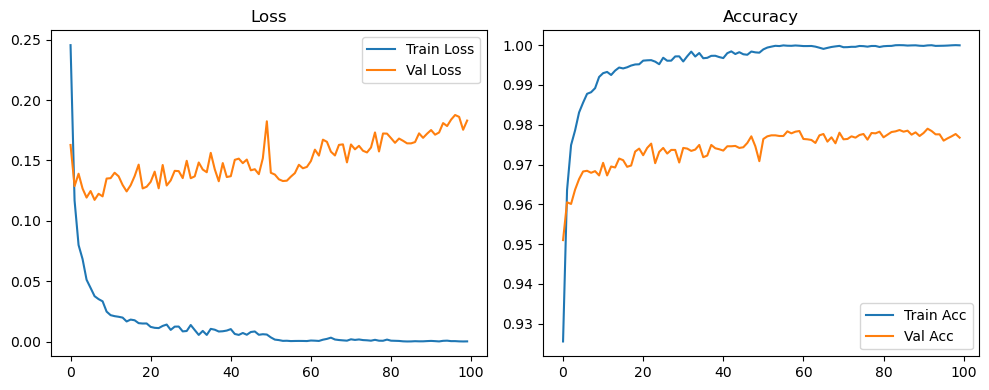

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2970, Acc: 0.9115 | Val Loss: 0.1681, Acc: 0.9486


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1554, Acc: 0.9525 | Val Loss: 0.1304, Acc: 0.9606


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1269, Acc: 0.9611 | Val Loss: 0.1328, Acc: 0.9602


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1029, Acc: 0.9686 | Val Loss: 0.1049, Acc: 0.9689


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0888, Acc: 0.9718 | Val Loss: 0.1103, Acc: 0.9675


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9755 | Val Loss: 0.1116, Acc: 0.9677


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9772 | Val Loss: 0.1171, Acc: 0.9667


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0679, Acc: 0.9777 | Val Loss: 0.1042, Acc: 0.9683


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9813 | Val Loss: 0.1183, Acc: 0.9680


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9827 | Val Loss: 0.1085, Acc: 0.9722


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9832 | Val Loss: 0.1073, Acc: 0.9713


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9850 | Val Loss: 0.1079, Acc: 0.9717


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9855 | Val Loss: 0.1142, Acc: 0.9697


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9870 | Val Loss: 0.1189, Acc: 0.9710


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9871 | Val Loss: 0.1140, Acc: 0.9733


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9872 | Val Loss: 0.1093, Acc: 0.9725


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9891 | Val Loss: 0.1099, Acc: 0.9735


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9891 | Val Loss: 0.1114, Acc: 0.9732


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9895 | Val Loss: 0.1120, Acc: 0.9724


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9908 | Val Loss: 0.1198, Acc: 0.9725


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9891 | Val Loss: 0.1165, Acc: 0.9718


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9899 | Val Loss: 0.1135, Acc: 0.9718


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9915 | Val Loss: 0.1080, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9906 | Val Loss: 0.1247, Acc: 0.9721


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.1237, Acc: 0.9734


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.1209, Acc: 0.9732


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.1212, Acc: 0.9754


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.1163, Acc: 0.9752


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9925 | Val Loss: 0.1307, Acc: 0.9737


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.1161, Acc: 0.9749


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9928 | Val Loss: 0.1213, Acc: 0.9745


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.1287, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1247, Acc: 0.9731


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.1307, Acc: 0.9736


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.1248, Acc: 0.9753


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.1331, Acc: 0.9743


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1295, Acc: 0.9745


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.1253, Acc: 0.9743


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1324, Acc: 0.9744


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.1276, Acc: 0.9743


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.1364, Acc: 0.9738


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.1236, Acc: 0.9752


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1334, Acc: 0.9744


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9944 | Val Loss: 0.1245, Acc: 0.9762


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.1221, Acc: 0.9762


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.1261, Acc: 0.9761


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1381, Acc: 0.9749


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1433, Acc: 0.9756


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.1390, Acc: 0.9738


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1309, Acc: 0.9763


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1229, Acc: 0.9772


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.1264, Acc: 0.9773


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1228, Acc: 0.9784


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1267, Acc: 0.9777


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1252, Acc: 0.9773


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1294, Acc: 0.9775


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1284, Acc: 0.9782


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1331, Acc: 0.9779


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1328, Acc: 0.9771


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1376, Acc: 0.9766


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1353, Acc: 0.9780


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1454, Acc: 0.9773


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1303, Acc: 0.9778


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1344, Acc: 0.9765


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1376, Acc: 0.9774


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1345, Acc: 0.9774


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1365, Acc: 0.9778


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1425, Acc: 0.9775


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1398, Acc: 0.9773


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1489, Acc: 0.9779


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1437, Acc: 0.9772


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1523, Acc: 0.9759


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1385, Acc: 0.9774


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1517, Acc: 0.9773


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1465, Acc: 0.9769


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1452, Acc: 0.9759


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1386, Acc: 0.9775


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1462, Acc: 0.9767


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1450, Acc: 0.9782


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1505, Acc: 0.9760


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1471, Acc: 0.9779


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1524, Acc: 0.9759


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1505, Acc: 0.9772


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1445, Acc: 0.9775


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1489, Acc: 0.9775


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1444, Acc: 0.9783


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.1461, Acc: 0.9778


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1380, Acc: 0.9791


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1469, Acc: 0.9788


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1413, Acc: 0.9777


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.1528, Acc: 0.9775


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1487, Acc: 0.9785


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1466, Acc: 0.9786


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1439, Acc: 0.9790


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1502, Acc: 0.9775


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1448, Acc: 0.9782


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1460, Acc: 0.9785


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1443, Acc: 0.9784


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1435, Acc: 0.9782


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1423, Acc: 0.9792


Final Test Loss: 0.1229 Accuracy: 0.9823


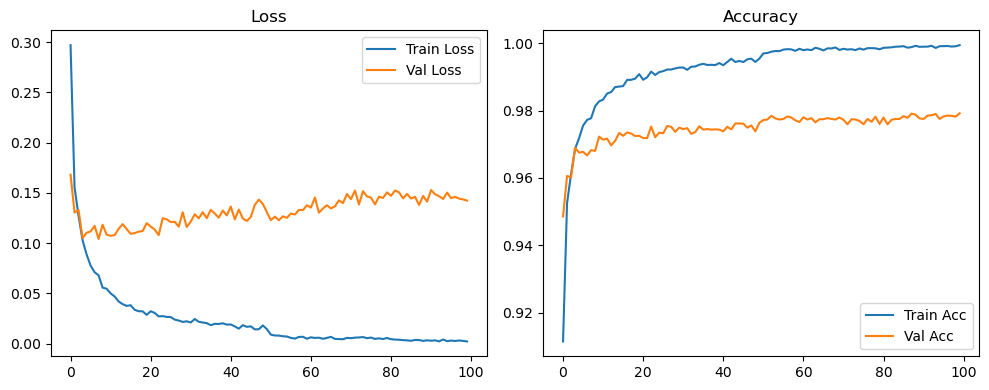

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4603, Acc: 0.8629 | Val Loss: 0.1932, Acc: 0.9431


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2753, Acc: 0.9204 | Val Loss: 0.1721, Acc: 0.9468


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2324, Acc: 0.9321 | Val Loss: 0.1411, Acc: 0.9586


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2029, Acc: 0.9400 | Val Loss: 0.1364, Acc: 0.9594


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1827, Acc: 0.9465 | Val Loss: 0.1297, Acc: 0.9623


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1722, Acc: 0.9495 | Val Loss: 0.1235, Acc: 0.9623


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1571, Acc: 0.9522 | Val Loss: 0.1275, Acc: 0.9643


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1540, Acc: 0.9538 | Val Loss: 0.1142, Acc: 0.9665


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1466, Acc: 0.9553 | Val Loss: 0.1165, Acc: 0.9675


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1392, Acc: 0.9589 | Val Loss: 0.1180, Acc: 0.9663


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1334, Acc: 0.9596 | Val Loss: 0.1149, Acc: 0.9677


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1255, Acc: 0.9619 | Val Loss: 0.1148, Acc: 0.9673


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1254, Acc: 0.9625 | Val Loss: 0.1115, Acc: 0.9678


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1167, Acc: 0.9633 | Val Loss: 0.1155, Acc: 0.9676


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1159, Acc: 0.9644 | Val Loss: 0.1105, Acc: 0.9692


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1114, Acc: 0.9664 | Val Loss: 0.1151, Acc: 0.9692


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1058, Acc: 0.9670 | Val Loss: 0.1055, Acc: 0.9702


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1076, Acc: 0.9659 | Val Loss: 0.1065, Acc: 0.9713


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0988, Acc: 0.9702 | Val Loss: 0.1111, Acc: 0.9713


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0949, Acc: 0.9708 | Val Loss: 0.1061, Acc: 0.9729


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0967, Acc: 0.9700 | Val Loss: 0.1072, Acc: 0.9722


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0972, Acc: 0.9706 | Val Loss: 0.1052, Acc: 0.9720


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0951, Acc: 0.9700 | Val Loss: 0.1092, Acc: 0.9709


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0905, Acc: 0.9715 | Val Loss: 0.1133, Acc: 0.9702


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0910, Acc: 0.9718 | Val Loss: 0.1123, Acc: 0.9710


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0888, Acc: 0.9727 | Val Loss: 0.1096, Acc: 0.9722


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0900, Acc: 0.9721 | Val Loss: 0.1163, Acc: 0.9702


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0853, Acc: 0.9741 | Val Loss: 0.1125, Acc: 0.9725


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0800, Acc: 0.9751 | Val Loss: 0.1100, Acc: 0.9718


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0778, Acc: 0.9759 | Val Loss: 0.1092, Acc: 0.9712


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0806, Acc: 0.9751 | Val Loss: 0.1126, Acc: 0.9698


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0751, Acc: 0.9772 | Val Loss: 0.1092, Acc: 0.9740


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0770, Acc: 0.9764 | Val Loss: 0.1008, Acc: 0.9732


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0750, Acc: 0.9769 | Val Loss: 0.1024, Acc: 0.9732


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9782 | Val Loss: 0.1101, Acc: 0.9742


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9776 | Val Loss: 0.1104, Acc: 0.9739


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0720, Acc: 0.9773 | Val Loss: 0.1110, Acc: 0.9722


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0723, Acc: 0.9775 | Val Loss: 0.1126, Acc: 0.9718


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9774 | Val Loss: 0.1110, Acc: 0.9721


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9781 | Val Loss: 0.1088, Acc: 0.9732


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9790 | Val Loss: 0.1137, Acc: 0.9739


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0701, Acc: 0.9784 | Val Loss: 0.1091, Acc: 0.9731


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9777 | Val Loss: 0.1092, Acc: 0.9721


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9786 | Val Loss: 0.1097, Acc: 0.9735


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0649, Acc: 0.9794 | Val Loss: 0.1123, Acc: 0.9738


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9790 | Val Loss: 0.1178, Acc: 0.9738


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0676, Acc: 0.9788 | Val Loss: 0.1090, Acc: 0.9732


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9801 | Val Loss: 0.1142, Acc: 0.9727


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0637, Acc: 0.9800 | Val Loss: 0.1066, Acc: 0.9733


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0579, Acc: 0.9818 | Val Loss: 0.1078, Acc: 0.9741


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0529, Acc: 0.9831 | Val Loss: 0.1040, Acc: 0.9755


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9849 | Val Loss: 0.1074, Acc: 0.9745


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9858 | Val Loss: 0.1091, Acc: 0.9740


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9866 | Val Loss: 0.1088, Acc: 0.9752


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0392, Acc: 0.9873 | Val Loss: 0.1114, Acc: 0.9752


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9874 | Val Loss: 0.1123, Acc: 0.9740


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9875 | Val Loss: 0.1164, Acc: 0.9750


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9872 | Val Loss: 0.1104, Acc: 0.9749


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9877 | Val Loss: 0.1159, Acc: 0.9758


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9875 | Val Loss: 0.1140, Acc: 0.9750


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9889 | Val Loss: 0.1182, Acc: 0.9746


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9872 | Val Loss: 0.1134, Acc: 0.9739


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9880 | Val Loss: 0.1140, Acc: 0.9750


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9883 | Val Loss: 0.1131, Acc: 0.9752


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9883 | Val Loss: 0.1165, Acc: 0.9749


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9880 | Val Loss: 0.1171, Acc: 0.9749


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.1224, Acc: 0.9744


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.1187, Acc: 0.9752


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9882 | Val Loss: 0.1140, Acc: 0.9761


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9894 | Val Loss: 0.1179, Acc: 0.9751


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9884 | Val Loss: 0.1099, Acc: 0.9760


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.1155, Acc: 0.9754


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9882 | Val Loss: 0.1127, Acc: 0.9753


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9890 | Val Loss: 0.1174, Acc: 0.9742


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9893 | Val Loss: 0.1155, Acc: 0.9749


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9896 | Val Loss: 0.1174, Acc: 0.9746


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9894 | Val Loss: 0.1184, Acc: 0.9748


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9893 | Val Loss: 0.1187, Acc: 0.9751


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9890 | Val Loss: 0.1194, Acc: 0.9748


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9885 | Val Loss: 0.1134, Acc: 0.9758


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9901 | Val Loss: 0.1171, Acc: 0.9744


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9910 | Val Loss: 0.1157, Acc: 0.9757


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9900 | Val Loss: 0.1138, Acc: 0.9770


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9906 | Val Loss: 0.1151, Acc: 0.9754


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.1176, Acc: 0.9749


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9912 | Val Loss: 0.1169, Acc: 0.9758


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.1139, Acc: 0.9760


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.1219, Acc: 0.9749


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.1221, Acc: 0.9748


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9918 | Val Loss: 0.1202, Acc: 0.9762


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.1203, Acc: 0.9768


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.1195, Acc: 0.9757


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.1223, Acc: 0.9752


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9913 | Val Loss: 0.1172, Acc: 0.9745


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.1190, Acc: 0.9751


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.1248, Acc: 0.9752


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.1211, Acc: 0.9756


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9919 | Val Loss: 0.1219, Acc: 0.9752


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9914 | Val Loss: 0.1179, Acc: 0.9758


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.1243, Acc: 0.9757


Final Test Loss: 0.1050 Accuracy: 0.9805


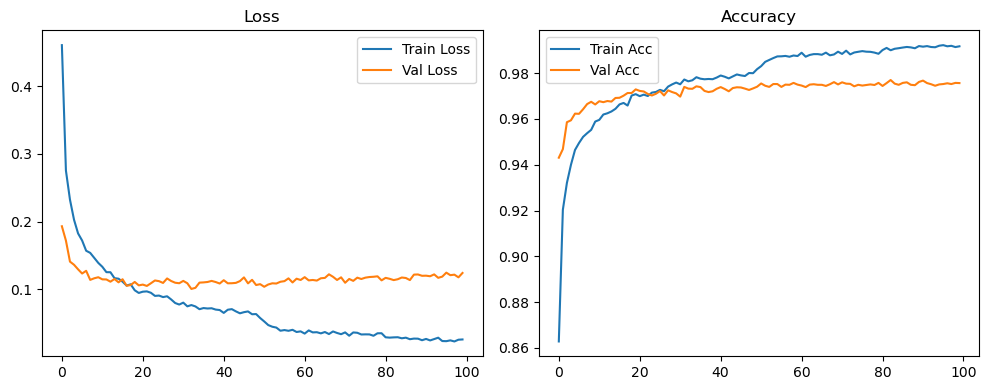

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2634, Acc: 0.9223 | Val Loss: 0.1622, Acc: 0.9503


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1099, Acc: 0.9657 | Val Loss: 0.1299, Acc: 0.9598


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0800, Acc: 0.9749 | Val Loss: 0.1257, Acc: 0.9618


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0613, Acc: 0.9803 | Val Loss: 0.1202, Acc: 0.9654


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0505, Acc: 0.9833 | Val Loss: 0.1224, Acc: 0.9658


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9865 | Val Loss: 0.1312, Acc: 0.9631


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9878 | Val Loss: 0.1174, Acc: 0.9676


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.1142, Acc: 0.9698


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9899 | Val Loss: 0.1178, Acc: 0.9695


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9915 | Val Loss: 0.1182, Acc: 0.9679


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.1196, Acc: 0.9689


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1145, Acc: 0.9716


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.1274, Acc: 0.9683


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1256, Acc: 0.9699


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1265, Acc: 0.9704


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9940 | Val Loss: 0.1171, Acc: 0.9730


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1347, Acc: 0.9697


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1283, Acc: 0.9711


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1355, Acc: 0.9710


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1413, Acc: 0.9709


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1296, Acc: 0.9712


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1426, Acc: 0.9677


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1364, Acc: 0.9683


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1491, Acc: 0.9692


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9954 | Val Loss: 0.1372, Acc: 0.9718


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1331, Acc: 0.9719


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1313, Acc: 0.9725


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1321, Acc: 0.9718


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1414, Acc: 0.9712


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1290, Acc: 0.9732


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1339, Acc: 0.9718


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1379, Acc: 0.9724


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1348, Acc: 0.9731


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1503, Acc: 0.9724


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1496, Acc: 0.9717


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1461, Acc: 0.9712


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1399, Acc: 0.9724


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1382, Acc: 0.9749


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1306, Acc: 0.9739


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1405, Acc: 0.9728


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1380, Acc: 0.9727


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1461, Acc: 0.9729


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1393, Acc: 0.9727


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1330, Acc: 0.9749


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1366, Acc: 0.9738


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1447, Acc: 0.9724


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1378, Acc: 0.9745


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1438, Acc: 0.9732


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1512, Acc: 0.9720


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1436, Acc: 0.9721


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1404, Acc: 0.9738


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1398, Acc: 0.9738


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1369, Acc: 0.9750


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1369, Acc: 0.9746


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1441, Acc: 0.9748


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1533, Acc: 0.9738


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1456, Acc: 0.9741


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1403, Acc: 0.9760


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1509, Acc: 0.9729


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1431, Acc: 0.9736


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1436, Acc: 0.9738


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1368, Acc: 0.9752


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1450, Acc: 0.9733


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1399, Acc: 0.9758


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1495, Acc: 0.9757


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1630, Acc: 0.9708


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1308, Acc: 0.9761


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1657, Acc: 0.9735


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.1609, Acc: 0.9746


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1499, Acc: 0.9739


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1432, Acc: 0.9748


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1489, Acc: 0.9747


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9987 | Val Loss: 0.1413, Acc: 0.9758


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1537, Acc: 0.9734


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1536, Acc: 0.9735


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1467, Acc: 0.9758


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1607, Acc: 0.9738


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1779, Acc: 0.9725


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1486, Acc: 0.9762


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1482, Acc: 0.9745


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1355, Acc: 0.9766


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1508, Acc: 0.9751


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1595, Acc: 0.9755


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9990 | Val Loss: 0.1449, Acc: 0.9779


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1703, Acc: 0.9725


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1557, Acc: 0.9740


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1476, Acc: 0.9751


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1576, Acc: 0.9749


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1518, Acc: 0.9764


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1501, Acc: 0.9751


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1616, Acc: 0.9746


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1594, Acc: 0.9742


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1529, Acc: 0.9775


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1587, Acc: 0.9756


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1630, Acc: 0.9754


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.1635, Acc: 0.9742


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1638, Acc: 0.9744


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1501, Acc: 0.9753


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1538, Acc: 0.9750


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1518, Acc: 0.9768


Final Test Loss: 0.1255 Accuracy: 0.9796


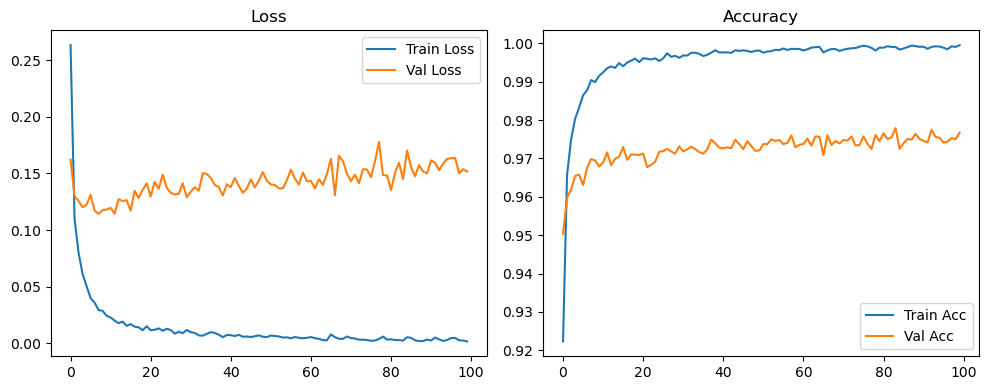

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3289, Acc: 0.9058 | Val Loss: 0.1600, Acc: 0.9513


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1543, Acc: 0.9526 | Val Loss: 0.1367, Acc: 0.9587


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1247, Acc: 0.9613 | Val Loss: 0.1301, Acc: 0.9608


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0985, Acc: 0.9697 | Val Loss: 0.1190, Acc: 0.9648


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0880, Acc: 0.9723 | Val Loss: 0.1140, Acc: 0.9672


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0777, Acc: 0.9753 | Val Loss: 0.1184, Acc: 0.9661


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0701, Acc: 0.9772 | Val Loss: 0.1105, Acc: 0.9675


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0657, Acc: 0.9784 | Val Loss: 0.1077, Acc: 0.9702


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0575, Acc: 0.9810 | Val Loss: 0.1128, Acc: 0.9693


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9823 | Val Loss: 0.1100, Acc: 0.9696


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9826 | Val Loss: 0.1127, Acc: 0.9681


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9841 | Val Loss: 0.1041, Acc: 0.9693


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9854 | Val Loss: 0.1177, Acc: 0.9689


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9852 | Val Loss: 0.1093, Acc: 0.9699


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9872 | Val Loss: 0.1073, Acc: 0.9718


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9876 | Val Loss: 0.1120, Acc: 0.9712


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9869 | Val Loss: 0.1174, Acc: 0.9706


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9880 | Val Loss: 0.1074, Acc: 0.9727


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.1108, Acc: 0.9723


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9896 | Val Loss: 0.1155, Acc: 0.9710


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.1041, Acc: 0.9736


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9901 | Val Loss: 0.1120, Acc: 0.9732


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.1049, Acc: 0.9732


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9908 | Val Loss: 0.1040, Acc: 0.9740


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.1150, Acc: 0.9712


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.1164, Acc: 0.9712


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.1194, Acc: 0.9723


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.1102, Acc: 0.9728


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.1151, Acc: 0.9736


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9917 | Val Loss: 0.1161, Acc: 0.9729


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.1266, Acc: 0.9727


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9919 | Val Loss: 0.1177, Acc: 0.9724


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.1213, Acc: 0.9727


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.1200, Acc: 0.9728


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.1106, Acc: 0.9742


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.1069, Acc: 0.9738


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.1282, Acc: 0.9720


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9935 | Val Loss: 0.1197, Acc: 0.9730


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.1269, Acc: 0.9718


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9927 | Val Loss: 0.1157, Acc: 0.9745


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.1215, Acc: 0.9722


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1212, Acc: 0.9748


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.1145, Acc: 0.9753


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.1221, Acc: 0.9735


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.1184, Acc: 0.9749


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.1204, Acc: 0.9736


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.1167, Acc: 0.9756


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1272, Acc: 0.9739


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9941 | Val Loss: 0.1225, Acc: 0.9740


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1140, Acc: 0.9761


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9943 | Val Loss: 0.1154, Acc: 0.9770


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.1232, Acc: 0.9745


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.1188, Acc: 0.9762


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.1264, Acc: 0.9745


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9946 | Val Loss: 0.1239, Acc: 0.9741


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1272, Acc: 0.9748


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.1211, Acc: 0.9769


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1251, Acc: 0.9757


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1281, Acc: 0.9753


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1298, Acc: 0.9755


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1273, Acc: 0.9762


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1266, Acc: 0.9753


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1265, Acc: 0.9746


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.1240, Acc: 0.9748


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1306, Acc: 0.9752


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1233, Acc: 0.9751


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.1278, Acc: 0.9750


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1160, Acc: 0.9753


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9956 | Val Loss: 0.1155, Acc: 0.9754


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1338, Acc: 0.9741


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.1139, Acc: 0.9756


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1226, Acc: 0.9750


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1235, Acc: 0.9755


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1307, Acc: 0.9749


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1264, Acc: 0.9762


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1227, Acc: 0.9748


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1292, Acc: 0.9753


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1346, Acc: 0.9762


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1267, Acc: 0.9762


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1297, Acc: 0.9762


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9963 | Val Loss: 0.1231, Acc: 0.9763


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1357, Acc: 0.9733


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1329, Acc: 0.9750


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1323, Acc: 0.9756


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1307, Acc: 0.9750


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1292, Acc: 0.9761


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1267, Acc: 0.9746


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1319, Acc: 0.9764


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1267, Acc: 0.9766


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1335, Acc: 0.9755


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.1232, Acc: 0.9758


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1239, Acc: 0.9772


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1337, Acc: 0.9770


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1439, Acc: 0.9742


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1318, Acc: 0.9762


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1462, Acc: 0.9741


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1360, Acc: 0.9755


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1319, Acc: 0.9751


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1315, Acc: 0.9740


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1382, Acc: 0.9739


Final Test Loss: 0.1411 Accuracy: 0.9770


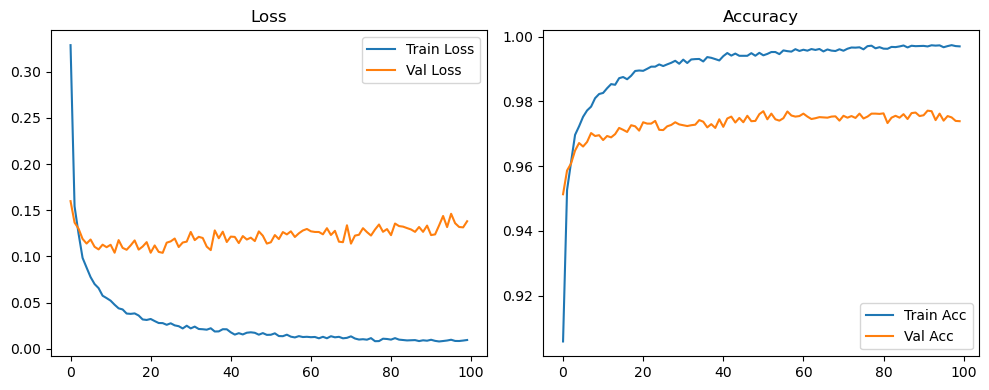

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5297, Acc: 0.8457 | Val Loss: 0.2052, Acc: 0.9388


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2762, Acc: 0.9180 | Val Loss: 0.1697, Acc: 0.9482


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2329, Acc: 0.9330 | Val Loss: 0.1444, Acc: 0.9557


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2030, Acc: 0.9403 | Val Loss: 0.1405, Acc: 0.9597


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1883, Acc: 0.9441 | Val Loss: 0.1328, Acc: 0.9613


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1741, Acc: 0.9486 | Val Loss: 0.1270, Acc: 0.9618


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1637, Acc: 0.9509 | Val Loss: 0.1286, Acc: 0.9646


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1575, Acc: 0.9534 | Val Loss: 0.1190, Acc: 0.9651


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1488, Acc: 0.9548 | Val Loss: 0.1145, Acc: 0.9673


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1428, Acc: 0.9563 | Val Loss: 0.1132, Acc: 0.9667


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1357, Acc: 0.9582 | Val Loss: 0.1165, Acc: 0.9673


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1336, Acc: 0.9598 | Val Loss: 0.1146, Acc: 0.9668


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1301, Acc: 0.9609 | Val Loss: 0.1073, Acc: 0.9702


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1252, Acc: 0.9621 | Val Loss: 0.1080, Acc: 0.9696


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1184, Acc: 0.9638 | Val Loss: 0.1102, Acc: 0.9693


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1142, Acc: 0.9655 | Val Loss: 0.1047, Acc: 0.9717


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1083, Acc: 0.9670 | Val Loss: 0.1096, Acc: 0.9704


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1091, Acc: 0.9663 | Val Loss: 0.1046, Acc: 0.9725


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1061, Acc: 0.9670 | Val Loss: 0.1063, Acc: 0.9692


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1010, Acc: 0.9684 | Val Loss: 0.1007, Acc: 0.9717


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1045, Acc: 0.9668 | Val Loss: 0.1066, Acc: 0.9704


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0998, Acc: 0.9689 | Val Loss: 0.1052, Acc: 0.9709


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0969, Acc: 0.9704 | Val Loss: 0.1101, Acc: 0.9704


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0988, Acc: 0.9691 | Val Loss: 0.1066, Acc: 0.9707


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0942, Acc: 0.9709 | Val Loss: 0.1067, Acc: 0.9727


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0915, Acc: 0.9721 | Val Loss: 0.1030, Acc: 0.9694


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0908, Acc: 0.9707 | Val Loss: 0.1091, Acc: 0.9718


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0888, Acc: 0.9728 | Val Loss: 0.1047, Acc: 0.9718


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0830, Acc: 0.9736 | Val Loss: 0.1047, Acc: 0.9718


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0841, Acc: 0.9735 | Val Loss: 0.0990, Acc: 0.9728


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0824, Acc: 0.9736 | Val Loss: 0.1058, Acc: 0.9716


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0823, Acc: 0.9741 | Val Loss: 0.1013, Acc: 0.9727


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0803, Acc: 0.9748 | Val Loss: 0.1015, Acc: 0.9724


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0792, Acc: 0.9750 | Val Loss: 0.1069, Acc: 0.9712


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0798, Acc: 0.9747 | Val Loss: 0.1109, Acc: 0.9716


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0783, Acc: 0.9746 | Val Loss: 0.1033, Acc: 0.9724


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0745, Acc: 0.9772 | Val Loss: 0.1034, Acc: 0.9732


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0761, Acc: 0.9760 | Val Loss: 0.1046, Acc: 0.9748


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0733, Acc: 0.9770 | Val Loss: 0.1025, Acc: 0.9748


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0745, Acc: 0.9764 | Val Loss: 0.0962, Acc: 0.9753


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0726, Acc: 0.9767 | Val Loss: 0.1053, Acc: 0.9728


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0724, Acc: 0.9768 | Val Loss: 0.1037, Acc: 0.9748


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0688, Acc: 0.9783 | Val Loss: 0.1028, Acc: 0.9746


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0679, Acc: 0.9785 | Val Loss: 0.1056, Acc: 0.9732


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0667, Acc: 0.9786 | Val Loss: 0.1008, Acc: 0.9738


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0645, Acc: 0.9795 | Val Loss: 0.1042, Acc: 0.9748


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0662, Acc: 0.9792 | Val Loss: 0.1001, Acc: 0.9738


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9790 | Val Loss: 0.1077, Acc: 0.9737


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0657, Acc: 0.9792 | Val Loss: 0.1016, Acc: 0.9736


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0640, Acc: 0.9797 | Val Loss: 0.1041, Acc: 0.9746


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0613, Acc: 0.9800 | Val Loss: 0.1070, Acc: 0.9740


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0647, Acc: 0.9806 | Val Loss: 0.1052, Acc: 0.9736


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0583, Acc: 0.9815 | Val Loss: 0.1121, Acc: 0.9722


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9814 | Val Loss: 0.1114, Acc: 0.9726


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0611, Acc: 0.9809 | Val Loss: 0.1066, Acc: 0.9738


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0606, Acc: 0.9807 | Val Loss: 0.1076, Acc: 0.9733


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0598, Acc: 0.9806 | Val Loss: 0.1098, Acc: 0.9736


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0598, Acc: 0.9808 | Val Loss: 0.1047, Acc: 0.9757


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9820 | Val Loss: 0.1112, Acc: 0.9732


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9820 | Val Loss: 0.1093, Acc: 0.9741


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0543, Acc: 0.9825 | Val Loss: 0.1094, Acc: 0.9734


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0574, Acc: 0.9817 | Val Loss: 0.1143, Acc: 0.9734


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0542, Acc: 0.9821 | Val Loss: 0.1076, Acc: 0.9737


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0537, Acc: 0.9827 | Val Loss: 0.1102, Acc: 0.9739


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0547, Acc: 0.9825 | Val Loss: 0.1084, Acc: 0.9750


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0542, Acc: 0.9824 | Val Loss: 0.1121, Acc: 0.9738


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0559, Acc: 0.9823 | Val Loss: 0.1045, Acc: 0.9752


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0515, Acc: 0.9834 | Val Loss: 0.1082, Acc: 0.9737


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9835 | Val Loss: 0.1092, Acc: 0.9754


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9820 | Val Loss: 0.1113, Acc: 0.9733


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0527, Acc: 0.9831 | Val Loss: 0.1155, Acc: 0.9732


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0522, Acc: 0.9832 | Val Loss: 0.1075, Acc: 0.9733


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9847 | Val Loss: 0.1019, Acc: 0.9758


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9843 | Val Loss: 0.1098, Acc: 0.9755


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0503, Acc: 0.9835 | Val Loss: 0.1098, Acc: 0.9742


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0508, Acc: 0.9840 | Val Loss: 0.1088, Acc: 0.9739


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9851 | Val Loss: 0.1053, Acc: 0.9743


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9851 | Val Loss: 0.1113, Acc: 0.9753


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9837 | Val Loss: 0.1081, Acc: 0.9749


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9847 | Val Loss: 0.1037, Acc: 0.9758


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9854 | Val Loss: 0.1044, Acc: 0.9758


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0490, Acc: 0.9843 | Val Loss: 0.1144, Acc: 0.9742


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9849 | Val Loss: 0.1121, Acc: 0.9751


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9861 | Val Loss: 0.1091, Acc: 0.9745


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9856 | Val Loss: 0.1140, Acc: 0.9732


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0432, Acc: 0.9861 | Val Loss: 0.1133, Acc: 0.9756


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9845 | Val Loss: 0.1103, Acc: 0.9744


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9861 | Val Loss: 0.1137, Acc: 0.9757


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0442, Acc: 0.9855 | Val Loss: 0.1123, Acc: 0.9758


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0455, Acc: 0.9854 | Val Loss: 0.1125, Acc: 0.9743


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9862 | Val Loss: 0.1072, Acc: 0.9767


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0415, Acc: 0.9864 | Val Loss: 0.1151, Acc: 0.9747


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9856 | Val Loss: 0.1161, Acc: 0.9744


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9851 | Val Loss: 0.1131, Acc: 0.9758


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9858 | Val Loss: 0.1106, Acc: 0.9752


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0439, Acc: 0.9858 | Val Loss: 0.1137, Acc: 0.9752


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9864 | Val Loss: 0.1081, Acc: 0.9760


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.1100, Acc: 0.9753


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9860 | Val Loss: 0.1149, Acc: 0.9752


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.1099, Acc: 0.9762


Final Test Loss: 0.1056 Accuracy: 0.9762


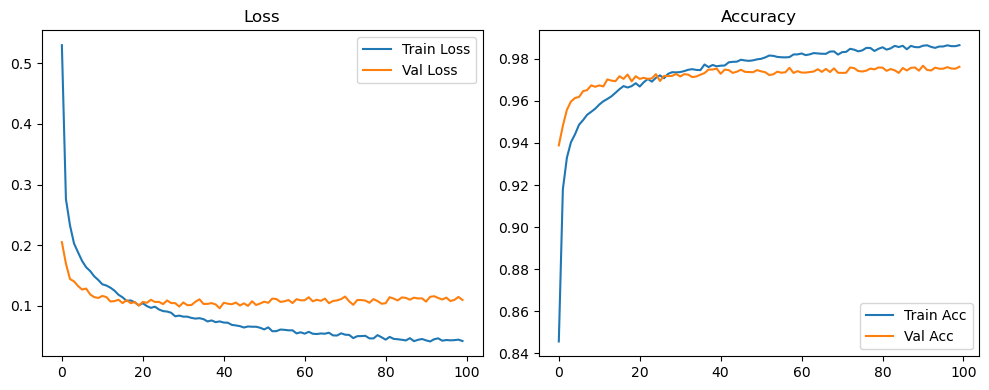

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3124, Acc: 0.9138 | Val Loss: 0.1593, Acc: 0.9498


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1111, Acc: 0.9655 | Val Loss: 0.1339, Acc: 0.9570


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0769, Acc: 0.9759 | Val Loss: 0.1317, Acc: 0.9615


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0585, Acc: 0.9809 | Val Loss: 0.1277, Acc: 0.9626


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0452, Acc: 0.9849 | Val Loss: 0.1250, Acc: 0.9649


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9869 | Val Loss: 0.1241, Acc: 0.9664


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9889 | Val Loss: 0.1155, Acc: 0.9684


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.1177, Acc: 0.9690


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9904 | Val Loss: 0.1193, Acc: 0.9673


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.1139, Acc: 0.9702


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.1275, Acc: 0.9666


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.1229, Acc: 0.9687


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9946 | Val Loss: 0.1335, Acc: 0.9688


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.1310, Acc: 0.9682


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.1312, Acc: 0.9697


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.1321, Acc: 0.9702


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1284, Acc: 0.9692


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.1389, Acc: 0.9690


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.1195, Acc: 0.9702


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1322, Acc: 0.9686


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1296, Acc: 0.9700


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.1389, Acc: 0.9685


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1254, Acc: 0.9705


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1308, Acc: 0.9711


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.1355, Acc: 0.9711


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1274, Acc: 0.9710


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1403, Acc: 0.9692


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1221, Acc: 0.9735


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1347, Acc: 0.9720


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1248, Acc: 0.9731


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1365, Acc: 0.9698


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9957 | Val Loss: 0.1414, Acc: 0.9717


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1202, Acc: 0.9736


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1304, Acc: 0.9724


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1376, Acc: 0.9714


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1309, Acc: 0.9711


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1425, Acc: 0.9714


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1436, Acc: 0.9713


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1358, Acc: 0.9718


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1360, Acc: 0.9739


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1397, Acc: 0.9720


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9980 | Val Loss: 0.1462, Acc: 0.9714


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.1431, Acc: 0.9719


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1241, Acc: 0.9751


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1556, Acc: 0.9700


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1395, Acc: 0.9726


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1337, Acc: 0.9741


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1425, Acc: 0.9718


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1288, Acc: 0.9735


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1279, Acc: 0.9741


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1451, Acc: 0.9710


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1478, Acc: 0.9706


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1403, Acc: 0.9719


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1484, Acc: 0.9718


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1323, Acc: 0.9718


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1479, Acc: 0.9717


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1266, Acc: 0.9753


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1367, Acc: 0.9738


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1436, Acc: 0.9718


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1335, Acc: 0.9742


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1319, Acc: 0.9748


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1318, Acc: 0.9738


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1424, Acc: 0.9752


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1409, Acc: 0.9743


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1506, Acc: 0.9729


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1604, Acc: 0.9698


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1476, Acc: 0.9732


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1398, Acc: 0.9732


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1385, Acc: 0.9749


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1445, Acc: 0.9724


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1395, Acc: 0.9726


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1448, Acc: 0.9739


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1465, Acc: 0.9733


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1475, Acc: 0.9744


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1472, Acc: 0.9742


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1503, Acc: 0.9749


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1389, Acc: 0.9760


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1507, Acc: 0.9739


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1526, Acc: 0.9728


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1436, Acc: 0.9739


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1512, Acc: 0.9721


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1447, Acc: 0.9746


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1338, Acc: 0.9751


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.1386, Acc: 0.9744


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1464, Acc: 0.9745


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1486, Acc: 0.9736


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1496, Acc: 0.9748


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1553, Acc: 0.9734


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1460, Acc: 0.9726


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1439, Acc: 0.9736


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1454, Acc: 0.9745


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1445, Acc: 0.9736


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1448, Acc: 0.9741


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1419, Acc: 0.9753


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1341, Acc: 0.9750


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1503, Acc: 0.9742


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1490, Acc: 0.9747


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1407, Acc: 0.9758


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1503, Acc: 0.9742


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1477, Acc: 0.9752


Final Test Loss: 0.1305 Accuracy: 0.9772


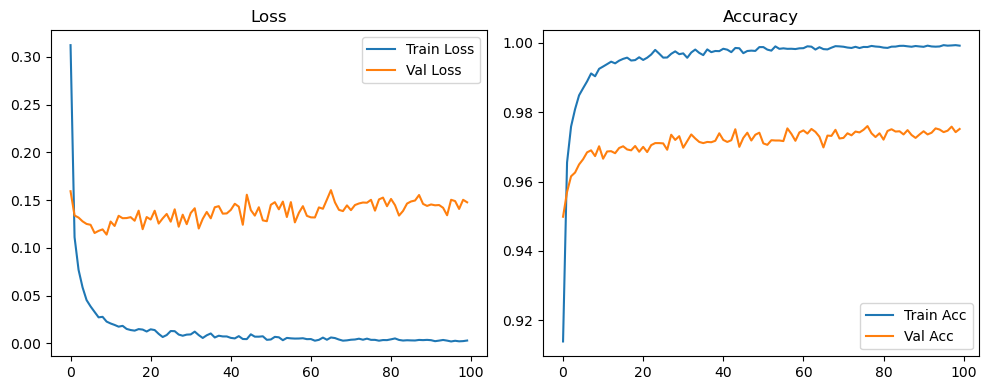

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3949, Acc: 0.8910 | Val Loss: 0.1654, Acc: 0.9489


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1622, Acc: 0.9498 | Val Loss: 0.1438, Acc: 0.9538


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1260, Acc: 0.9609 | Val Loss: 0.1342, Acc: 0.9602


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1064, Acc: 0.9667 | Val Loss: 0.1252, Acc: 0.9614


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0904, Acc: 0.9711 | Val Loss: 0.1200, Acc: 0.9665


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0820, Acc: 0.9742 | Val Loss: 0.1203, Acc: 0.9653


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0725, Acc: 0.9764 | Val Loss: 0.1147, Acc: 0.9690


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0659, Acc: 0.9790 | Val Loss: 0.1124, Acc: 0.9669


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0611, Acc: 0.9797 | Val Loss: 0.1087, Acc: 0.9699


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0562, Acc: 0.9812 | Val Loss: 0.1139, Acc: 0.9699


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0563, Acc: 0.9819 | Val Loss: 0.1186, Acc: 0.9671


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0500, Acc: 0.9834 | Val Loss: 0.1049, Acc: 0.9715


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0467, Acc: 0.9846 | Val Loss: 0.1144, Acc: 0.9681


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0419, Acc: 0.9859 | Val Loss: 0.1080, Acc: 0.9701


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9858 | Val Loss: 0.1098, Acc: 0.9712


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9874 | Val Loss: 0.1080, Acc: 0.9703


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9868 | Val Loss: 0.1148, Acc: 0.9701


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9883 | Val Loss: 0.1101, Acc: 0.9701


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0367, Acc: 0.9879 | Val Loss: 0.1141, Acc: 0.9704


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9887 | Val Loss: 0.1053, Acc: 0.9732


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9894 | Val Loss: 0.1123, Acc: 0.9735


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9892 | Val Loss: 0.1131, Acc: 0.9718


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.1093, Acc: 0.9715


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9905 | Val Loss: 0.1085, Acc: 0.9711


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9910 | Val Loss: 0.1043, Acc: 0.9732


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9901 | Val Loss: 0.1165, Acc: 0.9706


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9897 | Val Loss: 0.1209, Acc: 0.9697


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.1085, Acc: 0.9750


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.1083, Acc: 0.9736


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.1168, Acc: 0.9725


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.1126, Acc: 0.9728


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9914 | Val Loss: 0.1080, Acc: 0.9733


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.1127, Acc: 0.9728


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9926 | Val Loss: 0.1179, Acc: 0.9735


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9930 | Val Loss: 0.1143, Acc: 0.9736


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.1140, Acc: 0.9739


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9928 | Val Loss: 0.1198, Acc: 0.9727


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.1065, Acc: 0.9743


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.1158, Acc: 0.9734


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9924 | Val Loss: 0.1105, Acc: 0.9731


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.1190, Acc: 0.9726


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.1198, Acc: 0.9744


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.1175, Acc: 0.9727


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.1223, Acc: 0.9723


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.1159, Acc: 0.9735


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9938 | Val Loss: 0.1129, Acc: 0.9742


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.1177, Acc: 0.9750


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9944 | Val Loss: 0.1251, Acc: 0.9725


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.1145, Acc: 0.9735


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.1198, Acc: 0.9733


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9939 | Val Loss: 0.1174, Acc: 0.9738


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.1192, Acc: 0.9726


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1264, Acc: 0.9727


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.1148, Acc: 0.9743


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.1154, Acc: 0.9751


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.1129, Acc: 0.9742


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1163, Acc: 0.9740


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1166, Acc: 0.9743


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1100, Acc: 0.9758


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1238, Acc: 0.9726


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.1150, Acc: 0.9744


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1176, Acc: 0.9748


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1255, Acc: 0.9728


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1127, Acc: 0.9743


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.1225, Acc: 0.9728


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.1204, Acc: 0.9752


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1183, Acc: 0.9759


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1198, Acc: 0.9758


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1151, Acc: 0.9752


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1229, Acc: 0.9758


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1187, Acc: 0.9751


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1259, Acc: 0.9749


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1244, Acc: 0.9738


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1211, Acc: 0.9737


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1257, Acc: 0.9745


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.1245, Acc: 0.9745


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1217, Acc: 0.9745


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9961 | Val Loss: 0.1259, Acc: 0.9749


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1295, Acc: 0.9738


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1197, Acc: 0.9759


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1225, Acc: 0.9747


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1235, Acc: 0.9746


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1196, Acc: 0.9762


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1170, Acc: 0.9754


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.1187, Acc: 0.9756


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1092, Acc: 0.9768


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1287, Acc: 0.9750


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9965 | Val Loss: 0.1283, Acc: 0.9755


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1308, Acc: 0.9746


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1297, Acc: 0.9748


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1313, Acc: 0.9744


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1259, Acc: 0.9749


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1255, Acc: 0.9759


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1289, Acc: 0.9737


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1244, Acc: 0.9756


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.1310, Acc: 0.9768


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1243, Acc: 0.9756


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1227, Acc: 0.9762


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1277, Acc: 0.9758


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1234, Acc: 0.9768


Final Test Loss: 0.1115 Accuracy: 0.9789


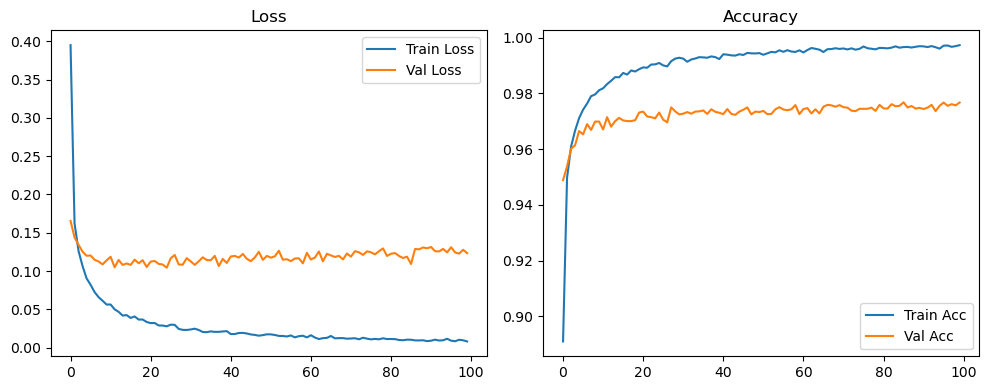

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6579, Acc: 0.8101 | Val Loss: 0.2313, Acc: 0.9332


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3001, Acc: 0.9126 | Val Loss: 0.1883, Acc: 0.9444


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2498, Acc: 0.9284 | Val Loss: 0.1619, Acc: 0.9515


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2171, Acc: 0.9369 | Val Loss: 0.1546, Acc: 0.9533


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1971, Acc: 0.9415 | Val Loss: 0.1392, Acc: 0.9575


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1846, Acc: 0.9453 | Val Loss: 0.1331, Acc: 0.9597


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1726, Acc: 0.9480 | Val Loss: 0.1377, Acc: 0.9620


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1612, Acc: 0.9526 | Val Loss: 0.1273, Acc: 0.9622


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1589, Acc: 0.9521 | Val Loss: 0.1255, Acc: 0.9627


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1522, Acc: 0.9540 | Val Loss: 0.1268, Acc: 0.9643


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1439, Acc: 0.9564 | Val Loss: 0.1212, Acc: 0.9653


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1401, Acc: 0.9579 | Val Loss: 0.1185, Acc: 0.9657


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1360, Acc: 0.9581 | Val Loss: 0.1163, Acc: 0.9677


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1311, Acc: 0.9600 | Val Loss: 0.1138, Acc: 0.9675


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1262, Acc: 0.9615 | Val Loss: 0.1145, Acc: 0.9670


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1234, Acc: 0.9618 | Val Loss: 0.1113, Acc: 0.9693


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1206, Acc: 0.9633 | Val Loss: 0.1116, Acc: 0.9671


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1137, Acc: 0.9651 | Val Loss: 0.1062, Acc: 0.9708


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1178, Acc: 0.9646 | Val Loss: 0.1100, Acc: 0.9679


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1104, Acc: 0.9663 | Val Loss: 0.1110, Acc: 0.9679


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1119, Acc: 0.9654 | Val Loss: 0.1122, Acc: 0.9688


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1086, Acc: 0.9668 | Val Loss: 0.1074, Acc: 0.9712


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1051, Acc: 0.9673 | Val Loss: 0.1065, Acc: 0.9702


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1047, Acc: 0.9675 | Val Loss: 0.1158, Acc: 0.9677


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1020, Acc: 0.9686 | Val Loss: 0.1082, Acc: 0.9711


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0982, Acc: 0.9703 | Val Loss: 0.1122, Acc: 0.9705


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0959, Acc: 0.9700 | Val Loss: 0.1090, Acc: 0.9702


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0941, Acc: 0.9704 | Val Loss: 0.1078, Acc: 0.9692


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0933, Acc: 0.9709 | Val Loss: 0.1118, Acc: 0.9700


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0901, Acc: 0.9714 | Val Loss: 0.1101, Acc: 0.9715


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0914, Acc: 0.9715 | Val Loss: 0.1122, Acc: 0.9697


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0904, Acc: 0.9723 | Val Loss: 0.1082, Acc: 0.9715


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0861, Acc: 0.9728 | Val Loss: 0.1095, Acc: 0.9713


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0853, Acc: 0.9726 | Val Loss: 0.1076, Acc: 0.9708


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0849, Acc: 0.9736 | Val Loss: 0.1105, Acc: 0.9706


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0851, Acc: 0.9728 | Val Loss: 0.1035, Acc: 0.9731


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0816, Acc: 0.9742 | Val Loss: 0.1092, Acc: 0.9712


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0830, Acc: 0.9745 | Val Loss: 0.1103, Acc: 0.9711


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0819, Acc: 0.9738 | Val Loss: 0.1056, Acc: 0.9723


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0781, Acc: 0.9749 | Val Loss: 0.1045, Acc: 0.9717


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0747, Acc: 0.9768 | Val Loss: 0.1078, Acc: 0.9708


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0754, Acc: 0.9768 | Val Loss: 0.1080, Acc: 0.9718


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0750, Acc: 0.9769 | Val Loss: 0.1038, Acc: 0.9730


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0734, Acc: 0.9773 | Val Loss: 0.1080, Acc: 0.9738


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0730, Acc: 0.9764 | Val Loss: 0.1058, Acc: 0.9725


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0722, Acc: 0.9769 | Val Loss: 0.1051, Acc: 0.9722


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0700, Acc: 0.9784 | Val Loss: 0.1079, Acc: 0.9713


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0684, Acc: 0.9788 | Val Loss: 0.1079, Acc: 0.9713


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0735, Acc: 0.9767 | Val Loss: 0.1044, Acc: 0.9736


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0659, Acc: 0.9795 | Val Loss: 0.1091, Acc: 0.9728


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0689, Acc: 0.9778 | Val Loss: 0.1035, Acc: 0.9728


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0686, Acc: 0.9785 | Val Loss: 0.1053, Acc: 0.9733


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0638, Acc: 0.9798 | Val Loss: 0.1102, Acc: 0.9716


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0659, Acc: 0.9791 | Val Loss: 0.1062, Acc: 0.9737


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0661, Acc: 0.9786 | Val Loss: 0.1059, Acc: 0.9742


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0673, Acc: 0.9787 | Val Loss: 0.1080, Acc: 0.9725


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0652, Acc: 0.9793 | Val Loss: 0.1075, Acc: 0.9713


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0662, Acc: 0.9789 | Val Loss: 0.1035, Acc: 0.9728


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0637, Acc: 0.9804 | Val Loss: 0.1097, Acc: 0.9737


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0647, Acc: 0.9798 | Val Loss: 0.1032, Acc: 0.9729


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0615, Acc: 0.9805 | Val Loss: 0.1043, Acc: 0.9731


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0619, Acc: 0.9799 | Val Loss: 0.1144, Acc: 0.9716


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0593, Acc: 0.9810 | Val Loss: 0.1105, Acc: 0.9731


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0603, Acc: 0.9816 | Val Loss: 0.1023, Acc: 0.9741


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0594, Acc: 0.9815 | Val Loss: 0.1027, Acc: 0.9752


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0618, Acc: 0.9799 | Val Loss: 0.1064, Acc: 0.9735


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0570, Acc: 0.9815 | Val Loss: 0.1075, Acc: 0.9732


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0515, Acc: 0.9832 | Val Loss: 0.1146, Acc: 0.9730


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0576, Acc: 0.9813 | Val Loss: 0.1098, Acc: 0.9733


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0571, Acc: 0.9815 | Val Loss: 0.1139, Acc: 0.9722


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0579, Acc: 0.9814 | Val Loss: 0.1083, Acc: 0.9746


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0562, Acc: 0.9818 | Val Loss: 0.1062, Acc: 0.9728


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0547, Acc: 0.9827 | Val Loss: 0.1043, Acc: 0.9724


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0546, Acc: 0.9823 | Val Loss: 0.1071, Acc: 0.9736


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0513, Acc: 0.9832 | Val Loss: 0.1109, Acc: 0.9741


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0519, Acc: 0.9834 | Val Loss: 0.1091, Acc: 0.9750


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0542, Acc: 0.9829 | Val Loss: 0.1068, Acc: 0.9742


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0517, Acc: 0.9838 | Val Loss: 0.1110, Acc: 0.9729


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0512, Acc: 0.9835 | Val Loss: 0.1072, Acc: 0.9736


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0533, Acc: 0.9827 | Val Loss: 0.1033, Acc: 0.9737


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0506, Acc: 0.9836 | Val Loss: 0.1069, Acc: 0.9741


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0538, Acc: 0.9828 | Val Loss: 0.1046, Acc: 0.9728


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0494, Acc: 0.9838 | Val Loss: 0.1065, Acc: 0.9740


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0486, Acc: 0.9835 | Val Loss: 0.1014, Acc: 0.9738


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0512, Acc: 0.9838 | Val Loss: 0.1055, Acc: 0.9741


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0491, Acc: 0.9842 | Val Loss: 0.1045, Acc: 0.9743


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0507, Acc: 0.9833 | Val Loss: 0.1062, Acc: 0.9728


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0493, Acc: 0.9836 | Val Loss: 0.1053, Acc: 0.9751


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0485, Acc: 0.9841 | Val Loss: 0.1067, Acc: 0.9742


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0492, Acc: 0.9851 | Val Loss: 0.1080, Acc: 0.9745


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0450, Acc: 0.9852 | Val Loss: 0.1082, Acc: 0.9736


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9862 | Val Loss: 0.1090, Acc: 0.9745


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9853 | Val Loss: 0.1128, Acc: 0.9746


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0515, Acc: 0.9833 | Val Loss: 0.1116, Acc: 0.9729


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0510, Acc: 0.9836 | Val Loss: 0.1086, Acc: 0.9741


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9853 | Val Loss: 0.1083, Acc: 0.9743


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0465, Acc: 0.9847 | Val Loss: 0.1064, Acc: 0.9742


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0462, Acc: 0.9851 | Val Loss: 0.1108, Acc: 0.9740


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0468, Acc: 0.9855 | Val Loss: 0.1106, Acc: 0.9734


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9852 | Val Loss: 0.1121, Acc: 0.9741


Final Test Loss: 0.0997 Accuracy: 0.9763


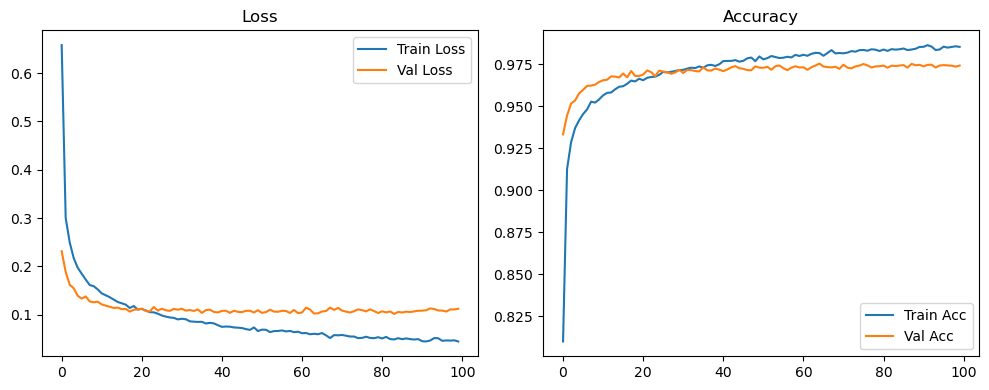

🏆 Best Config: batch64_lr0.01_0.005_0.001_dp0.2 Accuracy: 0.9836


In [8]:
root_path = "MLP_256_4bit_regular_SiLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)